In [ ]:
eta = 0.05
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 12
n_center = 10
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations=40       # num mirror steps
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100



In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=aabc593a582d39e9ca6aac90867e79392a91e3e640b3a14874da22227d5eb802
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


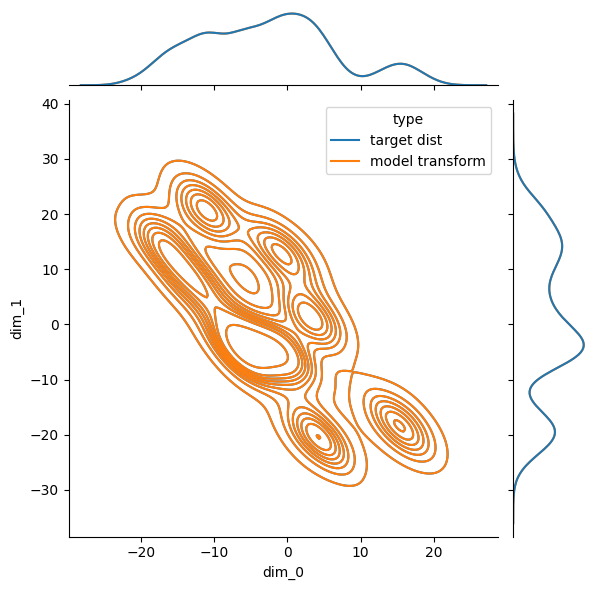

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])

trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:11<00:00,  8.88it/s]

Loss: 37.97715759277344


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


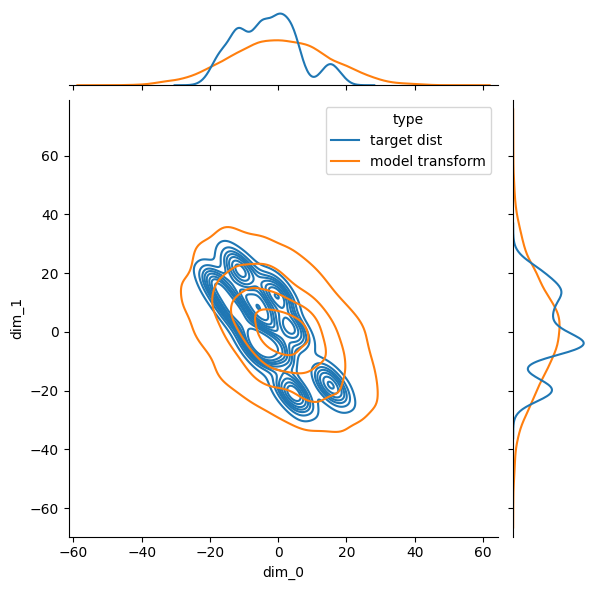

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:31<34:24,  2.86it/s]

trail: 0 m step: 0 Loss: 104.54981994628906  L_n: 79.85232543945312  kld: 1.2348747253417969 KLD1: 79.0303955078125 KLD2: 13.125974655151367


  3%|▎         | 200/6000 [01:03<33:51,  2.85it/s]

trail: 0 m step: 0 Loss: 101.88243865966797  L_n: 75.98522186279297  kld: 1.29486083984375 KLD1: 75.91873168945312 KLD2: 12.954535484313965


  5%|▌         | 300/6000 [01:35<33:07,  2.87it/s]

trail: 0 m step: 0 Loss: 101.08053588867188  L_n: 74.40740966796875  kld: 1.3336563110351562 KLD1: 74.53312683105469 KLD2: 12.70886516571045


  7%|▋         | 400/6000 [02:07<32:48,  2.84it/s]

trail: 0 m step: 0 Loss: 99.83856201171875  L_n: 73.20335388183594  kld: 1.3317604064941406 KLD1: 73.2371826171875 KLD2: 12.524835586547852


  8%|▊         | 500/6000 [02:39<32:06,  2.86it/s]

trail: 0 m step: 0 Loss: 99.88082885742188  L_n: 72.08366394042969  kld: 1.3898582458496094 KLD1: 71.85382080078125 KLD2: 12.465070724487305


 10%|█         | 600/6000 [03:10<31:20,  2.87it/s]

trail: 0 m step: 0 Loss: 100.03045654296875  L_n: 71.70831298828125  kld: 1.416107177734375 KLD1: 70.9234619140625 KLD2: 12.390778541564941


 12%|█▏        | 700/6000 [03:42<31:02,  2.85it/s]

trail: 0 m step: 0 Loss: 98.99576568603516  L_n: 70.86885833740234  kld: 1.4063453674316406 KLD1: 70.55902099609375 KLD2: 12.278942108154297


 13%|█▎        | 800/6000 [04:14<30:26,  2.85it/s]

trail: 0 m step: 0 Loss: 98.69792175292969  L_n: 70.07144165039062  kld: 1.4313240051269531 KLD1: 69.81098937988281 KLD2: 12.235589027404785


 15%|█▌        | 900/6000 [04:46<29:50,  2.85it/s]

trail: 0 m step: 0 Loss: 98.66216278076172  L_n: 69.64017486572266  kld: 1.4510993957519531 KLD1: 69.1423568725586 KLD2: 12.190359115600586


 17%|█▋        | 1000/6000 [05:17<29:16,  2.85it/s]

trail: 0 m step: 0 Loss: 97.12702178955078  L_n: 68.6169662475586  kld: 1.4255027770996094 KLD1: 69.24102020263672 KLD2: 12.110235214233398


 18%|█▊        | 1100/6000 [05:49<28:32,  2.86it/s]

trail: 0 m step: 0 Loss: 97.551513671875  L_n: 68.67509460449219  kld: 1.4438209533691406 KLD1: 68.45052337646484 KLD2: 12.07325553894043


 20%|██        | 1200/6000 [06:21<28:10,  2.84it/s]

trail: 0 m step: 0 Loss: 97.07801818847656  L_n: 68.13217163085938  kld: 1.4472923278808594 KLD1: 68.38105773925781 KLD2: 12.03828239440918


 22%|██▏       | 1300/6000 [06:53<27:28,  2.85it/s]

trail: 0 m step: 0 Loss: 96.89616394042969  L_n: 67.87448120117188  kld: 1.4510841369628906 KLD1: 67.78174591064453 KLD2: 12.00294303894043


 23%|██▎       | 1400/6000 [07:24<26:52,  2.85it/s]

trail: 0 m step: 0 Loss: 96.8397445678711  L_n: 67.68721771240234  kld: 1.4576263427734375 KLD1: 67.71709442138672 KLD2: 11.899615287780762


 25%|██▌       | 1500/6000 [07:56<26:21,  2.84it/s]

trail: 0 m step: 0 Loss: 96.04654693603516  L_n: 66.6224136352539  kld: 1.4712066650390625 KLD1: 66.788818359375 KLD2: 11.806915283203125


 27%|██▋       | 1600/6000 [08:28<25:49,  2.84it/s]

trail: 0 m step: 0 Loss: 96.311767578125  L_n: 66.85993957519531  kld: 1.4725914001464844 KLD1: 66.61217498779297 KLD2: 11.814691543579102


 28%|██▊       | 1700/6000 [09:00<25:10,  2.85it/s]

trail: 0 m step: 0 Loss: 95.88822937011719  L_n: 66.45402526855469  kld: 1.471710205078125 KLD1: 66.3326644897461 KLD2: 11.792855262756348


 30%|███       | 1800/6000 [09:31<24:35,  2.85it/s]

trail: 0 m step: 0 Loss: 95.37690734863281  L_n: 65.5953369140625  kld: 1.4890785217285156 KLD1: 65.95851135253906 KLD2: 11.750324249267578


 32%|███▏      | 1900/6000 [10:03<23:56,  2.85it/s]

trail: 0 m step: 0 Loss: 95.04547882080078  L_n: 65.11162567138672  kld: 1.4966926574707031 KLD1: 65.64778900146484 KLD2: 11.748431205749512


 33%|███▎      | 2000/6000 [10:35<23:25,  2.85it/s]

trail: 0 m step: 0 Loss: 95.04545593261719  L_n: 65.39877319335938  kld: 1.4823341369628906 KLD1: 65.81489562988281 KLD2: 11.744370460510254


 35%|███▌      | 2100/6000 [11:06<22:52,  2.84it/s]

trail: 0 m step: 0 Loss: 94.6002197265625  L_n: 64.52743530273438  kld: 1.5036392211914062 KLD1: 65.1817855834961 KLD2: 11.689181327819824


 37%|███▋      | 2200/6000 [11:38<22:09,  2.86it/s]

trail: 0 m step: 0 Loss: 94.70479583740234  L_n: 64.97052764892578  kld: 1.4867134094238281 KLD1: 65.39543914794922 KLD2: 11.700217247009277


 38%|███▊      | 2300/6000 [12:10<21:37,  2.85it/s]

trail: 0 m step: 0 Loss: 95.27727508544922  L_n: 64.8877944946289  kld: 1.5194740295410156 KLD1: 64.84431457519531 KLD2: 11.630270004272461


 40%|████      | 2400/6000 [12:41<20:57,  2.86it/s]

trail: 0 m step: 0 Loss: 94.88301849365234  L_n: 64.78528594970703  kld: 1.5048866271972656 KLD1: 65.05376434326172 KLD2: 11.658249855041504


 42%|████▏     | 2500/6000 [13:13<20:27,  2.85it/s]

trail: 0 m step: 0 Loss: 94.62236022949219  L_n: 64.68217468261719  kld: 1.49700927734375 KLD1: 65.19966125488281 KLD2: 11.634883880615234


 43%|████▎     | 2600/6000 [13:45<19:51,  2.85it/s]

trail: 0 m step: 0 Loss: 95.31663513183594  L_n: 64.78982543945312  kld: 1.5263404846191406 KLD1: 64.54747009277344 KLD2: 11.592047691345215


 45%|████▌     | 2700/6000 [14:17<19:15,  2.86it/s]

trail: 0 m step: 0 Loss: 94.66172790527344  L_n: 64.31413269042969  kld: 1.5173797607421875 KLD1: 64.46834564208984 KLD2: 11.60153579711914


 47%|████▋     | 2800/6000 [14:48<18:43,  2.85it/s]

trail: 0 m step: 0 Loss: 95.51818084716797  L_n: 64.72151947021484  kld: 1.5398330688476562 KLD1: 64.11495208740234 KLD2: 11.60484504699707


 48%|████▊     | 2900/6000 [15:20<18:10,  2.84it/s]

trail: 0 m step: 0 Loss: 95.18199920654297  L_n: 64.6969985961914  kld: 1.5242500305175781 KLD1: 64.5078353881836 KLD2: 11.589761734008789


 50%|█████     | 3000/6000 [15:52<17:36,  2.84it/s]

trail: 0 m step: 0 Loss: 95.31273651123047  L_n: 64.73023223876953  kld: 1.5291252136230469 KLD1: 64.2098388671875 KLD2: 11.537405014038086


 52%|█████▏    | 3100/6000 [16:24<17:00,  2.84it/s]

trail: 0 m step: 0 Loss: 94.37676239013672  L_n: 64.34273529052734  kld: 1.5017013549804688 KLD1: 64.58090209960938 KLD2: 11.502458572387695


 53%|█████▎    | 3200/6000 [16:56<16:24,  2.84it/s]

trail: 0 m step: 0 Loss: 95.20680236816406  L_n: 64.65245056152344  kld: 1.5277175903320312 KLD1: 64.10755157470703 KLD2: 11.48830795288086


 55%|█████▌    | 3300/6000 [17:27<15:49,  2.84it/s]

trail: 0 m step: 0 Loss: 95.16462707519531  L_n: 64.57464599609375  kld: 1.5294990539550781 KLD1: 64.04159545898438 KLD2: 11.477614402770996


 57%|█████▋    | 3400/6000 [17:59<15:12,  2.85it/s]

trail: 0 m step: 0 Loss: 94.12828063964844  L_n: 63.57850646972656  kld: 1.5274887084960938 KLD1: 64.14773559570312 KLD2: 11.512466430664062


 58%|█████▊    | 3500/6000 [18:31<14:37,  2.85it/s]

trail: 0 m step: 0 Loss: 94.71330261230469  L_n: 64.13545227050781  kld: 1.5288925170898438 KLD1: 63.979530334472656 KLD2: 11.495559692382812


 60%|██████    | 3600/6000 [19:03<14:05,  2.84it/s]

trail: 0 m step: 0 Loss: 94.11107635498047  L_n: 63.41588592529297  kld: 1.534759521484375 KLD1: 63.89931106567383 KLD2: 11.515727996826172


 62%|██████▏   | 3700/6000 [19:34<13:27,  2.85it/s]

trail: 0 m step: 0 Loss: 94.47599411010742  L_n: 63.971920013427734  kld: 1.5252037048339844 KLD1: 63.92798614501953 KLD2: 11.460866928100586


 63%|██████▎   | 3800/6000 [20:06<12:52,  2.85it/s]

trail: 0 m step: 0 Loss: 94.38462829589844  L_n: 64.21258544921875  kld: 1.5086021423339844 KLD1: 64.15814971923828 KLD2: 11.420690536499023


 65%|██████▌   | 3900/6000 [20:38<12:16,  2.85it/s]

trail: 0 m step: 0 Loss: 94.43135833740234  L_n: 63.66040802001953  kld: 1.5385475158691406 KLD1: 63.726985931396484 KLD2: 11.402146339416504


 67%|██████▋   | 4000/6000 [21:10<11:44,  2.84it/s]

trail: 0 m step: 0 Loss: 94.5641860961914  L_n: 63.57762908935547  kld: 1.5493278503417969 KLD1: 63.406856536865234 KLD2: 11.432991981506348


 68%|██████▊   | 4100/6000 [21:42<11:05,  2.86it/s]

trail: 0 m step: 0 Loss: 94.4036865234375  L_n: 63.49281311035156  kld: 1.5455436706542969 KLD1: 63.36572265625 KLD2: 11.408245086669922


 70%|███████   | 4200/6000 [22:13<10:33,  2.84it/s]

trail: 0 m step: 0 Loss: 93.95595932006836  L_n: 63.270076751708984  kld: 1.5342941284179688 KLD1: 63.54837417602539 KLD2: 11.395905494689941


 72%|███████▏  | 4300/6000 [22:45<09:57,  2.85it/s]

trail: 0 m step: 0 Loss: 94.75982666015625  L_n: 64.13002014160156  kld: 1.5314903259277344 KLD1: 63.822818756103516 KLD2: 11.436551094055176


 73%|███████▎  | 4400/6000 [23:17<09:19,  2.86it/s]

trail: 0 m step: 0 Loss: 94.27048110961914  L_n: 63.5286750793457  kld: 1.5370903015136719 KLD1: 63.6339225769043 KLD2: 11.397815704345703


 75%|███████▌  | 4500/6000 [23:49<08:47,  2.85it/s]

trail: 0 m step: 0 Loss: 94.58521270751953  L_n: 63.91832733154297  kld: 1.5333442687988281 KLD1: 63.619529724121094 KLD2: 11.378999710083008


 77%|███████▋  | 4600/6000 [24:21<08:10,  2.85it/s]

trail: 0 m step: 0 Loss: 94.46460723876953  L_n: 63.56067657470703  kld: 1.545196533203125 KLD1: 63.44634246826172 KLD2: 11.419132232666016


 78%|███████▊  | 4700/6000 [24:52<07:36,  2.85it/s]

trail: 0 m step: 0 Loss: 93.63631057739258  L_n: 63.431156158447266  kld: 1.5102577209472656 KLD1: 64.28781127929688 KLD2: 11.374381065368652


 80%|████████  | 4800/6000 [25:24<07:01,  2.85it/s]

trail: 0 m step: 0 Loss: 94.13058853149414  L_n: 63.798099517822266  kld: 1.5166244506835938 KLD1: 63.9724235534668 KLD2: 11.37334156036377


 82%|████████▏ | 4900/6000 [25:56<06:27,  2.84it/s]

trail: 0 m step: 0 Loss: 94.1747932434082  L_n: 63.69429397583008  kld: 1.5240249633789062 KLD1: 63.80586242675781 KLD2: 11.344903945922852


 83%|████████▎ | 5000/6000 [26:28<05:53,  2.83it/s]

trail: 0 m step: 0 Loss: 94.53040313720703  L_n: 63.591148376464844  kld: 1.5469627380371094 KLD1: 63.271385192871094 KLD2: 11.368938446044922


 85%|████████▌ | 5100/6000 [27:00<05:16,  2.84it/s]

trail: 0 m step: 0 Loss: 93.68045043945312  L_n: 63.31889343261719  kld: 1.5180778503417969 KLD1: 63.88810348510742 KLD2: 11.378372192382812


 87%|████████▋ | 5200/6000 [27:31<04:41,  2.84it/s]

trail: 0 m step: 0 Loss: 94.3110466003418  L_n: 63.57748031616211  kld: 1.5366783142089844 KLD1: 63.48915481567383 KLD2: 11.360614776611328


 88%|████████▊ | 5300/6000 [28:03<04:07,  2.83it/s]

trail: 0 m step: 0 Loss: 94.55590057373047  L_n: 63.717811584472656  kld: 1.5419044494628906 KLD1: 63.4375114440918 KLD2: 11.324727058410645


 90%|█████████ | 5400/6000 [28:35<03:31,  2.84it/s]

trail: 0 m step: 0 Loss: 93.79637145996094  L_n: 63.19158935546875  kld: 1.5302391052246094 KLD1: 63.39323043823242 KLD2: 11.313918113708496


 92%|█████████▏| 5500/6000 [29:07<02:55,  2.85it/s]

trail: 0 m step: 0 Loss: 94.4379768371582  L_n: 63.4547004699707  kld: 1.549163818359375 KLD1: 63.23822784423828 KLD2: 11.306063652038574


 93%|█████████▎| 5600/6000 [29:39<02:20,  2.85it/s]

trail: 0 m step: 0 Loss: 94.75607681274414  L_n: 63.65141677856445  kld: 1.5552330017089844 KLD1: 63.06747817993164 KLD2: 11.309818267822266


 95%|█████████▌| 5700/6000 [30:10<01:45,  2.85it/s]

trail: 0 m step: 0 Loss: 94.03000259399414  L_n: 63.264774322509766  kld: 1.5382614135742188 KLD1: 63.31909942626953 KLD2: 11.341842651367188


 97%|█████████▋| 5800/6000 [30:42<01:10,  2.85it/s]

trail: 0 m step: 0 Loss: 94.33113861083984  L_n: 63.498085021972656  kld: 1.5416526794433594 KLD1: 63.26599884033203 KLD2: 11.29703426361084


 98%|█████████▊| 5900/6000 [31:14<00:35,  2.84it/s]

trail: 0 m step: 0 Loss: 94.15777206420898  L_n: 63.30076217651367  kld: 1.5428504943847656 KLD1: 63.337547302246094 KLD2: 11.324519157409668


100%|██████████| 6000/6000 [31:46<00:00,  3.15it/s]

trail: 0 m step: 0 Loss: 93.95085144042969  L_n: 62.89105224609375  kld: 1.5529899597167969 KLD1: 62.821624755859375 KLD2: 11.320613861083984



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


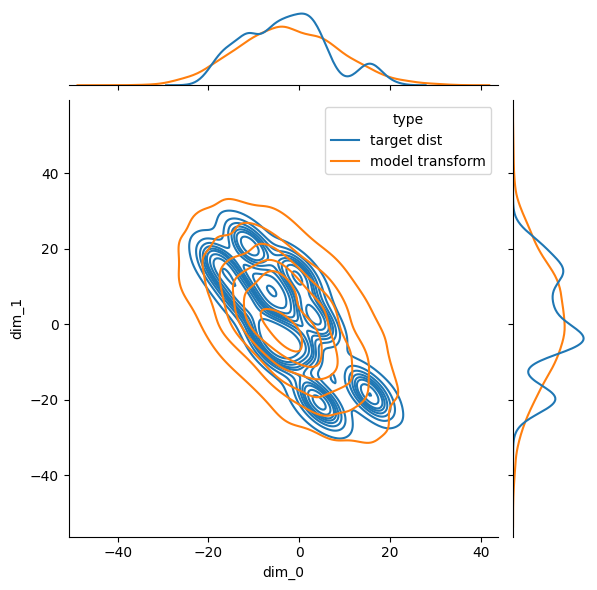

trail: 0 m step: 0 kl_test: 63.64582443237305


  2%|▏         | 100/6000 [00:32<35:05,  2.80it/s]

trail: 0 m step: 1 Loss: 51.648136138916016  L_n: 43.38016128540039  kld: 0.41339874267578125 KLD1: 43.00285339355469 KLD2: 9.560361862182617


  3%|▎         | 200/6000 [01:03<34:02,  2.84it/s]

trail: 0 m step: 1 Loss: 50.67904281616211  L_n: 41.80399703979492  kld: 0.4437522888183594 KLD1: 41.72979736328125 KLD2: 9.45516586303711


  5%|▌         | 300/6000 [01:35<33:30,  2.83it/s]

trail: 0 m step: 1 Loss: 50.25910568237305  L_n: 41.34713363647461  kld: 0.4455986022949219 KLD1: 41.35866165161133 KLD2: 9.321788787841797


  7%|▋         | 400/6000 [02:07<33:00,  2.83it/s]

trail: 0 m step: 1 Loss: 49.6175651550293  L_n: 40.82674789428711  kld: 0.4395408630371094 KLD1: 41.15229415893555 KLD2: 9.218779563903809


  8%|▊         | 500/6000 [02:39<32:21,  2.83it/s]

trail: 0 m step: 1 Loss: 49.897979736328125  L_n: 40.512908935546875  kld: 0.4692535400390625 KLD1: 40.58803176879883 KLD2: 9.200876235961914


 10%|█         | 600/6000 [03:11<31:50,  2.83it/s]

trail: 0 m step: 1 Loss: 50.38694763183594  L_n: 40.67411804199219  kld: 0.4856414794921875 KLD1: 39.874271392822266 KLD2: 9.152192115783691


 12%|█▏        | 700/6000 [03:43<31:13,  2.83it/s]

trail: 0 m step: 1 Loss: 49.88652420043945  L_n: 40.286685943603516  kld: 0.4799919128417969 KLD1: 40.092594146728516 KLD2: 9.061020851135254


 13%|█▎        | 800/6000 [04:15<30:39,  2.83it/s]

trail: 0 m step: 1 Loss: 50.02153778076172  L_n: 40.12285614013672  kld: 0.49493408203125 KLD1: 39.94009017944336 KLD2: 9.053396224975586


 15%|█▌        | 900/6000 [04:47<30:00,  2.83it/s]

trail: 0 m step: 1 Loss: 49.765254974365234  L_n: 39.83063888549805  kld: 0.4967308044433594 KLD1: 39.666709899902344 KLD2: 9.036267280578613


 17%|█▋        | 1000/6000 [05:19<29:26,  2.83it/s]

trail: 0 m step: 1 Loss: 49.101470947265625  L_n: 39.57586669921875  kld: 0.47628021240234375 KLD1: 40.01826858520508 KLD2: 8.987421989440918


 18%|█▊        | 1100/6000 [05:51<28:50,  2.83it/s]

trail: 0 m step: 1 Loss: 49.43706130981445  L_n: 39.554325103759766  kld: 0.4941368103027344 KLD1: 39.52359390258789 KLD2: 8.954656600952148


 20%|██        | 1200/6000 [06:23<28:17,  2.83it/s]

trail: 0 m step: 1 Loss: 49.27199935913086  L_n: 39.403072357177734  kld: 0.49344635009765625 KLD1: 39.657081604003906 KLD2: 8.93360424041748


 22%|██▏       | 1300/6000 [06:55<27:42,  2.83it/s]

trail: 0 m step: 1 Loss: 49.37469482421875  L_n: 39.580078125  kld: 0.4897308349609375 KLD1: 39.60674285888672 KLD2: 8.947046279907227


 23%|██▎       | 1400/6000 [07:27<27:06,  2.83it/s]

trail: 0 m step: 1 Loss: 49.476322174072266  L_n: 39.619449615478516  kld: 0.4928436279296875 KLD1: 39.603675842285156 KLD2: 8.858274459838867


 25%|██▌       | 1500/6000 [07:59<26:30,  2.83it/s]

trail: 0 m step: 1 Loss: 49.29082107543945  L_n: 39.22139358520508  kld: 0.5034713745117188 KLD1: 39.18526840209961 KLD2: 8.785122871398926


 27%|██▋       | 1600/6000 [08:31<25:50,  2.84it/s]

trail: 0 m step: 1 Loss: 49.65433120727539  L_n: 39.62251663208008  kld: 0.5015907287597656 KLD1: 39.19734191894531 KLD2: 8.816852569580078


 28%|██▊       | 1700/6000 [09:03<25:21,  2.83it/s]

trail: 0 m step: 1 Loss: 49.480648040771484  L_n: 39.5362663269043  kld: 0.4972190856933594 KLD1: 39.23238754272461 KLD2: 8.825373649597168


 30%|███       | 1800/6000 [09:35<24:44,  2.83it/s]

trail: 0 m step: 1 Loss: 49.0953483581543  L_n: 39.003414154052734  kld: 0.5045967102050781 KLD1: 39.122867584228516 KLD2: 8.786017417907715


 32%|███▏      | 1900/6000 [10:07<24:11,  2.82it/s]

trail: 0 m step: 1 Loss: 49.04043960571289  L_n: 38.848026275634766  kld: 0.5096206665039062 KLD1: 39.014801025390625 KLD2: 8.796758651733398


 33%|███▎      | 2000/6000 [10:39<23:37,  2.82it/s]

trail: 0 m step: 1 Loss: 49.002403259277344  L_n: 39.19939422607422  kld: 0.49015045166015625 KLD1: 39.32828140258789 KLD2: 8.80575180053711


 35%|███▌      | 2100/6000 [11:11<22:59,  2.83it/s]

trail: 0 m step: 1 Loss: 48.668949127197266  L_n: 38.558475494384766  kld: 0.505523681640625 KLD1: 39.02338790893555 KLD2: 8.77157974243164


 37%|███▋      | 2200/6000 [11:43<22:20,  2.83it/s]

trail: 0 m step: 1 Loss: 48.91911315917969  L_n: 39.02119445800781  kld: 0.49489593505859375 KLD1: 39.22469711303711 KLD2: 8.785640716552734


 38%|███▊      | 2300/6000 [12:15<21:48,  2.83it/s]

trail: 0 m step: 1 Loss: 49.07136535644531  L_n: 38.916717529296875  kld: 0.5077323913574219 KLD1: 39.060543060302734 KLD2: 8.73057746887207


 40%|████      | 2400/6000 [12:47<21:14,  2.82it/s]

trail: 0 m step: 1 Loss: 49.06089782714844  L_n: 38.91815185546875  kld: 0.5071372985839844 KLD1: 38.96318435668945 KLD2: 8.754023551940918


 42%|████▏     | 2500/6000 [13:19<20:36,  2.83it/s]

trail: 0 m step: 1 Loss: 48.71965789794922  L_n: 38.74903106689453  kld: 0.4985313415527344 KLD1: 39.13923645019531 KLD2: 8.745402336120605


 43%|████▎     | 2600/6000 [13:51<20:01,  2.83it/s]

trail: 0 m step: 1 Loss: 49.16916275024414  L_n: 38.83400344848633  kld: 0.5167579650878906 KLD1: 38.82196044921875 KLD2: 8.704141616821289


 45%|████▌     | 2700/6000 [14:23<19:22,  2.84it/s]

trail: 0 m step: 1 Loss: 49.055641174316406  L_n: 38.69927215576172  kld: 0.5178184509277344 KLD1: 38.72209167480469 KLD2: 8.719768524169922


 47%|████▋     | 2800/6000 [14:55<18:52,  2.82it/s]

trail: 0 m step: 1 Loss: 49.16472625732422  L_n: 38.799278259277344  kld: 0.5182723999023438 KLD1: 38.663944244384766 KLD2: 8.744421005249023


 48%|████▊     | 2900/6000 [15:26<18:15,  2.83it/s]

trail: 0 m step: 1 Loss: 49.411277770996094  L_n: 38.965415954589844  kld: 0.5222930908203125 KLD1: 38.47920608520508 KLD2: 8.718424797058105


 50%|█████     | 3000/6000 [15:58<17:36,  2.84it/s]

trail: 0 m step: 1 Loss: 49.22089385986328  L_n: 38.78472137451172  kld: 0.5218086242675781 KLD1: 38.60115432739258 KLD2: 8.682718276977539


 52%|█████▏    | 3100/6000 [16:30<17:08,  2.82it/s]

trail: 0 m step: 1 Loss: 48.76917266845703  L_n: 38.907798767089844  kld: 0.4930686950683594 KLD1: 39.1251106262207 KLD2: 8.683503150939941


 53%|█████▎    | 3200/6000 [17:02<16:31,  2.82it/s]

trail: 0 m step: 1 Loss: 49.53166580200195  L_n: 39.09701919555664  kld: 0.5217323303222656 KLD1: 38.60365676879883 KLD2: 8.65376091003418


 55%|█████▌    | 3300/6000 [17:34<15:55,  2.83it/s]

trail: 0 m step: 1 Loss: 49.174617767333984  L_n: 39.12411117553711  kld: 0.5025253295898438 KLD1: 38.895626068115234 KLD2: 8.682887077331543


 57%|█████▋    | 3400/6000 [18:06<15:21,  2.82it/s]

trail: 0 m step: 1 Loss: 48.72724914550781  L_n: 38.463958740234375  kld: 0.5131645202636719 KLD1: 38.781986236572266 KLD2: 8.704161643981934


 58%|█████▊    | 3500/6000 [18:38<14:45,  2.82it/s]

trail: 0 m step: 1 Loss: 48.91309356689453  L_n: 38.80261993408203  kld: 0.505523681640625 KLD1: 38.769832611083984 KLD2: 8.71110725402832


 60%|██████    | 3600/6000 [19:10<14:06,  2.83it/s]

trail: 0 m step: 1 Loss: 48.80989074707031  L_n: 38.48907470703125  kld: 0.5160408020019531 KLD1: 38.69690704345703 KLD2: 8.737850189208984


 62%|██████▏   | 3700/6000 [19:42<13:34,  2.82it/s]

trail: 0 m step: 1 Loss: 48.85853958129883  L_n: 38.48714065551758  kld: 0.5185699462890625 KLD1: 38.528839111328125 KLD2: 8.66759204864502


 63%|██████▎   | 3800/6000 [20:14<12:54,  2.84it/s]

trail: 0 m step: 1 Loss: 48.80522537231445  L_n: 38.71382522583008  kld: 0.5045700073242188 KLD1: 38.7906608581543 KLD2: 8.640265464782715


 65%|██████▌   | 3900/6000 [20:46<12:23,  2.82it/s]

trail: 0 m step: 1 Loss: 48.81069564819336  L_n: 38.29380416870117  kld: 0.5258445739746094 KLD1: 38.44636917114258 KLD2: 8.637993812561035


 67%|██████▋   | 4000/6000 [21:18<11:48,  2.82it/s]

trail: 0 m step: 1 Loss: 48.88945388793945  L_n: 38.3434944152832  kld: 0.5272979736328125 KLD1: 38.46028137207031 KLD2: 8.683804512023926


 68%|██████▊   | 4100/6000 [21:50<11:13,  2.82it/s]

trail: 0 m step: 1 Loss: 49.074798583984375  L_n: 38.45536804199219  kld: 0.5309715270996094 KLD1: 38.180423736572266 KLD2: 8.654403686523438


 70%|███████   | 4200/6000 [22:23<10:37,  2.82it/s]

trail: 0 m step: 1 Loss: 48.618751525878906  L_n: 38.306251525878906  kld: 0.515625 KLD1: 38.472740173339844 KLD2: 8.6554536819458


 72%|███████▏  | 4300/6000 [22:55<09:59,  2.84it/s]

trail: 0 m step: 1 Loss: 48.97976303100586  L_n: 38.74599838256836  kld: 0.511688232421875 KLD1: 38.639198303222656 KLD2: 8.69986629486084


 73%|███████▎  | 4400/6000 [23:27<09:25,  2.83it/s]

trail: 0 m step: 1 Loss: 48.86296081542969  L_n: 38.48622131347656  kld: 0.5188369750976562 KLD1: 38.52098846435547 KLD2: 8.664336204528809


 75%|███████▌  | 4500/6000 [23:58<08:51,  2.82it/s]

trail: 0 m step: 1 Loss: 49.014774322509766  L_n: 38.65581130981445  kld: 0.5179481506347656 KLD1: 38.54900360107422 KLD2: 8.646302223205566


 77%|███████▋  | 4600/6000 [24:30<08:13,  2.84it/s]

trail: 0 m step: 1 Loss: 48.902156829833984  L_n: 38.47018051147461  kld: 0.5215988159179688 KLD1: 38.449493408203125 KLD2: 8.688111305236816


 78%|███████▊  | 4700/6000 [25:02<07:39,  2.83it/s]

trail: 0 m step: 1 Loss: 48.418643951416016  L_n: 38.35127639770508  kld: 0.5033683776855469 KLD1: 38.85407257080078 KLD2: 8.643648147583008


 80%|████████  | 4800/6000 [25:34<07:04,  2.83it/s]

trail: 0 m step: 1 Loss: 48.84638595581055  L_n: 38.72751998901367  kld: 0.5059432983398438 KLD1: 38.80826950073242 KLD2: 8.656399726867676


 82%|████████▏ | 4900/6000 [26:06<06:29,  2.83it/s]

trail: 0 m step: 1 Loss: 48.74577713012695  L_n: 38.58548355102539  kld: 0.5080146789550781 KLD1: 38.72816848754883 KLD2: 8.636637687683105


 83%|████████▎ | 5000/6000 [26:38<05:52,  2.83it/s]

trail: 0 m step: 1 Loss: 49.122283935546875  L_n: 38.553131103515625  kld: 0.5284576416015625 KLD1: 38.24940490722656 KLD2: 8.648441314697266


 85%|████████▌ | 5100/6000 [27:10<05:17,  2.83it/s]

trail: 0 m step: 1 Loss: 48.5011100769043  L_n: 38.38987350463867  kld: 0.5055618286132812 KLD1: 38.720664978027344 KLD2: 8.671311378479004


 87%|████████▋ | 5200/6000 [27:42<04:43,  2.83it/s]

trail: 0 m step: 1 Loss: 48.894752502441406  L_n: 38.508934020996094  kld: 0.5192909240722656 KLD1: 38.6021614074707 KLD2: 8.666916847229004


 88%|████████▊ | 5300/6000 [28:14<04:07,  2.83it/s]

trail: 0 m step: 1 Loss: 49.00150680541992  L_n: 38.53641891479492  kld: 0.52325439453125 KLD1: 38.42890167236328 KLD2: 8.62556266784668


 90%|█████████ | 5400/6000 [28:46<03:32,  2.82it/s]

trail: 0 m step: 1 Loss: 48.69636917114258  L_n: 38.40828323364258  kld: 0.514404296875 KLD1: 38.490997314453125 KLD2: 8.624383926391602


 92%|█████████▏| 5500/6000 [29:18<02:56,  2.84it/s]

trail: 0 m step: 1 Loss: 49.04481506347656  L_n: 38.4285888671875  kld: 0.5308113098144531 KLD1: 38.225067138671875 KLD2: 8.61661434173584


 93%|█████████▎| 5600/6000 [29:50<02:21,  2.82it/s]

trail: 0 m step: 1 Loss: 49.35871887207031  L_n: 38.76942443847656  kld: 0.5294647216796875 KLD1: 38.31444549560547 KLD2: 8.622474670410156


 95%|█████████▌| 5700/6000 [30:22<01:46,  2.82it/s]

trail: 0 m step: 1 Loss: 48.86036682128906  L_n: 38.51277160644531  kld: 0.5173797607421875 KLD1: 38.48617172241211 KLD2: 8.662793159484863


 97%|█████████▋| 5800/6000 [30:54<01:10,  2.82it/s]

trail: 0 m step: 1 Loss: 48.83437728881836  L_n: 38.4519157409668  kld: 0.5191230773925781 KLD1: 38.42400360107422 KLD2: 8.621716499328613


 98%|█████████▊| 5900/6000 [31:26<00:35,  2.83it/s]

trail: 0 m step: 1 Loss: 48.78966522216797  L_n: 38.402626037597656  kld: 0.5193519592285156 KLD1: 38.417091369628906 KLD2: 8.649380683898926


100%|██████████| 6000/6000 [31:58<00:00,  3.13it/s]

trail: 0 m step: 1 Loss: 48.66551971435547  L_n: 38.10681915283203  kld: 0.5279350280761719 KLD1: 38.09429168701172 KLD2: 8.648599624633789



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


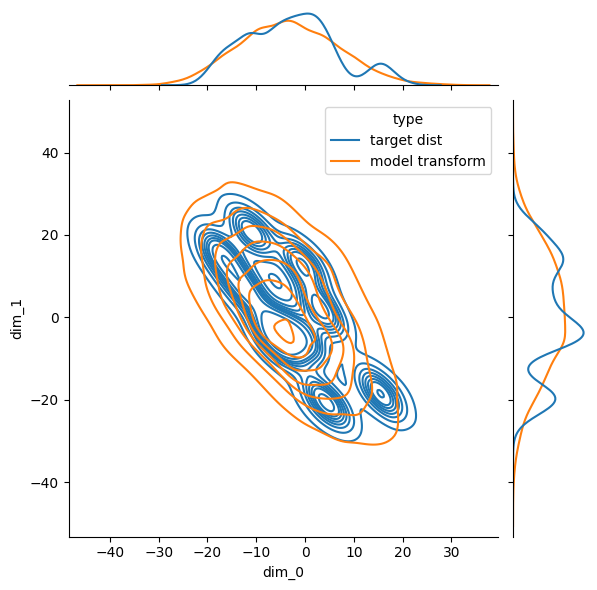

trail: 0 m step: 1 kl_test: 38.81155776977539


  2%|▏         | 100/6000 [00:32<35:17,  2.79it/s]

trail: 0 m step: 2 Loss: 32.8356990814209  L_n: 28.4997615814209  kld: 0.216796875 KLD1: 28.25311851501465 KLD2: 7.384090423583984


  3%|▎         | 200/6000 [01:04<34:13,  2.82it/s]

trail: 0 m step: 2 Loss: 32.37223815917969  L_n: 27.707855224609375  kld: 0.23321914672851562 KLD1: 27.502670288085938 KLD2: 7.296071529388428


  5%|▌         | 300/6000 [01:36<33:39,  2.82it/s]

trail: 0 m step: 2 Loss: 32.13614845275879  L_n: 27.534021377563477  kld: 0.23010635375976562 KLD1: 27.5211238861084 KLD2: 7.175034046173096


  7%|▋         | 400/6000 [02:08<33:15,  2.81it/s]

trail: 0 m step: 2 Loss: 31.76762580871582  L_n: 27.219324111938477  kld: 0.2274150848388672 KLD1: 27.513246536254883 KLD2: 7.09739351272583


  8%|▊         | 500/6000 [02:40<32:30,  2.82it/s]

trail: 0 m step: 2 Loss: 31.863595962524414  L_n: 26.89354133605957  kld: 0.2485027313232422 KLD1: 27.073917388916016 KLD2: 7.0993218421936035


 10%|█         | 600/6000 [03:12<31:54,  2.82it/s]

trail: 0 m step: 2 Loss: 32.38216781616211  L_n: 27.295536041259766  kld: 0.2543315887451172 KLD1: 26.78663444519043 KLD2: 7.093240261077881


 12%|█▏        | 700/6000 [03:44<31:20,  2.82it/s]

trail: 0 m step: 2 Loss: 32.01166534423828  L_n: 27.07159423828125  kld: 0.24700355529785156 KLD1: 27.059280395507812 KLD2: 7.033581256866455


 13%|█▎        | 800/6000 [04:17<30:40,  2.82it/s]

trail: 0 m step: 2 Loss: 32.121360778808594  L_n: 26.96930694580078  kld: 0.2576026916503906 KLD1: 26.929174423217773 KLD2: 7.042237281799316


 15%|█▌        | 900/6000 [04:49<30:14,  2.81it/s]

trail: 0 m step: 2 Loss: 31.931882858276367  L_n: 26.71375846862793  kld: 0.2609062194824219 KLD1: 26.57109260559082 KLD2: 7.040998458862305


 17%|█▋        | 1000/6000 [05:21<29:34,  2.82it/s]

trail: 0 m step: 2 Loss: 31.468935012817383  L_n: 26.54648780822754  kld: 0.2461223602294922 KLD1: 26.844886779785156 KLD2: 7.00217342376709


 18%|█▊        | 1100/6000 [05:53<28:54,  2.83it/s]

trail: 0 m step: 2 Loss: 31.789283752441406  L_n: 26.547279357910156  kld: 0.2621002197265625 KLD1: 26.455312728881836 KLD2: 6.988012313842773


 20%|██        | 1200/6000 [06:25<28:16,  2.83it/s]

trail: 0 m step: 2 Loss: 31.555740356445312  L_n: 26.397315979003906  kld: 0.2579212188720703 KLD1: 26.608623504638672 KLD2: 6.9889631271362305


 22%|██▏       | 1300/6000 [06:57<27:48,  2.82it/s]

trail: 0 m step: 2 Loss: 31.643653869628906  L_n: 26.71308135986328  kld: 0.24652862548828125 KLD1: 26.831357955932617 KLD2: 7.014075756072998


 23%|██▎       | 1400/6000 [07:29<27:14,  2.81it/s]

trail: 0 m step: 2 Loss: 31.793670654296875  L_n: 26.625900268554688  kld: 0.2583885192871094 KLD1: 26.465839385986328 KLD2: 6.930416107177734


 25%|██▌       | 1500/6000 [08:01<26:36,  2.82it/s]

trail: 0 m step: 2 Loss: 31.68521499633789  L_n: 26.54830551147461  kld: 0.25684547424316406 KLD1: 26.474506378173828 KLD2: 6.901334285736084


 27%|██▋       | 1600/6000 [08:33<26:02,  2.82it/s]

trail: 0 m step: 2 Loss: 31.9363956451416  L_n: 26.646516799926758  kld: 0.2644939422607422 KLD1: 26.344636917114258 KLD2: 6.912495136260986


 28%|██▊       | 1700/6000 [09:05<25:27,  2.82it/s]

trail: 0 m step: 2 Loss: 31.8802433013916  L_n: 26.85300636291504  kld: 0.2513618469238281 KLD1: 26.54888153076172 KLD2: 6.967348098754883


 30%|███       | 1800/6000 [09:37<24:52,  2.81it/s]

trail: 0 m step: 2 Loss: 31.590852737426758  L_n: 26.28716468811035  kld: 0.2651844024658203 KLD1: 26.266149520874023 KLD2: 6.896937370300293


 32%|███▏      | 1900/6000 [10:09<24:20,  2.81it/s]

trail: 0 m step: 2 Loss: 31.48025131225586  L_n: 26.157947540283203  kld: 0.2661151885986328 KLD1: 26.354406356811523 KLD2: 6.936845302581787


 33%|███▎      | 2000/6000 [10:41<23:42,  2.81it/s]

trail: 0 m step: 2 Loss: 31.467180252075195  L_n: 26.386423110961914  kld: 0.25403785705566406 KLD1: 26.50046157836914 KLD2: 6.930624961853027


 35%|███▌      | 2100/6000 [11:14<23:01,  2.82it/s]

trail: 0 m step: 2 Loss: 31.31993865966797  L_n: 25.97051239013672  kld: 0.2674713134765625 KLD1: 26.25242042541504 KLD2: 6.907501220703125


 37%|███▋      | 2200/6000 [11:46<22:31,  2.81it/s]

trail: 0 m step: 2 Loss: 31.49142837524414  L_n: 26.357074737548828  kld: 0.2567176818847656 KLD1: 26.47621726989746 KLD2: 6.920241355895996


 38%|███▊      | 2300/6000 [12:18<21:55,  2.81it/s]

trail: 0 m step: 2 Loss: 31.49947738647461  L_n: 26.185108184814453  kld: 0.2657184600830078 KLD1: 26.226511001586914 KLD2: 6.8716840744018555


 40%|████      | 2400/6000 [12:50<21:24,  2.80it/s]

trail: 0 m step: 2 Loss: 31.543231964111328  L_n: 26.323467254638672  kld: 0.2609882354736328 KLD1: 26.2670841217041 KLD2: 6.9111809730529785


 42%|████▏     | 2500/6000 [13:22<20:47,  2.81it/s]

trail: 0 m step: 2 Loss: 31.259859085083008  L_n: 26.17193031311035  kld: 0.2543964385986328 KLD1: 26.42578125 KLD2: 6.904042720794678


 43%|████▎     | 2600/6000 [13:54<20:08,  2.81it/s]

trail: 0 m step: 2 Loss: 31.5587215423584  L_n: 26.196401596069336  kld: 0.2681159973144531 KLD1: 26.120866775512695 KLD2: 6.867896556854248


 45%|████▌     | 2700/6000 [14:27<19:35,  2.81it/s]

trail: 0 m step: 2 Loss: 31.545114517211914  L_n: 26.17436408996582  kld: 0.2685375213623047 KLD1: 26.190397262573242 KLD2: 6.884340286254883


 47%|████▋     | 2800/6000 [14:59<18:53,  2.82it/s]

trail: 0 m step: 2 Loss: 31.52895164489746  L_n: 26.109067916870117  kld: 0.2709941864013672 KLD1: 26.17302131652832 KLD2: 6.9015727043151855


 48%|████▊     | 2900/6000 [15:31<18:22,  2.81it/s]

trail: 0 m step: 2 Loss: 31.872329711914062  L_n: 26.34990692138672  kld: 0.2761211395263672 KLD1: 25.980051040649414 KLD2: 6.88275146484375


 50%|█████     | 3000/6000 [16:03<17:45,  2.81it/s]

trail: 0 m step: 2 Loss: 31.652803421020508  L_n: 26.163110733032227  kld: 0.27448463439941406 KLD1: 26.0551700592041 KLD2: 6.850944995880127


 52%|█████▏    | 3100/6000 [16:35<17:15,  2.80it/s]

trail: 0 m step: 2 Loss: 31.281997680664062  L_n: 26.248123168945312  kld: 0.2516937255859375 KLD1: 26.483543395996094 KLD2: 6.85037088394165


 53%|█████▎    | 3200/6000 [17:08<16:36,  2.81it/s]

trail: 0 m step: 2 Loss: 31.909122467041016  L_n: 26.37674331665039  kld: 0.27661895751953125 KLD1: 26.0404109954834 KLD2: 6.823160648345947


 55%|█████▌    | 3300/6000 [17:40<16:03,  2.80it/s]

trail: 0 m step: 2 Loss: 31.579078674316406  L_n: 26.365379333496094  kld: 0.2606849670410156 KLD1: 26.237323760986328 KLD2: 6.847062110900879


 57%|█████▋    | 3400/6000 [18:12<15:23,  2.81it/s]

trail: 0 m step: 2 Loss: 31.269981384277344  L_n: 25.90979766845703  kld: 0.2680091857910156 KLD1: 26.179414749145508 KLD2: 6.876845359802246


 58%|█████▊    | 3500/6000 [18:44<14:45,  2.82it/s]

trail: 0 m step: 2 Loss: 31.47304344177246  L_n: 26.22760581970215  kld: 0.2622718811035156 KLD1: 26.229549407958984 KLD2: 6.887724876403809


 60%|██████    | 3600/6000 [19:16<14:16,  2.80it/s]

trail: 0 m step: 2 Loss: 31.328594207763672  L_n: 25.993663787841797  kld: 0.26674652099609375 KLD1: 26.17086410522461 KLD2: 6.916266441345215


 62%|██████▏   | 3700/6000 [19:48<13:35,  2.82it/s]

trail: 0 m step: 2 Loss: 31.43929672241211  L_n: 26.03512954711914  kld: 0.27020835876464844 KLD1: 26.00626564025879 KLD2: 6.854276180267334


 63%|██████▎   | 3800/6000 [20:20<13:02,  2.81it/s]

trail: 0 m step: 2 Loss: 31.29477882385254  L_n: 26.11491584777832  kld: 0.25899314880371094 KLD1: 26.282772064208984 KLD2: 6.8342671394348145


 65%|██████▌   | 3900/6000 [20:53<12:25,  2.82it/s]

trail: 0 m step: 2 Loss: 31.365535736083984  L_n: 25.882976531982422  kld: 0.2741279602050781 KLD1: 25.894773483276367 KLD2: 6.833779335021973


 67%|██████▋   | 4000/6000 [21:25<11:49,  2.82it/s]

trail: 0 m step: 2 Loss: 31.450714111328125  L_n: 25.922531127929688  kld: 0.2764091491699219 KLD1: 25.99643898010254 KLD2: 6.869650840759277


 68%|██████▊   | 4100/6000 [21:57<11:14,  2.82it/s]

trail: 0 m step: 2 Loss: 31.640583038330078  L_n: 25.993305206298828  kld: 0.2823638916015625 KLD1: 25.677377700805664 KLD2: 6.8429951667785645


 70%|███████   | 4200/6000 [22:29<10:39,  2.81it/s]

trail: 0 m step: 2 Loss: 31.224851608276367  L_n: 25.82289695739746  kld: 0.2700977325439453 KLD1: 26.034942626953125 KLD2: 6.846982479095459


 72%|███████▏  | 4300/6000 [23:01<10:02,  2.82it/s]

trail: 0 m step: 2 Loss: 31.39360237121582  L_n: 26.06328773498535  kld: 0.26651573181152344 KLD1: 26.139236450195312 KLD2: 6.8888421058654785


 73%|███████▎  | 4400/6000 [23:33<09:25,  2.83it/s]

trail: 0 m step: 2 Loss: 31.45679473876953  L_n: 25.98541259765625  kld: 0.27356910705566406 KLD1: 26.01053810119629 KLD2: 6.853701591491699


 75%|███████▌  | 4500/6000 [24:05<08:51,  2.82it/s]

trail: 0 m step: 2 Loss: 31.503650665283203  L_n: 26.09933090209961  kld: 0.2702159881591797 KLD1: 26.10344696044922 KLD2: 6.83898401260376


 77%|███████▋  | 4600/6000 [24:37<08:17,  2.81it/s]

trail: 0 m step: 2 Loss: 31.47199249267578  L_n: 26.03826141357422  kld: 0.2716865539550781 KLD1: 26.061748504638672 KLD2: 6.883362293243408


 78%|███████▊  | 4700/6000 [25:09<07:42,  2.81it/s]

trail: 0 m step: 2 Loss: 31.06903076171875  L_n: 25.882186889648438  kld: 0.2593421936035156 KLD1: 26.20168685913086 KLD2: 6.843676567077637


 80%|████████  | 4800/6000 [25:42<07:05,  2.82it/s]

trail: 0 m step: 2 Loss: 31.45750617980957  L_n: 26.18132209777832  kld: 0.2638092041015625 KLD1: 26.178224563598633 KLD2: 6.849173069000244


 82%|████████▏ | 4900/6000 [26:14<06:31,  2.81it/s]

trail: 0 m step: 2 Loss: 31.2899227142334  L_n: 26.0543270111084  kld: 0.26177978515625 KLD1: 26.260055541992188 KLD2: 6.838672637939453


 83%|████████▎ | 5000/6000 [26:46<05:55,  2.82it/s]

trail: 0 m step: 2 Loss: 31.58516502380371  L_n: 26.0437068939209  kld: 0.2770729064941406 KLD1: 25.892719268798828 KLD2: 6.851670265197754


 85%|████████▌ | 5100/6000 [27:18<05:20,  2.81it/s]

trail: 0 m step: 2 Loss: 31.06754493713379  L_n: 25.850412368774414  kld: 0.26085662841796875 KLD1: 26.169029235839844 KLD2: 6.870903015136719


 87%|████████▋ | 5200/6000 [27:50<04:43,  2.82it/s]

trail: 0 m step: 2 Loss: 31.412006378173828  L_n: 26.000896453857422  kld: 0.2705554962158203 KLD1: 26.055999755859375 KLD2: 6.867864608764648


 88%|████████▊ | 5300/6000 [28:22<04:09,  2.80it/s]

trail: 0 m step: 2 Loss: 31.49939727783203  L_n: 26.05590057373047  kld: 0.2721748352050781 KLD1: 25.94636344909668 KLD2: 6.827779293060303


 90%|█████████ | 5400/6000 [28:55<03:33,  2.81it/s]

trail: 0 m step: 2 Loss: 31.313579559326172  L_n: 26.00863265991211  kld: 0.2652473449707031 KLD1: 26.063339233398438 KLD2: 6.831834316253662


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.82it/s]

trail: 0 m step: 2 Loss: 31.534757614135742  L_n: 25.96125602722168  kld: 0.2786750793457031 KLD1: 25.86248207092285 KLD2: 6.826985836029053


 93%|█████████▎| 5600/6000 [29:59<02:22,  2.81it/s]

trail: 0 m step: 2 Loss: 31.78553009033203  L_n: 26.217025756835938  kld: 0.2784252166748047 KLD1: 25.95807456970215 KLD2: 6.825424671173096


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.81it/s]

trail: 0 m step: 2 Loss: 31.525285720825195  L_n: 26.11394691467285  kld: 0.2705669403076172 KLD1: 26.014802932739258 KLD2: 6.864957809448242


 97%|█████████▋| 5800/6000 [31:03<01:10,  2.82it/s]

trail: 0 m step: 2 Loss: 31.40278434753418  L_n: 26.00178337097168  kld: 0.270050048828125 KLD1: 25.950077056884766 KLD2: 6.825955867767334


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.81it/s]

trail: 0 m step: 2 Loss: 31.317462921142578  L_n: 25.894031524658203  kld: 0.27117156982421875 KLD1: 25.92603302001953 KLD2: 6.856367111206055


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 2 Loss: 31.284473419189453  L_n: 25.714481353759766  kld: 0.2784996032714844 KLD1: 25.733875274658203 KLD2: 6.854945182800293



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


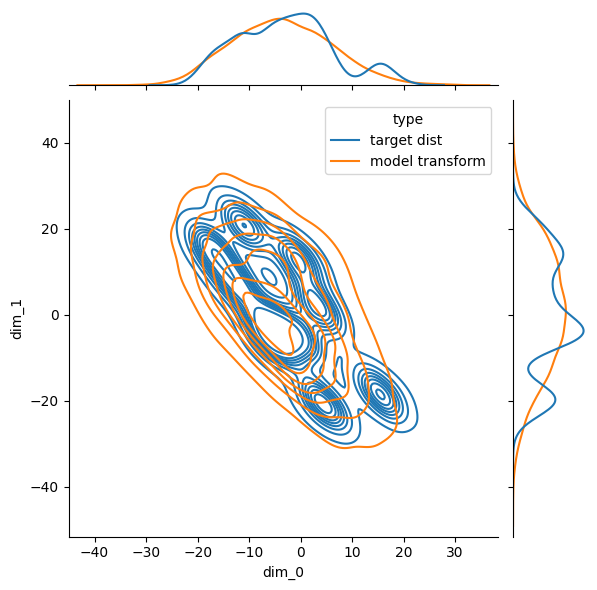

trail: 0 m step: 2 kl_test: 26.204059600830078


  2%|▏         | 100/6000 [00:32<35:15,  2.79it/s]

trail: 0 m step: 3 Loss: 22.764375686645508  L_n: 20.080278396606445  kld: 0.13420486450195312 KLD1: 19.87574577331543 KLD2: 5.8684282302856445


  3%|▎         | 200/6000 [01:04<34:16,  2.82it/s]

trail: 0 m step: 3 Loss: 22.458221435546875  L_n: 19.624053955078125  kld: 0.1417083740234375 KLD1: 19.457029342651367 KLD2: 5.823344707489014


  5%|▌         | 300/6000 [01:36<33:48,  2.81it/s]

trail: 0 m step: 3 Loss: 22.421463012695312  L_n: 19.588096618652344  kld: 0.14166831970214844 KLD1: 19.440990447998047 KLD2: 5.722650527954102


  7%|▋         | 400/6000 [02:08<33:27,  2.79it/s]

trail: 0 m step: 3 Loss: 21.989938735961914  L_n: 19.329225540161133  kld: 0.13303565979003906 KLD1: 19.617687225341797 KLD2: 5.6887359619140625


  8%|▊         | 500/6000 [02:40<32:32,  2.82it/s]

trail: 0 m step: 3 Loss: 22.170724868774414  L_n: 19.1353702545166  kld: 0.15176773071289062 KLD1: 19.278701782226562 KLD2: 5.700458526611328


 10%|█         | 600/6000 [03:13<32:11,  2.80it/s]

trail: 0 m step: 3 Loss: 22.48679542541504  L_n: 19.38834571838379  kld: 0.1549224853515625 KLD1: 19.114181518554688 KLD2: 5.70634126663208


 12%|█▏        | 700/6000 [03:45<31:32,  2.80it/s]

trail: 0 m step: 3 Loss: 22.329421997070312  L_n: 19.362083435058594  kld: 0.14836692810058594 KLD1: 19.313451766967773 KLD2: 5.6524505615234375


 13%|█▎        | 800/6000 [04:17<30:56,  2.80it/s]

trail: 0 m step: 3 Loss: 22.364883422851562  L_n: 19.303016662597656  kld: 0.1530933380126953 KLD1: 19.199522018432617 KLD2: 5.686357021331787


 15%|█▌        | 900/6000 [04:49<30:21,  2.80it/s]

trail: 0 m step: 3 Loss: 22.211763381958008  L_n: 19.10099220275879  kld: 0.15553855895996094 KLD1: 19.035964965820312 KLD2: 5.688543319702148


 17%|█▋        | 1000/6000 [05:22<29:41,  2.81it/s]

trail: 0 m step: 3 Loss: 21.860307693481445  L_n: 18.878740310668945  kld: 0.149078369140625 KLD1: 19.124000549316406 KLD2: 5.645793437957764


 18%|█▊        | 1100/6000 [05:54<29:03,  2.81it/s]

trail: 0 m step: 3 Loss: 22.07170867919922  L_n: 18.949874877929688  kld: 0.15609169006347656 KLD1: 18.990554809570312 KLD2: 5.651187896728516


 20%|██        | 1200/6000 [06:26<28:34,  2.80it/s]

trail: 0 m step: 3 Loss: 22.01592445373535  L_n: 18.836870193481445  kld: 0.1589527130126953 KLD1: 18.969371795654297 KLD2: 5.6428117752075195


 22%|██▏       | 1300/6000 [06:58<28:01,  2.79it/s]

trail: 0 m step: 3 Loss: 22.0401554107666  L_n: 19.10325813293457  kld: 0.14684486389160156 KLD1: 19.169673919677734 KLD2: 5.674798011779785


 23%|██▎       | 1400/6000 [07:31<27:17,  2.81it/s]

trail: 0 m step: 3 Loss: 22.245582580566406  L_n: 19.124969482421875  kld: 0.15603065490722656 KLD1: 18.896780014038086 KLD2: 5.605792045593262


 25%|██▌       | 1500/6000 [08:03<26:43,  2.81it/s]

trail: 0 m step: 3 Loss: 22.09862518310547  L_n: 19.004867553710938  kld: 0.15468788146972656 KLD1: 18.89890480041504 KLD2: 5.581517219543457


 27%|██▋       | 1600/6000 [08:35<26:08,  2.81it/s]

trail: 0 m step: 3 Loss: 22.23518180847168  L_n: 19.047239303588867  kld: 0.15939712524414062 KLD1: 18.83285903930664 KLD2: 5.598097324371338


 28%|██▊       | 1700/6000 [09:07<25:22,  2.83it/s]

trail: 0 m step: 3 Loss: 22.26879119873047  L_n: 19.296913146972656  kld: 0.14859390258789062 KLD1: 19.009830474853516 KLD2: 5.647061347961426


 30%|███       | 1800/6000 [09:39<24:53,  2.81it/s]

trail: 0 m step: 3 Loss: 22.003360748291016  L_n: 18.826709747314453  kld: 0.15883255004882812 KLD1: 18.754287719726562 KLD2: 5.584958553314209


 32%|███▏      | 1900/6000 [10:11<24:14,  2.82it/s]

trail: 0 m step: 3 Loss: 21.932628631591797  L_n: 18.784320831298828  kld: 0.15741539001464844 KLD1: 18.91693115234375 KLD2: 5.631221294403076


 33%|███▎      | 2000/6000 [10:43<23:36,  2.82it/s]

trail: 0 m step: 3 Loss: 21.889543533325195  L_n: 18.837976455688477  kld: 0.15257835388183594 KLD1: 19.00814437866211 KLD2: 5.619675636291504


 35%|███▌      | 2100/6000 [11:16<23:11,  2.80it/s]

trail: 0 m step: 3 Loss: 21.8944034576416  L_n: 18.625131607055664  kld: 0.16346359252929688 KLD1: 18.657894134521484 KLD2: 5.603427410125732


 37%|███▋      | 2200/6000 [11:48<22:33,  2.81it/s]

trail: 0 m step: 3 Loss: 21.975553512573242  L_n: 18.870656967163086  kld: 0.1552448272705078 KLD1: 18.87851905822754 KLD2: 5.607702255249023


 38%|███▊      | 2300/6000 [12:20<21:57,  2.81it/s]

trail: 0 m step: 3 Loss: 21.990320205688477  L_n: 18.796236038208008  kld: 0.15970420837402344 KLD1: 18.73356056213379 KLD2: 5.5700459480285645


 40%|████      | 2400/6000 [12:52<21:24,  2.80it/s]

trail: 0 m step: 3 Loss: 21.96992301940918  L_n: 18.858922958374023  kld: 0.1555500030517578 KLD1: 18.840848922729492 KLD2: 5.606864929199219


 42%|████▏     | 2500/6000 [13:24<20:42,  2.82it/s]

trail: 0 m step: 3 Loss: 21.724626541137695  L_n: 18.703500747680664  kld: 0.15105628967285156 KLD1: 18.898561477661133 KLD2: 5.60017728805542


 43%|████▎     | 2600/6000 [13:57<20:08,  2.81it/s]

trail: 0 m step: 3 Loss: 21.970075607299805  L_n: 18.743947982788086  kld: 0.16130638122558594 KLD1: 18.70121192932129 KLD2: 5.56995153427124


 45%|████▌     | 2700/6000 [14:29<19:35,  2.81it/s]

trail: 0 m step: 3 Loss: 21.944345474243164  L_n: 18.770708084106445  kld: 0.15868186950683594 KLD1: 18.730987548828125 KLD2: 5.5949201583862305


 47%|████▋     | 2800/6000 [15:01<18:58,  2.81it/s]

trail: 0 m step: 3 Loss: 21.940885543823242  L_n: 18.660131454467773  kld: 0.16403770446777344 KLD1: 18.765247344970703 KLD2: 5.597829341888428


 48%|████▊     | 2900/6000 [15:33<18:18,  2.82it/s]

trail: 0 m step: 3 Loss: 22.21701431274414  L_n: 18.876789093017578  kld: 0.16701126098632812 KLD1: 18.62359619140625 KLD2: 5.588817596435547


 50%|█████     | 3000/6000 [16:05<17:46,  2.81it/s]

trail: 0 m step: 3 Loss: 22.033145904541016  L_n: 18.73526382446289  kld: 0.16489410400390625 KLD1: 18.711612701416016 KLD2: 5.560183048248291


 52%|█████▏    | 3100/6000 [16:37<17:10,  2.81it/s]

trail: 0 m step: 3 Loss: 21.754791259765625  L_n: 18.78058624267578  kld: 0.1487102508544922 KLD1: 18.988937377929688 KLD2: 5.5500922203063965


 53%|█████▎    | 3200/6000 [17:09<16:32,  2.82it/s]

trail: 0 m step: 3 Loss: 22.213661193847656  L_n: 18.858673095703125  kld: 0.16774940490722656 KLD1: 18.65046501159668 KLD2: 5.530081748962402


 55%|█████▌    | 3300/6000 [17:42<15:55,  2.82it/s]

trail: 0 m step: 3 Loss: 22.02140235900879  L_n: 18.839906692504883  kld: 0.1590747833251953 KLD1: 18.728206634521484 KLD2: 5.546127796173096


 57%|█████▋    | 3400/6000 [18:14<15:26,  2.81it/s]

trail: 0 m step: 3 Loss: 21.71956443786621  L_n: 18.48744773864746  kld: 0.1616058349609375 KLD1: 18.740215301513672 KLD2: 5.583148956298828


 58%|█████▊    | 3500/6000 [18:46<14:46,  2.82it/s]

trail: 0 m step: 3 Loss: 22.000324249267578  L_n: 18.85312271118164  kld: 0.15736007690429688 KLD1: 18.82439422607422 KLD2: 5.596660614013672


 60%|██████    | 3600/6000 [19:18<14:13,  2.81it/s]

trail: 0 m step: 3 Loss: 21.81732177734375  L_n: 18.641357421875  kld: 0.1587982177734375 KLD1: 18.7877254486084 KLD2: 5.621994972229004


 62%|██████▏   | 3700/6000 [19:50<13:35,  2.82it/s]

trail: 0 m step: 3 Loss: 21.87432289123535  L_n: 18.602304458618164  kld: 0.16360092163085938 KLD1: 18.632797241210938 KLD2: 5.5658345222473145


 63%|██████▎   | 3800/6000 [20:22<12:58,  2.83it/s]

trail: 0 m step: 3 Loss: 21.810871124267578  L_n: 18.763690948486328  kld: 0.1523590087890625 KLD1: 18.91320037841797 KLD2: 5.554067134857178


 65%|██████▌   | 3900/6000 [20:54<12:26,  2.81it/s]

trail: 0 m step: 3 Loss: 21.82196807861328  L_n: 18.535720825195312  kld: 0.16431236267089844 KLD1: 18.547985076904297 KLD2: 5.544954299926758


 67%|██████▋   | 4000/6000 [21:27<11:50,  2.81it/s]

trail: 0 m step: 3 Loss: 21.915023803710938  L_n: 18.556602478027344  kld: 0.1679210662841797 KLD1: 18.62676239013672 KLD2: 5.57586145401001


 68%|██████▊   | 4100/6000 [21:59<11:17,  2.80it/s]

trail: 0 m step: 3 Loss: 22.09833335876465  L_n: 18.626005172729492  kld: 0.1736164093017578 KLD1: 18.333330154418945 KLD2: 5.556342601776123


 70%|███████   | 4200/6000 [22:31<10:38,  2.82it/s]

trail: 0 m step: 3 Loss: 21.786827087402344  L_n: 18.54681396484375  kld: 0.1620006561279297 KLD1: 18.7243709564209 KLD2: 5.562067031860352


 72%|███████▏  | 4300/6000 [23:03<10:06,  2.80it/s]

trail: 0 m step: 3 Loss: 21.92413902282715  L_n: 18.726964950561523  kld: 0.15985870361328125 KLD1: 18.71181869506836 KLD2: 5.602607727050781


 73%|███████▎  | 4400/6000 [23:35<09:27,  2.82it/s]

trail: 0 m step: 3 Loss: 21.88998031616211  L_n: 18.56985855102539  kld: 0.16600608825683594 KLD1: 18.631624221801758 KLD2: 5.564900875091553


 75%|███████▌  | 4500/6000 [24:07<08:53,  2.81it/s]

trail: 0 m step: 3 Loss: 21.914440155029297  L_n: 18.67507553100586  kld: 0.16196823120117188 KLD1: 18.72682762145996 KLD2: 5.550755500793457


 77%|███████▋  | 4600/6000 [24:39<08:17,  2.81it/s]

trail: 0 m step: 3 Loss: 21.881576538085938  L_n: 18.621116638183594  kld: 0.1630229949951172 KLD1: 18.678361892700195 KLD2: 5.596503257751465


 78%|███████▊  | 4700/6000 [25:12<07:40,  2.82it/s]

trail: 0 m step: 3 Loss: 21.562145233154297  L_n: 18.50222396850586  kld: 0.15299606323242188 KLD1: 18.84100914001465 KLD2: 5.561895847320557


 80%|████████  | 4800/6000 [25:44<07:06,  2.82it/s]

trail: 0 m step: 3 Loss: 21.95256805419922  L_n: 18.760963439941406  kld: 0.15958023071289062 KLD1: 18.681102752685547 KLD2: 5.560038089752197


 82%|████████▏ | 4900/6000 [26:16<06:31,  2.81it/s]

trail: 0 m step: 3 Loss: 21.770700454711914  L_n: 18.661760330200195  kld: 0.15544700622558594 KLD1: 18.830476760864258 KLD2: 5.556338310241699


 83%|████████▎ | 5000/6000 [26:48<05:54,  2.82it/s]

trail: 0 m step: 3 Loss: 22.049299240112305  L_n: 18.719640731811523  kld: 0.16648292541503906 KLD1: 18.605384826660156 KLD2: 5.571652889251709


 85%|████████▌ | 5100/6000 [27:20<05:20,  2.81it/s]

trail: 0 m step: 3 Loss: 21.633516311645508  L_n: 18.479639053344727  kld: 0.15769386291503906 KLD1: 18.757246017456055 KLD2: 5.583770275115967


 87%|████████▋ | 5200/6000 [27:52<04:44,  2.81it/s]

trail: 0 m step: 3 Loss: 21.927528381347656  L_n: 18.652076721191406  kld: 0.1637725830078125 KLD1: 18.615446090698242 KLD2: 5.582265377044678


 88%|████████▊ | 5300/6000 [28:25<04:09,  2.81it/s]

trail: 0 m step: 3 Loss: 21.916662216186523  L_n: 18.61908531188965  kld: 0.16487884521484375 KLD1: 18.529924392700195 KLD2: 5.545779228210449


 90%|█████████ | 5400/6000 [28:57<03:33,  2.81it/s]

trail: 0 m step: 3 Loss: 21.891094207763672  L_n: 18.730846405029297  kld: 0.15801239013671875 KLD1: 18.74185562133789 KLD2: 5.551248073577881


 92%|█████████▏| 5500/6000 [29:29<02:58,  2.81it/s]

trail: 0 m step: 3 Loss: 21.939489364624023  L_n: 18.598730087280273  kld: 0.1670379638671875 KLD1: 18.557817459106445 KLD2: 5.551645755767822


 93%|█████████▎| 5600/6000 [30:01<02:22,  2.80it/s]

trail: 0 m step: 3 Loss: 22.159961700439453  L_n: 18.809207916259766  kld: 0.16753768920898438 KLD1: 18.664228439331055 KLD2: 5.545717239379883


 95%|█████████▌| 5700/6000 [30:33<01:46,  2.81it/s]

trail: 0 m step: 3 Loss: 21.958181381225586  L_n: 18.69905662536621  kld: 0.16295623779296875 KLD1: 18.61012840270996 KLD2: 5.581106185913086


 97%|█████████▋| 5800/6000 [31:06<01:11,  2.81it/s]

trail: 0 m step: 3 Loss: 21.91424560546875  L_n: 18.67236328125  kld: 0.1620941162109375 KLD1: 18.618436813354492 KLD2: 5.545241355895996


 98%|█████████▊| 5900/6000 [31:38<00:35,  2.80it/s]

trail: 0 m step: 3 Loss: 21.819805145263672  L_n: 18.525432586669922  kld: 0.1647186279296875 KLD1: 18.529346466064453 KLD2: 5.573957443237305


100%|██████████| 6000/6000 [32:10<00:00,  3.11it/s]

trail: 0 m step: 3 Loss: 21.823991775512695  L_n: 18.409074783325195  kld: 0.170745849609375 KLD1: 18.41949462890625 KLD2: 5.570368766784668



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


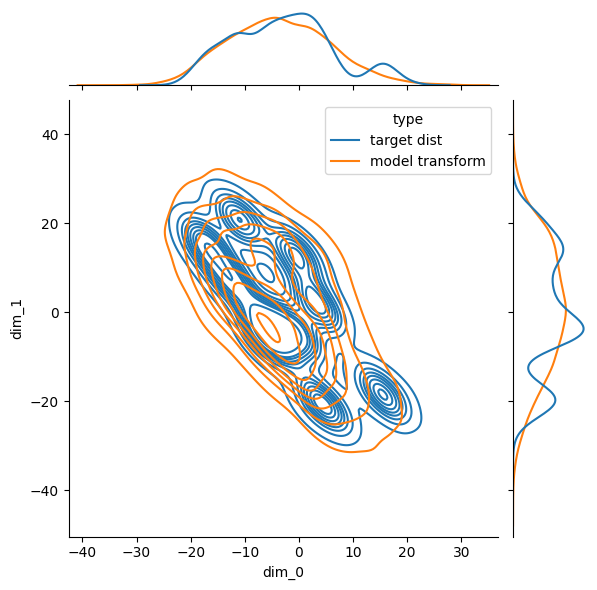

trail: 0 m step: 3 kl_test: 18.743215560913086


  2%|▏         | 100/6000 [00:32<35:01,  2.81it/s]

trail: 0 m step: 4 Loss: 16.584835052490234  L_n: 14.831066131591797  kld: 0.08768844604492188 KLD1: 14.68801498413086 KLD2: 4.795620441436768


  3%|▎         | 200/6000 [01:04<34:10,  2.83it/s]

trail: 0 m step: 4 Loss: 16.44056510925293  L_n: 14.655248641967773  kld: 0.08926582336425781 KLD1: 14.422687530517578 KLD2: 4.785606861114502


  5%|▌         | 300/6000 [01:36<33:43,  2.82it/s]

trail: 0 m step: 4 Loss: 16.38590431213379  L_n: 14.508768081665039  kld: 0.0938568115234375 KLD1: 14.401671409606934 KLD2: 4.691008567810059


  7%|▋         | 400/6000 [02:08<33:16,  2.80it/s]

trail: 0 m step: 4 Loss: 16.004051208496094  L_n: 14.322227478027344  kld: 0.0840911865234375 KLD1: 14.567811965942383 KLD2: 4.6778645515441895


  8%|▊         | 500/6000 [02:40<32:35,  2.81it/s]

trail: 0 m step: 4 Loss: 16.16428565979004  L_n: 14.185907363891602  kld: 0.09891891479492188 KLD1: 14.28091812133789 KLD2: 4.693382740020752


 10%|█         | 600/6000 [03:12<32:03,  2.81it/s]

trail: 0 m step: 4 Loss: 16.44746208190918  L_n: 14.401067733764648  kld: 0.10231971740722656 KLD1: 14.176701545715332 KLD2: 4.700179576873779


 12%|█▏        | 700/6000 [03:44<31:16,  2.82it/s]

trail: 0 m step: 4 Loss: 16.262245178222656  L_n: 14.318084716796875  kld: 0.09720802307128906 KLD1: 14.325411796569824 KLD2: 4.6540045738220215


 13%|█▎        | 800/6000 [04:16<30:37,  2.83it/s]

trail: 0 m step: 4 Loss: 16.248939514160156  L_n: 14.253013610839844  kld: 0.09979629516601562 KLD1: 14.243226051330566 KLD2: 4.684600830078125


 15%|█▌        | 900/6000 [04:49<30:08,  2.82it/s]

trail: 0 m step: 4 Loss: 16.214401245117188  L_n: 14.18902587890625  kld: 0.10126876831054688 KLD1: 14.153952598571777 KLD2: 4.694480895996094


 17%|█▋        | 1000/6000 [05:21<29:32,  2.82it/s]

trail: 0 m step: 4 Loss: 15.971765518188477  L_n: 14.051828384399414  kld: 0.09599685668945312 KLD1: 14.200597763061523 KLD2: 4.6636223793029785


 18%|█▊        | 1100/6000 [05:53<29:02,  2.81it/s]

trail: 0 m step: 4 Loss: 16.07982635498047  L_n: 14.061775207519531  kld: 0.10090255737304688 KLD1: 14.211684226989746 KLD2: 4.668913841247559


 20%|██        | 1200/6000 [06:25<28:24,  2.82it/s]

trail: 0 m step: 4 Loss: 16.116819381713867  L_n: 14.033536911010742  kld: 0.10416412353515625 KLD1: 14.110530853271484 KLD2: 4.668788909912109


 22%|██▏       | 1300/6000 [06:57<27:47,  2.82it/s]

trail: 0 m step: 4 Loss: 16.062450408935547  L_n: 14.163951873779297  kld: 0.0949249267578125 KLD1: 14.244415283203125 KLD2: 4.6929802894592285


 23%|██▎       | 1400/6000 [07:29<27:10,  2.82it/s]

trail: 0 m step: 4 Loss: 16.295516967773438  L_n: 14.205711364746094  kld: 0.10449028015136719 KLD1: 13.993246078491211 KLD2: 4.620538711547852


 25%|██▌       | 1500/6000 [08:01<26:39,  2.81it/s]

trail: 0 m step: 4 Loss: 16.13656997680664  L_n: 14.11367416381836  kld: 0.10114479064941406 KLD1: 14.104063987731934 KLD2: 4.608144283294678


 27%|██▋       | 1600/6000 [08:33<25:52,  2.83it/s]

trail: 0 m step: 4 Loss: 16.24001693725586  L_n: 14.175769805908203  kld: 0.10321235656738281 KLD1: 14.033988952636719 KLD2: 4.628386497497559


 28%|██▊       | 1700/6000 [09:05<25:22,  2.82it/s]

trail: 0 m step: 4 Loss: 16.317991256713867  L_n: 14.381307601928711  kld: 0.09683418273925781 KLD1: 14.1956148147583 KLD2: 4.669889450073242


 30%|███       | 1800/6000 [09:37<24:49,  2.82it/s]

trail: 0 m step: 4 Loss: 16.051183700561523  L_n: 13.986555099487305  kld: 0.10323143005371094 KLD1: 13.983599662780762 KLD2: 4.6204938888549805


 32%|███▏      | 1900/6000 [10:09<24:14,  2.82it/s]

trail: 0 m step: 4 Loss: 16.063507080078125  L_n: 14.0028076171875  kld: 0.10303497314453125 KLD1: 14.06814956665039 KLD2: 4.661483287811279


 33%|███▎      | 2000/6000 [10:41<23:38,  2.82it/s]

trail: 0 m step: 4 Loss: 16.006439208984375  L_n: 14.031570434570312  kld: 0.09874343872070312 KLD1: 14.138179779052734 KLD2: 4.645952224731445


 35%|███▌      | 2100/6000 [11:14<23:03,  2.82it/s]

trail: 0 m step: 4 Loss: 16.056772232055664  L_n: 13.906770706176758  kld: 0.10750007629394531 KLD1: 13.8366117477417 KLD2: 4.636684417724609


 37%|███▋      | 2200/6000 [11:46<22:29,  2.82it/s]

trail: 0 m step: 4 Loss: 16.063220977783203  L_n: 14.037960052490234  kld: 0.10126304626464844 KLD1: 14.037896156311035 KLD2: 4.63865852355957


 38%|███▊      | 2300/6000 [12:18<21:50,  2.82it/s]

trail: 0 m step: 4 Loss: 16.048429489135742  L_n: 13.963964462280273  kld: 0.10422325134277344 KLD1: 13.964208602905273 KLD2: 4.603459358215332


 40%|████      | 2400/6000 [12:50<21:19,  2.81it/s]

trail: 0 m step: 4 Loss: 16.094341278076172  L_n: 14.095325469970703  kld: 0.09995079040527344 KLD1: 14.081024169921875 KLD2: 4.637187480926514


 42%|████▏     | 2500/6000 [13:22<20:39,  2.82it/s]

trail: 0 m step: 4 Loss: 15.88581657409668  L_n: 13.979497909545898  kld: 0.09531593322753906 KLD1: 14.13439655303955 KLD2: 4.635766506195068


 43%|████▎     | 2600/6000 [13:54<20:02,  2.83it/s]

trail: 0 m step: 4 Loss: 16.05318260192871  L_n: 13.931638717651367  kld: 0.10607719421386719 KLD1: 13.89953899383545 KLD2: 4.602969646453857


 45%|████▌     | 2700/6000 [14:26<19:27,  2.83it/s]

trail: 0 m step: 4 Loss: 16.06435775756836  L_n: 14.031352996826172  kld: 0.10165023803710938 KLD1: 13.973408699035645 KLD2: 4.634472846984863


 47%|████▋     | 2800/6000 [14:58<19:00,  2.80it/s]

trail: 0 m step: 4 Loss: 16.00711441040039  L_n: 13.90048599243164  kld: 0.1053314208984375 KLD1: 13.997572898864746 KLD2: 4.63446569442749


 48%|████▊     | 2900/6000 [15:30<18:20,  2.82it/s]

trail: 0 m step: 4 Loss: 16.264572143554688  L_n: 14.083137512207031  kld: 0.10907173156738281 KLD1: 13.866729736328125 KLD2: 4.627627372741699


 50%|█████     | 3000/6000 [16:02<17:45,  2.81it/s]

trail: 0 m step: 4 Loss: 16.118144989013672  L_n: 13.982524871826172  kld: 0.106781005859375 KLD1: 13.946529388427734 KLD2: 4.597381114959717


 52%|█████▏    | 3100/6000 [16:34<17:04,  2.83it/s]

trail: 0 m step: 4 Loss: 15.900596618652344  L_n: 14.000343322753906  kld: 0.09501266479492188 KLD1: 14.16596508026123 KLD2: 4.586276054382324


 53%|█████▎    | 3200/6000 [17:06<16:32,  2.82it/s]

trail: 0 m step: 4 Loss: 16.23472785949707  L_n: 14.037500381469727  kld: 0.10986137390136719 KLD1: 13.901134490966797 KLD2: 4.569360256195068


 55%|█████▌    | 3300/6000 [17:38<16:00,  2.81it/s]

trail: 0 m step: 4 Loss: 16.115108489990234  L_n: 14.045291900634766  kld: 0.10349082946777344 KLD1: 13.936548233032227 KLD2: 4.584959983825684


 57%|█████▋    | 3400/6000 [18:11<15:21,  2.82it/s]

trail: 0 m step: 4 Loss: 15.863927841186523  L_n: 13.750165939331055  kld: 0.10568809509277344 KLD1: 13.956521987915039 KLD2: 4.621895790100098


 58%|█████▊    | 3500/6000 [18:43<14:48,  2.81it/s]

trail: 0 m step: 4 Loss: 16.127988815307617  L_n: 14.093496322631836  kld: 0.10172462463378906 KLD1: 13.996249198913574 KLD2: 4.636277675628662


 60%|██████    | 3600/6000 [19:15<14:11,  2.82it/s]

trail: 0 m step: 4 Loss: 15.889047622680664  L_n: 13.849786758422852  kld: 0.10196304321289062 KLD1: 14.063940048217773 KLD2: 4.657345771789551


 62%|██████▏   | 3700/6000 [19:47<13:32,  2.83it/s]

trail: 0 m step: 4 Loss: 15.934179306030273  L_n: 13.825872421264648  kld: 0.10541534423828125 KLD1: 13.883524894714355 KLD2: 4.608973503112793


 63%|██████▎   | 3800/6000 [20:19<13:00,  2.82it/s]

trail: 0 m step: 4 Loss: 15.92333984375  L_n: 13.996536254882812  kld: 0.09634017944335938 KLD1: 14.145814895629883 KLD2: 4.593115329742432


 65%|██████▌   | 3900/6000 [20:51<12:26,  2.81it/s]

trail: 0 m step: 4 Loss: 15.946086883544922  L_n: 13.793338775634766  kld: 0.10763740539550781 KLD1: 13.84492301940918 KLD2: 4.5842461585998535


 67%|██████▋   | 4000/6000 [21:23<11:49,  2.82it/s]

trail: 0 m step: 4 Loss: 16.071117401123047  L_n: 13.854740142822266  kld: 0.11081886291503906 KLD1: 13.869977951049805 KLD2: 4.611714839935303


 68%|██████▊   | 4100/6000 [21:55<11:12,  2.82it/s]

trail: 0 m step: 4 Loss: 16.144758224487305  L_n: 13.865819931030273  kld: 0.11394691467285156 KLD1: 13.640877723693848 KLD2: 4.5963311195373535


 70%|███████   | 4200/6000 [22:27<10:40,  2.81it/s]

trail: 0 m step: 4 Loss: 15.89600944519043  L_n: 13.821157455444336  kld: 0.10374259948730469 KLD1: 14.013936996459961 KLD2: 4.60502815246582


 72%|███████▏  | 4300/6000 [22:59<10:02,  2.82it/s]

trail: 0 m step: 4 Loss: 16.055727005004883  L_n: 13.980226516723633  kld: 0.1037750244140625 KLD1: 13.989633560180664 KLD2: 4.6406402587890625


 73%|███████▎  | 4400/6000 [23:31<09:28,  2.82it/s]

trail: 0 m step: 4 Loss: 15.980096817016602  L_n: 13.804040908813477  kld: 0.10880279541015625 KLD1: 13.833840370178223 KLD2: 4.604278564453125


 75%|███████▌  | 4500/6000 [24:03<08:49,  2.83it/s]

trail: 0 m step: 4 Loss: 16.02124786376953  L_n: 13.913780212402344  kld: 0.10537338256835938 KLD1: 13.898493766784668 KLD2: 4.59146785736084


 77%|███████▋  | 4600/6000 [24:35<08:15,  2.82it/s]

trail: 0 m step: 4 Loss: 15.963550567626953  L_n: 13.85074234008789  kld: 0.10564041137695312 KLD1: 13.9724760055542 KLD2: 4.6392340660095215


 78%|███████▊  | 4700/6000 [25:07<07:40,  2.82it/s]

trail: 0 m step: 4 Loss: 15.73769760131836  L_n: 13.780452728271484  kld: 0.09786224365234375 KLD1: 14.05774974822998 KLD2: 4.605821132659912


 80%|████████  | 4800/6000 [25:39<07:04,  2.83it/s]

trail: 0 m step: 4 Loss: 16.08669662475586  L_n: 14.02389907836914  kld: 0.10313987731933594 KLD1: 13.90225887298584 KLD2: 4.600963115692139


 82%|████████▏ | 4900/6000 [26:11<06:28,  2.83it/s]

trail: 0 m step: 4 Loss: 15.895915985107422  L_n: 13.884273529052734  kld: 0.10058212280273438 KLD1: 13.991443634033203 KLD2: 4.597458839416504


 83%|████████▎ | 5000/6000 [26:43<05:54,  2.82it/s]

trail: 0 m step: 4 Loss: 16.083314895629883  L_n: 13.936822891235352  kld: 0.10732460021972656 KLD1: 13.875269889831543 KLD2: 4.616159915924072


 85%|████████▌ | 5100/6000 [27:15<05:19,  2.82it/s]

trail: 0 m step: 4 Loss: 15.743267059326172  L_n: 13.70644760131836  kld: 0.10184097290039062 KLD1: 13.971163749694824 KLD2: 4.622798919677734


 87%|████████▋ | 5200/6000 [27:48<04:43,  2.82it/s]

trail: 0 m step: 4 Loss: 16.001863479614258  L_n: 13.862619400024414  kld: 0.10696220397949219 KLD1: 13.797842979431152 KLD2: 4.620566368103027


 88%|████████▊ | 5300/6000 [28:20<04:10,  2.80it/s]

trail: 0 m step: 4 Loss: 15.977684020996094  L_n: 13.831878662109375  kld: 0.10729026794433594 KLD1: 13.810035705566406 KLD2: 4.588855743408203


 90%|█████████ | 5400/6000 [28:52<03:32,  2.83it/s]

trail: 0 m step: 4 Loss: 16.008460998535156  L_n: 13.975532531738281  kld: 0.10164642333984375 KLD1: 14.018579483032227 KLD2: 4.593141078948975


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.82it/s]

trail: 0 m step: 4 Loss: 16.0472469329834  L_n: 13.885305404663086  kld: 0.10809707641601562 KLD1: 13.802355766296387 KLD2: 4.5992231369018555


 93%|█████████▎| 5600/6000 [29:56<02:21,  2.82it/s]

trail: 0 m step: 4 Loss: 16.153297424316406  L_n: 13.995628356933594  kld: 0.10788345336914062 KLD1: 13.931024551391602 KLD2: 4.589775085449219


 95%|█████████▌| 5700/6000 [30:28<01:46,  2.82it/s]

trail: 0 m step: 4 Loss: 16.013090133666992  L_n: 13.918401718139648  kld: 0.10473442077636719 KLD1: 13.880074501037598 KLD2: 4.622436046600342


 97%|█████████▋| 5800/6000 [31:00<01:10,  2.82it/s]

trail: 0 m step: 4 Loss: 16.030275344848633  L_n: 13.930055618286133  kld: 0.105010986328125 KLD1: 13.896169662475586 KLD2: 4.588951587677002


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.82it/s]

trail: 0 m step: 4 Loss: 16.014436721801758  L_n: 13.819040298461914  kld: 0.10976982116699219 KLD1: 13.802621841430664 KLD2: 4.6128764152526855


100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

trail: 0 m step: 4 Loss: 15.931303024291992  L_n: 13.714048385620117  kld: 0.11086273193359375 KLD1: 13.779918670654297 KLD2: 4.612111568450928



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


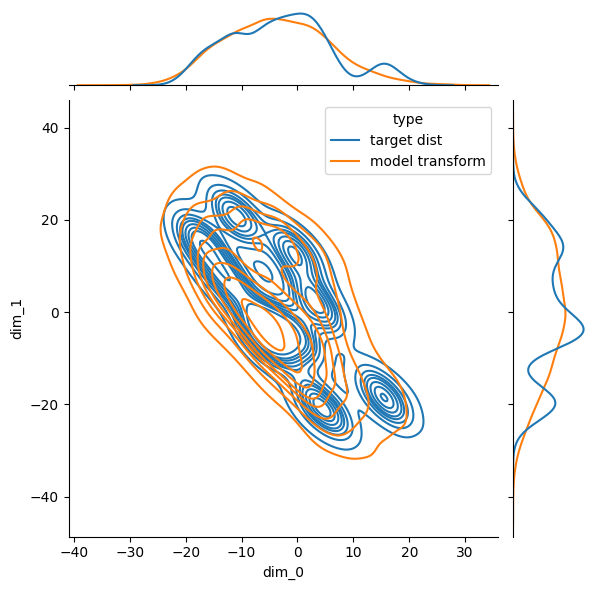

trail: 0 m step: 4 kl_test: 13.963085174560547


  2%|▏         | 100/6000 [00:32<35:03,  2.80it/s]

trail: 0 m step: 5 Loss: 12.449764251708984  L_n: 11.243099212646484  kld: 0.060333251953125 KLD1: 11.17899227142334 KLD2: 3.993687391281128


  3%|▎         | 200/6000 [01:04<34:23,  2.81it/s]

trail: 0 m step: 5 Loss: 12.426887512207031  L_n: 11.194854736328125  kld: 0.06160163879394531 KLD1: 11.032740592956543 KLD2: 3.987144708633423


  5%|▌         | 300/6000 [01:36<33:54,  2.80it/s]

trail: 0 m step: 5 Loss: 12.438762664794922  L_n: 11.122119903564453  kld: 0.06583213806152344 KLD1: 11.037400245666504 KLD2: 3.91855525970459


  7%|▋         | 400/6000 [02:08<33:17,  2.80it/s]

trail: 0 m step: 5 Loss: 12.048568725585938  L_n: 10.949592590332031  kld: 0.05494880676269531 KLD1: 11.211297035217285 KLD2: 3.9108803272247314


  8%|▊         | 500/6000 [02:40<32:43,  2.80it/s]

trail: 0 m step: 5 Loss: 12.210235595703125  L_n: 10.868072509765625  kld: 0.067108154296875 KLD1: 10.966582298278809 KLD2: 3.9327077865600586


 10%|█         | 600/6000 [03:13<31:56,  2.82it/s]

trail: 0 m step: 5 Loss: 12.470067977905273  L_n: 11.059202194213867  kld: 0.07054328918457031 KLD1: 10.85059642791748 KLD2: 3.93996000289917


 12%|█▏        | 700/6000 [03:45<31:30,  2.80it/s]

trail: 0 m step: 5 Loss: 12.293695449829102  L_n: 10.975946426391602  kld: 0.065887451171875 KLD1: 10.999873161315918 KLD2: 3.904329299926758


 13%|█▎        | 800/6000 [04:17<30:49,  2.81it/s]

trail: 0 m step: 5 Loss: 12.277116775512695  L_n: 10.903635025024414  kld: 0.06867408752441406 KLD1: 10.914474487304688 KLD2: 3.9238648414611816


 15%|█▌        | 900/6000 [04:49<30:18,  2.80it/s]

trail: 0 m step: 5 Loss: 12.301544189453125  L_n: 10.887321472167969  kld: 0.07071113586425781 KLD1: 10.845812797546387 KLD2: 3.930011510848999


 17%|█▋        | 1000/6000 [05:21<29:39,  2.81it/s]

trail: 0 m step: 5 Loss: 12.054733276367188  L_n: 10.751861572265625  kld: 0.06514358520507812 KLD1: 10.867266654968262 KLD2: 3.908735752105713


 18%|█▊        | 1100/6000 [05:53<28:59,  2.82it/s]

trail: 0 m step: 5 Loss: 12.178873062133789  L_n: 10.789216995239258  kld: 0.06948280334472656 KLD1: 10.863446235656738 KLD2: 3.9185311794281006


 20%|██        | 1200/6000 [06:26<28:30,  2.81it/s]

trail: 0 m step: 5 Loss: 12.167360305786133  L_n: 10.72715950012207  kld: 0.07201004028320312 KLD1: 10.81297779083252 KLD2: 3.9169843196868896


 22%|██▏       | 1300/6000 [06:58<27:53,  2.81it/s]

trail: 0 m step: 5 Loss: 12.116619110107422  L_n: 10.83083724975586  kld: 0.06428909301757812 KLD1: 10.934571266174316 KLD2: 3.938037872314453


 23%|██▎       | 1400/6000 [07:30<27:21,  2.80it/s]

trail: 0 m step: 5 Loss: 12.311124801635742  L_n: 10.827131271362305  kld: 0.07419967651367188 KLD1: 10.694740295410156 KLD2: 3.870286703109741


 25%|██▌       | 1500/6000 [08:02<26:41,  2.81it/s]

trail: 0 m step: 5 Loss: 12.194101333618164  L_n: 10.81077766418457  kld: 0.06916618347167969 KLD1: 10.824357986450195 KLD2: 3.8633975982666016


 27%|██▋       | 1600/6000 [08:34<26:04,  2.81it/s]

trail: 0 m step: 5 Loss: 12.256830215454102  L_n: 10.85954475402832  kld: 0.06986427307128906 KLD1: 10.778243064880371 KLD2: 3.8831632137298584


 28%|██▊       | 1700/6000 [09:06<25:24,  2.82it/s]

trail: 0 m step: 5 Loss: 12.35560417175293  L_n: 11.034841537475586  kld: 0.06603813171386719 KLD1: 10.901040077209473 KLD2: 3.917628049850464


 30%|███       | 1800/6000 [09:39<24:56,  2.81it/s]

trail: 0 m step: 5 Loss: 12.129167556762695  L_n: 10.702127456665039  kld: 0.07135200500488281 KLD1: 10.7788724899292 KLD2: 3.8801069259643555


 32%|███▏      | 1900/6000 [10:11<24:16,  2.81it/s]

trail: 0 m step: 5 Loss: 12.181915283203125  L_n: 10.759757995605469  kld: 0.07110786437988281 KLD1: 10.790255546569824 KLD2: 3.91263747215271


 33%|███▎      | 2000/6000 [10:43<23:37,  2.82it/s]

trail: 0 m step: 5 Loss: 12.141458511352539  L_n: 10.81138801574707  kld: 0.06650352478027344 KLD1: 10.835927963256836 KLD2: 3.9034206867218018


 35%|███▌      | 2100/6000 [11:15<23:11,  2.80it/s]

trail: 0 m step: 5 Loss: 12.151826858520508  L_n: 10.62816047668457  kld: 0.07618331909179688 KLD1: 10.60775089263916 KLD2: 3.893078088760376


 37%|███▋      | 2200/6000 [11:47<22:36,  2.80it/s]

trail: 0 m step: 5 Loss: 12.146081924438477  L_n: 10.749979019165039  kld: 0.06980514526367188 KLD1: 10.754168510437012 KLD2: 3.892685890197754


 38%|███▊      | 2300/6000 [12:19<21:55,  2.81it/s]

trail: 0 m step: 5 Loss: 12.100980758666992  L_n: 10.67909049987793  kld: 0.07109451293945312 KLD1: 10.700414657592773 KLD2: 3.862924098968506


 40%|████      | 2400/6000 [12:51<21:16,  2.82it/s]

trail: 0 m step: 5 Loss: 12.22291374206543  L_n: 10.867284774780273  kld: 0.06778144836425781 KLD1: 10.810314178466797 KLD2: 3.891881227493286


 42%|████▏     | 2500/6000 [13:24<20:41,  2.82it/s]

trail: 0 m step: 5 Loss: 12.024711608886719  L_n: 10.762275695800781  kld: 0.06312179565429688 KLD1: 10.90638542175293 KLD2: 3.891810417175293


 43%|████▎     | 2600/6000 [13:56<20:06,  2.82it/s]

trail: 0 m step: 5 Loss: 12.105949401855469  L_n: 10.642288208007812  kld: 0.07318305969238281 KLD1: 10.633984565734863 KLD2: 3.858537435531616


 45%|████▌     | 2700/6000 [14:28<19:32,  2.81it/s]

trail: 0 m step: 5 Loss: 12.196657180786133  L_n: 10.792238235473633  kld: 0.070220947265625 KLD1: 10.696539878845215 KLD2: 3.8901259899139404


 47%|████▋     | 2800/6000 [15:00<18:58,  2.81it/s]

trail: 0 m step: 5 Loss: 12.12990951538086  L_n: 10.67177963256836  kld: 0.072906494140625 KLD1: 10.728132247924805 KLD2: 3.890467882156372


 48%|████▊     | 2900/6000 [15:32<18:19,  2.82it/s]

trail: 0 m step: 5 Loss: 12.306110382080078  L_n: 10.826313018798828  kld: 0.0739898681640625 KLD1: 10.646743774414062 KLD2: 3.8849871158599854


 50%|█████     | 3000/6000 [16:04<17:48,  2.81it/s]

trail: 0 m step: 5 Loss: 12.165348052978516  L_n: 10.728351593017578  kld: 0.07184982299804688 KLD1: 10.724769592285156 KLD2: 3.85634446144104


 52%|█████▏    | 3100/6000 [16:37<17:17,  2.80it/s]

trail: 0 m step: 5 Loss: 11.964563369750977  L_n: 10.686830520629883  kld: 0.06388664245605469 KLD1: 10.841585159301758 KLD2: 3.843231201171875


 53%|█████▎    | 3200/6000 [17:09<16:36,  2.81it/s]

trail: 0 m step: 5 Loss: 12.311128616333008  L_n: 10.778879165649414  kld: 0.07661247253417969 KLD1: 10.602362632751465 KLD2: 3.8306453227996826


 55%|█████▌    | 3300/6000 [17:41<15:58,  2.82it/s]

trail: 0 m step: 5 Loss: 12.183849334716797  L_n: 10.789119720458984  kld: 0.06973648071289062 KLD1: 10.70718002319336 KLD2: 3.8479812145233154


 57%|█████▋    | 3400/6000 [18:13<15:27,  2.80it/s]

trail: 0 m step: 5 Loss: 11.96953010559082  L_n: 10.506135940551758  kld: 0.07316970825195312 KLD1: 10.690691947937012 KLD2: 3.8796775341033936


 58%|█████▊    | 3500/6000 [18:45<14:50,  2.81it/s]

trail: 0 m step: 5 Loss: 12.230714797973633  L_n: 10.835794448852539  kld: 0.06974601745605469 KLD1: 10.74219036102295 KLD2: 3.895169734954834


 60%|██████    | 3600/6000 [19:17<14:17,  2.80it/s]

trail: 0 m step: 5 Loss: 12.026552200317383  L_n: 10.628923416137695  kld: 0.06988143920898438 KLD1: 10.791301727294922 KLD2: 3.9093873500823975


 62%|██████▏   | 3700/6000 [19:50<13:39,  2.81it/s]

trail: 0 m step: 5 Loss: 12.061944961547852  L_n: 10.621896743774414  kld: 0.07200241088867188 KLD1: 10.65886402130127 KLD2: 3.8700408935546875


 63%|██████▎   | 3800/6000 [20:22<13:03,  2.81it/s]

trail: 0 m step: 5 Loss: 12.081186294555664  L_n: 10.793573379516602  kld: 0.06438064575195312 KLD1: 10.85764217376709 KLD2: 3.8528249263763428


 65%|██████▌   | 3900/6000 [20:54<12:27,  2.81it/s]

trail: 0 m step: 5 Loss: 12.013847351074219  L_n: 10.528404235839844  kld: 0.07427215576171875 KLD1: 10.627546310424805 KLD2: 3.842674493789673


 67%|██████▋   | 4000/6000 [21:26<11:50,  2.81it/s]

trail: 0 m step: 5 Loss: 12.190589904785156  L_n: 10.643730163574219  kld: 0.07734298706054688 KLD1: 10.606913566589355 KLD2: 3.8691413402557373


 68%|██████▊   | 4100/6000 [21:58<11:15,  2.81it/s]

trail: 0 m step: 5 Loss: 12.261051177978516  L_n: 10.690349578857422  kld: 0.07853507995605469 KLD1: 10.46784496307373 KLD2: 3.8584365844726562


 70%|███████   | 4200/6000 [22:30<10:38,  2.82it/s]

trail: 0 m step: 5 Loss: 11.96103286743164  L_n: 10.572216033935547  kld: 0.06944084167480469 KLD1: 10.778166770935059 KLD2: 3.869227170944214


 72%|███████▏  | 4300/6000 [23:03<10:07,  2.80it/s]

trail: 0 m step: 5 Loss: 12.160818099975586  L_n: 10.739919662475586  kld: 0.071044921875 KLD1: 10.725016593933105 KLD2: 3.8983170986175537


 73%|███████▎  | 4400/6000 [23:35<09:29,  2.81it/s]

trail: 0 m step: 5 Loss: 12.077177047729492  L_n: 10.586240768432617  kld: 0.07454681396484375 KLD1: 10.639446258544922 KLD2: 3.8631861209869385


 75%|███████▌  | 4500/6000 [24:07<08:56,  2.80it/s]

trail: 0 m step: 5 Loss: 12.082700729370117  L_n: 10.651578903198242  kld: 0.07155609130859375 KLD1: 10.671880722045898 KLD2: 3.8544249534606934


 77%|███████▋  | 4600/6000 [24:39<08:16,  2.82it/s]

trail: 0 m step: 5 Loss: 12.091817855834961  L_n: 10.647954940795898  kld: 0.07219314575195312 KLD1: 10.732053756713867 KLD2: 3.9000935554504395


 78%|███████▊  | 4700/6000 [25:11<07:41,  2.81it/s]

trail: 0 m step: 5 Loss: 11.90904426574707  L_n: 10.595911026000977  kld: 0.06565666198730469 KLD1: 10.767582893371582 KLD2: 3.866096019744873


 80%|████████  | 4800/6000 [25:43<07:06,  2.81it/s]

trail: 0 m step: 5 Loss: 12.203882217407227  L_n: 10.820138931274414  kld: 0.06918716430664062 KLD1: 10.712890625 KLD2: 3.8665575981140137


 82%|████████▏ | 4900/6000 [26:16<06:30,  2.82it/s]

trail: 0 m step: 5 Loss: 12.036897659301758  L_n: 10.652887344360352  kld: 0.06920051574707031 KLD1: 10.730461120605469 KLD2: 3.8586666584014893


 83%|████████▎ | 5000/6000 [26:48<05:55,  2.81it/s]

trail: 0 m step: 5 Loss: 12.227333068847656  L_n: 10.755012512207031  kld: 0.07361602783203125 KLD1: 10.620468139648438 KLD2: 3.8790030479431152


 85%|████████▌ | 5100/6000 [27:20<05:19,  2.82it/s]

trail: 0 m step: 5 Loss: 11.86960220336914  L_n: 10.489215850830078  kld: 0.06901931762695312 KLD1: 10.752274513244629 KLD2: 3.8845908641815186


 87%|████████▋ | 5200/6000 [27:52<04:43,  2.82it/s]

trail: 0 m step: 5 Loss: 12.130252838134766  L_n: 10.636760711669922  kld: 0.07467460632324219 KLD1: 10.573663711547852 KLD2: 3.87821626663208


 88%|████████▊ | 5300/6000 [28:24<04:08,  2.82it/s]

trail: 0 m step: 5 Loss: 12.071022033691406  L_n: 10.606025695800781  kld: 0.07324981689453125 KLD1: 10.62136173248291 KLD2: 3.8540921211242676


 90%|█████████ | 5400/6000 [28:56<03:34,  2.80it/s]

trail: 0 m step: 5 Loss: 12.107040405273438  L_n: 10.746604919433594  kld: 0.06802177429199219 KLD1: 10.785362243652344 KLD2: 3.856149196624756


 92%|█████████▏| 5500/6000 [29:28<02:58,  2.80it/s]

trail: 0 m step: 5 Loss: 12.188220977783203  L_n: 10.677600860595703  kld: 0.075531005859375 KLD1: 10.563300132751465 KLD2: 3.861888885498047


 93%|█████████▎| 5600/6000 [30:01<02:22,  2.81it/s]

trail: 0 m step: 5 Loss: 12.244405746459961  L_n: 10.771055221557617  kld: 0.07366752624511719 KLD1: 10.703534126281738 KLD2: 3.8547794818878174


 95%|█████████▌| 5700/6000 [30:33<01:46,  2.81it/s]

trail: 0 m step: 5 Loss: 12.059005737304688  L_n: 10.644515991210938  kld: 0.0707244873046875 KLD1: 10.671804428100586 KLD2: 3.8831937313079834


 97%|█████████▋| 5800/6000 [31:05<01:11,  2.81it/s]

trail: 0 m step: 5 Loss: 12.161033630371094  L_n: 10.708778381347656  kld: 0.07261276245117188 KLD1: 10.635478973388672 KLD2: 3.85333514213562


 98%|█████████▊| 5900/6000 [31:37<00:35,  2.81it/s]

trail: 0 m step: 5 Loss: 12.126703262329102  L_n: 10.60978889465332  kld: 0.07584571838378906 KLD1: 10.607913970947266 KLD2: 3.8761396408081055


100%|██████████| 6000/6000 [32:09<00:00,  3.11it/s]

trail: 0 m step: 5 Loss: 12.028417587280273  L_n: 10.528364181518555  kld: 0.07500267028808594 KLD1: 10.589507102966309 KLD2: 3.8779263496398926



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


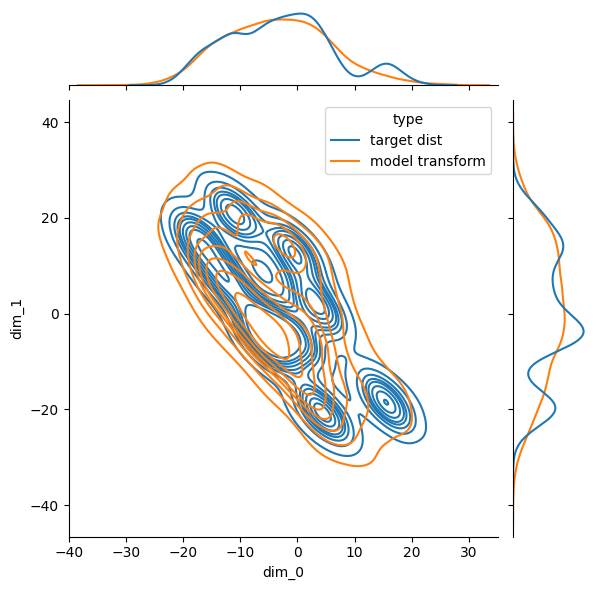

trail: 0 m step: 5 kl_test: 10.728328704833984


  2%|▏         | 100/6000 [00:32<35:20,  2.78it/s]

trail: 0 m step: 6 Loss: 9.681947708129883  L_n: 8.788698196411133  kld: 0.0446624755859375 KLD1: 8.74755573272705 KLD2: 3.37243390083313


  3%|▎         | 200/6000 [01:04<34:04,  2.84it/s]

trail: 0 m step: 6 Loss: 9.680952072143555  L_n: 8.798192977905273  kld: 0.04413795471191406 KLD1: 8.649165153503418 KLD2: 3.3744475841522217


  5%|▌         | 300/6000 [01:36<33:47,  2.81it/s]

trail: 0 m step: 6 Loss: 9.637086868286133  L_n: 8.698518753051758  kld: 0.04692840576171875 KLD1: 8.690215110778809 KLD2: 3.3192312717437744


  7%|▋         | 400/6000 [02:08<33:15,  2.81it/s]

trail: 0 m step: 6 Loss: 9.364795684814453  L_n: 8.600635528564453  kld: 0.0382080078125 KLD1: 8.826434135437012 KLD2: 3.313192129135132


  8%|▊         | 500/6000 [02:41<32:35,  2.81it/s]

trail: 0 m step: 6 Loss: 9.572650909423828  L_n: 8.622028350830078  kld: 0.0475311279296875 KLD1: 8.659238815307617 KLD2: 3.3342695236206055


 10%|█         | 600/6000 [03:13<31:52,  2.82it/s]

trail: 0 m step: 6 Loss: 9.671890258789062  L_n: 8.631660461425781  kld: 0.05201148986816406 KLD1: 8.485799789428711 KLD2: 3.3412957191467285


 12%|█▏        | 700/6000 [03:45<31:26,  2.81it/s]

trail: 0 m step: 6 Loss: 9.53759765625  L_n: 8.575416564941406  kld: 0.04810905456542969 KLD1: 8.630228996276855 KLD2: 3.30385684967041


 13%|█▎        | 800/6000 [04:17<30:58,  2.80it/s]

trail: 0 m step: 6 Loss: 9.549312591552734  L_n: 8.559551239013672  kld: 0.049488067626953125 KLD1: 8.565035820007324 KLD2: 3.333127737045288


 15%|█▌        | 900/6000 [04:49<30:13,  2.81it/s]

trail: 0 m step: 6 Loss: 9.557146072387695  L_n: 8.544267654418945  kld: 0.0506439208984375 KLD1: 8.53026008605957 KLD2: 3.3375847339630127


 17%|█▋        | 1000/6000 [05:21<29:37,  2.81it/s]

trail: 0 m step: 6 Loss: 9.32037353515625  L_n: 8.3978271484375  kld: 0.0461273193359375 KLD1: 8.5015287399292 KLD2: 3.317845582962036


 18%|█▊        | 1100/6000 [05:53<28:55,  2.82it/s]

trail: 0 m step: 6 Loss: 9.466665267944336  L_n: 8.495634078979492  kld: 0.04855155944824219 KLD1: 8.547000885009766 KLD2: 3.331904172897339


 20%|██        | 1200/6000 [06:25<28:15,  2.83it/s]

trail: 0 m step: 6 Loss: 9.467439651489258  L_n: 8.437089920043945  kld: 0.051517486572265625 KLD1: 8.470884323120117 KLD2: 3.3339295387268066


 22%|██▏       | 1300/6000 [06:58<27:56,  2.80it/s]

trail: 0 m step: 6 Loss: 9.443817138671875  L_n: 8.536415100097656  kld: 0.04537010192871094 KLD1: 8.59959602355957 KLD2: 3.350400686264038


 23%|██▎       | 1400/6000 [07:30<27:14,  2.81it/s]

trail: 0 m step: 6 Loss: 9.575567245483398  L_n: 8.514547348022461  kld: 0.053050994873046875 KLD1: 8.398602485656738 KLD2: 3.2875311374664307


 25%|██▌       | 1500/6000 [08:02<26:42,  2.81it/s]

trail: 0 m step: 6 Loss: 9.490646362304688  L_n: 8.501152038574219  kld: 0.04947471618652344 KLD1: 8.46963882446289 KLD2: 3.2760560512542725


 27%|██▋       | 1600/6000 [08:34<26:06,  2.81it/s]

trail: 0 m step: 6 Loss: 9.565120697021484  L_n: 8.562923431396484  kld: 0.05010986328125 KLD1: 8.450052261352539 KLD2: 3.2911980152130127


 28%|██▊       | 1700/6000 [09:06<25:28,  2.81it/s]

trail: 0 m step: 6 Loss: 9.612865447998047  L_n: 8.650798797607422  kld: 0.04810333251953125 KLD1: 8.543203353881836 KLD2: 3.324631929397583


 30%|███       | 1800/6000 [09:38<24:52,  2.81it/s]

trail: 0 m step: 6 Loss: 9.425094604492188  L_n: 8.386543273925781  kld: 0.05192756652832031 KLD1: 8.497097969055176 KLD2: 3.296393632888794


 32%|███▏      | 1900/6000 [10:10<24:19,  2.81it/s]

trail: 0 m step: 6 Loss: 9.488948822021484  L_n: 8.490184783935547  kld: 0.049938201904296875 KLD1: 8.520350456237793 KLD2: 3.3271467685699463


 33%|███▎      | 2000/6000 [10:42<23:42,  2.81it/s]

trail: 0 m step: 6 Loss: 9.436901092529297  L_n: 8.498027801513672  kld: 0.04694366455078125 KLD1: 8.573874473571777 KLD2: 3.3143064975738525


 35%|███▌      | 2100/6000 [11:15<23:11,  2.80it/s]

trail: 0 m step: 6 Loss: 9.474552154541016  L_n: 8.377445220947266  kld: 0.0548553466796875 KLD1: 8.362919807434082 KLD2: 3.308347463607788


 37%|███▋      | 2200/6000 [11:47<22:34,  2.81it/s]

trail: 0 m step: 6 Loss: 9.443082809448242  L_n: 8.433523178100586  kld: 0.05047798156738281 KLD1: 8.46041488647461 KLD2: 3.3045806884765625


 38%|███▊      | 2300/6000 [12:19<22:03,  2.80it/s]

trail: 0 m step: 6 Loss: 9.389093399047852  L_n: 8.39067268371582  kld: 0.04992103576660156 KLD1: 8.482254028320312 KLD2: 3.277944803237915


 40%|████      | 2400/6000 [12:51<21:19,  2.81it/s]

trail: 0 m step: 6 Loss: 9.500730514526367  L_n: 8.543737411499023  kld: 0.04784965515136719 KLD1: 8.528776168823242 KLD2: 3.3012146949768066


 42%|████▏     | 2500/6000 [13:24<20:45,  2.81it/s]

trail: 0 m step: 6 Loss: 9.356132507324219  L_n: 8.480850219726562  kld: 0.04376411437988281 KLD1: 8.542874336242676 KLD2: 3.307790517807007


 43%|████▎     | 2600/6000 [13:56<20:14,  2.80it/s]

trail: 0 m step: 6 Loss: 9.393606185913086  L_n: 8.361043930053711  kld: 0.05162811279296875 KLD1: 8.376422882080078 KLD2: 3.278860569000244


 45%|████▌     | 2700/6000 [14:28<19:40,  2.79it/s]

trail: 0 m step: 6 Loss: 9.490730285644531  L_n: 8.506156921386719  kld: 0.049228668212890625 KLD1: 8.420221328735352 KLD2: 3.306525707244873


 47%|████▋     | 2800/6000 [15:00<18:56,  2.82it/s]

trail: 0 m step: 6 Loss: 9.386137008666992  L_n: 8.349874496459961  kld: 0.05181312561035156 KLD1: 8.4130859375 KLD2: 3.306858539581299


 48%|████▊     | 2900/6000 [15:33<18:25,  2.81it/s]

trail: 0 m step: 6 Loss: 9.57969856262207  L_n: 8.513566970825195  kld: 0.05330657958984375 KLD1: 8.36899185180664 KLD2: 3.304100751876831


 50%|█████     | 3000/6000 [16:05<17:48,  2.81it/s]

trail: 0 m step: 6 Loss: 9.501445770263672  L_n: 8.469608306884766  kld: 0.05159187316894531 KLD1: 8.406208038330078 KLD2: 3.2732162475585938


 52%|█████▏    | 3100/6000 [16:37<17:10,  2.81it/s]

trail: 0 m step: 6 Loss: 9.308746337890625  L_n: 8.4217529296875  kld: 0.04434967041015625 KLD1: 8.577408790588379 KLD2: 3.26226806640625


 53%|█████▎    | 3200/6000 [17:09<16:32,  2.82it/s]

trail: 0 m step: 6 Loss: 9.57992172241211  L_n: 8.491168975830078  kld: 0.05443763732910156 KLD1: 8.33284854888916 KLD2: 3.252856492996216


 55%|█████▌    | 3300/6000 [17:41<15:58,  2.82it/s]

trail: 0 m step: 6 Loss: 9.441587448120117  L_n: 8.451139450073242  kld: 0.04952239990234375 KLD1: 8.433926582336426 KLD2: 3.26604962348938


 57%|█████▋    | 3400/6000 [18:13<15:26,  2.81it/s]

trail: 0 m step: 6 Loss: 9.304616928100586  L_n: 8.265340805053711  kld: 0.05196380615234375 KLD1: 8.426591873168945 KLD2: 3.297950029373169


 58%|█████▊    | 3500/6000 [18:46<14:48,  2.81it/s]

trail: 0 m step: 6 Loss: 9.51822280883789  L_n: 8.511219024658203  kld: 0.050350189208984375 KLD1: 8.456833839416504 KLD2: 3.308427572250366


 60%|██████    | 3600/6000 [19:18<14:16,  2.80it/s]

trail: 0 m step: 6 Loss: 9.377748489379883  L_n: 8.372499465942383  kld: 0.050262451171875 KLD1: 8.474146842956543 KLD2: 3.3234357833862305


 62%|██████▏   | 3700/6000 [19:50<13:34,  2.82it/s]

trail: 0 m step: 6 Loss: 9.386749267578125  L_n: 8.345870971679688  kld: 0.052043914794921875 KLD1: 8.380524635314941 KLD2: 3.2869865894317627


 63%|██████▎   | 3800/6000 [20:22<13:03,  2.81it/s]

trail: 0 m step: 6 Loss: 9.363323211669922  L_n: 8.49490737915039  kld: 0.04342079162597656 KLD1: 8.599677085876465 KLD2: 3.2723207473754883


 65%|██████▌   | 3900/6000 [20:54<12:23,  2.82it/s]

trail: 0 m step: 6 Loss: 9.378482818603516  L_n: 8.294841766357422  kld: 0.05418205261230469 KLD1: 8.389362335205078 KLD2: 3.2618002891540527


 67%|██████▋   | 4000/6000 [21:26<11:46,  2.83it/s]

trail: 0 m step: 6 Loss: 9.508995056152344  L_n: 8.390106201171875  kld: 0.05594444274902344 KLD1: 8.373252868652344 KLD2: 3.28696870803833


 68%|██████▊   | 4100/6000 [21:58<11:15,  2.81it/s]

trail: 0 m step: 6 Loss: 9.533479690551758  L_n: 8.398950576782227  kld: 0.05672645568847656 KLD1: 8.224390029907227 KLD2: 3.2764699459075928


 70%|███████   | 4200/6000 [22:30<10:38,  2.82it/s]

trail: 0 m step: 6 Loss: 9.34164047241211  L_n: 8.347797393798828  kld: 0.04969215393066406 KLD1: 8.481093406677246 KLD2: 3.2862229347229004


 72%|███████▏  | 4300/6000 [23:03<10:04,  2.81it/s]

trail: 0 m step: 6 Loss: 9.421354293823242  L_n: 8.435979843139648  kld: 0.04926872253417969 KLD1: 8.497419357299805 KLD2: 3.316553831100464


 73%|███████▎  | 4400/6000 [23:35<09:28,  2.82it/s]

trail: 0 m step: 6 Loss: 9.357746124267578  L_n: 8.296192169189453  kld: 0.05307769775390625 KLD1: 8.38107967376709 KLD2: 3.284141778945923


 75%|███████▌  | 4500/6000 [24:07<08:51,  2.82it/s]

trail: 0 m step: 6 Loss: 9.400823593139648  L_n: 8.397253036499023  kld: 0.05017852783203125 KLD1: 8.405285835266113 KLD2: 3.274641752243042


 77%|███████▋  | 4600/6000 [24:39<08:18,  2.81it/s]

trail: 0 m step: 6 Loss: 9.421546936035156  L_n: 8.383529663085938  kld: 0.05190086364746094 KLD1: 8.425013542175293 KLD2: 3.318528890609741


 78%|███████▊  | 4700/6000 [25:11<07:45,  2.79it/s]

trail: 0 m step: 6 Loss: 9.208221435546875  L_n: 8.282928466796875  kld: 0.0462646484375 KLD1: 8.498245239257812 KLD2: 3.2857375144958496


 80%|████████  | 4800/6000 [25:43<07:08,  2.80it/s]

trail: 0 m step: 6 Loss: 9.471002578735352  L_n: 8.496767044067383  kld: 0.04871177673339844 KLD1: 8.412320137023926 KLD2: 3.2874975204467773


 82%|████████▏ | 4900/6000 [26:16<06:32,  2.80it/s]

trail: 0 m step: 6 Loss: 9.379631042480469  L_n: 8.388725280761719  kld: 0.0495452880859375 KLD1: 8.466914176940918 KLD2: 3.2790627479553223


 83%|████████▎ | 5000/6000 [26:48<05:54,  2.82it/s]

trail: 0 m step: 6 Loss: 9.510177612304688  L_n: 8.457626342773438  kld: 0.0526275634765625 KLD1: 8.327420234680176 KLD2: 3.2991557121276855


 85%|████████▌ | 5100/6000 [27:20<05:19,  2.82it/s]

trail: 0 m step: 6 Loss: 9.180233001708984  L_n: 8.21042251586914  kld: 0.04849052429199219 KLD1: 8.499473571777344 KLD2: 3.3023171424865723


 87%|████████▋ | 5200/6000 [27:52<04:44,  2.81it/s]

trail: 0 m step: 6 Loss: 9.45943832397461  L_n: 8.388919830322266  kld: 0.05352592468261719 KLD1: 8.347137451171875 KLD2: 3.296196699142456


 88%|████████▊ | 5300/6000 [28:24<04:08,  2.81it/s]

trail: 0 m step: 6 Loss: 9.388805389404297  L_n: 8.33724594116211  kld: 0.052577972412109375 KLD1: 8.33687686920166 KLD2: 3.2730631828308105


 90%|█████████ | 5400/6000 [28:57<03:33,  2.82it/s]

trail: 0 m step: 6 Loss: 9.37095832824707  L_n: 8.418466567993164  kld: 0.04762458801269531 KLD1: 8.487456321716309 KLD2: 3.2778573036193848


 92%|█████████▏| 5500/6000 [29:29<02:58,  2.80it/s]

trail: 0 m step: 6 Loss: 9.50979995727539  L_n: 8.405864715576172  kld: 0.05519676208496094 KLD1: 8.288125991821289 KLD2: 3.282940149307251


 93%|█████████▎| 5600/6000 [30:01<02:22,  2.80it/s]

trail: 0 m step: 6 Loss: 9.539321899414062  L_n: 8.471435546875  kld: 0.053394317626953125 KLD1: 8.401087760925293 KLD2: 3.2764222621917725


 95%|█████████▌| 5700/6000 [30:33<01:46,  2.82it/s]

trail: 0 m step: 6 Loss: 9.372596740722656  L_n: 8.385429382324219  kld: 0.049358367919921875 KLD1: 8.450821876525879 KLD2: 3.3028154373168945


 97%|█████████▋| 5800/6000 [31:06<01:11,  2.80it/s]

trail: 0 m step: 6 Loss: 9.451068878173828  L_n: 8.434757232666016  kld: 0.050815582275390625 KLD1: 8.39334487915039 KLD2: 3.2753467559814453


 98%|█████████▊| 5900/6000 [31:38<00:35,  2.80it/s]

trail: 0 m step: 6 Loss: 9.44590950012207  L_n: 8.361467361450195  kld: 0.05422210693359375 KLD1: 8.3290376663208 KLD2: 3.29734206199646


100%|██████████| 6000/6000 [32:10<00:00,  3.11it/s]

trail: 0 m step: 6 Loss: 9.351058959960938  L_n: 8.283363342285156  kld: 0.05338478088378906 KLD1: 8.350265502929688 KLD2: 3.2963781356811523



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


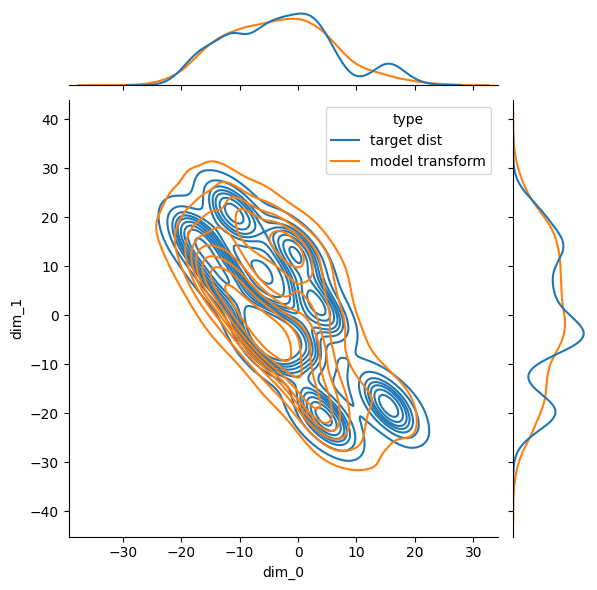

trail: 0 m step: 6 kl_test: 8.477338790893555


  2%|▏         | 100/6000 [00:32<35:06,  2.80it/s]

trail: 0 m step: 7 Loss: 7.716615676879883  L_n: 7.02897834777832  kld: 0.034381866455078125 KLD1: 6.996753692626953 KLD2: 2.877073287963867


  3%|▎         | 200/6000 [01:04<34:16,  2.82it/s]

trail: 0 m step: 7 Loss: 7.71830940246582  L_n: 7.041200637817383  kld: 0.033855438232421875 KLD1: 6.900765419006348 KLD2: 2.888901472091675


  5%|▌         | 300/6000 [01:36<33:45,  2.81it/s]

trail: 0 m step: 7 Loss: 7.636228561401367  L_n: 6.954160690307617  kld: 0.0341033935546875 KLD1: 6.933134078979492 KLD2: 2.846581220626831


  7%|▋         | 400/6000 [02:08<33:09,  2.81it/s]

trail: 0 m step: 7 Loss: 7.415674209594727  L_n: 6.88615608215332  kld: 0.026475906372070312 KLD1: 7.100611686706543 KLD2: 2.8369698524475098


  8%|▊         | 500/6000 [02:40<32:43,  2.80it/s]

trail: 0 m step: 7 Loss: 7.589740753173828  L_n: 6.884098052978516  kld: 0.035282135009765625 KLD1: 6.914407730102539 KLD2: 2.855041265487671


 10%|█         | 600/6000 [03:13<32:10,  2.80it/s]

trail: 0 m step: 7 Loss: 7.698673248291016  L_n: 6.911357879638672  kld: 0.03936576843261719 KLD1: 6.773545265197754 KLD2: 2.8636715412139893


 12%|█▏        | 700/6000 [03:45<31:15,  2.83it/s]

trail: 0 m step: 7 Loss: 7.6056671142578125  L_n: 6.868438720703125  kld: 0.036861419677734375 KLD1: 6.848448276519775 KLD2: 2.828197479248047


 13%|█▎        | 800/6000 [04:17<30:46,  2.82it/s]

trail: 0 m step: 7 Loss: 7.6341094970703125  L_n: 6.904090881347656  kld: 0.03650093078613281 KLD1: 6.882739067077637 KLD2: 2.8576290607452393


 15%|█▌        | 900/6000 [04:49<30:10,  2.82it/s]

trail: 0 m step: 7 Loss: 7.577413558959961  L_n: 6.831907272338867  kld: 0.03727531433105469 KLD1: 6.878856182098389 KLD2: 2.864651918411255


 17%|█▋        | 1000/6000 [05:21<29:34,  2.82it/s]

trail: 0 m step: 7 Loss: 7.3948211669921875  L_n: 6.728202819824219  kld: 0.03333091735839844 KLD1: 6.85022497177124 KLD2: 2.8455164432525635


 18%|█▊        | 1100/6000 [05:53<29:03,  2.81it/s]

trail: 0 m step: 7 Loss: 7.509580612182617  L_n: 6.794858932495117  kld: 0.035736083984375 KLD1: 6.862658977508545 KLD2: 2.8590052127838135


 20%|██        | 1200/6000 [06:25<28:19,  2.82it/s]

trail: 0 m step: 7 Loss: 7.472118377685547  L_n: 6.745151519775391  kld: 0.03634834289550781 KLD1: 6.817259788513184 KLD2: 2.8645882606506348


 22%|██▏       | 1300/6000 [06:57<27:55,  2.81it/s]

trail: 0 m step: 7 Loss: 7.480504989624023  L_n: 6.815755844116211  kld: 0.033237457275390625 KLD1: 6.882773399353027 KLD2: 2.8762478828430176


 23%|██▎       | 1400/6000 [07:29<27:15,  2.81it/s]

trail: 0 m step: 7 Loss: 7.653778076171875  L_n: 6.852424621582031  kld: 0.04006767272949219 KLD1: 6.72897481918335 KLD2: 2.815068483352661


 25%|██▌       | 1500/6000 [08:01<26:39,  2.81it/s]

trail: 0 m step: 7 Loss: 7.571010589599609  L_n: 6.808223724365234  kld: 0.03813934326171875 KLD1: 6.782836437225342 KLD2: 2.803600311279297


 27%|██▋       | 1600/6000 [08:34<26:06,  2.81it/s]

trail: 0 m step: 7 Loss: 7.621166229248047  L_n: 6.876079559326172  kld: 0.03725433349609375 KLD1: 6.744504451751709 KLD2: 2.819998264312744


 28%|██▊       | 1700/6000 [09:06<25:27,  2.81it/s]

trail: 0 m step: 7 Loss: 7.654964447021484  L_n: 6.945049285888672  kld: 0.035495758056640625 KLD1: 6.867416858673096 KLD2: 2.8541722297668457


 30%|███       | 1800/6000 [09:38<24:58,  2.80it/s]

trail: 0 m step: 7 Loss: 7.430498123168945  L_n: 6.673166275024414  kld: 0.03786659240722656 KLD1: 6.835779666900635 KLD2: 2.829636573791504


 32%|███▏      | 1900/6000 [10:10<24:25,  2.80it/s]

trail: 0 m step: 7 Loss: 7.51530647277832  L_n: 6.790590286254883  kld: 0.036235809326171875 KLD1: 6.863248348236084 KLD2: 2.8512935638427734


 33%|███▎      | 2000/6000 [10:42<23:47,  2.80it/s]

trail: 0 m step: 7 Loss: 7.501255035400391  L_n: 6.807666778564453  kld: 0.034679412841796875 KLD1: 6.837357521057129 KLD2: 2.8411898612976074


 35%|███▌      | 2100/6000 [11:15<23:10,  2.81it/s]

trail: 0 m step: 7 Loss: 7.482519149780273  L_n: 6.657285690307617  kld: 0.04126167297363281 KLD1: 6.72116756439209 KLD2: 2.8365488052368164


 37%|███▋      | 2200/6000 [11:47<22:34,  2.81it/s]

trail: 0 m step: 7 Loss: 7.492229461669922  L_n: 6.740123748779297  kld: 0.03760528564453125 KLD1: 6.768620014190674 KLD2: 2.8321354389190674


 38%|███▊      | 2300/6000 [12:19<21:56,  2.81it/s]

trail: 0 m step: 7 Loss: 7.495143890380859  L_n: 6.768672943115234  kld: 0.03632354736328125 KLD1: 6.828280925750732 KLD2: 2.810635566711426


 40%|████      | 2400/6000 [12:51<21:19,  2.81it/s]

trail: 0 m step: 7 Loss: 7.557445526123047  L_n: 6.855350494384766  kld: 0.03510475158691406 KLD1: 6.812568664550781 KLD2: 2.8322277069091797


 42%|████▏     | 2500/6000 [13:23<20:44,  2.81it/s]

trail: 0 m step: 7 Loss: 7.459577560424805  L_n: 6.810239791870117  kld: 0.032466888427734375 KLD1: 6.8006062507629395 KLD2: 2.838233232498169


 43%|████▎     | 2600/6000 [13:56<20:11,  2.81it/s]

trail: 0 m step: 7 Loss: 7.48838996887207  L_n: 6.717477798461914  kld: 0.03854560852050781 KLD1: 6.698456287384033 KLD2: 2.8072915077209473


 45%|████▌     | 2700/6000 [14:28<19:33,  2.81it/s]

trail: 0 m step: 7 Loss: 7.546571731567383  L_n: 6.820024490356445  kld: 0.036327362060546875 KLD1: 6.732074737548828 KLD2: 2.837897777557373


 47%|████▋     | 2800/6000 [15:00<19:02,  2.80it/s]

trail: 0 m step: 7 Loss: 7.488441467285156  L_n: 6.722602844238281  kld: 0.03829193115234375 KLD1: 6.738345146179199 KLD2: 2.8379783630371094


 48%|████▊     | 2900/6000 [15:32<18:24,  2.81it/s]

trail: 0 m step: 7 Loss: 7.597745895385742  L_n: 6.816534042358398  kld: 0.03906059265136719 KLD1: 6.748697280883789 KLD2: 2.836345672607422


 50%|█████     | 3000/6000 [16:05<17:50,  2.80it/s]

trail: 0 m step: 7 Loss: 7.57568359375  L_n: 6.82891845703125  kld: 0.0373382568359375 KLD1: 6.761974811553955 KLD2: 2.8064956665039062


 52%|█████▏    | 3100/6000 [16:37<17:06,  2.82it/s]

trail: 0 m step: 7 Loss: 7.3399810791015625  L_n: 6.7204742431640625  kld: 0.030975341796875 KLD1: 6.897862434387207 KLD2: 2.7978944778442383


 53%|█████▎    | 3200/6000 [17:09<16:36,  2.81it/s]

trail: 0 m step: 7 Loss: 7.602014541625977  L_n: 6.800088882446289  kld: 0.040096282958984375 KLD1: 6.697276592254639 KLD2: 2.786196708679199


 55%|█████▌    | 3300/6000 [17:41<15:59,  2.81it/s]

trail: 0 m step: 7 Loss: 7.544095993041992  L_n: 6.814764022827148  kld: 0.03646659851074219 KLD1: 6.775656700134277 KLD2: 2.7968432903289795


 57%|█████▋    | 3400/6000 [18:13<15:24,  2.81it/s]

trail: 0 m step: 7 Loss: 7.417463302612305  L_n: 6.629842758178711  kld: 0.03938102722167969 KLD1: 6.750381946563721 KLD2: 2.825293779373169


 58%|█████▊    | 3500/6000 [18:45<14:47,  2.82it/s]

trail: 0 m step: 7 Loss: 7.564184188842773  L_n: 6.825162887573242  kld: 0.03695106506347656 KLD1: 6.8193278312683105 KLD2: 2.8393614292144775


 60%|██████    | 3600/6000 [19:18<14:10,  2.82it/s]

trail: 0 m step: 7 Loss: 7.449893951416016  L_n: 6.695613861083984  kld: 0.03771400451660156 KLD1: 6.78995943069458 KLD2: 2.853379964828491


 62%|██████▏   | 3700/6000 [19:50<13:39,  2.81it/s]

trail: 0 m step: 7 Loss: 7.450536727905273  L_n: 6.695951461791992  kld: 0.03772926330566406 KLD1: 6.71031379699707 KLD2: 2.821247100830078


 63%|██████▎   | 3800/6000 [20:22<13:01,  2.81it/s]

trail: 0 m step: 7 Loss: 7.455402374267578  L_n: 6.821552276611328  kld: 0.0316925048828125 KLD1: 6.915976524353027 KLD2: 2.8020033836364746


 65%|██████▌   | 3900/6000 [20:54<12:23,  2.82it/s]

trail: 0 m step: 7 Loss: 7.47480583190918  L_n: 6.667997360229492  kld: 0.040340423583984375 KLD1: 6.7344512939453125 KLD2: 2.7940192222595215


 67%|██████▋   | 4000/6000 [21:26<11:46,  2.83it/s]

trail: 0 m step: 7 Loss: 7.589206695556641  L_n: 6.755352020263672  kld: 0.04169273376464844 KLD1: 6.692880153656006 KLD2: 2.819387912750244


 68%|██████▊   | 4100/6000 [21:58<11:12,  2.82it/s]

trail: 0 m step: 7 Loss: 7.548837661743164  L_n: 6.70292854309082  kld: 0.04229545593261719 KLD1: 6.604543685913086 KLD2: 2.8102641105651855


 70%|███████   | 4200/6000 [22:30<10:39,  2.82it/s]

trail: 0 m step: 7 Loss: 7.413661956787109  L_n: 6.690891265869141  kld: 0.03613853454589844 KLD1: 6.792465686798096 KLD2: 2.819310188293457


 72%|███████▏  | 4300/6000 [23:03<10:07,  2.80it/s]

trail: 0 m step: 7 Loss: 7.473361968994141  L_n: 6.753604888916016  kld: 0.03598785400390625 KLD1: 6.82162618637085 KLD2: 2.8461127281188965


 73%|███████▎  | 4400/6000 [23:35<09:28,  2.81it/s]

trail: 0 m step: 7 Loss: 7.461841583251953  L_n: 6.691577911376953  kld: 0.03851318359375 KLD1: 6.753384113311768 KLD2: 2.818704128265381


 75%|███████▌  | 4500/6000 [24:07<08:51,  2.82it/s]

trail: 0 m step: 7 Loss: 7.488107681274414  L_n: 6.745004653930664  kld: 0.0371551513671875 KLD1: 6.720851421356201 KLD2: 2.8081865310668945


 77%|███████▋  | 4600/6000 [24:39<08:17,  2.81it/s]

trail: 0 m step: 7 Loss: 7.497167587280273  L_n: 6.750936508178711  kld: 0.037311553955078125 KLD1: 6.781121730804443 KLD2: 2.8501858711242676


 78%|███████▊  | 4700/6000 [25:11<07:41,  2.82it/s]

trail: 0 m step: 7 Loss: 7.294109344482422  L_n: 6.646564483642578  kld: 0.03237724304199219 KLD1: 6.856284141540527 KLD2: 2.8181650638580322


 80%|████████  | 4800/6000 [25:43<07:05,  2.82it/s]

trail: 0 m step: 7 Loss: 7.475700378417969  L_n: 6.781425476074219  kld: 0.0347137451171875 KLD1: 6.807880401611328 KLD2: 2.8190090656280518


 82%|████████▏ | 4900/6000 [26:15<06:30,  2.82it/s]

trail: 0 m step: 7 Loss: 7.49669075012207  L_n: 6.759042739868164  kld: 0.03688240051269531 KLD1: 6.785165309906006 KLD2: 2.8108227252960205


 83%|████████▎ | 5000/6000 [26:48<05:55,  2.82it/s]

trail: 0 m step: 7 Loss: 7.55010986328125  L_n: 6.7831268310546875  kld: 0.038349151611328125 KLD1: 6.714080333709717 KLD2: 2.8330061435699463


 85%|████████▌ | 5100/6000 [27:20<05:19,  2.82it/s]

trail: 0 m step: 7 Loss: 7.237369537353516  L_n: 6.527606964111328  kld: 0.035488128662109375 KLD1: 6.835174083709717 KLD2: 2.832812547683716


 87%|████████▋ | 5200/6000 [27:52<04:43,  2.82it/s]

trail: 0 m step: 7 Loss: 7.547426223754883  L_n: 6.748857498168945  kld: 0.039928436279296875 KLD1: 6.690273284912109 KLD2: 2.826258420944214


 88%|████████▊ | 5300/6000 [28:24<04:09,  2.81it/s]

trail: 0 m step: 7 Loss: 7.4634857177734375  L_n: 6.698524475097656  kld: 0.03824806213378906 KLD1: 6.691640377044678 KLD2: 2.807007074356079


 90%|█████████ | 5400/6000 [28:56<03:32,  2.82it/s]

trail: 0 m step: 7 Loss: 7.437267303466797  L_n: 6.740665435791016  kld: 0.03483009338378906 KLD1: 6.834191799163818 KLD2: 2.81160306930542


 92%|█████████▏| 5500/6000 [29:28<02:57,  2.82it/s]

trail: 0 m step: 7 Loss: 7.6013641357421875  L_n: 6.76953125  kld: 0.041591644287109375 KLD1: 6.647686004638672 KLD2: 2.815784215927124


 93%|█████████▎| 5600/6000 [30:00<02:21,  2.83it/s]

trail: 0 m step: 7 Loss: 7.606899261474609  L_n: 6.803752899169922  kld: 0.040157318115234375 KLD1: 6.712059020996094 KLD2: 2.808481454849243


 95%|█████████▌| 5700/6000 [30:32<01:46,  2.82it/s]

trail: 0 m step: 7 Loss: 7.455940246582031  L_n: 6.740608215332031  kld: 0.0357666015625 KLD1: 6.802364826202393 KLD2: 2.8359131813049316


 97%|█████████▋| 5800/6000 [31:04<01:10,  2.82it/s]

trail: 0 m step: 7 Loss: 7.50456428527832  L_n: 6.757074356079102  kld: 0.03737449645996094 KLD1: 6.7643232345581055 KLD2: 2.808051824569702


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.82it/s]

trail: 0 m step: 7 Loss: 7.543575286865234  L_n: 6.731960296630859  kld: 0.04058074951171875 KLD1: 6.662328720092773 KLD2: 2.830352306365967


100%|██████████| 6000/6000 [32:09<00:00,  3.11it/s]

trail: 0 m step: 7 Loss: 7.457798004150391  L_n: 6.664417266845703  kld: 0.039669036865234375 KLD1: 6.683107852935791 KLD2: 2.8257558345794678



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


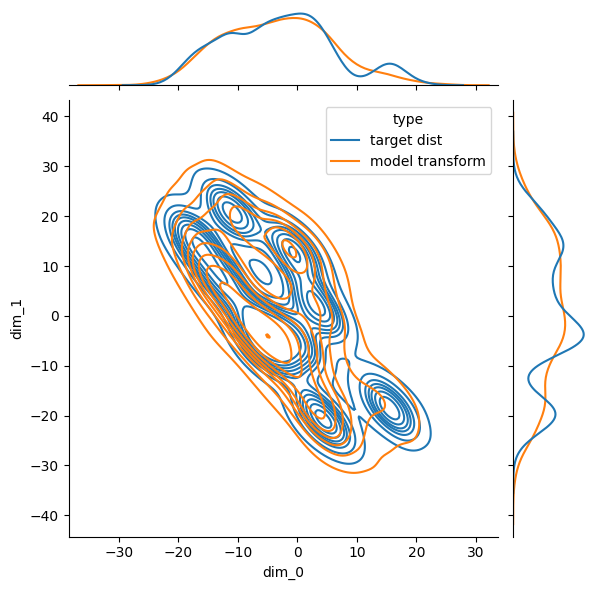

trail: 0 m step: 7 kl_test: 6.810688018798828


  2%|▏         | 100/6000 [00:32<35:11,  2.79it/s]

trail: 0 m step: 8 Loss: 6.252933502197266  L_n: 5.740123748779297  kld: 0.025640487670898438 KLD1: 5.668156147003174 KLD2: 2.484212875366211


  3%|▎         | 200/6000 [01:04<34:19,  2.82it/s]

trail: 0 m step: 8 Loss: 6.260196685791016  L_n: 5.731632232666016  kld: 0.02642822265625 KLD1: 5.618145942687988 KLD2: 2.4876413345336914


  5%|▌         | 300/6000 [01:36<33:32,  2.83it/s]

trail: 0 m step: 8 Loss: 6.160951614379883  L_n: 5.645853042602539  kld: 0.025754928588867188 KLD1: 5.609199523925781 KLD2: 2.4552717208862305


  7%|▋         | 400/6000 [02:08<33:00,  2.83it/s]

trail: 0 m step: 8 Loss: 5.978788375854492  L_n: 5.607275009155273  kld: 0.018575668334960938 KLD1: 5.769167423248291 KLD2: 2.4477171897888184


  8%|▊         | 500/6000 [02:40<32:18,  2.84it/s]

trail: 0 m step: 8 Loss: 6.166187286376953  L_n: 5.628124237060547  kld: 0.026903152465820312 KLD1: 5.632152080535889 KLD2: 2.466038942337036


 10%|█         | 600/6000 [03:12<31:59,  2.81it/s]

trail: 0 m step: 8 Loss: 6.229440689086914  L_n: 5.610849380493164  kld: 0.0309295654296875 KLD1: 5.516119956970215 KLD2: 2.473473310470581


 12%|█▏        | 700/6000 [03:44<31:23,  2.81it/s]

trail: 0 m step: 8 Loss: 6.151430130004883  L_n: 5.585405349731445  kld: 0.028301239013671875 KLD1: 5.558498859405518 KLD2: 2.4392807483673096


 13%|█▎        | 800/6000 [04:16<30:47,  2.81it/s]

trail: 0 m step: 8 Loss: 6.177755355834961  L_n: 5.60932731628418  kld: 0.028421401977539062 KLD1: 5.594127178192139 KLD2: 2.466724157333374


 15%|█▌        | 900/6000 [04:48<30:07,  2.82it/s]

trail: 0 m step: 8 Loss: 6.131425857543945  L_n: 5.553651809692383  kld: 0.028888702392578125 KLD1: 5.59950590133667 KLD2: 2.478987216949463


 17%|█▋        | 1000/6000 [05:20<29:29,  2.83it/s]

trail: 0 m step: 8 Loss: 5.966920852661133  L_n: 5.484781265258789  kld: 0.024106979370117188 KLD1: 5.560788154602051 KLD2: 2.457305908203125


 18%|█▊        | 1100/6000 [05:52<28:59,  2.82it/s]

trail: 0 m step: 8 Loss: 6.109689712524414  L_n: 5.562776565551758  kld: 0.027345657348632812 KLD1: 5.578644752502441 KLD2: 2.4659619331359863


 20%|██        | 1200/6000 [06:24<28:21,  2.82it/s]

trail: 0 m step: 8 Loss: 6.067874908447266  L_n: 5.503643035888672  kld: 0.028211593627929688 KLD1: 5.55531644821167 KLD2: 2.47920560836792


 22%|██▏       | 1300/6000 [06:56<27:39,  2.83it/s]

trail: 0 m step: 8 Loss: 6.055934906005859  L_n: 5.556285858154297  kld: 0.024982452392578125 KLD1: 5.638625144958496 KLD2: 2.4886746406555176


 23%|██▎       | 1400/6000 [07:28<27:11,  2.82it/s]

trail: 0 m step: 8 Loss: 6.230924606323242  L_n: 5.627286911010742  kld: 0.030181884765625 KLD1: 5.513025283813477 KLD2: 2.4341940879821777


 25%|██▌       | 1500/6000 [08:00<26:36,  2.82it/s]

trail: 0 m step: 8 Loss: 6.155664443969727  L_n: 5.571367263793945  kld: 0.029214859008789062 KLD1: 5.498054027557373 KLD2: 2.418654441833496


 27%|██▋       | 1600/6000 [08:33<25:59,  2.82it/s]

trail: 0 m step: 8 Loss: 6.190093994140625  L_n: 5.612739562988281  kld: 0.028867721557617188 KLD1: 5.516751289367676 KLD2: 2.4296650886535645


 28%|██▊       | 1700/6000 [09:05<25:22,  2.83it/s]

trail: 0 m step: 8 Loss: 6.18681526184082  L_n: 5.675188064575195  kld: 0.02558135986328125 KLD1: 5.604859828948975 KLD2: 2.4718570709228516


 30%|███       | 1800/6000 [09:37<24:49,  2.82it/s]

trail: 0 m step: 8 Loss: 6.066722869873047  L_n: 5.481700897216797  kld: 0.0292510986328125 KLD1: 5.57328987121582 KLD2: 2.437016248703003


 32%|███▏      | 1900/6000 [10:09<24:11,  2.83it/s]

trail: 0 m step: 8 Loss: 6.057783126831055  L_n: 5.491415023803711  kld: 0.028318405151367188 KLD1: 5.557360649108887 KLD2: 2.461948871612549


 33%|███▎      | 2000/6000 [10:41<23:37,  2.82it/s]

trail: 0 m step: 8 Loss: 6.1189117431640625  L_n: 5.585121154785156  kld: 0.026689529418945312 KLD1: 5.554830074310303 KLD2: 2.4483602046966553


 35%|███▌      | 2100/6000 [11:13<23:02,  2.82it/s]

trail: 0 m step: 8 Loss: 6.057960510253906  L_n: 5.420867919921875  kld: 0.03185462951660156 KLD1: 5.484282493591309 KLD2: 2.4500033855438232


 37%|███▋      | 2200/6000 [11:45<22:28,  2.82it/s]

trail: 0 m step: 8 Loss: 6.074962615966797  L_n: 5.504665374755859  kld: 0.028514862060546875 KLD1: 5.551259517669678 KLD2: 2.448096513748169


 38%|███▊      | 2300/6000 [12:17<21:52,  2.82it/s]

trail: 0 m step: 8 Loss: 6.075323104858398  L_n: 5.525205612182617  kld: 0.027505874633789062 KLD1: 5.562541484832764 KLD2: 2.4263768196105957


 40%|████      | 2400/6000 [12:49<21:20,  2.81it/s]

trail: 0 m step: 8 Loss: 6.147651672363281  L_n: 5.6237030029296875  kld: 0.026197433471679688 KLD1: 5.5600762367248535 KLD2: 2.448521375656128


 42%|████▏     | 2500/6000 [13:21<20:40,  2.82it/s]

trail: 0 m step: 8 Loss: 6.029304504394531  L_n: 5.537017822265625  kld: 0.024614334106445312 KLD1: 5.536358833312988 KLD2: 2.4527812004089355


 43%|████▎     | 2600/6000 [13:53<20:02,  2.83it/s]

trail: 0 m step: 8 Loss: 6.034934997558594  L_n: 5.443428039550781  kld: 0.029575347900390625 KLD1: 5.47012186050415 KLD2: 2.4234495162963867


 45%|████▌     | 2700/6000 [14:25<19:32,  2.82it/s]

trail: 0 m step: 8 Loss: 6.080944061279297  L_n: 5.514385223388672  kld: 0.02832794189453125 KLD1: 5.4802656173706055 KLD2: 2.447944164276123


 47%|████▋     | 2800/6000 [14:57<18:55,  2.82it/s]

trail: 0 m step: 8 Loss: 6.093526840209961  L_n: 5.51167106628418  kld: 0.029092788696289062 KLD1: 5.496700286865234 KLD2: 2.4502506256103516


 48%|████▊     | 2900/6000 [15:29<18:18,  2.82it/s]

trail: 0 m step: 8 Loss: 6.157121658325195  L_n: 5.548982620239258  kld: 0.030406951904296875 KLD1: 5.466860771179199 KLD2: 2.452352285385132


 50%|█████     | 3000/6000 [16:01<17:47,  2.81it/s]

trail: 0 m step: 8 Loss: 6.067026138305664  L_n: 5.505731582641602  kld: 0.028064727783203125 KLD1: 5.500751972198486 KLD2: 2.4217543601989746


 52%|█████▏    | 3100/6000 [16:33<17:06,  2.83it/s]

trail: 0 m step: 8 Loss: 5.931983947753906  L_n: 5.45159912109375  kld: 0.024019241333007812 KLD1: 5.6598405838012695 KLD2: 2.4115214347839355


 53%|█████▎    | 3200/6000 [17:06<16:33,  2.82it/s]

trail: 0 m step: 8 Loss: 6.147909164428711  L_n: 5.51081657409668  kld: 0.03185462951660156 KLD1: 5.41984748840332 KLD2: 2.403369188308716


 55%|█████▌    | 3300/6000 [17:38<15:54,  2.83it/s]

trail: 0 m step: 8 Loss: 6.067956924438477  L_n: 5.525888442993164  kld: 0.027103424072265625 KLD1: 5.514121055603027 KLD2: 2.4142744541168213


 57%|█████▋    | 3400/6000 [18:10<15:18,  2.83it/s]

trail: 0 m step: 8 Loss: 6.006265640258789  L_n: 5.40159797668457  kld: 0.030233383178710938 KLD1: 5.478504657745361 KLD2: 2.444175958633423


 58%|█████▊    | 3500/6000 [18:42<14:47,  2.82it/s]

trail: 0 m step: 8 Loss: 6.121297836303711  L_n: 5.553327560424805  kld: 0.028398513793945312 KLD1: 5.546283721923828 KLD2: 2.453080892562866


 60%|██████    | 3600/6000 [19:14<14:12,  2.82it/s]

trail: 0 m step: 8 Loss: 5.991647720336914  L_n: 5.394418716430664  kld: 0.0298614501953125 KLD1: 5.5015974044799805 KLD2: 2.4635348320007324


 62%|██████▏   | 3700/6000 [19:46<13:35,  2.82it/s]

trail: 0 m step: 8 Loss: 6.007467269897461  L_n: 5.438314437866211  kld: 0.0284576416015625 KLD1: 5.512598991394043 KLD2: 2.4321532249450684


 63%|██████▎   | 3800/6000 [20:18<12:58,  2.83it/s]

trail: 0 m step: 8 Loss: 5.997547149658203  L_n: 5.514682769775391  kld: 0.024143218994140625 KLD1: 5.606756210327148 KLD2: 2.418424367904663


 65%|██████▌   | 3900/6000 [20:50<12:21,  2.83it/s]

trail: 0 m step: 8 Loss: 6.066337585449219  L_n: 5.429435729980469  kld: 0.0318450927734375 KLD1: 5.464837551116943 KLD2: 2.4094300270080566


 67%|██████▋   | 4000/6000 [21:22<11:49,  2.82it/s]

trail: 0 m step: 8 Loss: 6.121286392211914  L_n: 5.47618293762207  kld: 0.03225517272949219 KLD1: 5.44736385345459 KLD2: 2.436164379119873


 68%|██████▊   | 4100/6000 [21:54<11:13,  2.82it/s]

trail: 0 m step: 8 Loss: 6.137479782104492  L_n: 5.487417221069336  kld: 0.03250312805175781 KLD1: 5.38432502746582 KLD2: 2.427204132080078


 70%|███████   | 4200/6000 [22:26<10:41,  2.81it/s]

trail: 0 m step: 8 Loss: 5.988012313842773  L_n: 5.443845748901367  kld: 0.027208328247070312 KLD1: 5.546835422515869 KLD2: 2.4362902641296387


 72%|███████▏  | 4300/6000 [22:58<10:02,  2.82it/s]

trail: 0 m step: 8 Loss: 6.053804397583008  L_n: 5.524324417114258  kld: 0.0264739990234375 KLD1: 5.55717134475708 KLD2: 2.462388515472412


 73%|███████▎  | 4400/6000 [23:30<09:26,  2.82it/s]

trail: 0 m step: 8 Loss: 6.010324478149414  L_n: 5.439531326293945  kld: 0.028539657592773438 KLD1: 5.527172565460205 KLD2: 2.4342377185821533


 75%|███████▌  | 4500/6000 [24:02<08:52,  2.82it/s]

trail: 0 m step: 8 Loss: 6.064462661743164  L_n: 5.481805801391602  kld: 0.029132843017578125 KLD1: 5.4482293128967285 KLD2: 2.4253487586975098


 77%|███████▋  | 4600/6000 [24:34<08:16,  2.82it/s]

trail: 0 m step: 8 Loss: 6.072551727294922  L_n: 5.510417938232422  kld: 0.028106689453125 KLD1: 5.510939121246338 KLD2: 2.466082811355591


 78%|███████▊  | 4700/6000 [25:06<07:41,  2.82it/s]

trail: 0 m step: 8 Loss: 5.8919525146484375  L_n: 5.4360198974609375  kld: 0.022796630859375 KLD1: 5.592013359069824 KLD2: 2.4391865730285645


 80%|████████  | 4800/6000 [25:39<07:04,  2.82it/s]

trail: 0 m step: 8 Loss: 6.042964935302734  L_n: 5.532787322998047  kld: 0.025508880615234375 KLD1: 5.545912265777588 KLD2: 2.4358322620391846


 82%|████████▏ | 4900/6000 [26:11<06:30,  2.82it/s]

trail: 0 m step: 8 Loss: 6.0387420654296875  L_n: 5.480079650878906  kld: 0.027933120727539062 KLD1: 5.52275276184082 KLD2: 2.4268648624420166


 83%|████████▎ | 5000/6000 [26:43<05:53,  2.83it/s]

trail: 0 m step: 8 Loss: 6.053678512573242  L_n: 5.477811813354492  kld: 0.0287933349609375 KLD1: 5.508059024810791 KLD2: 2.447676420211792


 85%|████████▌ | 5100/6000 [27:15<05:20,  2.81it/s]

trail: 0 m step: 8 Loss: 5.866687774658203  L_n: 5.339534759521484  kld: 0.026357650756835938 KLD1: 5.5725860595703125 KLD2: 2.452989101409912


 87%|████████▋ | 5200/6000 [27:47<04:43,  2.83it/s]

trail: 0 m step: 8 Loss: 6.111087799072266  L_n: 5.506687164306641  kld: 0.03022003173828125 KLD1: 5.45218563079834 KLD2: 2.441690444946289


 88%|████████▊ | 5300/6000 [28:19<04:08,  2.81it/s]

trail: 0 m step: 8 Loss: 6.063589096069336  L_n: 5.485090255737305  kld: 0.028924942016601562 KLD1: 5.460160255432129 KLD2: 2.4221854209899902


 90%|█████████ | 5400/6000 [28:51<03:33,  2.81it/s]

trail: 0 m step: 8 Loss: 5.978490829467773  L_n: 5.453359603881836  kld: 0.026256561279296875 KLD1: 5.59127950668335 KLD2: 2.4305155277252197


 92%|█████████▏| 5500/6000 [29:23<02:56,  2.83it/s]

trail: 0 m step: 8 Loss: 6.147205352783203  L_n: 5.505191802978516  kld: 0.032100677490234375 KLD1: 5.420938491821289 KLD2: 2.430074691772461


 93%|█████████▎| 5600/6000 [29:55<02:21,  2.82it/s]

trail: 0 m step: 8 Loss: 6.154279708862305  L_n: 5.561742782592773  kld: 0.029626846313476562 KLD1: 5.453521728515625 KLD2: 2.4282023906707764


 95%|█████████▌| 5700/6000 [30:27<01:46,  2.82it/s]

trail: 0 m step: 8 Loss: 6.035787582397461  L_n: 5.51466178894043  kld: 0.026056289672851562 KLD1: 5.531750679016113 KLD2: 2.4510555267333984


 97%|█████████▋| 5800/6000 [30:59<01:10,  2.82it/s]

trail: 0 m step: 8 Loss: 6.081504821777344  L_n: 5.520515441894531  kld: 0.028049468994140625 KLD1: 5.489593029022217 KLD2: 2.423767566680908


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.81it/s]

trail: 0 m step: 8 Loss: 6.095281600952148  L_n: 5.476308822631836  kld: 0.030948638916015625 KLD1: 5.411003589630127 KLD2: 2.44770884513855


100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

trail: 0 m step: 8 Loss: 6.004770278930664  L_n: 5.404108047485352  kld: 0.030033111572265625 KLD1: 5.422399520874023 KLD2: 2.4418039321899414



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


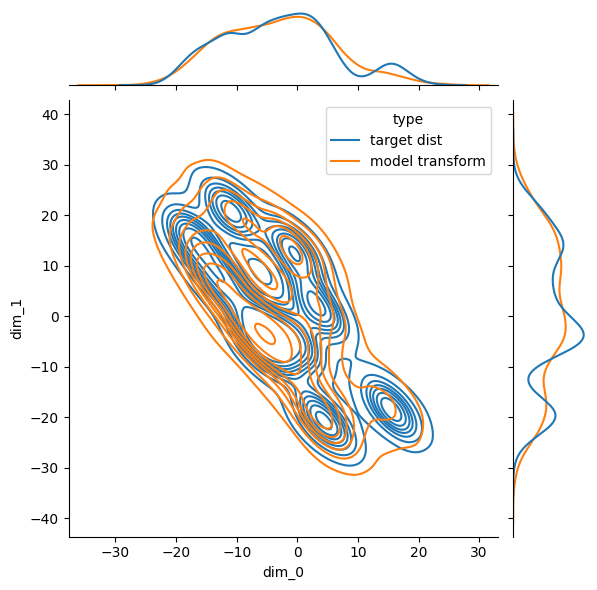

trail: 0 m step: 8 kl_test: 5.53687858581543


  2%|▏         | 100/6000 [00:32<35:25,  2.78it/s]

trail: 0 m step: 9 Loss: 5.16417121887207  L_n: 4.778543472290039  kld: 0.019281387329101562 KLD1: 4.688634395599365 KLD2: 2.1611156463623047


  3%|▎         | 200/6000 [01:04<34:21,  2.81it/s]

trail: 0 m step: 9 Loss: 5.1488037109375  L_n: 4.738075256347656  kld: 0.020536422729492188 KLD1: 4.6408467292785645 KLD2: 2.161712884902954


  5%|▌         | 300/6000 [01:36<33:54,  2.80it/s]

trail: 0 m step: 9 Loss: 5.043066024780273  L_n: 4.624174118041992  kld: 0.020944595336914062 KLD1: 4.60501766204834 KLD2: 2.1294374465942383


  7%|▋         | 400/6000 [02:08<33:23,  2.79it/s]

trail: 0 m step: 9 Loss: 4.920497894287109  L_n: 4.625392913818359  kld: 0.0147552490234375 KLD1: 4.77877950668335 KLD2: 2.1196982860565186


  8%|▊         | 500/6000 [02:41<32:45,  2.80it/s]

trail: 0 m step: 9 Loss: 5.066688537597656  L_n: 4.645660400390625  kld: 0.021051406860351562 KLD1: 4.616672992706299 KLD2: 2.143258571624756


 10%|█         | 600/6000 [03:13<32:02,  2.81it/s]

trail: 0 m step: 9 Loss: 5.110507965087891  L_n: 4.627109527587891  kld: 0.024169921875 KLD1: 4.522454738616943 KLD2: 2.1561279296875


 12%|█▏        | 700/6000 [03:45<31:39,  2.79it/s]

trail: 0 m step: 9 Loss: 5.080373764038086  L_n: 4.625280380249023  kld: 0.022754669189453125 KLD1: 4.594035625457764 KLD2: 2.121954917907715


 13%|█▎        | 800/6000 [04:18<30:54,  2.80it/s]

trail: 0 m step: 9 Loss: 5.0986328125  L_n: 4.650138854980469  kld: 0.022424697875976562 KLD1: 4.620189666748047 KLD2: 2.1449413299560547


 15%|█▌        | 900/6000 [04:50<30:19,  2.80it/s]

trail: 0 m step: 9 Loss: 5.038686752319336  L_n: 4.571043014526367  kld: 0.023382186889648438 KLD1: 4.61850643157959 KLD2: 2.1542603969573975


 17%|█▋        | 1000/6000 [05:22<29:50,  2.79it/s]

trail: 0 m step: 9 Loss: 4.928899765014648  L_n: 4.542547225952148  kld: 0.019317626953125 KLD1: 4.5823140144348145 KLD2: 2.1330554485321045


 18%|█▊        | 1100/6000 [05:54<29:07,  2.80it/s]

trail: 0 m step: 9 Loss: 5.029449462890625  L_n: 4.610137939453125  kld: 0.020965576171875 KLD1: 4.598615646362305 KLD2: 2.144613742828369


 20%|██        | 1200/6000 [06:27<28:33,  2.80it/s]

trail: 0 m step: 9 Loss: 4.997638702392578  L_n: 4.546932220458984  kld: 0.022535324096679688 KLD1: 4.591574192047119 KLD2: 2.1527252197265625


 22%|██▏       | 1300/6000 [06:59<27:57,  2.80it/s]

trail: 0 m step: 9 Loss: 4.985599517822266  L_n: 4.588718414306641  kld: 0.01984405517578125 KLD1: 4.679793834686279 KLD2: 2.165822982788086


 23%|██▎       | 1400/6000 [07:31<27:18,  2.81it/s]

trail: 0 m step: 9 Loss: 5.129709243774414  L_n: 4.66069221496582  kld: 0.023450851440429688 KLD1: 4.555413722991943 KLD2: 2.114489793777466


 25%|██▌       | 1500/6000 [08:04<26:48,  2.80it/s]

trail: 0 m step: 9 Loss: 5.038778305053711  L_n: 4.587766647338867  kld: 0.022550582885742188 KLD1: 4.550207138061523 KLD2: 2.103774309158325


 27%|██▋       | 1600/6000 [08:36<26:10,  2.80it/s]

trail: 0 m step: 9 Loss: 5.060085296630859  L_n: 4.610027313232422  kld: 0.022502899169921875 KLD1: 4.53385066986084 KLD2: 2.110243797302246


 28%|██▊       | 1700/6000 [09:08<25:32,  2.81it/s]

trail: 0 m step: 9 Loss: 5.084539413452148  L_n: 4.686017990112305  kld: 0.019926071166992188 KLD1: 4.6458024978637695 KLD2: 2.153524875640869


 30%|███       | 1800/6000 [09:40<24:59,  2.80it/s]

trail: 0 m step: 9 Loss: 4.933616638183594  L_n: 4.4820709228515625  kld: 0.022577285766601562 KLD1: 4.591746807098389 KLD2: 2.1120283603668213


 32%|███▏      | 1900/6000 [10:12<24:19,  2.81it/s]

trail: 0 m step: 9 Loss: 4.970905303955078  L_n: 4.525882720947266  kld: 0.022251129150390625 KLD1: 4.5967206954956055 KLD2: 2.1391704082489014


 33%|███▎      | 2000/6000 [10:45<23:47,  2.80it/s]

trail: 0 m step: 9 Loss: 5.028284072875977  L_n: 4.598978042602539  kld: 0.021465301513671875 KLD1: 4.605023384094238 KLD2: 2.129387140274048


 35%|███▌      | 2100/6000 [11:17<23:10,  2.80it/s]

trail: 0 m step: 9 Loss: 5.032604217529297  L_n: 4.517238616943359  kld: 0.025768280029296875 KLD1: 4.496049404144287 KLD2: 2.131254196166992


 37%|███▋      | 2200/6000 [11:49<22:37,  2.80it/s]

trail: 0 m step: 9 Loss: 5.006065368652344  L_n: 4.559059143066406  kld: 0.022350311279296875 KLD1: 4.582041263580322 KLD2: 2.128251552581787


 38%|███▊      | 2300/6000 [12:21<21:55,  2.81it/s]

trail: 0 m step: 9 Loss: 4.982942581176758  L_n: 4.550203323364258  kld: 0.021636962890625 KLD1: 4.584023475646973 KLD2: 2.1062467098236084


 40%|████      | 2400/6000 [12:53<21:27,  2.80it/s]

trail: 0 m step: 9 Loss: 5.036109924316406  L_n: 4.63323974609375  kld: 0.020143508911132812 KLD1: 4.616645812988281 KLD2: 2.1295297145843506


 42%|████▏     | 2500/6000 [13:26<20:45,  2.81it/s]

trail: 0 m step: 9 Loss: 4.96885871887207  L_n: 4.580865859985352  kld: 0.019399642944335938 KLD1: 4.5362348556518555 KLD2: 2.1325740814208984


 43%|████▎     | 2600/6000 [13:58<20:14,  2.80it/s]

trail: 0 m step: 9 Loss: 4.962909698486328  L_n: 4.505031585693359  kld: 0.022893905639648438 KLD1: 4.5210676193237305 KLD2: 2.105597496032715


 45%|████▌     | 2700/6000 [14:30<19:30,  2.82it/s]

trail: 0 m step: 9 Loss: 5.01844596862793  L_n: 4.572050094604492  kld: 0.022319793701171875 KLD1: 4.534648895263672 KLD2: 2.127019166946411


 47%|████▋     | 2800/6000 [15:02<18:59,  2.81it/s]

trail: 0 m step: 9 Loss: 5.029712677001953  L_n: 4.565921783447266  kld: 0.023189544677734375 KLD1: 4.49639892578125 KLD2: 2.128509044647217


 48%|████▊     | 2900/6000 [15:34<18:26,  2.80it/s]

trail: 0 m step: 9 Loss: 5.076936721801758  L_n: 4.609254837036133  kld: 0.02338409423828125 KLD1: 4.535749912261963 KLD2: 2.136690378189087


 50%|█████     | 3000/6000 [16:07<17:46,  2.81it/s]

trail: 0 m step: 9 Loss: 4.9502105712890625  L_n: 4.524528503417969  kld: 0.021284103393554688 KLD1: 4.579139709472656 KLD2: 2.1048965454101562


 52%|█████▏    | 3100/6000 [16:39<17:12,  2.81it/s]

trail: 0 m step: 9 Loss: 4.847446441650391  L_n: 4.495235443115234  kld: 0.017610549926757812 KLD1: 4.641153335571289 KLD2: 2.096621513366699


 53%|█████▎    | 3200/6000 [17:11<16:36,  2.81it/s]

trail: 0 m step: 9 Loss: 5.054018020629883  L_n: 4.565736770629883  kld: 0.0244140625 KLD1: 4.492090702056885 KLD2: 2.090212106704712


 55%|█████▌    | 3300/6000 [17:43<15:59,  2.81it/s]

trail: 0 m step: 9 Loss: 5.015537261962891  L_n: 4.592601776123047  kld: 0.021146774291992188 KLD1: 4.555947303771973 KLD2: 2.0967469215393066


 57%|█████▋    | 3400/6000 [18:15<15:23,  2.81it/s]

trail: 0 m step: 9 Loss: 4.921422958374023  L_n: 4.449621200561523  kld: 0.023590087890625 KLD1: 4.516946315765381 KLD2: 2.1264381408691406


 58%|█████▊    | 3500/6000 [18:47<14:53,  2.80it/s]

trail: 0 m step: 9 Loss: 5.039632797241211  L_n: 4.608572006225586  kld: 0.02155303955078125 KLD1: 4.579078197479248 KLD2: 2.1389968395233154


 60%|██████    | 3600/6000 [19:20<14:09,  2.83it/s]

trail: 0 m step: 9 Loss: 4.930742263793945  L_n: 4.461725234985352  kld: 0.023450851440429688 KLD1: 4.539289951324463 KLD2: 2.1462883949279785


 62%|██████▏   | 3700/6000 [19:52<13:37,  2.81it/s]

trail: 0 m step: 9 Loss: 4.97303581237793  L_n: 4.527708053588867  kld: 0.022266387939453125 KLD1: 4.575149059295654 KLD2: 2.1198596954345703


 63%|██████▎   | 3800/6000 [20:24<13:04,  2.80it/s]

trail: 0 m step: 9 Loss: 4.917943954467773  L_n: 4.554975509643555  kld: 0.018148422241210938 KLD1: 4.676756858825684 KLD2: 2.104919910430908


 65%|██████▌   | 3900/6000 [20:56<12:27,  2.81it/s]

trail: 0 m step: 9 Loss: 4.966480255126953  L_n: 4.466716766357422  kld: 0.024988174438476562 KLD1: 4.496885776519775 KLD2: 2.094552755355835


 67%|██████▋   | 4000/6000 [21:28<11:53,  2.80it/s]

trail: 0 m step: 9 Loss: 5.044963836669922  L_n: 4.530971527099609  kld: 0.025699615478515625 KLD1: 4.472442626953125 KLD2: 2.1164984703063965


 68%|██████▊   | 4100/6000 [22:00<11:16,  2.81it/s]

trail: 0 m step: 9 Loss: 5.060247421264648  L_n: 4.53553581237793  kld: 0.026235580444335938 KLD1: 4.438358306884766 KLD2: 2.107940912246704


 70%|███████   | 4200/6000 [22:33<10:40,  2.81it/s]

trail: 0 m step: 9 Loss: 4.931264877319336  L_n: 4.50916862487793  kld: 0.021104812622070312 KLD1: 4.592112064361572 KLD2: 2.118244171142578


 72%|███████▏  | 4300/6000 [23:05<10:05,  2.81it/s]

trail: 0 m step: 9 Loss: 4.959615707397461  L_n: 4.547018051147461  kld: 0.0206298828125 KLD1: 4.59623908996582 KLD2: 2.1420440673828125


 73%|███████▎  | 4400/6000 [23:37<09:29,  2.81it/s]

trail: 0 m step: 9 Loss: 4.942905426025391  L_n: 4.513675689697266  kld: 0.02146148681640625 KLD1: 4.55599308013916 KLD2: 2.117032766342163


 75%|███████▌  | 4500/6000 [24:09<08:53,  2.81it/s]

trail: 0 m step: 9 Loss: 4.955230712890625  L_n: 4.5019683837890625  kld: 0.022663116455078125 KLD1: 4.498029708862305 KLD2: 2.107086658477783


 77%|███████▋  | 4600/6000 [24:41<08:17,  2.81it/s]

trail: 0 m step: 9 Loss: 4.987646102905273  L_n: 4.541402816772461  kld: 0.022312164306640625 KLD1: 4.540987968444824 KLD2: 2.145522117614746


 78%|███████▊  | 4700/6000 [25:13<07:40,  2.82it/s]

trail: 0 m step: 9 Loss: 4.815891265869141  L_n: 4.492481231689453  kld: 0.016170501708984375 KLD1: 4.643440246582031 KLD2: 2.1230218410491943


 80%|████████  | 4800/6000 [25:46<07:08,  2.80it/s]

trail: 0 m step: 9 Loss: 4.953348159790039  L_n: 4.56230354309082  kld: 0.019552230834960938 KLD1: 4.5884785652160645 KLD2: 2.1164491176605225


 82%|████████▏ | 4900/6000 [26:18<06:30,  2.82it/s]

trail: 0 m step: 9 Loss: 4.93937873840332  L_n: 4.506677627563477  kld: 0.021635055541992188 KLD1: 4.550814628601074 KLD2: 2.108682870864868


 83%|████████▎ | 5000/6000 [26:50<05:55,  2.81it/s]

trail: 0 m step: 9 Loss: 4.939542770385742  L_n: 4.497190475463867  kld: 0.02211761474609375 KLD1: 4.545116901397705 KLD2: 2.127272129058838


 85%|████████▌ | 5100/6000 [27:22<05:20,  2.81it/s]

trail: 0 m step: 9 Loss: 4.808723449707031  L_n: 4.402458190917969  kld: 0.020313262939453125 KLD1: 4.579488277435303 KLD2: 2.132498025894165


 87%|████████▋ | 5200/6000 [27:54<04:43,  2.82it/s]

trail: 0 m step: 9 Loss: 5.024580001831055  L_n: 4.554914474487305  kld: 0.0234832763671875 KLD1: 4.496714115142822 KLD2: 2.123368740081787


 88%|████████▊ | 5300/6000 [28:26<04:09,  2.81it/s]

trail: 0 m step: 9 Loss: 5.008279800415039  L_n: 4.55803108215332  kld: 0.022512435913085938 KLD1: 4.521380424499512 KLD2: 2.105236053466797


 90%|█████████ | 5400/6000 [28:58<03:33,  2.81it/s]

trail: 0 m step: 9 Loss: 4.934623718261719  L_n: 4.523399353027344  kld: 0.02056121826171875 KLD1: 4.613372325897217 KLD2: 2.114140510559082


 92%|█████████▏| 5500/6000 [29:30<02:57,  2.82it/s]

trail: 0 m step: 9 Loss: 5.0618438720703125  L_n: 4.581153869628906  kld: 0.024034500122070312 KLD1: 4.501601219177246 KLD2: 2.115650177001953


 93%|█████████▎| 5600/6000 [30:03<02:22,  2.82it/s]

trail: 0 m step: 9 Loss: 5.072488784790039  L_n: 4.615869522094727  kld: 0.022830963134765625 KLD1: 4.4927825927734375 KLD2: 2.1102325916290283


 95%|█████████▌| 5700/6000 [30:35<01:46,  2.81it/s]

trail: 0 m step: 9 Loss: 4.972099304199219  L_n: 4.5672454833984375  kld: 0.020242691040039062 KLD1: 4.545843601226807 KLD2: 2.1305885314941406


 97%|█████████▋| 5800/6000 [31:07<01:11,  2.81it/s]

trail: 0 m step: 9 Loss: 5.004491806030273  L_n: 4.570150375366211  kld: 0.021717071533203125 KLD1: 4.528345584869385 KLD2: 2.1087565422058105


 98%|█████████▊| 5900/6000 [31:39<00:35,  2.82it/s]

trail: 0 m step: 9 Loss: 5.032936096191406  L_n: 4.5402679443359375  kld: 0.024633407592773438 KLD1: 4.4571404457092285 KLD2: 2.1292154788970947


100%|██████████| 6000/6000 [32:11<00:00,  3.11it/s]

trail: 0 m step: 9 Loss: 4.928977966308594  L_n: 4.46820068359375  kld: 0.023038864135742188 KLD1: 4.494992256164551 KLD2: 2.1258418560028076



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


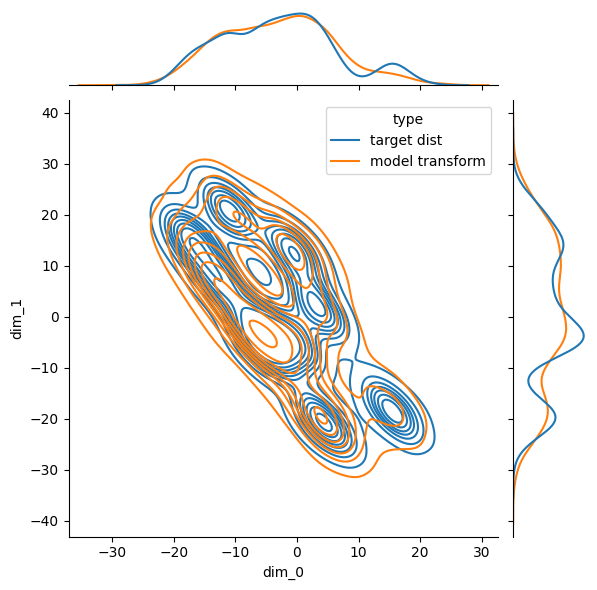

trail: 0 m step: 9 kl_test: 4.592876434326172


  2%|▏         | 100/6000 [00:32<35:12,  2.79it/s]

trail: 0 m step: 10 Loss: 4.293418884277344  L_n: 3.9674530029296875  kld: 0.016298294067382812 KLD1: 3.9241299629211426 KLD2: 1.8840140104293823


  3%|▎         | 200/6000 [01:04<34:10,  2.83it/s]

trail: 0 m step: 10 Loss: 4.250272750854492  L_n: 3.933195114135742  kld: 0.0158538818359375 KLD1: 3.8779847621917725 KLD2: 1.8922948837280273


  5%|▌         | 300/6000 [01:36<33:40,  2.82it/s]

trail: 0 m step: 10 Loss: 4.203037261962891  L_n: 3.886608123779297  kld: 0.015821456909179688 KLD1: 3.9029314517974854 KLD2: 1.865607738494873


  7%|▋         | 400/6000 [02:08<33:10,  2.81it/s]

trail: 0 m step: 10 Loss: 4.109256744384766  L_n: 3.890026092529297  kld: 0.010961532592773438 KLD1: 4.000836372375488 KLD2: 1.8541417121887207


  8%|▊         | 500/6000 [02:40<32:24,  2.83it/s]

trail: 0 m step: 10 Loss: 4.2274322509765625  L_n: 3.882049560546875  kld: 0.017269134521484375 KLD1: 3.840498447418213 KLD2: 1.8758589029312134


 10%|█         | 600/6000 [03:12<31:53,  2.82it/s]

trail: 0 m step: 10 Loss: 4.287212371826172  L_n: 3.8840370178222656  kld: 0.020158767700195312 KLD1: 3.8206472396850586 KLD2: 1.8862179517745972


 12%|█▏        | 700/6000 [03:44<31:20,  2.82it/s]

trail: 0 m step: 10 Loss: 4.234348297119141  L_n: 3.849254608154297  kld: 0.019254684448242188 KLD1: 3.8271796703338623 KLD2: 1.8493374586105347


 13%|█▎        | 800/6000 [04:16<30:42,  2.82it/s]

trail: 0 m step: 10 Loss: 4.203144073486328  L_n: 3.808208465576172  kld: 0.019746780395507812 KLD1: 3.8121466636657715 KLD2: 1.8736740350723267


 15%|█▌        | 900/6000 [04:48<29:58,  2.84it/s]

trail: 0 m step: 10 Loss: 4.203716278076172  L_n: 3.8353309631347656  kld: 0.018419265747070312 KLD1: 3.8392398357391357 KLD2: 1.888671636581421


 17%|█▋        | 1000/6000 [05:20<29:32,  2.82it/s]

trail: 0 m step: 10 Loss: 4.097064971923828  L_n: 3.780559539794922  kld: 0.015825271606445312 KLD1: 3.8569741249084473 KLD2: 1.8679417371749878


 18%|█▊        | 1100/6000 [05:52<28:57,  2.82it/s]

trail: 0 m step: 10 Loss: 4.192417144775391  L_n: 3.8336448669433594  kld: 0.017938613891601562 KLD1: 3.838550567626953 KLD2: 1.8734132051467896


 20%|██        | 1200/6000 [06:24<28:19,  2.82it/s]

trail: 0 m step: 10 Loss: 4.144962310791016  L_n: 3.798511505126953  kld: 0.017322540283203125 KLD1: 3.853102684020996 KLD2: 1.8849831819534302


 22%|██▏       | 1300/6000 [06:56<27:33,  2.84it/s]

trail: 0 m step: 10 Loss: 4.119285583496094  L_n: 3.8134994506835938  kld: 0.015289306640625 KLD1: 3.9254233837127686 KLD2: 1.8944995403289795


 23%|██▎       | 1400/6000 [07:28<27:04,  2.83it/s]

trail: 0 m step: 10 Loss: 4.254138946533203  L_n: 3.8825111389160156  kld: 0.018581390380859375 KLD1: 3.8155670166015625 KLD2: 1.8531675338745117


 25%|██▌       | 1500/6000 [08:00<26:30,  2.83it/s]

trail: 0 m step: 10 Loss: 4.179784774780273  L_n: 3.814565658569336  kld: 0.018260955810546875 KLD1: 3.760505437850952 KLD2: 1.8364139795303345


 27%|██▋       | 1600/6000 [08:32<26:00,  2.82it/s]

trail: 0 m step: 10 Loss: 4.206306457519531  L_n: 3.8289947509765625  kld: 0.018865585327148438 KLD1: 3.784684658050537 KLD2: 1.844455599784851


 28%|██▊       | 1700/6000 [09:04<25:13,  2.84it/s]

trail: 0 m step: 10 Loss: 4.241067886352539  L_n: 3.933908462524414  kld: 0.01535797119140625 KLD1: 3.9257476329803467 KLD2: 1.8888155221939087


 30%|███       | 1800/6000 [09:36<24:45,  2.83it/s]

trail: 0 m step: 10 Loss: 4.128793716430664  L_n: 3.7655582427978516  kld: 0.018161773681640625 KLD1: 3.8552258014678955 KLD2: 1.849098801612854


 32%|███▏      | 1900/6000 [10:08<23:56,  2.85it/s]

trail: 0 m step: 10 Loss: 4.139812469482422  L_n: 3.7805442810058594  kld: 0.017963409423828125 KLD1: 3.8420042991638184 KLD2: 1.8719892501831055


 33%|███▎      | 2000/6000 [10:40<23:35,  2.83it/s]

trail: 0 m step: 10 Loss: 4.183712005615234  L_n: 3.8455772399902344  kld: 0.01690673828125 KLD1: 3.863689661026001 KLD2: 1.8600820302963257


 35%|███▌      | 2100/6000 [11:12<23:01,  2.82it/s]

trail: 0 m step: 10 Loss: 4.190328598022461  L_n: 3.769834518432617  kld: 0.021024703979492188 KLD1: 3.7851109504699707 KLD2: 1.8651288747787476


 37%|███▋      | 2200/6000 [11:44<22:24,  2.83it/s]

trail: 0 m step: 10 Loss: 4.176458358764648  L_n: 3.8206233978271484  kld: 0.017791748046875 KLD1: 3.8290443420410156 KLD2: 1.8656432628631592


 38%|███▊      | 2300/6000 [12:16<21:49,  2.83it/s]

trail: 0 m step: 10 Loss: 4.160558700561523  L_n: 3.8233776092529297  kld: 0.016859054565429688 KLD1: 3.853165864944458 KLD2: 1.8437788486480713


 40%|████      | 2400/6000 [12:48<21:14,  2.83it/s]

trail: 0 m step: 10 Loss: 4.174615859985352  L_n: 3.8657398223876953  kld: 0.015443801879882812 KLD1: 3.867990255355835 KLD2: 1.8654553890228271


 42%|████▏     | 2500/6000 [13:20<20:40,  2.82it/s]

trail: 0 m step: 10 Loss: 4.117593765258789  L_n: 3.808565139770508  kld: 0.015451431274414062 KLD1: 3.783902168273926 KLD2: 1.8621108531951904


 43%|████▎     | 2600/6000 [13:52<20:00,  2.83it/s]

trail: 0 m step: 10 Loss: 4.140155792236328  L_n: 3.761241912841797  kld: 0.018945693969726562 KLD1: 3.772822856903076 KLD2: 1.838334560394287


 45%|████▌     | 2700/6000 [14:24<19:26,  2.83it/s]

trail: 0 m step: 10 Loss: 4.163049697875977  L_n: 3.803628921508789  kld: 0.017971038818359375 KLD1: 3.7812659740448 KLD2: 1.8612773418426514


 47%|████▋     | 2800/6000 [14:56<18:51,  2.83it/s]

trail: 0 m step: 10 Loss: 4.192481994628906  L_n: 3.81707763671875  kld: 0.018770217895507812 KLD1: 3.75771427154541 KLD2: 1.861862301826477


 48%|████▊     | 2900/6000 [15:28<18:16,  2.83it/s]

trail: 0 m step: 10 Loss: 4.25602912902832  L_n: 3.8744449615478516  kld: 0.019079208374023438 KLD1: 3.762483835220337 KLD2: 1.8693474531173706


 50%|█████     | 3000/6000 [16:01<17:41,  2.83it/s]

trail: 0 m step: 10 Loss: 4.138679504394531  L_n: 3.7969589233398438  kld: 0.017086029052734375 KLD1: 3.908754587173462 KLD2: 1.8448573350906372


 52%|█████▏    | 3100/6000 [16:33<17:07,  2.82it/s]

trail: 0 m step: 10 Loss: 4.038515090942383  L_n: 3.750581741333008  kld: 0.01439666748046875 KLD1: 3.8729045391082764 KLD2: 1.833569884300232


 53%|█████▎    | 3200/6000 [17:05<16:29,  2.83it/s]

trail: 0 m step: 10 Loss: 4.211322784423828  L_n: 3.817302703857422  kld: 0.019701004028320312 KLD1: 3.7506089210510254 KLD2: 1.829086422920227


 55%|█████▌    | 3300/6000 [17:37<15:57,  2.82it/s]

trail: 0 m step: 10 Loss: 4.157680511474609  L_n: 3.823436737060547  kld: 0.016712188720703125 KLD1: 3.795651435852051 KLD2: 1.8340095281600952


 57%|█████▋    | 3400/6000 [18:09<15:20,  2.82it/s]

trail: 0 m step: 10 Loss: 4.124439239501953  L_n: 3.742511749267578  kld: 0.01909637451171875 KLD1: 3.765737295150757 KLD2: 1.862106442451477


 58%|█████▊    | 3500/6000 [18:41<14:41,  2.84it/s]

trail: 0 m step: 10 Loss: 4.230030059814453  L_n: 3.8815574645996094  kld: 0.017423629760742188 KLD1: 3.791685104370117 KLD2: 1.8679620027542114


 60%|██████    | 3600/6000 [19:13<14:09,  2.82it/s]

trail: 0 m step: 10 Loss: 4.1445159912109375  L_n: 3.7506866455078125  kld: 0.01969146728515625 KLD1: 3.7788052558898926 KLD2: 1.880702257156372


 62%|██████▏   | 3700/6000 [19:45<13:34,  2.82it/s]

trail: 0 m step: 10 Loss: 4.141733169555664  L_n: 3.7824268341064453  kld: 0.017965316772460938 KLD1: 3.813681125640869 KLD2: 1.8546581268310547


 63%|██████▎   | 3800/6000 [20:17<12:58,  2.83it/s]

trail: 0 m step: 10 Loss: 4.1300811767578125  L_n: 3.8315811157226562  kld: 0.014925003051757812 KLD1: 3.8851988315582275 KLD2: 1.8406771421432495


 65%|██████▌   | 3900/6000 [20:49<12:24,  2.82it/s]

trail: 0 m step: 10 Loss: 4.148586273193359  L_n: 3.7485389709472656  kld: 0.020002365112304688 KLD1: 3.785569429397583 KLD2: 1.8323289155960083


 67%|██████▋   | 4000/6000 [21:21<11:46,  2.83it/s]

trail: 0 m step: 10 Loss: 4.1979827880859375  L_n: 3.7772598266601562  kld: 0.021036148071289062 KLD1: 3.725142478942871 KLD2: 1.8501827716827393


 68%|██████▊   | 4100/6000 [21:53<11:11,  2.83it/s]

trail: 0 m step: 10 Loss: 4.192493438720703  L_n: 3.775470733642578  kld: 0.02085113525390625 KLD1: 3.722425699234009 KLD2: 1.8449692726135254


 70%|███████   | 4200/6000 [22:25<10:37,  2.83it/s]

trail: 0 m step: 10 Loss: 4.1064300537109375  L_n: 3.7617340087890625  kld: 0.01723480224609375 KLD1: 3.8347983360290527 KLD2: 1.8567596673965454


 72%|███████▏  | 4300/6000 [22:57<10:02,  2.82it/s]

trail: 0 m step: 10 Loss: 4.143381118774414  L_n: 3.8117313385009766  kld: 0.016582489013671875 KLD1: 3.860229969024658 KLD2: 1.8796277046203613


 73%|███████▎  | 4400/6000 [23:29<09:27,  2.82it/s]

trail: 0 m step: 10 Loss: 4.09910774230957  L_n: 3.765932083129883  kld: 0.016658782958984375 KLD1: 3.796049118041992 KLD2: 1.8524503707885742


 75%|███████▌  | 4500/6000 [24:01<08:50,  2.83it/s]

trail: 0 m step: 10 Loss: 4.143930435180664  L_n: 3.7808094024658203  kld: 0.018156051635742188 KLD1: 3.767771005630493 KLD2: 1.8424915075302124


 77%|███████▋  | 4600/6000 [24:33<08:17,  2.82it/s]

trail: 0 m step: 10 Loss: 4.132257461547852  L_n: 3.793245315551758  kld: 0.016950607299804688 KLD1: 3.830240488052368 KLD2: 1.8793765306472778


 78%|███████▊  | 4700/6000 [25:05<07:40,  2.82it/s]

trail: 0 m step: 10 Loss: 4.064449310302734  L_n: 3.7983741760253906  kld: 0.013303756713867188 KLD1: 3.8640482425689697 KLD2: 1.8574999570846558


 80%|████████  | 4800/6000 [25:37<07:04,  2.83it/s]

trail: 0 m step: 10 Loss: 4.156852722167969  L_n: 3.849578857421875  kld: 0.015363693237304688 KLD1: 3.829099416732788 KLD2: 1.8549230098724365


 82%|████████▏ | 4900/6000 [26:09<06:29,  2.83it/s]

trail: 0 m step: 10 Loss: 4.098989486694336  L_n: 3.765432357788086  kld: 0.0166778564453125 KLD1: 3.7962539196014404 KLD2: 1.8436301946640015


 83%|████████▎ | 5000/6000 [26:41<05:52,  2.84it/s]

trail: 0 m step: 10 Loss: 4.116567611694336  L_n: 3.7727108001708984  kld: 0.017192840576171875 KLD1: 3.8245351314544678 KLD2: 1.8647866249084473


 85%|████████▌ | 5100/6000 [27:13<05:18,  2.82it/s]

trail: 0 m step: 10 Loss: 4.034555435180664  L_n: 3.721406936645508  kld: 0.015657424926757812 KLD1: 3.8477249145507812 KLD2: 1.869570255279541


 87%|████████▋ | 5200/6000 [27:45<04:43,  2.83it/s]

trail: 0 m step: 10 Loss: 4.210744857788086  L_n: 3.825307846069336  kld: 0.0192718505859375 KLD1: 3.751865863800049 KLD2: 1.8573867082595825


 88%|████████▊ | 5300/6000 [28:17<04:08,  2.82it/s]

trail: 0 m step: 10 Loss: 4.16743278503418  L_n: 3.8064098358154297  kld: 0.0180511474609375 KLD1: 3.76810884475708 KLD2: 1.8413487672805786


 90%|█████████ | 5400/6000 [28:49<03:32,  2.82it/s]

trail: 0 m step: 10 Loss: 4.128974914550781  L_n: 3.8000717163085938  kld: 0.016445159912109375 KLD1: 3.8595452308654785 KLD2: 1.8514968156814575


 92%|█████████▏| 5500/6000 [29:21<02:57,  2.82it/s]

trail: 0 m step: 10 Loss: 4.189521789550781  L_n: 3.8054580688476562  kld: 0.01920318603515625 KLD1: 3.7586655616760254 KLD2: 1.8517520427703857


 93%|█████████▎| 5600/6000 [29:53<02:21,  2.82it/s]

trail: 0 m step: 10 Loss: 4.190479278564453  L_n: 3.8195762634277344  kld: 0.018545150756835938 KLD1: 3.7804670333862305 KLD2: 1.8466684818267822


 95%|█████████▌| 5700/6000 [30:25<01:46,  2.82it/s]

trail: 0 m step: 10 Loss: 4.170093536376953  L_n: 3.8422584533691406  kld: 0.016391754150390625 KLD1: 3.802208423614502 KLD2: 1.865545630455017


 97%|█████████▋| 5800/6000 [30:57<01:10,  2.82it/s]

trail: 0 m step: 10 Loss: 4.16325569152832  L_n: 3.8140201568603516  kld: 0.017461776733398438 KLD1: 3.760218620300293 KLD2: 1.8417376279830933


 98%|█████████▊| 5900/6000 [31:29<00:35,  2.81it/s]

trail: 0 m step: 10 Loss: 4.178255081176758  L_n: 3.797090530395508  kld: 0.0190582275390625 KLD1: 3.727832794189453 KLD2: 1.8683278560638428


100%|██████████| 6000/6000 [32:01<00:00,  3.12it/s]

trail: 0 m step: 10 Loss: 4.123605728149414  L_n: 3.751100540161133  kld: 0.018625259399414062 KLD1: 3.770653486251831 KLD2: 1.8616604804992676



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


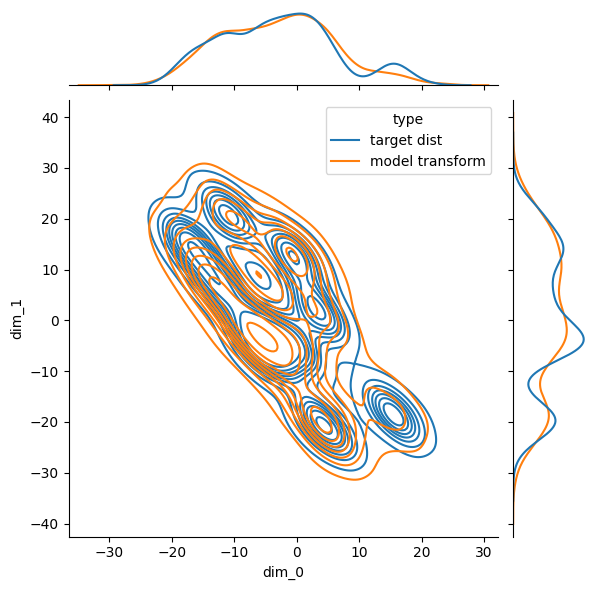

trail: 0 m step: 10 kl_test: 3.806407928466797


  2%|▏         | 100/6000 [00:32<35:13,  2.79it/s]

trail: 0 m step: 11 Loss: 3.6284732818603516  L_n: 3.3737659454345703  kld: 0.012735366821289062 KLD1: 3.2969307899475098 KLD2: 1.6590300798416138


  3%|▎         | 200/6000 [01:04<34:21,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5974903106689453  L_n: 3.3327884674072266  kld: 0.013235092163085938 KLD1: 3.2974648475646973 KLD2: 1.6666382551193237


  5%|▌         | 300/6000 [01:36<33:42,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5223331451416016  L_n: 3.2572498321533203  kld: 0.013254165649414062 KLD1: 3.2753608226776123 KLD2: 1.6394226551055908


  7%|▋         | 400/6000 [02:08<33:03,  2.82it/s]

trail: 0 m step: 11 Loss: 3.463348388671875  L_n: 3.28375244140625  kld: 0.00897979736328125 KLD1: 3.3988635540008545 KLD2: 1.6309009790420532


  8%|▊         | 500/6000 [02:40<32:28,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5799484252929688  L_n: 3.2861404418945312  kld: 0.014690399169921875 KLD1: 3.240212917327881 KLD2: 1.6478482484817505


 10%|█         | 600/6000 [03:12<31:50,  2.83it/s]

trail: 0 m step: 11 Loss: 3.617685317993164  L_n: 3.296297073364258  kld: 0.016069412231445312 KLD1: 3.251248359680176 KLD2: 1.6603890657424927


 12%|█▏        | 700/6000 [03:45<31:22,  2.82it/s]

trail: 0 m step: 11 Loss: 3.532703399658203  L_n: 3.2280616760253906  kld: 0.015232086181640625 KLD1: 3.2437853813171387 KLD2: 1.6254675388336182


 13%|█▎        | 800/6000 [04:17<30:50,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5655269622802734  L_n: 3.246389389038086  kld: 0.015956878662109375 KLD1: 3.2172446250915527 KLD2: 1.6502799987792969


 15%|█▌        | 900/6000 [04:49<30:11,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5247058868408203  L_n: 3.2176990509033203  kld: 0.015350341796875 KLD1: 3.218230724334717 KLD2: 1.6657100915908813


 17%|█▋        | 1000/6000 [05:21<29:32,  2.82it/s]

trail: 0 m step: 11 Loss: 3.4593544006347656  L_n: 3.2293663024902344  kld: 0.011499404907226562 KLD1: 3.26180100440979 KLD2: 1.6454026699066162


 18%|█▊        | 1100/6000 [05:53<28:54,  2.83it/s]

trail: 0 m step: 11 Loss: 3.585651397705078  L_n: 3.2697181701660156  kld: 0.015796661376953125 KLD1: 3.2378768920898438 KLD2: 1.6494221687316895


 20%|██        | 1200/6000 [06:25<28:24,  2.82it/s]

trail: 0 m step: 11 Loss: 3.550067901611328  L_n: 3.2112083435058594  kld: 0.016942977905273438 KLD1: 3.22322416305542 KLD2: 1.6604065895080566


 22%|██▏       | 1300/6000 [06:57<27:44,  2.82it/s]

trail: 0 m step: 11 Loss: 3.4934520721435547  L_n: 3.210172653198242  kld: 0.014163970947265625 KLD1: 3.254573345184326 KLD2: 1.6681276559829712


 23%|██▎       | 1400/6000 [07:29<27:15,  2.81it/s]

trail: 0 m step: 11 Loss: 3.6227779388427734  L_n: 3.311155319213867  kld: 0.015581130981445312 KLD1: 3.2174947261810303 KLD2: 1.6283782720565796


 25%|██▌       | 1500/6000 [08:01<26:40,  2.81it/s]

trail: 0 m step: 11 Loss: 3.517526626586914  L_n: 3.1856861114501953  kld: 0.016592025756835938 KLD1: 3.13596773147583 KLD2: 1.605088472366333


 27%|██▋       | 1600/6000 [08:34<26:08,  2.80it/s]

trail: 0 m step: 11 Loss: 3.5644054412841797  L_n: 3.245420455932617  kld: 0.015949249267578125 KLD1: 3.194918632507324 KLD2: 1.620526909828186


 28%|██▊       | 1700/6000 [09:06<25:26,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5888214111328125  L_n: 3.3306427001953125  kld: 0.012908935546875 KLD1: 3.3133015632629395 KLD2: 1.6644190549850464


 30%|███       | 1800/6000 [09:38<24:46,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5047531127929688  L_n: 3.2132720947265625  kld: 0.014574050903320312 KLD1: 3.227247953414917 KLD2: 1.6265372037887573


 32%|███▏      | 1900/6000 [10:10<24:18,  2.81it/s]

trail: 0 m step: 11 Loss: 3.483196258544922  L_n: 3.1860694885253906  kld: 0.014856338500976562 KLD1: 3.253814458847046 KLD2: 1.6466723680496216


 33%|███▎      | 2000/6000 [10:42<23:41,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5279388427734375  L_n: 3.25762939453125  kld: 0.013515472412109375 KLD1: 3.2704288959503174 KLD2: 1.641937255859375


 35%|███▌      | 2100/6000 [11:14<23:08,  2.81it/s]

trail: 0 m step: 11 Loss: 3.532388687133789  L_n: 3.211305618286133  kld: 0.016054153442382812 KLD1: 3.202652931213379 KLD2: 1.6458611488342285


 37%|███▋      | 2200/6000 [11:46<22:31,  2.81it/s]

trail: 0 m step: 11 Loss: 3.53857421875  L_n: 3.2329788208007812  kld: 0.015279769897460938 KLD1: 3.2291483879089355 KLD2: 1.6387808322906494


 38%|███▊      | 2300/6000 [12:19<21:53,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5081005096435547  L_n: 3.2179927825927734  kld: 0.014505386352539062 KLD1: 3.2466225624084473 KLD2: 1.6223682165145874


 40%|████      | 2400/6000 [12:51<21:23,  2.81it/s]

trail: 0 m step: 11 Loss: 3.4933223724365234  L_n: 3.239225387573242  kld: 0.012704849243164062 KLD1: 3.2307448387145996 KLD2: 1.6432931423187256


 42%|████▏     | 2500/6000 [13:23<20:45,  2.81it/s]

trail: 0 m step: 11 Loss: 3.4738101959228516  L_n: 3.2266178131103516  kld: 0.012359619140625 KLD1: 3.224848985671997 KLD2: 1.6386189460754395


 43%|████▎     | 2600/6000 [13:55<20:12,  2.80it/s]

trail: 0 m step: 11 Loss: 3.5089855194091797  L_n: 3.1914119720458984  kld: 0.015878677368164062 KLD1: 3.1914761066436768 KLD2: 1.6166048049926758


 45%|████▌     | 2700/6000 [14:27<19:35,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5190391540527344  L_n: 3.2230567932128906  kld: 0.014799118041992188 KLD1: 3.1739296913146973 KLD2: 1.6402677297592163


 47%|████▋     | 2800/6000 [14:59<18:53,  2.82it/s]

trail: 0 m step: 11 Loss: 3.541889190673828  L_n: 3.2375144958496094  kld: 0.015218734741210938 KLD1: 3.199446678161621 KLD2: 1.6404651403427124


 48%|████▊     | 2900/6000 [15:31<18:19,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5667190551757812  L_n: 3.2546005249023438  kld: 0.015605926513671875 KLD1: 3.180969476699829 KLD2: 1.642818570137024


 50%|█████     | 3000/6000 [16:04<17:46,  2.81it/s]

trail: 0 m step: 11 Loss: 3.455535888671875  L_n: 3.1957931518554688  kld: 0.012987136840820312 KLD1: 3.286052703857422 KLD2: 1.6238102912902832


 52%|█████▏    | 3100/6000 [16:36<17:12,  2.81it/s]

trail: 0 m step: 11 Loss: 3.3732032775878906  L_n: 3.157215118408203  kld: 0.010799407958984375 KLD1: 3.2479798793792725 KLD2: 1.609570860862732


 53%|█████▎    | 3200/6000 [17:08<16:34,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5864810943603516  L_n: 3.261964797973633  kld: 0.016225814819335938 KLD1: 3.1855762004852295 KLD2: 1.604810118675232


 55%|█████▌    | 3300/6000 [17:40<15:54,  2.83it/s]

trail: 0 m step: 11 Loss: 3.5239181518554688  L_n: 3.2685623168945312  kld: 0.012767791748046875 KLD1: 3.2468619346618652 KLD2: 1.6118618249893188


 57%|█████▋    | 3400/6000 [18:12<15:21,  2.82it/s]

trail: 0 m step: 11 Loss: 3.470243453979492  L_n: 3.161214828491211  kld: 0.015451431274414062 KLD1: 3.1730306148529053 KLD2: 1.6415270566940308


 58%|█████▊    | 3500/6000 [18:44<14:47,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5707015991210938  L_n: 3.2810897827148438  kld: 0.0144805908203125 KLD1: 3.2047207355499268 KLD2: 1.6453423500061035


 60%|██████    | 3600/6000 [19:16<14:12,  2.81it/s]

trail: 0 m step: 11 Loss: 3.4578781127929688  L_n: 3.1484298706054688  kld: 0.015472412109375 KLD1: 3.1859819889068604 KLD2: 1.6597845554351807


 62%|██████▏   | 3700/6000 [19:48<13:38,  2.81it/s]

trail: 0 m step: 11 Loss: 3.4852828979492188  L_n: 3.19219970703125  kld: 0.014654159545898438 KLD1: 3.2395663261413574 KLD2: 1.6350579261779785


 63%|██████▎   | 3800/6000 [20:21<13:01,  2.82it/s]

trail: 0 m step: 11 Loss: 3.4790821075439453  L_n: 3.231813430786133  kld: 0.012363433837890625 KLD1: 3.2656853199005127 KLD2: 1.6143312454223633


 65%|██████▌   | 3900/6000 [20:53<12:26,  2.81it/s]

trail: 0 m step: 11 Loss: 3.4848289489746094  L_n: 3.171833038330078  kld: 0.015649795532226562 KLD1: 3.218613862991333 KLD2: 1.611122727394104


 67%|██████▋   | 4000/6000 [21:25<11:49,  2.82it/s]

trail: 0 m step: 11 Loss: 3.559894561767578  L_n: 3.202838897705078  kld: 0.017852783203125 KLD1: 3.1496517658233643 KLD2: 1.6286524534225464


 68%|██████▊   | 4100/6000 [21:57<11:13,  2.82it/s]

trail: 0 m step: 11 Loss: 3.547231674194336  L_n: 3.201047897338867  kld: 0.017309188842773438 KLD1: 3.1539413928985596 KLD2: 1.6226714849472046


 70%|███████   | 4200/6000 [22:29<10:39,  2.81it/s]

trail: 0 m step: 11 Loss: 3.434001922607422  L_n: 3.139202117919922  kld: 0.014739990234375 KLD1: 3.2243189811706543 KLD2: 1.6335093975067139


 72%|███████▏  | 4300/6000 [23:01<10:03,  2.82it/s]

trail: 0 m step: 11 Loss: 3.505006790161133  L_n: 3.2347354888916016  kld: 0.013513565063476562 KLD1: 3.2469027042388916 KLD2: 1.6559386253356934


 73%|███████▎  | 4400/6000 [23:33<09:27,  2.82it/s]

trail: 0 m step: 11 Loss: 3.4335594177246094  L_n: 3.161457061767578  kld: 0.013605117797851562 KLD1: 3.188309669494629 KLD2: 1.629419207572937


 75%|███████▌  | 4500/6000 [24:05<08:54,  2.80it/s]

trail: 0 m step: 11 Loss: 3.512880325317383  L_n: 3.2141895294189453  kld: 0.014934539794921875 KLD1: 3.183450698852539 KLD2: 1.6213786602020264


 77%|███████▋  | 4600/6000 [24:37<08:18,  2.81it/s]

trail: 0 m step: 11 Loss: 3.4633560180664062  L_n: 3.19903564453125  kld: 0.013216018676757812 KLD1: 3.2239272594451904 KLD2: 1.659049153327942


 78%|███████▊  | 4700/6000 [25:10<07:41,  2.82it/s]

trail: 0 m step: 11 Loss: 3.401182174682617  L_n: 3.2057552337646484  kld: 0.009771347045898438 KLD1: 3.2897324562072754 KLD2: 1.6350756883621216


 80%|████████  | 4800/6000 [25:42<07:04,  2.83it/s]

trail: 0 m step: 11 Loss: 3.501331329345703  L_n: 3.2425804138183594  kld: 0.012937545776367188 KLD1: 3.2231435775756836 KLD2: 1.6290522813796997


 82%|████████▏ | 4900/6000 [26:14<06:30,  2.82it/s]

trail: 0 m step: 11 Loss: 3.4337520599365234  L_n: 3.1642818450927734  kld: 0.0134735107421875 KLD1: 3.2233548164367676 KLD2: 1.6223392486572266


 83%|████████▎ | 5000/6000 [26:46<05:53,  2.83it/s]

trail: 0 m step: 11 Loss: 3.4527626037597656  L_n: 3.180774688720703  kld: 0.013599395751953125 KLD1: 3.2327053546905518 KLD2: 1.6412806510925293


 85%|████████▌ | 5100/6000 [27:18<05:20,  2.81it/s]

trail: 0 m step: 11 Loss: 3.3701171875  L_n: 3.1305923461914062  kld: 0.011976242065429688 KLD1: 3.2577335834503174 KLD2: 1.6492639780044556


 87%|████████▋ | 5200/6000 [27:50<04:44,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5140132904052734  L_n: 3.204030990600586  kld: 0.015499114990234375 KLD1: 3.1680655479431152 KLD2: 1.636243462562561


 88%|████████▊ | 5300/6000 [28:22<04:09,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5126399993896484  L_n: 3.2135677337646484  kld: 0.01495361328125 KLD1: 3.1419456005096436 KLD2: 1.6194576025009155


 90%|█████████ | 5400/6000 [28:54<03:33,  2.82it/s]

trail: 0 m step: 11 Loss: 3.4755382537841797  L_n: 3.210988998413086  kld: 0.013227462768554688 KLD1: 3.2560698986053467 KLD2: 1.6273081302642822


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5150184631347656  L_n: 3.201946258544922  kld: 0.015653610229492188 KLD1: 3.1909847259521484 KLD2: 1.6285470724105835


 93%|█████████▎| 5600/6000 [29:59<02:22,  2.81it/s]

trail: 0 m step: 11 Loss: 3.5084056854248047  L_n: 3.2062816619873047  kld: 0.015106201171875 KLD1: 3.179461717605591 KLD2: 1.6220048666000366


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.82it/s]

trail: 0 m step: 11 Loss: 3.500631332397461  L_n: 3.236539840698242  kld: 0.013204574584960938 KLD1: 3.1828081607818604 KLD2: 1.641048550605774


 97%|█████████▋| 5800/6000 [31:03<01:11,  2.80it/s]

trail: 0 m step: 11 Loss: 3.5229835510253906  L_n: 3.240161895751953  kld: 0.014141082763671875 KLD1: 3.188542604446411 KLD2: 1.6192798614501953


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.82it/s]

trail: 0 m step: 11 Loss: 3.5226364135742188  L_n: 3.212310791015625  kld: 0.015516281127929688 KLD1: 3.171107292175293 KLD2: 1.6424163579940796


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 11 Loss: 3.4994335174560547  L_n: 3.198568344116211  kld: 0.015043258666992188 KLD1: 3.1989598274230957 KLD2: 1.6364548206329346



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


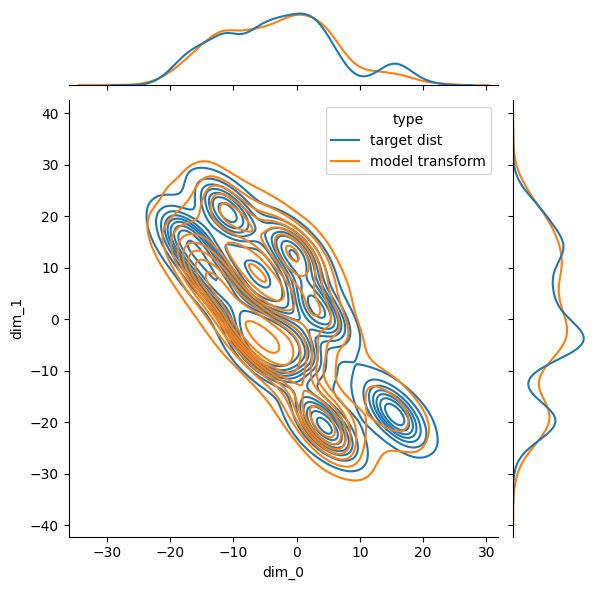

trail: 0 m step: 11 kl_test: 3.2504043579101562


  2%|▏         | 100/6000 [00:32<35:05,  2.80it/s]

trail: 0 m step: 12 Loss: 3.075593948364258  L_n: 2.851900100708008  kld: 0.0111846923828125 KLD1: 2.7992780208587646 KLD2: 1.4655967950820923


  3%|▎         | 200/6000 [01:04<34:16,  2.82it/s]

trail: 0 m step: 12 Loss: 3.0549163818359375  L_n: 2.8416748046875  kld: 0.010662078857421875 KLD1: 2.8116953372955322 KLD2: 1.4739326238632202


  5%|▌         | 300/6000 [01:36<33:43,  2.82it/s]

trail: 0 m step: 12 Loss: 2.992389678955078  L_n: 2.7724342346191406  kld: 0.010997772216796875 KLD1: 2.796041965484619 KLD2: 1.446561574935913


  7%|▋         | 400/6000 [02:08<33:14,  2.81it/s]

trail: 0 m step: 12 Loss: 2.959003448486328  L_n: 2.810993194580078  kld: 0.0074005126953125 KLD1: 2.862475872039795 KLD2: 1.4363452196121216


  8%|▊         | 500/6000 [02:41<32:38,  2.81it/s]

trail: 0 m step: 12 Loss: 3.036479949951172  L_n: 2.7918052673339844  kld: 0.012233734130859375 KLD1: 2.7747855186462402 KLD2: 1.4545884132385254


 10%|█         | 600/6000 [03:13<32:02,  2.81it/s]

trail: 0 m step: 12 Loss: 3.077981948852539  L_n: 2.791994094848633  kld: 0.014299392700195312 KLD1: 2.72805118560791 KLD2: 1.4641717672348022


 12%|█▏        | 700/6000 [03:45<31:35,  2.80it/s]

trail: 0 m step: 12 Loss: 3.058084487915039  L_n: 2.7860965728759766  kld: 0.013599395751953125 KLD1: 2.7993674278259277 KLD2: 1.4328429698944092


 13%|█▎        | 800/6000 [04:17<30:51,  2.81it/s]

trail: 0 m step: 12 Loss: 3.0338821411132812  L_n: 2.7602157592773438  kld: 0.013683319091796875 KLD1: 2.746764659881592 KLD2: 1.4530624151229858


 15%|█▌        | 900/6000 [04:49<30:06,  2.82it/s]

trail: 0 m step: 12 Loss: 3.013507843017578  L_n: 2.755481719970703  kld: 0.01290130615234375 KLD1: 2.7442171573638916 KLD2: 1.4743995666503906


 17%|█▋        | 1000/6000 [05:21<29:35,  2.82it/s]

trail: 0 m step: 12 Loss: 2.916290283203125  L_n: 2.7291030883789062  kld: 0.009359359741210938 KLD1: 2.8235182762145996 KLD2: 1.4547841548919678


 18%|█▊        | 1100/6000 [05:53<29:12,  2.80it/s]

trail: 0 m step: 12 Loss: 3.032564163208008  L_n: 2.768281936645508  kld: 0.013214111328125 KLD1: 2.7595927715301514 KLD2: 1.4462599754333496


 20%|██        | 1200/6000 [06:26<28:28,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9701900482177734  L_n: 2.7286815643310547  kld: 0.012075424194335938 KLD1: 2.743685483932495 KLD2: 1.4630521535873413


 22%|██▏       | 1300/6000 [06:58<27:57,  2.80it/s]

trail: 0 m step: 12 Loss: 2.966615676879883  L_n: 2.733156204223633  kld: 0.0116729736328125 KLD1: 2.8213603496551514 KLD2: 1.474751353263855


 23%|██▎       | 1400/6000 [07:30<27:21,  2.80it/s]

trail: 0 m step: 12 Loss: 3.10296630859375  L_n: 2.8074417114257812  kld: 0.014776229858398438 KLD1: 2.718876600265503 KLD2: 1.4344552755355835


 25%|██▌       | 1500/6000 [08:02<26:35,  2.82it/s]

trail: 0 m step: 12 Loss: 2.99847412109375  L_n: 2.7316360473632812  kld: 0.013341903686523438 KLD1: 2.713926076889038 KLD2: 1.4170591831207275


 27%|██▋       | 1600/6000 [08:34<25:58,  2.82it/s]

trail: 0 m step: 12 Loss: 3.0117874145507812  L_n: 2.7505569458007812  kld: 0.0130615234375 KLD1: 2.7306151390075684 KLD2: 1.4274795055389404


 28%|██▊       | 1700/6000 [09:07<25:32,  2.81it/s]

trail: 0 m step: 12 Loss: 3.055316925048828  L_n: 2.852832794189453  kld: 0.01012420654296875 KLD1: 2.8194427490234375 KLD2: 1.4720033407211304


 30%|███       | 1800/6000 [09:39<24:50,  2.82it/s]

trail: 0 m step: 12 Loss: 2.965456008911133  L_n: 2.6939640045166016  kld: 0.013574600219726562 KLD1: 2.7526307106018066 KLD2: 1.4325238466262817


 32%|███▏      | 1900/6000 [10:11<24:17,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9730300903320312  L_n: 2.723968505859375  kld: 0.012453079223632812 KLD1: 2.7852752208709717 KLD2: 1.457179069519043


 33%|███▎      | 2000/6000 [10:43<23:40,  2.82it/s]

trail: 0 m step: 12 Loss: 3.000041961669922  L_n: 2.7799720764160156  kld: 0.011003494262695312 KLD1: 2.769397497177124 KLD2: 1.4456003904342651


 35%|███▌      | 2100/6000 [11:15<23:04,  2.82it/s]

trail: 0 m step: 12 Loss: 3.0254287719726562  L_n: 2.751190185546875  kld: 0.013711929321289062 KLD1: 2.758148431777954 KLD2: 1.4531328678131104


 37%|███▋      | 2200/6000 [11:47<22:27,  2.82it/s]

trail: 0 m step: 12 Loss: 3.006084442138672  L_n: 2.759235382080078  kld: 0.012342453002929688 KLD1: 2.7821648120880127 KLD2: 1.4483802318572998


 38%|███▊      | 2300/6000 [12:20<21:56,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9635086059570312  L_n: 2.7298965454101562  kld: 0.01168060302734375 KLD1: 2.7631449699401855 KLD2: 1.4336556196212769


 40%|████      | 2400/6000 [12:52<21:19,  2.81it/s]

trail: 0 m step: 12 Loss: 2.985443115234375  L_n: 2.77685546875  kld: 0.01042938232421875 KLD1: 2.770247459411621 KLD2: 1.454575777053833


 42%|████▏     | 2500/6000 [13:24<20:44,  2.81it/s]

trail: 0 m step: 12 Loss: 2.970531463623047  L_n: 2.7681617736816406  kld: 0.010118484497070312 KLD1: 2.748821496963501 KLD2: 1.447925090789795


 43%|████▎     | 2600/6000 [13:56<20:11,  2.81it/s]

trail: 0 m step: 12 Loss: 2.981372833251953  L_n: 2.7238426208496094  kld: 0.012876510620117188 KLD1: 2.736504077911377 KLD2: 1.4244513511657715


 45%|████▌     | 2700/6000 [14:28<19:31,  2.82it/s]

trail: 0 m step: 12 Loss: 3.0075531005859375  L_n: 2.75738525390625  kld: 0.012508392333984375 KLD1: 2.69499135017395 KLD2: 1.444284200668335


 47%|████▋     | 2800/6000 [15:00<19:02,  2.80it/s]

trail: 0 m step: 12 Loss: 3.0191097259521484  L_n: 2.7716503143310547  kld: 0.012372970581054688 KLD1: 2.7306602001190186 KLD2: 1.4452354907989502


 48%|████▊     | 2900/6000 [15:32<18:22,  2.81it/s]

trail: 0 m step: 12 Loss: 3.0494136810302734  L_n: 2.792989730834961  kld: 0.012821197509765625 KLD1: 2.738647699356079 KLD2: 1.4509202241897583


 50%|█████     | 3000/6000 [16:04<17:42,  2.82it/s]

trail: 0 m step: 12 Loss: 2.935617446899414  L_n: 2.722757339477539  kld: 0.01064300537109375 KLD1: 2.8051819801330566 KLD2: 1.4349268674850464


 52%|█████▏    | 3100/6000 [16:36<17:13,  2.81it/s]

trail: 0 m step: 12 Loss: 2.8682518005371094  L_n: 2.6920127868652344  kld: 0.00881195068359375 KLD1: 2.787385940551758 KLD2: 1.4202256202697754


 53%|█████▎    | 3200/6000 [17:09<16:34,  2.82it/s]

trail: 0 m step: 12 Loss: 3.0331974029541016  L_n: 2.773073196411133  kld: 0.013006210327148438 KLD1: 2.735485076904297 KLD2: 1.41792631149292


 55%|█████▌    | 3300/6000 [17:41<16:02,  2.80it/s]

trail: 0 m step: 12 Loss: 2.9964065551757812  L_n: 2.783660888671875  kld: 0.010637283325195312 KLD1: 2.7295584678649902 KLD2: 1.42319917678833


 57%|█████▋    | 3400/6000 [18:13<15:21,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9319114685058594  L_n: 2.6708335876464844  kld: 0.01305389404296875 KLD1: 2.7257139682769775 KLD2: 1.4450886249542236


 58%|█████▊    | 3500/6000 [18:45<14:50,  2.81it/s]

trail: 0 m step: 12 Loss: 3.012796401977539  L_n: 2.7685794830322266  kld: 0.012210845947265625 KLD1: 2.739595651626587 KLD2: 1.449839472770691


 60%|██████    | 3600/6000 [19:17<14:09,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9685897827148438  L_n: 2.703125  kld: 0.013273239135742188 KLD1: 2.699024200439453 KLD2: 1.4657891988754272


 62%|██████▏   | 3700/6000 [19:49<13:38,  2.81it/s]

trail: 0 m step: 12 Loss: 2.960430145263672  L_n: 2.713123321533203  kld: 0.012365341186523438 KLD1: 2.7946853637695312 KLD2: 1.4405561685562134


 63%|██████▎   | 3800/6000 [20:22<12:59,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9900569915771484  L_n: 2.792417526245117  kld: 0.009881973266601562 KLD1: 2.7822535037994385 KLD2: 1.4220209121704102


 65%|██████▌   | 3900/6000 [20:54<12:28,  2.81it/s]

trail: 0 m step: 12 Loss: 2.995584487915039  L_n: 2.7138309478759766  kld: 0.014087677001953125 KLD1: 2.7390050888061523 KLD2: 1.4205472469329834


 67%|██████▋   | 4000/6000 [21:26<11:51,  2.81it/s]

trail: 0 m step: 12 Loss: 3.005807876586914  L_n: 2.724130630493164  kld: 0.0140838623046875 KLD1: 2.705446481704712 KLD2: 1.4387747049331665


 68%|██████▊   | 4100/6000 [21:58<11:15,  2.81it/s]

trail: 0 m step: 12 Loss: 2.977855682373047  L_n: 2.7009849548339844  kld: 0.013843536376953125 KLD1: 2.704867124557495 KLD2: 1.4308427572250366


 70%|███████   | 4200/6000 [22:30<10:40,  2.81it/s]

trail: 0 m step: 12 Loss: 2.929838180541992  L_n: 2.6993541717529297  kld: 0.011524200439453125 KLD1: 2.7465837001800537 KLD2: 1.4414751529693604


 72%|███████▏  | 4300/6000 [23:02<10:00,  2.83it/s]

trail: 0 m step: 12 Loss: 2.966228485107422  L_n: 2.744365692138672  kld: 0.0110931396484375 KLD1: 2.773155689239502 KLD2: 1.4624788761138916


 73%|███████▎  | 4400/6000 [23:34<09:28,  2.82it/s]

trail: 0 m step: 12 Loss: 2.920917510986328  L_n: 2.6953163146972656  kld: 0.011280059814453125 KLD1: 2.750643491744995 KLD2: 1.4389979839324951


 75%|███████▌  | 4500/6000 [24:06<08:51,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9916419982910156  L_n: 2.746623992919922  kld: 0.012250900268554688 KLD1: 2.6941423416137695 KLD2: 1.4281367063522339


 77%|███████▋  | 4600/6000 [24:38<08:16,  2.82it/s]

trail: 0 m step: 12 Loss: 2.94854736328125  L_n: 2.7308425903320312  kld: 0.010885238647460938 KLD1: 2.7653818130493164 KLD2: 1.4672129154205322


 78%|███████▊  | 4700/6000 [25:10<07:41,  2.82it/s]

trail: 0 m step: 12 Loss: 2.8975696563720703  L_n: 2.734415054321289  kld: 0.008157730102539062 KLD1: 2.790644407272339 KLD2: 1.4438073635101318


 80%|████████  | 4800/6000 [25:42<07:07,  2.81it/s]

trail: 0 m step: 12 Loss: 2.954954147338867  L_n: 2.758268356323242  kld: 0.00983428955078125 KLD1: 2.771796464920044 KLD2: 1.442212700843811


 82%|████████▏ | 4900/6000 [26:15<06:30,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9255733489990234  L_n: 2.713438034057617  kld: 0.010606765747070312 KLD1: 2.792515754699707 KLD2: 1.4304050207138062


 83%|████████▎ | 5000/6000 [26:47<05:54,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9427547454833984  L_n: 2.7165050506591797  kld: 0.011312484741210938 KLD1: 2.7759850025177 KLD2: 1.448533535003662


 85%|████████▌ | 5100/6000 [27:19<05:20,  2.81it/s]

trail: 0 m step: 12 Loss: 2.8439464569091797  L_n: 2.6516857147216797  kld: 0.009613037109375 KLD1: 2.7743804454803467 KLD2: 1.45641028881073


 87%|████████▋ | 5200/6000 [27:51<04:43,  2.83it/s]

trail: 0 m step: 12 Loss: 3.0128421783447266  L_n: 2.7553882598876953  kld: 0.012872695922851562 KLD1: 2.7211570739746094 KLD2: 1.446210503578186


 88%|████████▊ | 5300/6000 [28:23<04:08,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9887561798095703  L_n: 2.7414493560791016  kld: 0.012365341186523438 KLD1: 2.6967732906341553 KLD2: 1.427840232849121


 90%|█████████ | 5400/6000 [28:55<03:33,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9594459533691406  L_n: 2.743724822998047  kld: 0.010786056518554688 KLD1: 2.7917003631591797 KLD2: 1.4374533891677856


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.82it/s]

trail: 0 m step: 12 Loss: 3.0127334594726562  L_n: 2.757415771484375  kld: 0.012765884399414062 KLD1: 2.7088725566864014 KLD2: 1.439264178276062


 93%|█████████▎| 5600/6000 [29:59<02:22,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9996204376220703  L_n: 2.753610610961914  kld: 0.012300491333007812 KLD1: 2.7199385166168213 KLD2: 1.4323854446411133


 95%|█████████▌| 5700/6000 [30:32<01:46,  2.82it/s]

trail: 0 m step: 12 Loss: 2.944551467895508  L_n: 2.7406558990478516  kld: 0.010194778442382812 KLD1: 2.7385504245758057 KLD2: 1.4505362510681152


 97%|█████████▋| 5800/6000 [31:04<01:11,  2.81it/s]

trail: 0 m step: 12 Loss: 2.9974098205566406  L_n: 2.768718719482422  kld: 0.011434555053710938 KLD1: 2.725660800933838 KLD2: 1.4301040172576904


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.82it/s]

trail: 0 m step: 12 Loss: 2.9843215942382812  L_n: 2.7256851196289062  kld: 0.01293182373046875 KLD1: 2.694831371307373 KLD2: 1.453666090965271


100%|██████████| 6000/6000 [32:08<00:00,  3.11it/s]

trail: 0 m step: 12 Loss: 2.9629287719726562  L_n: 2.7250442504882812  kld: 0.01189422607421875 KLD1: 2.7244856357574463 KLD2: 1.4458402395248413



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


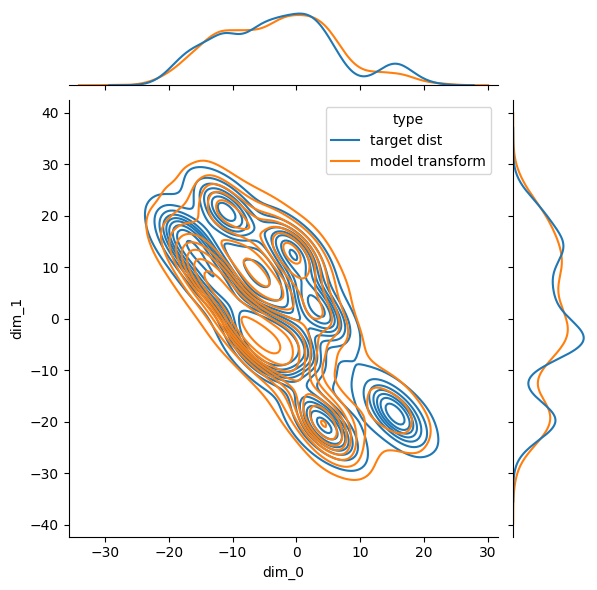

trail: 0 m step: 12 kl_test: 2.767618179321289


  2%|▏         | 100/6000 [00:32<35:18,  2.79it/s]

trail: 0 m step: 13 Loss: 2.6513118743896484  L_n: 2.462789535522461  kld: 0.009426116943359375 KLD1: 2.4004054069519043 KLD2: 1.29727041721344


  3%|▎         | 200/6000 [01:04<34:13,  2.82it/s]

trail: 0 m step: 13 Loss: 2.617279052734375  L_n: 2.4285659790039062  kld: 0.009435653686523438 KLD1: 2.433090925216675 KLD2: 1.304729700088501


  5%|▌         | 300/6000 [01:36<33:43,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5736541748046875  L_n: 2.3964996337890625  kld: 0.00885772705078125 KLD1: 2.42331862449646 KLD2: 1.2841063737869263


  7%|▋         | 400/6000 [02:08<33:07,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5652618408203125  L_n: 2.4433059692382812  kld: 0.0060977935791015625 KLD1: 2.451752185821533 KLD2: 1.2742140293121338


  8%|▊         | 500/6000 [02:40<32:41,  2.80it/s]

trail: 0 m step: 13 Loss: 2.6113719940185547  L_n: 2.401754379272461  kld: 0.010480880737304688 KLD1: 2.40067195892334 KLD2: 1.2911800146102905


 10%|█         | 600/6000 [03:12<31:59,  2.81it/s]

trail: 0 m step: 13 Loss: 2.6638755798339844  L_n: 2.421833038330078  kld: 0.012102127075195312 KLD1: 2.3854258060455322 KLD2: 1.3015974760055542


 12%|█▏        | 700/6000 [03:45<31:32,  2.80it/s]

trail: 0 m step: 13 Loss: 2.590717315673828  L_n: 2.364734649658203  kld: 0.01129913330078125 KLD1: 2.3883683681488037 KLD2: 1.2725120782852173


 13%|█▎        | 800/6000 [04:17<30:42,  2.82it/s]

trail: 0 m step: 13 Loss: 2.6095142364501953  L_n: 2.3734607696533203  kld: 0.01180267333984375 KLD1: 2.349909782409668 KLD2: 1.2942132949829102


 15%|█▌        | 900/6000 [04:49<30:10,  2.82it/s]

trail: 0 m step: 13 Loss: 2.622600555419922  L_n: 2.3813209533691406  kld: 0.012063980102539062 KLD1: 2.341054916381836 KLD2: 1.3054356575012207


 17%|█▋        | 1000/6000 [05:21<29:38,  2.81it/s]

trail: 0 m step: 13 Loss: 2.5263442993164062  L_n: 2.3625030517578125  kld: 0.008192062377929688 KLD1: 2.3913004398345947 KLD2: 1.2880361080169678


 18%|█▊        | 1100/6000 [05:53<28:56,  2.82it/s]

trail: 0 m step: 13 Loss: 2.6136226654052734  L_n: 2.380125045776367  kld: 0.011674880981445312 KLD1: 2.358869791030884 KLD2: 1.2803032398223877


 20%|██        | 1200/6000 [06:25<28:14,  2.83it/s]

trail: 0 m step: 13 Loss: 2.5501155853271484  L_n: 2.338094711303711  kld: 0.010601043701171875 KLD1: 2.3822455406188965 KLD2: 1.2965526580810547


 22%|██▏       | 1300/6000 [06:57<27:42,  2.83it/s]

trail: 0 m step: 13 Loss: 2.535076141357422  L_n: 2.3351478576660156  kld: 0.009996414184570312 KLD1: 2.416067600250244 KLD2: 1.3023403882980347


 23%|██▎       | 1400/6000 [07:30<27:16,  2.81it/s]

trail: 0 m step: 13 Loss: 2.653850555419922  L_n: 2.409709930419922  kld: 0.01220703125 KLD1: 2.348069429397583 KLD2: 1.2766443490982056


 25%|██▌       | 1500/6000 [08:02<26:27,  2.83it/s]

trail: 0 m step: 13 Loss: 2.5383567810058594  L_n: 2.3316001892089844  kld: 0.01033782958984375 KLD1: 2.3137965202331543 KLD2: 1.257023572921753


 27%|██▋       | 1600/6000 [08:34<25:52,  2.83it/s]

trail: 0 m step: 13 Loss: 2.5772266387939453  L_n: 2.350099563598633  kld: 0.011356353759765625 KLD1: 2.3705344200134277 KLD2: 1.2641032934188843


 28%|██▊       | 1700/6000 [09:06<25:23,  2.82it/s]

trail: 0 m step: 13 Loss: 2.6198387145996094  L_n: 2.4181175231933594  kld: 0.0100860595703125 KLD1: 2.418933868408203 KLD2: 1.301073431968689


 30%|███       | 1800/6000 [09:38<24:50,  2.82it/s]

trail: 0 m step: 13 Loss: 2.515249252319336  L_n: 2.3247814178466797  kld: 0.009523391723632812 KLD1: 2.3724451065063477 KLD2: 1.2726596593856812


 32%|███▏      | 1900/6000 [10:10<24:16,  2.81it/s]

trail: 0 m step: 13 Loss: 2.5785579681396484  L_n: 2.3391857147216797  kld: 0.011968612670898438 KLD1: 2.358429431915283 KLD2: 1.2860605716705322


 33%|███▎      | 2000/6000 [10:42<23:32,  2.83it/s]

trail: 0 m step: 13 Loss: 2.5925350189208984  L_n: 2.3778820037841797  kld: 0.010732650756835938 KLD1: 2.4027998447418213 KLD2: 1.28288733959198


 35%|███▌      | 2100/6000 [11:14<23:03,  2.82it/s]

trail: 0 m step: 13 Loss: 2.577157974243164  L_n: 2.343812942504883  kld: 0.011667251586914062 KLD1: 2.338200807571411 KLD2: 1.2858006954193115


 37%|███▋      | 2200/6000 [11:46<22:27,  2.82it/s]

trail: 0 m step: 13 Loss: 2.576364517211914  L_n: 2.3658313751220703  kld: 0.010526657104492188 KLD1: 2.357682228088379 KLD2: 1.2788441181182861


 38%|███▊      | 2300/6000 [12:18<21:51,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5338783264160156  L_n: 2.357982635498047  kld: 0.008794784545898438 KLD1: 2.3969192504882812 KLD2: 1.269975185394287


 40%|████      | 2400/6000 [12:50<21:16,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5508956909179688  L_n: 2.3797683715820312  kld: 0.008556365966796875 KLD1: 2.376940965652466 KLD2: 1.2870482206344604


 42%|████▏     | 2500/6000 [13:22<20:36,  2.83it/s]

trail: 0 m step: 13 Loss: 2.576089859008789  L_n: 2.4004993438720703  kld: 0.008779525756835938 KLD1: 2.3598978519439697 KLD2: 1.281488060951233


 43%|████▎     | 2600/6000 [13:54<20:05,  2.82it/s]

trail: 0 m step: 13 Loss: 2.541566848754883  L_n: 2.324281692504883  kld: 0.0108642578125 KLD1: 2.369154691696167 KLD2: 1.2650247812271118


 45%|████▌     | 2700/6000 [14:26<19:29,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5498199462890625  L_n: 2.354278564453125  kld: 0.009777069091796875 KLD1: 2.3135955333709717 KLD2: 1.2798904180526733


 47%|████▋     | 2800/6000 [14:58<18:53,  2.82it/s]

trail: 0 m step: 13 Loss: 2.565950393676758  L_n: 2.3691883087158203  kld: 0.009838104248046875 KLD1: 2.3558006286621094 KLD2: 1.2812066078186035


 48%|████▊     | 2900/6000 [15:30<18:17,  2.82it/s]

trail: 0 m step: 13 Loss: 2.620828628540039  L_n: 2.3996524810791016  kld: 0.011058807373046875 KLD1: 2.322622537612915 KLD2: 1.285583734512329


 50%|█████     | 3000/6000 [16:02<17:47,  2.81it/s]

trail: 0 m step: 13 Loss: 2.548309326171875  L_n: 2.3597488403320312  kld: 0.009428024291992188 KLD1: 2.407696485519409 KLD2: 1.2693995237350464


 52%|█████▏    | 3100/6000 [16:35<17:08,  2.82it/s]

trail: 0 m step: 13 Loss: 2.4576683044433594  L_n: 2.3096580505371094  kld: 0.0074005126953125 KLD1: 2.4088752269744873 KLD2: 1.259129285812378


 53%|█████▎    | 3200/6000 [17:07<16:28,  2.83it/s]

trail: 0 m step: 13 Loss: 2.6123275756835938  L_n: 2.375091552734375  kld: 0.011861801147460938 KLD1: 2.3391976356506348 KLD2: 1.2524038553237915


 55%|█████▌    | 3300/6000 [17:39<15:58,  2.82it/s]

trail: 0 m step: 13 Loss: 2.6018505096435547  L_n: 2.4230175018310547  kld: 0.008941650390625 KLD1: 2.3613929748535156 KLD2: 1.260542392730713


 57%|█████▋    | 3400/6000 [18:11<15:22,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5260982513427734  L_n: 2.2964534759521484  kld: 0.01148223876953125 KLD1: 2.292473077774048 KLD2: 1.2836791276931763


 58%|█████▊    | 3500/6000 [18:43<14:40,  2.84it/s]

trail: 0 m step: 13 Loss: 2.5814971923828125  L_n: 2.3746261596679688  kld: 0.010343551635742188 KLD1: 2.356559991836548 KLD2: 1.2844517230987549


 60%|██████    | 3600/6000 [19:15<14:09,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5521907806396484  L_n: 2.323843002319336  kld: 0.011417388916015625 KLD1: 2.335798978805542 KLD2: 1.3038345575332642


 62%|██████▏   | 3700/6000 [19:47<13:36,  2.82it/s]

trail: 0 m step: 13 Loss: 2.556936264038086  L_n: 2.352926254272461  kld: 0.01020050048828125 KLD1: 2.38671612739563 KLD2: 1.2774481773376465


 63%|██████▎   | 3800/6000 [20:19<13:02,  2.81it/s]

trail: 0 m step: 13 Loss: 2.5681838989257812  L_n: 2.3927078247070312  kld: 0.0087738037109375 KLD1: 2.3896777629852295 KLD2: 1.2632335424423218


 65%|██████▌   | 3900/6000 [20:51<12:22,  2.83it/s]

trail: 0 m step: 13 Loss: 2.5619125366210938  L_n: 2.33734130859375  kld: 0.011228561401367188 KLD1: 2.3464043140411377 KLD2: 1.2580702304840088


 67%|██████▋   | 4000/6000 [21:23<11:48,  2.82it/s]

trail: 0 m step: 13 Loss: 2.572277069091797  L_n: 2.324054718017578  kld: 0.012411117553710938 KLD1: 2.312234401702881 KLD2: 1.2691043615341187


 68%|██████▊   | 4100/6000 [21:55<11:15,  2.81it/s]

trail: 0 m step: 13 Loss: 2.581989288330078  L_n: 2.3362464904785156  kld: 0.012287139892578125 KLD1: 2.3086318969726562 KLD2: 1.2677634954452515


 70%|███████   | 4200/6000 [22:27<10:38,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5300216674804688  L_n: 2.322845458984375  kld: 0.010358810424804688 KLD1: 2.3547823429107666 KLD2: 1.2767829895019531


 72%|███████▏  | 4300/6000 [22:59<10:03,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5514068603515625  L_n: 2.352203369140625  kld: 0.009960174560546875 KLD1: 2.3824172019958496 KLD2: 1.2991760969161987


 73%|███████▎  | 4400/6000 [23:31<09:29,  2.81it/s]

trail: 0 m step: 13 Loss: 2.500965118408203  L_n: 2.309734344482422  kld: 0.009561538696289062 KLD1: 2.374823808670044 KLD2: 1.2790396213531494


 75%|███████▌  | 4500/6000 [24:03<08:51,  2.82it/s]

trail: 0 m step: 13 Loss: 2.554098129272461  L_n: 2.344900131225586  kld: 0.01045989990234375 KLD1: 2.3422577381134033 KLD2: 1.267457365989685


 77%|███████▋  | 4600/6000 [24:35<08:17,  2.81it/s]

trail: 0 m step: 13 Loss: 2.5293102264404297  L_n: 2.350706100463867  kld: 0.008930206298828125 KLD1: 2.400033473968506 KLD2: 1.303797960281372


 78%|███████▊  | 4700/6000 [25:07<07:41,  2.82it/s]

trail: 0 m step: 13 Loss: 2.441873550415039  L_n: 2.3290348052978516  kld: 0.005641937255859375 KLD1: 2.4235877990722656 KLD2: 1.282494068145752


 80%|████████  | 4800/6000 [25:39<07:05,  2.82it/s]

trail: 0 m step: 13 Loss: 2.530649185180664  L_n: 2.358530044555664  kld: 0.00860595703125 KLD1: 2.379518747329712 KLD2: 1.276434302330017


 82%|████████▏ | 4900/6000 [26:11<06:30,  2.82it/s]

trail: 0 m step: 13 Loss: 2.481618881225586  L_n: 2.3186168670654297  kld: 0.008150100708007812 KLD1: 2.38517165184021 KLD2: 1.267624020576477


 83%|████████▎ | 5000/6000 [26:43<05:55,  2.81it/s]

trail: 0 m step: 13 Loss: 2.519329071044922  L_n: 2.338359832763672  kld: 0.0090484619140625 KLD1: 2.377725839614868 KLD2: 1.2865357398986816


 85%|████████▌ | 5100/6000 [27:15<05:18,  2.83it/s]

trail: 0 m step: 13 Loss: 2.4612483978271484  L_n: 2.289663314819336  kld: 0.008579254150390625 KLD1: 2.380944013595581 KLD2: 1.290144920349121


 87%|████████▋ | 5200/6000 [27:48<04:45,  2.80it/s]

trail: 0 m step: 13 Loss: 2.5522594451904297  L_n: 2.3437862396240234  kld: 0.010423660278320312 KLD1: 2.326453447341919 KLD2: 1.283660888671875


 88%|████████▊ | 5300/6000 [28:20<04:06,  2.83it/s]

trail: 0 m step: 13 Loss: 2.561798095703125  L_n: 2.359619140625  kld: 0.01010894775390625 KLD1: 2.3116090297698975 KLD2: 1.2642909288406372


 90%|█████████ | 5400/6000 [28:52<03:31,  2.83it/s]

trail: 0 m step: 13 Loss: 2.532125473022461  L_n: 2.349821090698242  kld: 0.009115219116210938 KLD1: 2.395989418029785 KLD2: 1.2732253074645996


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5751724243164062  L_n: 2.3549880981445312  kld: 0.01100921630859375 KLD1: 2.3363287448883057 KLD2: 1.2770060300827026


 93%|█████████▎| 5600/6000 [29:56<02:22,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5561275482177734  L_n: 2.363027572631836  kld: 0.009654998779296875 KLD1: 2.3452117443084717 KLD2: 1.2713141441345215


 95%|█████████▌| 5700/6000 [30:28<01:46,  2.81it/s]

trail: 0 m step: 13 Loss: 2.5158462524414062  L_n: 2.341552734375  kld: 0.008714675903320312 KLD1: 2.359203815460205 KLD2: 1.285428524017334


 97%|█████████▋| 5800/6000 [31:00<01:10,  2.82it/s]

trail: 0 m step: 13 Loss: 2.5622196197509766  L_n: 2.380105972290039  kld: 0.009105682373046875 KLD1: 2.3381447792053223 KLD2: 1.2680633068084717


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.82it/s]

trail: 0 m step: 13 Loss: 2.558645248413086  L_n: 2.3544063568115234  kld: 0.010211944580078125 KLD1: 2.3293631076812744 KLD2: 1.2909181118011475


100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

trail: 0 m step: 13 Loss: 2.5657520294189453  L_n: 2.3594532012939453  kld: 0.01031494140625 KLD1: 2.357805013656616 KLD2: 1.2833130359649658



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


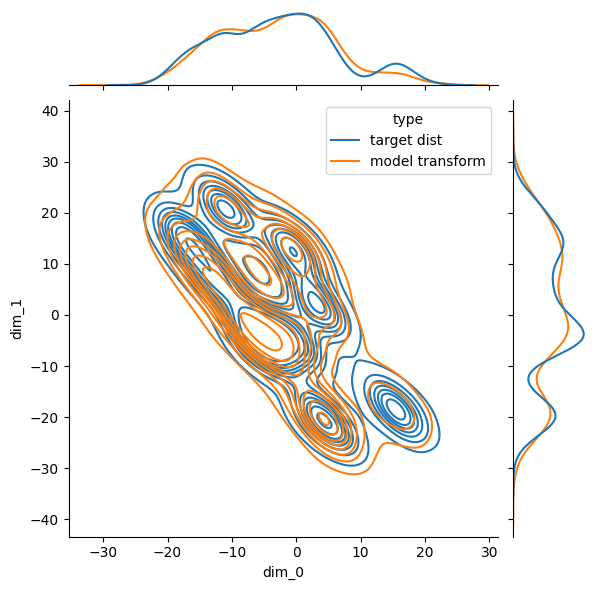

trail: 0 m step: 13 kl_test: 2.394418716430664


  2%|▏         | 100/6000 [00:32<37:08,  2.65it/s]

trail: 0 m step: 14 Loss: 2.312337875366211  L_n: 2.1381969451904297  kld: 0.008707046508789062 KLD1: 2.0933921337127686 KLD2: 1.1546965837478638


  3%|▎         | 200/6000 [01:04<34:07,  2.83it/s]

trail: 0 m step: 14 Loss: 2.3058032989501953  L_n: 2.1259403228759766  kld: 0.008993148803710938 KLD1: 2.1331703662872314 KLD2: 1.1596589088439941


  5%|▌         | 300/6000 [01:36<33:48,  2.81it/s]

trail: 0 m step: 14 Loss: 2.211484909057617  L_n: 2.0500850677490234  kld: 0.008069992065429688 KLD1: 2.097327709197998 KLD2: 1.1424684524536133


  7%|▋         | 400/6000 [02:08<33:07,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2060546875  L_n: 2.10443115234375  kld: 0.0050811767578125 KLD1: 2.157036542892456 KLD2: 1.1353918313980103


  8%|▊         | 500/6000 [02:40<32:26,  2.83it/s]

trail: 0 m step: 14 Loss: 2.2554187774658203  L_n: 2.0828800201416016  kld: 0.008626937866210938 KLD1: 2.02516508102417 KLD2: 1.1474565267562866


 10%|█         | 600/6000 [03:12<31:46,  2.83it/s]

trail: 0 m step: 14 Loss: 2.3079566955566406  L_n: 2.094715118408203  kld: 0.010662078857421875 KLD1: 2.0579237937927246 KLD2: 1.160861849784851


 12%|█▏        | 700/6000 [03:44<31:18,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2686195373535156  L_n: 2.072772979736328  kld: 0.009792327880859375 KLD1: 2.0566513538360596 KLD2: 1.1304354667663574


 13%|█▎        | 800/6000 [04:16<30:40,  2.83it/s]

trail: 0 m step: 14 Loss: 2.2767601013183594  L_n: 2.089038848876953  kld: 0.009386062622070312 KLD1: 2.056706190109253 KLD2: 1.1562479734420776


 15%|█▌        | 900/6000 [04:48<30:06,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2715816497802734  L_n: 2.0546398162841797  kld: 0.010847091674804688 KLD1: 2.013202667236328 KLD2: 1.1627392768859863


 17%|█▋        | 1000/6000 [05:20<29:31,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1539840698242188  L_n: 2.0308837890625  kld: 0.0061550140380859375 KLD1: 2.070910692214966 KLD2: 1.1528985500335693


 18%|█▊        | 1100/6000 [05:52<28:54,  2.82it/s]

trail: 0 m step: 14 Loss: 2.257732391357422  L_n: 2.0649375915527344  kld: 0.009639739990234375 KLD1: 2.0477991104125977 KLD2: 1.1422438621520996


 20%|██        | 1200/6000 [06:24<28:12,  2.84it/s]

trail: 0 m step: 14 Loss: 2.2416820526123047  L_n: 2.0523204803466797  kld: 0.00946807861328125 KLD1: 2.0444962978363037 KLD2: 1.156838059425354


 22%|██▏       | 1300/6000 [06:56<27:42,  2.83it/s]

trail: 0 m step: 14 Loss: 2.196664810180664  L_n: 2.016611099243164  kld: 0.009002685546875 KLD1: 2.1063992977142334 KLD2: 1.164782166481018


 23%|██▎       | 1400/6000 [07:28<27:11,  2.82it/s]

trail: 0 m step: 14 Loss: 2.307546615600586  L_n: 2.0941905975341797  kld: 0.010667800903320312 KLD1: 2.048506498336792 KLD2: 1.1265199184417725


 25%|██▌       | 1500/6000 [08:00<26:33,  2.82it/s]

trail: 0 m step: 14 Loss: 2.203907012939453  L_n: 2.0098533630371094  kld: 0.009702682495117188 KLD1: 1.9990304708480835 KLD2: 1.1156892776489258


 27%|██▋       | 1600/6000 [08:32<25:58,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2341270446777344  L_n: 2.029582977294922  kld: 0.010227203369140625 KLD1: 2.0320205688476562 KLD2: 1.1220605373382568


 28%|██▊       | 1700/6000 [09:04<25:18,  2.83it/s]

trail: 0 m step: 14 Loss: 2.308300018310547  L_n: 2.125690460205078  kld: 0.009130477905273438 KLD1: 2.1207897663116455 KLD2: 1.1678779125213623


 30%|███       | 1800/6000 [09:37<24:49,  2.82it/s]

trail: 0 m step: 14 Loss: 2.178691864013672  L_n: 2.004894256591797  kld: 0.00868988037109375 KLD1: 2.069720983505249 KLD2: 1.1335093975067139


 32%|███▏      | 1900/6000 [10:09<24:19,  2.81it/s]

trail: 0 m step: 14 Loss: 2.1977310180664062  L_n: 2.0069961547851562  kld: 0.0095367431640625 KLD1: 2.038356304168701 KLD2: 1.1488301753997803


 33%|███▎      | 2000/6000 [10:41<23:37,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2520694732666016  L_n: 2.0712528228759766  kld: 0.00904083251953125 KLD1: 2.0715932846069336 KLD2: 1.1428050994873047


 35%|███▌      | 2100/6000 [11:13<23:03,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2185935974121094  L_n: 2.0144691467285156  kld: 0.010206222534179688 KLD1: 2.015881299972534 KLD2: 1.1471624374389648


 37%|███▋      | 2200/6000 [11:45<22:30,  2.81it/s]

trail: 0 m step: 14 Loss: 2.216655731201172  L_n: 2.0490379333496094  kld: 0.008380889892578125 KLD1: 2.016561269760132 KLD2: 1.1429357528686523


 38%|███▊      | 2300/6000 [12:17<21:49,  2.83it/s]

trail: 0 m step: 14 Loss: 2.193838119506836  L_n: 2.032590866088867  kld: 0.008062362670898438 KLD1: 2.0621774196624756 KLD2: 1.1297987699508667


 40%|████      | 2400/6000 [12:49<21:20,  2.81it/s]

trail: 0 m step: 14 Loss: 2.1986122131347656  L_n: 2.0538063049316406  kld: 0.00724029541015625 KLD1: 2.070427179336548 KLD2: 1.1463667154312134


 42%|████▏     | 2500/6000 [13:21<20:39,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1878604888916016  L_n: 2.0436649322509766  kld: 0.00720977783203125 KLD1: 2.0580430030822754 KLD2: 1.143288493156433


 43%|████▎     | 2600/6000 [13:54<20:08,  2.81it/s]

trail: 0 m step: 14 Loss: 2.208284378051758  L_n: 2.0234241485595703  kld: 0.009243011474609375 KLD1: 2.051018238067627 KLD2: 1.1266061067581177


 45%|████▌     | 2700/6000 [14:26<19:31,  2.82it/s]

trail: 0 m step: 14 Loss: 2.217599868774414  L_n: 2.0447559356689453  kld: 0.008642196655273438 KLD1: 2.0121476650238037 KLD2: 1.1434452533721924


 47%|████▋     | 2800/6000 [14:58<18:58,  2.81it/s]

trail: 0 m step: 14 Loss: 2.2199020385742188  L_n: 2.0410308837890625  kld: 0.008943557739257812 KLD1: 2.056511163711548 KLD2: 1.1422783136367798


 48%|████▊     | 2900/6000 [15:30<18:24,  2.81it/s]

trail: 0 m step: 14 Loss: 2.239368438720703  L_n: 2.056568145751953  kld: 0.0091400146484375 KLD1: 2.022498846054077 KLD2: 1.1459656953811646


 50%|█████     | 3000/6000 [16:02<17:42,  2.82it/s]

trail: 0 m step: 14 Loss: 2.219532012939453  L_n: 2.063396453857422  kld: 0.0078067779541015625 KLD1: 2.0903561115264893 KLD2: 1.1317554712295532


 52%|█████▏    | 3100/6000 [16:34<17:11,  2.81it/s]

trail: 0 m step: 14 Loss: 2.122638702392578  L_n: 2.002513885498047  kld: 0.0060062408447265625 KLD1: 2.0790581703186035 KLD2: 1.1215938329696655


 53%|█████▎    | 3200/6000 [17:06<16:31,  2.82it/s]

trail: 0 m step: 14 Loss: 2.25  L_n: 2.0624313354492188  kld: 0.009378433227539062 KLD1: 2.0143699645996094 KLD2: 1.1194286346435547


 55%|█████▌    | 3300/6000 [17:39<16:00,  2.81it/s]

trail: 0 m step: 14 Loss: 2.2477798461914062  L_n: 2.0970993041992188  kld: 0.007534027099609375 KLD1: 2.0328781604766846 KLD2: 1.123024582862854


 57%|█████▋    | 3400/6000 [18:11<15:22,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1890220642089844  L_n: 1.9858131408691406  kld: 0.010160446166992188 KLD1: 2.0083789825439453 KLD2: 1.1473127603530884


 58%|█████▊    | 3500/6000 [18:43<14:46,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2914962768554688  L_n: 2.0716552734375  kld: 0.010992050170898438 KLD1: 2.0369341373443604 KLD2: 1.1448519229888916


 60%|██████    | 3600/6000 [19:15<14:11,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1936798095703125  L_n: 2.0025634765625  kld: 0.009555816650390625 KLD1: 2.043449878692627 KLD2: 1.1646233797073364


 62%|██████▏   | 3700/6000 [19:47<13:37,  2.81it/s]

trail: 0 m step: 14 Loss: 2.217958450317383  L_n: 2.0404224395751953  kld: 0.008876800537109375 KLD1: 2.0566916465759277 KLD2: 1.1424858570098877


 63%|██████▎   | 3800/6000 [20:19<13:04,  2.80it/s]

trail: 0 m step: 14 Loss: 2.2203922271728516  L_n: 2.0726871490478516  kld: 0.00738525390625 KLD1: 2.070735216140747 KLD2: 1.1185529232025146


 65%|██████▌   | 3900/6000 [20:52<12:26,  2.81it/s]

trail: 0 m step: 14 Loss: 2.215038299560547  L_n: 2.022815704345703  kld: 0.009611129760742188 KLD1: 2.020872116088867 KLD2: 1.1213691234588623


 67%|██████▋   | 4000/6000 [21:24<11:48,  2.82it/s]

trail: 0 m step: 14 Loss: 2.245454788208008  L_n: 2.032938003540039  kld: 0.010625839233398438 KLD1: 2.0139846801757812 KLD2: 1.1329306364059448


 68%|██████▊   | 4100/6000 [21:56<11:16,  2.81it/s]

trail: 0 m step: 14 Loss: 2.2496986389160156  L_n: 2.0389747619628906  kld: 0.01053619384765625 KLD1: 1.9922600984573364 KLD2: 1.1311230659484863


 70%|███████   | 4200/6000 [22:28<10:37,  2.82it/s]

trail: 0 m step: 14 Loss: 2.157651901245117  L_n: 1.992666244506836  kld: 0.008249282836914062 KLD1: 2.026099681854248 KLD2: 1.1379117965698242


 72%|███████▏  | 4300/6000 [23:00<10:04,  2.81it/s]

trail: 0 m step: 14 Loss: 2.2302017211914062  L_n: 2.0440826416015625  kld: 0.009305953979492188 KLD1: 2.037104606628418 KLD2: 1.1552767753601074


 73%|███████▎  | 4400/6000 [23:32<09:27,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1606788635253906  L_n: 2.0038185119628906  kld: 0.007843017578125 KLD1: 2.043910503387451 KLD2: 1.1359875202178955


 75%|███████▌  | 4500/6000 [24:04<08:56,  2.80it/s]

trail: 0 m step: 14 Loss: 2.202024459838867  L_n: 2.022848129272461  kld: 0.008958816528320312 KLD1: 2.034385919570923 KLD2: 1.126408576965332


 77%|███████▋  | 4600/6000 [24:37<08:15,  2.83it/s]

trail: 0 m step: 14 Loss: 2.159423828125  L_n: 2.023468017578125  kld: 0.00679779052734375 KLD1: 2.081521987915039 KLD2: 1.1642783880233765


 78%|███████▊  | 4700/6000 [25:09<07:42,  2.81it/s]

trail: 0 m step: 14 Loss: 2.099090576171875  L_n: 2.0164642333984375  kld: 0.004131317138671875 KLD1: 2.090359687805176 KLD2: 1.142143726348877


 80%|████████  | 4800/6000 [25:41<07:05,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1958274841308594  L_n: 2.050220489501953  kld: 0.0072803497314453125 KLD1: 2.0570971965789795 KLD2: 1.1387563943862915


 82%|████████▏ | 4900/6000 [26:13<06:29,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1395187377929688  L_n: 1.9986419677734375  kld: 0.0070438385009765625 KLD1: 2.090254545211792 KLD2: 1.1287678480148315


 83%|████████▎ | 5000/6000 [26:45<05:55,  2.81it/s]

trail: 0 m step: 14 Loss: 2.2049179077148438  L_n: 2.0360031127929688  kld: 0.00844573974609375 KLD1: 2.0735456943511963 KLD2: 1.1432396173477173


 85%|████████▌ | 5100/6000 [27:17<05:18,  2.83it/s]

trail: 0 m step: 14 Loss: 2.1284313201904297  L_n: 1.9814128875732422  kld: 0.007350921630859375 KLD1: 2.0427424907684326 KLD2: 1.1521081924438477


 87%|████████▋ | 5200/6000 [27:49<04:44,  2.81it/s]

trail: 0 m step: 14 Loss: 2.216764450073242  L_n: 2.0449886322021484  kld: 0.008588790893554688 KLD1: 2.038173198699951 KLD2: 1.1421743631362915


 88%|████████▊ | 5300/6000 [28:21<04:08,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2343578338623047  L_n: 2.055105209350586  kld: 0.008962631225585938 KLD1: 2.0290355682373047 KLD2: 1.125656247138977


 90%|█████████ | 5400/6000 [28:53<03:32,  2.82it/s]

trail: 0 m step: 14 Loss: 2.1772212982177734  L_n: 2.0286006927490234  kld: 0.0074310302734375 KLD1: 2.0756444931030273 KLD2: 1.1355650424957275


 92%|█████████▏| 5500/6000 [29:25<02:57,  2.82it/s]

trail: 0 m step: 14 Loss: 2.2286739349365234  L_n: 2.049039840698242  kld: 0.008981704711914062 KLD1: 2.0287678241729736 KLD2: 1.139333724975586


 93%|█████████▎| 5600/6000 [29:58<02:21,  2.82it/s]

trail: 0 m step: 14 Loss: 2.217884063720703  L_n: 2.0435523986816406  kld: 0.008716583251953125 KLD1: 2.041516065597534 KLD2: 1.1300530433654785


 95%|█████████▌| 5700/6000 [30:30<01:46,  2.83it/s]

trail: 0 m step: 14 Loss: 2.1794052124023438  L_n: 2.0352096557617188  kld: 0.00720977783203125 KLD1: 2.0566020011901855 KLD2: 1.1479374170303345


 97%|█████████▋| 5800/6000 [31:02<01:11,  2.82it/s]

trail: 0 m step: 14 Loss: 2.214824676513672  L_n: 2.055980682373047  kld: 0.00794219970703125 KLD1: 2.031076431274414 KLD2: 1.1297484636306763


 98%|█████████▊| 5900/6000 [31:34<00:35,  2.83it/s]

trail: 0 m step: 14 Loss: 2.2206478118896484  L_n: 2.0262508392333984  kld: 0.0097198486328125 KLD1: 2.0383918285369873 KLD2: 1.1530914306640625


100%|██████████| 6000/6000 [32:06<00:00,  3.11it/s]

trail: 0 m step: 14 Loss: 2.2269248962402344  L_n: 2.0664405822753906  kld: 0.008024215698242188 KLD1: 2.049760103225708 KLD2: 1.1451772451400757



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


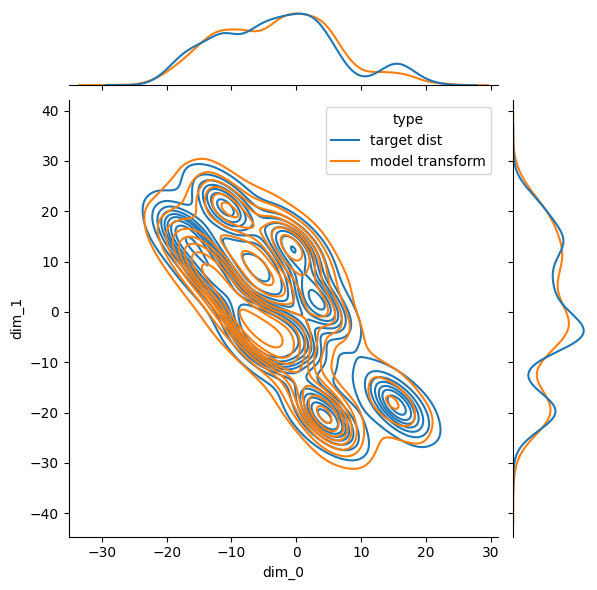

trail: 0 m step: 14 kl_test: 2.0853500366210938


  2%|▏         | 100/6000 [00:32<35:12,  2.79it/s]

trail: 0 m step: 15 Loss: 2.048389434814453  L_n: 1.9016761779785156  kld: 0.007335662841796875 KLD1: 1.821130394935608 KLD2: 1.040196418762207


  3%|▎         | 200/6000 [01:04<34:11,  2.83it/s]

trail: 0 m step: 15 Loss: 2.011922836303711  L_n: 1.8380489349365234  kld: 0.008693695068359375 KLD1: 1.8277555704116821 KLD2: 1.0401147603988647


  5%|▌         | 300/6000 [01:36<33:35,  2.83it/s]

trail: 0 m step: 15 Loss: 1.947561264038086  L_n: 1.7879161834716797  kld: 0.007982254028320312 KLD1: 1.785705804824829 KLD2: 1.0198954343795776


  7%|▋         | 400/6000 [02:08<33:01,  2.83it/s]

trail: 0 m step: 15 Loss: 1.9248485565185547  L_n: 1.828756332397461  kld: 0.0048046112060546875 KLD1: 1.8629010915756226 KLD2: 1.0148035287857056


  8%|▊         | 500/6000 [02:40<32:28,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9611320495605469  L_n: 1.8213996887207031  kld: 0.0069866180419921875 KLD1: 1.7899188995361328 KLD2: 1.0319983959197998


 10%|█         | 600/6000 [03:12<31:55,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9974288940429688  L_n: 1.8079910278320312  kld: 0.009471893310546875 KLD1: 1.7753468751907349 KLD2: 1.0419318675994873


 12%|█▏        | 700/6000 [03:44<31:22,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9910392761230469  L_n: 1.8169364929199219  kld: 0.00870513916015625 KLD1: 1.8136742115020752 KLD2: 1.019859790802002


 13%|█▎        | 800/6000 [04:16<30:49,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9665813446044922  L_n: 1.7843914031982422  kld: 0.0091094970703125 KLD1: 1.7913079261779785 KLD2: 1.0378186702728271


 15%|█▌        | 900/6000 [04:48<30:14,  2.81it/s]

trail: 0 m step: 15 Loss: 1.997781753540039  L_n: 1.7907581329345703  kld: 0.010351181030273438 KLD1: 1.7985109090805054 KLD2: 1.0414552688598633


 17%|█▋        | 1000/6000 [05:20<29:39,  2.81it/s]

trail: 0 m step: 15 Loss: 1.8928050994873047  L_n: 1.7781352996826172  kld: 0.005733489990234375 KLD1: 1.8148843050003052 KLD2: 1.0303529500961304


 18%|█▊        | 1100/6000 [05:53<29:00,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9985008239746094  L_n: 1.8040275573730469  kld: 0.009723663330078125 KLD1: 1.8262698650360107 KLD2: 1.0263975858688354


 20%|██        | 1200/6000 [06:25<28:19,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9426383972167969  L_n: 1.7807426452636719  kld: 0.00809478759765625 KLD1: 1.778380036354065 KLD2: 1.0386110544204712


 22%|██▏       | 1300/6000 [06:57<27:46,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9540538787841797  L_n: 1.7857494354248047  kld: 0.00841522216796875 KLD1: 1.8113614320755005 KLD2: 1.0482879877090454


 23%|██▎       | 1400/6000 [07:29<27:15,  2.81it/s]

trail: 0 m step: 15 Loss: 2.018850326538086  L_n: 1.8454723358154297  kld: 0.008668899536132812 KLD1: 1.7781546115875244 KLD2: 1.015616774559021


 25%|██▌       | 1500/6000 [08:01<26:38,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9603614807128906  L_n: 1.7887382507324219  kld: 0.008581161499023438 KLD1: 1.7482683658599854 KLD2: 0.9980349540710449


 27%|██▋       | 1600/6000 [08:33<26:00,  2.82it/s]

trail: 0 m step: 15 Loss: 1.938425064086914  L_n: 1.7808399200439453  kld: 0.007879257202148438 KLD1: 1.794655203819275 KLD2: 1.0058444738388062


 28%|██▊       | 1700/6000 [09:06<25:28,  2.81it/s]

trail: 0 m step: 15 Loss: 2.0330276489257812  L_n: 1.856597900390625  kld: 0.008821487426757812 KLD1: 1.8400187492370605 KLD2: 1.0444320440292358


 30%|███       | 1800/6000 [09:38<24:49,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9263916015625  L_n: 1.7545394897460938  kld: 0.008592605590820312 KLD1: 1.797545313835144 KLD2: 1.0099985599517822


 32%|███▏      | 1900/6000 [10:10<24:18,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9959659576416016  L_n: 1.8131275177001953  kld: 0.009141921997070312 KLD1: 1.7810674905776978 KLD2: 1.0312172174453735


 33%|███▎      | 2000/6000 [10:42<23:39,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9626712799072266  L_n: 1.8031024932861328  kld: 0.007978439331054688 KLD1: 1.8164128065109253 KLD2: 1.0305142402648926


 35%|███▌      | 2100/6000 [11:14<23:01,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9415397644042969  L_n: 1.7675514221191406  kld: 0.008699417114257812 KLD1: 1.7850452661514282 KLD2: 1.0316083431243896


 37%|███▋      | 2200/6000 [11:46<22:20,  2.84it/s]

trail: 0 m step: 15 Loss: 1.9763813018798828  L_n: 1.8149433135986328  kld: 0.0080718994140625 KLD1: 1.780615210533142 KLD2: 1.026519775390625


 38%|███▊      | 2300/6000 [12:18<21:56,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9120407104492188  L_n: 1.76849365234375  kld: 0.0071773529052734375 KLD1: 1.7851368188858032 KLD2: 1.0118237733840942


 40%|████      | 2400/6000 [12:50<21:12,  2.83it/s]

trail: 0 m step: 15 Loss: 1.9276885986328125  L_n: 1.7910079956054688  kld: 0.0068340301513671875 KLD1: 1.8076390027999878 KLD2: 1.0251325368881226


 42%|████▏     | 2500/6000 [13:22<20:45,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9220447540283203  L_n: 1.785135269165039  kld: 0.0068454742431640625 KLD1: 1.8023816347122192 KLD2: 1.0253645181655884


 43%|████▎     | 2600/6000 [13:55<20:07,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9341659545898438  L_n: 1.759490966796875  kld: 0.008733749389648438 KLD1: 1.7825193405151367 KLD2: 1.0076571702957153


 45%|████▌     | 2700/6000 [14:27<19:32,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9251155853271484  L_n: 1.7887401580810547  kld: 0.0068187713623046875 KLD1: 1.7863727807998657 KLD2: 1.0220149755477905


 47%|████▋     | 2800/6000 [14:59<18:55,  2.82it/s]

trail: 0 m step: 15 Loss: 1.935546875  L_n: 1.7667083740234375  kld: 0.008441925048828125 KLD1: 1.788616418838501 KLD2: 1.024769902229309


 48%|████▊     | 2900/6000 [15:31<18:19,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9773998260498047  L_n: 1.7946758270263672  kld: 0.009136199951171875 KLD1: 1.769851565361023 KLD2: 1.027963399887085


 50%|█████     | 3000/6000 [16:03<17:43,  2.82it/s]

trail: 0 m step: 15 Loss: 1.912832260131836  L_n: 1.7858028411865234  kld: 0.006351470947265625 KLD1: 1.8483476638793945 KLD2: 1.0109835863113403


 52%|█████▏    | 3100/6000 [16:35<17:12,  2.81it/s]

trail: 0 m step: 15 Loss: 1.8459110260009766  L_n: 1.7494373321533203  kld: 0.0048236846923828125 KLD1: 1.802304983139038 KLD2: 1.0030689239501953


 53%|█████▎    | 3200/6000 [17:08<16:34,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9970245361328125  L_n: 1.8175811767578125  kld: 0.00897216796875 KLD1: 1.7678415775299072 KLD2: 0.9987674355506897


 55%|█████▌    | 3300/6000 [17:40<15:58,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9380664825439453  L_n: 1.8193531036376953  kld: 0.0059356689453125 KLD1: 1.7792495489120483 KLD2: 1.0006428956985474


 57%|█████▋    | 3400/6000 [18:12<15:24,  2.81it/s]

trail: 0 m step: 15 Loss: 1.938943862915039  L_n: 1.7544269561767578  kld: 0.009225845336914062 KLD1: 1.7431700229644775 KLD2: 1.0262248516082764


 58%|█████▊    | 3500/6000 [18:44<14:49,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9818058013916016  L_n: 1.7975177764892578  kld: 0.009214401245117188 KLD1: 1.782960057258606 KLD2: 1.0250601768493652


 60%|██████    | 3600/6000 [19:16<14:10,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9354248046875  L_n: 1.7581939697265625  kld: 0.008861541748046875 KLD1: 1.774777889251709 KLD2: 1.0393110513687134


 62%|██████▏   | 3700/6000 [19:48<13:38,  2.81it/s]

trail: 0 m step: 15 Loss: 1.949411392211914  L_n: 1.7989978790283203  kld: 0.0075206756591796875 KLD1: 1.807598352432251 KLD2: 1.0249977111816406


 63%|██████▎   | 3800/6000 [20:20<12:59,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9549236297607422  L_n: 1.8232402801513672  kld: 0.00658416748046875 KLD1: 1.8197702169418335 KLD2: 1.0037540197372437


 65%|██████▌   | 3900/6000 [20:53<12:24,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9612159729003906  L_n: 1.7859306335449219  kld: 0.008764266967773438 KLD1: 1.75653076171875 KLD2: 1.0014773607254028


 67%|██████▋   | 4000/6000 [21:25<11:49,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9948863983154297  L_n: 1.7844295501708984  kld: 0.010522842407226562 KLD1: 1.7541708946228027 KLD2: 1.0127272605895996


 68%|██████▊   | 4100/6000 [21:57<11:16,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9975166320800781  L_n: 1.7969398498535156  kld: 0.010028839111328125 KLD1: 1.7250583171844482 KLD2: 1.0115290880203247


 70%|███████   | 4200/6000 [22:29<10:37,  2.82it/s]

trail: 0 m step: 15 Loss: 1.897531509399414  L_n: 1.7497119903564453  kld: 0.0073909759521484375 KLD1: 1.752748727798462 KLD2: 1.0204756259918213


 72%|███████▏  | 4300/6000 [23:01<10:05,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9777755737304688  L_n: 1.8114547729492188  kld: 0.0083160400390625 KLD1: 1.782455563545227 KLD2: 1.038347840309143


 73%|███████▎  | 4400/6000 [23:33<09:28,  2.82it/s]

trail: 0 m step: 15 Loss: 1.8665351867675781  L_n: 1.7364921569824219  kld: 0.0065021514892578125 KLD1: 1.8124850988388062 KLD2: 1.0194392204284668


 75%|███████▌  | 4500/6000 [24:05<08:53,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9256134033203125  L_n: 1.7644805908203125  kld: 0.008056640625 KLD1: 1.7378631830215454 KLD2: 1.0076195001602173


 77%|███████▋  | 4600/6000 [24:37<08:17,  2.82it/s]

trail: 0 m step: 15 Loss: 1.8840618133544922  L_n: 1.7630977630615234  kld: 0.0060482025146484375 KLD1: 1.785293698310852 KLD2: 1.039618730545044


 78%|███████▊  | 4700/6000 [25:10<07:41,  2.81it/s]

trail: 0 m step: 15 Loss: 1.8268871307373047  L_n: 1.7497539520263672  kld: 0.003856658935546875 KLD1: 1.8343249559402466 KLD2: 1.0209459066390991


 80%|████████  | 4800/6000 [25:42<07:06,  2.82it/s]

trail: 0 m step: 15 Loss: 1.897867202758789  L_n: 1.7820911407470703  kld: 0.0057888031005859375 KLD1: 1.791307806968689 KLD2: 1.0173540115356445


 82%|████████▏ | 4900/6000 [26:14<06:30,  2.81it/s]

trail: 0 m step: 15 Loss: 1.879150390625  L_n: 1.752044677734375  kld: 0.00635528564453125 KLD1: 1.8282816410064697 KLD2: 1.0091794729232788


 83%|████████▎ | 5000/6000 [26:46<05:54,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9286823272705078  L_n: 1.7862415313720703  kld: 0.007122039794921875 KLD1: 1.7880135774612427 KLD2: 1.023411512374878


 85%|████████▌ | 5100/6000 [27:18<05:19,  2.81it/s]

trail: 0 m step: 15 Loss: 1.8302650451660156  L_n: 1.7175407409667969  kld: 0.0056362152099609375 KLD1: 1.783007025718689 KLD2: 1.029376745223999


 87%|████████▋ | 5200/6000 [27:50<04:44,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9406051635742188  L_n: 1.7917556762695312  kld: 0.007442474365234375 KLD1: 1.7677958011627197 KLD2: 1.0231201648712158


 88%|████████▊ | 5300/6000 [28:22<04:08,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9565868377685547  L_n: 1.800985336303711  kld: 0.0077800750732421875 KLD1: 1.763235330581665 KLD2: 1.005919098854065


 90%|█████████ | 5400/6000 [28:54<03:33,  2.81it/s]

trail: 0 m step: 15 Loss: 1.9104557037353516  L_n: 1.7842655181884766  kld: 0.00630950927734375 KLD1: 1.8294241428375244 KLD2: 1.0160845518112183


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9388542175292969  L_n: 1.7846641540527344  kld: 0.007709503173828125 KLD1: 1.809446096420288 KLD2: 1.017665982246399


 93%|█████████▎| 5600/6000 [29:59<02:21,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9413909912109375  L_n: 1.7949447631835938  kld: 0.0073223114013671875 KLD1: 1.7906099557876587 KLD2: 1.0128517150878906


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.82it/s]

trail: 0 m step: 15 Loss: 1.891073226928711  L_n: 1.7591609954833984  kld: 0.006595611572265625 KLD1: 1.7753490209579468 KLD2: 1.027496337890625


 97%|█████████▋| 5800/6000 [31:03<01:10,  2.82it/s]

trail: 0 m step: 15 Loss: 1.9303913116455078  L_n: 1.799203872680664  kld: 0.0065593719482421875 KLD1: 1.7512893676757812 KLD2: 1.0085768699645996


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.83it/s]

trail: 0 m step: 15 Loss: 1.9421100616455078  L_n: 1.7865467071533203  kld: 0.007778167724609375 KLD1: 1.7712950706481934 KLD2: 1.0315935611724854


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 15 Loss: 1.9032039642333984  L_n: 1.766256332397461  kld: 0.006847381591796875 KLD1: 1.7831729650497437 KLD2: 1.025793194770813



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


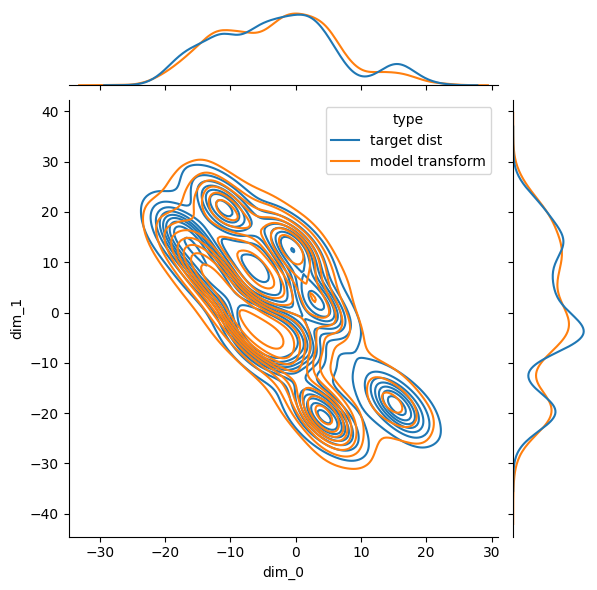

trail: 0 m step: 15 kl_test: 1.840911865234375


  2%|▏         | 100/6000 [00:32<35:16,  2.79it/s]

trail: 0 m step: 16 Loss: 1.7684345245361328  L_n: 1.6323261260986328  kld: 0.006805419921875 KLD1: 1.5874369144439697 KLD2: 0.9273889660835266


  3%|▎         | 200/6000 [01:04<34:11,  2.83it/s]

trail: 0 m step: 16 Loss: 1.8127765655517578  L_n: 1.6283740997314453  kld: 0.009220123291015625 KLD1: 1.5901728868484497 KLD2: 0.9306217432022095


  5%|▌         | 300/6000 [01:36<34:00,  2.79it/s]

trail: 0 m step: 16 Loss: 1.696981430053711  L_n: 1.5807476043701172  kld: 0.0058116912841796875 KLD1: 1.5987462997436523 KLD2: 0.9192553758621216


  7%|▋         | 400/6000 [02:08<33:02,  2.83it/s]

trail: 0 m step: 16 Loss: 1.7000045776367188  L_n: 1.6122665405273438  kld: 0.00438690185546875 KLD1: 1.6602269411087036 KLD2: 0.9094613194465637


  8%|▊         | 500/6000 [02:41<32:41,  2.80it/s]

trail: 0 m step: 16 Loss: 1.7775802612304688  L_n: 1.6283493041992188  kld: 0.0074615478515625 KLD1: 1.5753681659698486 KLD2: 0.9285097718238831


 10%|█         | 600/6000 [03:13<31:56,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7843990325927734  L_n: 1.6090373992919922  kld: 0.008768081665039062 KLD1: 1.5751320123672485 KLD2: 0.9314431548118591


 12%|█▏        | 700/6000 [03:45<31:18,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7859764099121094  L_n: 1.6137046813964844  kld: 0.00861358642578125 KLD1: 1.6000242233276367 KLD2: 0.9137111902236938


 13%|█▎        | 800/6000 [04:17<30:49,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7532997131347656  L_n: 1.5829734802246094  kld: 0.008516311645507812 KLD1: 1.5593317747116089 KLD2: 0.934124767780304


 15%|█▌        | 900/6000 [04:49<30:05,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7264652252197266  L_n: 1.5695667266845703  kld: 0.007844924926757812 KLD1: 1.543312430381775 KLD2: 0.9340007305145264


 17%|█▋        | 1000/6000 [05:21<29:33,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6932621002197266  L_n: 1.566995620727539  kld: 0.006313323974609375 KLD1: 1.6105217933654785 KLD2: 0.9222941994667053


 18%|█▊        | 1100/6000 [05:53<28:56,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7465553283691406  L_n: 1.5824851989746094  kld: 0.008203506469726562 KLD1: 1.5624514818191528 KLD2: 0.9107404351234436


 20%|██        | 1200/6000 [06:25<28:36,  2.80it/s]

trail: 0 m step: 16 Loss: 1.7202529907226562  L_n: 1.5619049072265625  kld: 0.007917404174804688 KLD1: 1.566665768623352 KLD2: 0.9328898191452026


 22%|██▏       | 1300/6000 [06:58<27:53,  2.81it/s]

trail: 0 m step: 16 Loss: 1.685781478881836  L_n: 1.5435314178466797  kld: 0.0071125030517578125 KLD1: 1.5831222534179688 KLD2: 0.9336231350898743


 23%|██▎       | 1400/6000 [07:30<27:11,  2.82it/s]

trail: 0 m step: 16 Loss: 1.789632797241211  L_n: 1.5953502655029297  kld: 0.009714126586914062 KLD1: 1.5614347457885742 KLD2: 0.9089773893356323


 25%|██▌       | 1500/6000 [08:02<26:38,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7104759216308594  L_n: 1.5579643249511719  kld: 0.007625579833984375 KLD1: 1.5455365180969238 KLD2: 0.89603590965271


 27%|██▋       | 1600/6000 [08:34<26:07,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6983070373535156  L_n: 1.5506019592285156  kld: 0.00738525390625 KLD1: 1.5554364919662476 KLD2: 0.9070629477500916


 28%|██▊       | 1700/6000 [09:06<25:31,  2.81it/s]

trail: 0 m step: 16 Loss: 1.8099117279052734  L_n: 1.650686264038086  kld: 0.007961273193359375 KLD1: 1.6333123445510864 KLD2: 0.9364194869995117


 30%|███       | 1800/6000 [09:38<24:55,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6924705505371094  L_n: 1.5527000427246094  kld: 0.006988525390625 KLD1: 1.5834556818008423 KLD2: 0.9021435379981995


 32%|███▏      | 1900/6000 [10:10<24:22,  2.80it/s]

trail: 0 m step: 16 Loss: 1.7233867645263672  L_n: 1.5687007904052734  kld: 0.0077342987060546875 KLD1: 1.5880508422851562 KLD2: 0.9321684241294861


 33%|███▎      | 2000/6000 [10:43<23:43,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7396869659423828  L_n: 1.6036548614501953  kld: 0.006801605224609375 KLD1: 1.6168761253356934 KLD2: 0.9238540530204773


 35%|███▌      | 2100/6000 [11:15<23:05,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7108230590820312  L_n: 1.5434722900390625  kld: 0.008367538452148438 KLD1: 1.559553623199463 KLD2: 0.9286196827888489


 37%|███▋      | 2200/6000 [11:47<22:32,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7240276336669922  L_n: 1.5803661346435547  kld: 0.007183074951171875 KLD1: 1.5651072263717651 KLD2: 0.9219969511032104


 38%|███▊      | 2300/6000 [12:19<21:56,  2.81it/s]

trail: 0 m step: 16 Loss: 1.696756362915039  L_n: 1.5612964630126953  kld: 0.0067729949951171875 KLD1: 1.5741275548934937 KLD2: 0.9036582708358765


 40%|████      | 2400/6000 [12:51<21:23,  2.80it/s]

trail: 0 m step: 16 Loss: 1.6743125915527344  L_n: 1.5773048400878906  kld: 0.0048503875732421875 KLD1: 1.5749491453170776 KLD2: 0.9227825999259949


 42%|████▏     | 2500/6000 [13:23<20:40,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6775856018066406  L_n: 1.5733299255371094  kld: 0.0052127838134765625 KLD1: 1.5842252969741821 KLD2: 0.9199650287628174


 43%|████▎     | 2600/6000 [13:55<20:04,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7175655364990234  L_n: 1.5637950897216797  kld: 0.0076885223388671875 KLD1: 1.5506738424301147 KLD2: 0.9053089618682861


 45%|████▌     | 2700/6000 [14:28<19:26,  2.83it/s]

trail: 0 m step: 16 Loss: 1.7139549255371094  L_n: 1.5818901062011719  kld: 0.006603240966796875 KLD1: 1.5569616556167603 KLD2: 0.9198572039604187


 47%|████▋     | 2800/6000 [15:00<18:57,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7439117431640625  L_n: 1.5856781005859375  kld: 0.00791168212890625 KLD1: 1.5863797664642334 KLD2: 0.9208342432975769


 48%|████▊     | 2900/6000 [15:32<18:24,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7539234161376953  L_n: 1.5919513702392578  kld: 0.008098602294921875 KLD1: 1.5432933568954468 KLD2: 0.9237979054450989


 50%|█████     | 3000/6000 [16:04<17:48,  2.81it/s]

trail: 0 m step: 16 Loss: 1.706216812133789  L_n: 1.5860538482666016  kld: 0.006008148193359375 KLD1: 1.6110615730285645 KLD2: 0.914196252822876


 52%|█████▏    | 3100/6000 [16:36<17:12,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6406269073486328  L_n: 1.5435428619384766  kld: 0.0048542022705078125 KLD1: 1.5795456171035767 KLD2: 0.9029425382614136


 53%|█████▎    | 3200/6000 [17:08<16:32,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7711048126220703  L_n: 1.6100101470947266  kld: 0.008054733276367188 KLD1: 1.5693923234939575 KLD2: 0.8991039991378784


 55%|█████▌    | 3300/6000 [17:40<15:55,  2.82it/s]

trail: 0 m step: 16 Loss: 1.693532943725586  L_n: 1.5958003997802734  kld: 0.004886627197265625 KLD1: 1.5922186374664307 KLD2: 0.8987005352973938


 57%|█████▋    | 3400/6000 [18:12<15:19,  2.83it/s]

trail: 0 m step: 16 Loss: 1.6938419342041016  L_n: 1.529275894165039  kld: 0.008228302001953125 KLD1: 1.5224958658218384 KLD2: 0.9240729212760925


 58%|█████▊    | 3500/6000 [18:45<14:51,  2.80it/s]

trail: 0 m step: 16 Loss: 1.7409515380859375  L_n: 1.5710067749023438  kld: 0.008497238159179688 KLD1: 1.5546187162399292 KLD2: 0.9193673729896545


 60%|██████    | 3600/6000 [19:17<14:10,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6809654235839844  L_n: 1.5288352966308594  kld: 0.00760650634765625 KLD1: 1.5606554746627808 KLD2: 0.9393243789672852


 62%|██████▏   | 3700/6000 [19:49<13:35,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6958999633789062  L_n: 1.5573501586914062  kld: 0.006927490234375 KLD1: 1.5654377937316895 KLD2: 0.9195855259895325


 63%|██████▎   | 3800/6000 [20:21<13:02,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6881675720214844  L_n: 1.5881462097167969  kld: 0.005001068115234375 KLD1: 1.608129858970642 KLD2: 0.9007213711738586


 65%|██████▌   | 3900/6000 [20:53<12:20,  2.84it/s]

trail: 0 m step: 16 Loss: 1.7302627563476562  L_n: 1.57244873046875  kld: 0.007890701293945312 KLD1: 1.5392953157424927 KLD2: 0.9003374576568604


 67%|██████▋   | 4000/6000 [21:25<11:49,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7451210021972656  L_n: 1.5723915100097656  kld: 0.008636474609375 KLD1: 1.5510038137435913 KLD2: 0.9105261564254761


 68%|██████▊   | 4100/6000 [21:57<11:16,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7465686798095703  L_n: 1.5741825103759766  kld: 0.008619308471679688 KLD1: 1.5156939029693604 KLD2: 0.9069786667823792


 70%|███████   | 4200/6000 [22:30<10:40,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6671695709228516  L_n: 1.5217533111572266  kld: 0.00727081298828125 KLD1: 1.550121784210205 KLD2: 0.9171624779701233


 72%|███████▏  | 4300/6000 [23:02<10:04,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7102832794189453  L_n: 1.5673847198486328  kld: 0.007144927978515625 KLD1: 1.581792950630188 KLD2: 0.9336901903152466


 73%|███████▎  | 4400/6000 [23:34<09:29,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6416072845458984  L_n: 1.5282344818115234  kld: 0.00566864013671875 KLD1: 1.5809669494628906 KLD2: 0.9153478145599365


 75%|███████▌  | 4500/6000 [24:06<08:53,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7123165130615234  L_n: 1.5570964813232422  kld: 0.0077610015869140625 KLD1: 1.5292460918426514 KLD2: 0.9029805660247803


 77%|███████▋  | 4600/6000 [24:38<08:19,  2.80it/s]

trail: 0 m step: 16 Loss: 1.678375244140625  L_n: 1.5655364990234375  kld: 0.005641937255859375 KLD1: 1.594835638999939 KLD2: 0.9363706707954407


 78%|███████▊  | 4700/6000 [25:10<07:41,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6506080627441406  L_n: 1.5713768005371094  kld: 0.0039615631103515625 KLD1: 1.619191288948059 KLD2: 0.9215075969696045


 80%|████████  | 4800/6000 [25:42<07:06,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6969280242919922  L_n: 1.5774517059326172  kld: 0.00597381591796875 KLD1: 1.5833503007888794 KLD2: 0.915252149105072


 82%|████████▏ | 4900/6000 [26:15<06:31,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6498737335205078  L_n: 1.5487079620361328  kld: 0.00505828857421875 KLD1: 1.6167656183242798 KLD2: 0.9063274264335632


 83%|████████▎ | 5000/6000 [26:47<05:55,  2.81it/s]

trail: 0 m step: 16 Loss: 1.7020072937011719  L_n: 1.5743293762207031  kld: 0.0063838958740234375 KLD1: 1.5982366800308228 KLD2: 0.9179747700691223


 85%|████████▌ | 5100/6000 [27:19<05:20,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6467170715332031  L_n: 1.5326194763183594  kld: 0.0057048797607421875 KLD1: 1.5880160331726074 KLD2: 0.9268302321434021


 87%|████████▋ | 5200/6000 [27:51<04:43,  2.82it/s]

trail: 0 m step: 16 Loss: 1.680633544921875  L_n: 1.5527267456054688  kld: 0.0063953399658203125 KLD1: 1.5485947132110596 KLD2: 0.9180241823196411


 88%|████████▊ | 5300/6000 [28:23<04:08,  2.82it/s]

trail: 0 m step: 16 Loss: 1.7307872772216797  L_n: 1.5926952362060547  kld: 0.00690460205078125 KLD1: 1.5410593748092651 KLD2: 0.9029783010482788


 90%|█████████ | 5400/6000 [28:55<03:32,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6774349212646484  L_n: 1.5453319549560547  kld: 0.0066051483154296875 KLD1: 1.593122959136963 KLD2: 0.9099110960960388


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6962108612060547  L_n: 1.5652904510498047  kld: 0.0065460205078125 KLD1: 1.5683681964874268 KLD2: 0.9135748744010925


 93%|█████████▎| 5600/6000 [30:00<02:22,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6934471130371094  L_n: 1.5721778869628906  kld: 0.0060634613037109375 KLD1: 1.5596833229064941 KLD2: 0.9096722602844238


 95%|█████████▌| 5700/6000 [30:32<01:46,  2.82it/s]

trail: 0 m step: 16 Loss: 1.6374015808105469  L_n: 1.5490913391113281  kld: 0.0044155120849609375 KLD1: 1.577872395515442 KLD2: 0.9238503575325012


 97%|█████████▋| 5800/6000 [31:04<01:11,  2.80it/s]

trail: 0 m step: 16 Loss: 1.7093658447265625  L_n: 1.5986251831054688  kld: 0.0055370330810546875 KLD1: 1.5422232151031494 KLD2: 0.9069548845291138


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.81it/s]

trail: 0 m step: 16 Loss: 1.6940155029296875  L_n: 1.5665283203125  kld: 0.006374359130859375 KLD1: 1.5513148307800293 KLD2: 0.9262422323226929


100%|██████████| 6000/6000 [32:08<00:00,  3.11it/s]

trail: 0 m step: 16 Loss: 1.6966495513916016  L_n: 1.5781269073486328  kld: 0.0059261322021484375 KLD1: 1.5643640756607056 KLD2: 0.923749566078186



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


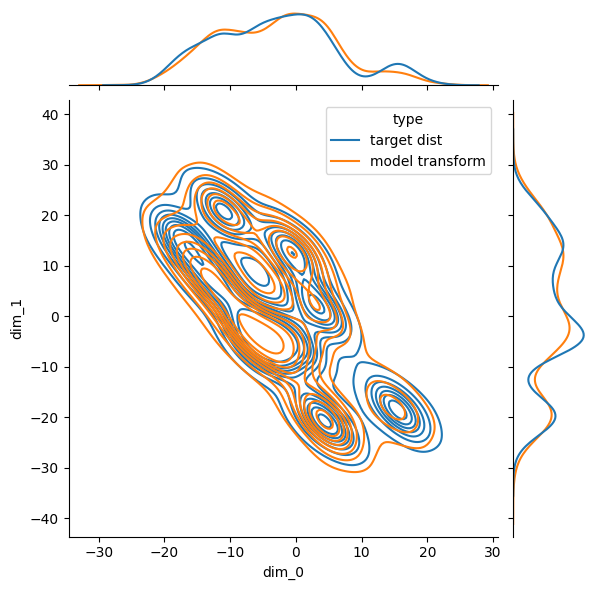

trail: 0 m step: 16 kl_test: 1.6254520416259766


  2%|▏         | 100/6000 [00:32<35:19,  2.78it/s]

trail: 0 m step: 17 Loss: 1.5818862915039062  L_n: 1.450927734375  kld: 0.0065479278564453125 KLD1: 1.4050871133804321 KLD2: 0.8413302302360535


  3%|▎         | 200/6000 [01:04<34:10,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5927562713623047  L_n: 1.4303264617919922  kld: 0.008121490478515625 KLD1: 1.439744472503662 KLD2: 0.8418013453483582


  5%|▌         | 300/6000 [01:36<33:48,  2.81it/s]

trail: 0 m step: 17 Loss: 1.5091438293457031  L_n: 1.4040870666503906  kld: 0.005252838134765625 KLD1: 1.3952840566635132 KLD2: 0.8299317359924316


  7%|▋         | 400/6000 [02:08<33:18,  2.80it/s]

trail: 0 m step: 17 Loss: 1.5027275085449219  L_n: 1.4233436584472656  kld: 0.0039691925048828125 KLD1: 1.4321606159210205 KLD2: 0.8171010613441467


  8%|▊         | 500/6000 [02:40<32:34,  2.81it/s]

trail: 0 m step: 17 Loss: 1.534027099609375  L_n: 1.4105453491210938  kld: 0.0061740875244140625 KLD1: 1.3915045261383057 KLD2: 0.8375380635261536


 10%|█         | 600/6000 [03:12<31:54,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5836353302001953  L_n: 1.428110122680664  kld: 0.0077762603759765625 KLD1: 1.3758248090744019 KLD2: 0.8430349230766296


 12%|█▏        | 700/6000 [03:44<31:20,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5799140930175781  L_n: 1.4223289489746094  kld: 0.007879257202148438 KLD1: 1.4121400117874146 KLD2: 0.8271026015281677


 13%|█▎        | 800/6000 [04:16<30:37,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5348892211914062  L_n: 1.3879852294921875  kld: 0.0073451995849609375 KLD1: 1.3882942199707031 KLD2: 0.8453103303909302


 15%|█▌        | 900/6000 [04:48<30:02,  2.83it/s]

trail: 0 m step: 17 Loss: 1.576711654663086  L_n: 1.389181137084961  kld: 0.00937652587890625 KLD1: 1.3818014860153198 KLD2: 0.8423526287078857


 17%|█▋        | 1000/6000 [05:20<29:31,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4990482330322266  L_n: 1.3800296783447266  kld: 0.005950927734375 KLD1: 1.4059165716171265 KLD2: 0.8338031768798828


 18%|█▊        | 1100/6000 [05:53<28:56,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5610847473144531  L_n: 1.3980445861816406  kld: 0.008152008056640625 KLD1: 1.4153016805648804 KLD2: 0.8208582997322083


 20%|██        | 1200/6000 [06:25<28:22,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5065956115722656  L_n: 1.3754844665527344  kld: 0.0065555572509765625 KLD1: 1.4148657321929932 KLD2: 0.841262698173523


 22%|██▏       | 1300/6000 [06:57<27:38,  2.83it/s]

trail: 0 m step: 17 Loss: 1.534708023071289  L_n: 1.398904800415039  kld: 0.0067901611328125 KLD1: 1.4273141622543335 KLD2: 0.8494070172309875


 23%|██▎       | 1400/6000 [07:29<27:18,  2.81it/s]

trail: 0 m step: 17 Loss: 1.595458984375  L_n: 1.435394287109375  kld: 0.00800323486328125 KLD1: 1.3834128379821777 KLD2: 0.8196841478347778


 25%|██▌       | 1500/6000 [08:01<26:38,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5391407012939453  L_n: 1.3850650787353516  kld: 0.0077037811279296875 KLD1: 1.3635683059692383 KLD2: 0.807905912399292


 27%|██▋       | 1600/6000 [08:33<25:54,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5017776489257812  L_n: 1.3715438842773438  kld: 0.006511688232421875 KLD1: 1.3686624765396118 KLD2: 0.8221856355667114


 28%|██▊       | 1700/6000 [09:05<25:25,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5932025909423828  L_n: 1.4458789825439453  kld: 0.007366180419921875 KLD1: 1.4339762926101685 KLD2: 0.8474196791648865


 30%|███       | 1800/6000 [09:37<24:50,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5266494750976562  L_n: 1.3740234375  kld: 0.0076313018798828125 KLD1: 1.4361872673034668 KLD2: 0.8254953026771545


 32%|███▏      | 1900/6000 [10:09<24:07,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5961227416992188  L_n: 1.388641357421875  kld: 0.010374069213867188 KLD1: 1.406703233718872 KLD2: 0.8366169929504395


 33%|███▎      | 2000/6000 [10:41<23:43,  2.81it/s]

trail: 0 m step: 17 Loss: 1.53900146484375  L_n: 1.4030838012695312  kld: 0.0067958831787109375 KLD1: 1.412241816520691 KLD2: 0.8311683535575867


 35%|███▌      | 2100/6000 [11:13<23:00,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5084686279296875  L_n: 1.368011474609375  kld: 0.007022857666015625 KLD1: 1.3670992851257324 KLD2: 0.8391702771186829


 37%|███▋      | 2200/6000 [11:45<22:26,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5219268798828125  L_n: 1.3842926025390625  kld: 0.0068817138671875 KLD1: 1.3934720754623413 KLD2: 0.8290804624557495


 38%|███▊      | 2300/6000 [12:17<21:52,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4873695373535156  L_n: 1.3874626159667969  kld: 0.0049953460693359375 KLD1: 1.4339408874511719 KLD2: 0.8202868700027466


 40%|████      | 2400/6000 [12:49<21:15,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4964981079101562  L_n: 1.3975830078125  kld: 0.0049457550048828125 KLD1: 1.4001272916793823 KLD2: 0.8351781964302063


 42%|████▏     | 2500/6000 [13:22<20:38,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5181198120117188  L_n: 1.4041366577148438  kld: 0.00569915771484375 KLD1: 1.3860610723495483 KLD2: 0.8302263617515564


 43%|████▎     | 2600/6000 [13:54<20:08,  2.81it/s]

trail: 0 m step: 17 Loss: 1.5252094268798828  L_n: 1.376932144165039  kld: 0.0074138641357421875 KLD1: 1.3798381090164185 KLD2: 0.8176138997077942


 45%|████▌     | 2700/6000 [14:26<19:31,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5117950439453125  L_n: 1.4116592407226562  kld: 0.0050067901611328125 KLD1: 1.3926482200622559 KLD2: 0.8328054547309875


 47%|████▋     | 2800/6000 [14:58<18:55,  2.82it/s]

trail: 0 m step: 17 Loss: 1.514373779296875  L_n: 1.3813552856445312  kld: 0.0066509246826171875 KLD1: 1.3741759061813354 KLD2: 0.8257521390914917


 48%|████▊     | 2900/6000 [15:30<18:18,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5643787384033203  L_n: 1.402292251586914  kld: 0.008104324340820312 KLD1: 1.3636778593063354 KLD2: 0.8313924670219421


 50%|█████     | 3000/6000 [16:02<17:39,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5194835662841797  L_n: 1.3934459686279297  kld: 0.0063018798828125 KLD1: 1.4254921674728394 KLD2: 0.8244975209236145


 52%|█████▏    | 3100/6000 [16:34<17:02,  2.84it/s]

trail: 0 m step: 17 Loss: 1.4330558776855469  L_n: 1.3444404602050781  kld: 0.0044307708740234375 KLD1: 1.4080842733383179 KLD2: 0.811342179775238


 53%|█████▎    | 3200/6000 [17:06<16:31,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5350399017333984  L_n: 1.406332015991211  kld: 0.006435394287109375 KLD1: 1.3933671712875366 KLD2: 0.8107070326805115


 55%|█████▌    | 3300/6000 [17:38<15:56,  2.82it/s]

trail: 0 m step: 17 Loss: 1.516672134399414  L_n: 1.421609878540039  kld: 0.00475311279296875 KLD1: 1.3859411478042603 KLD2: 0.8108262419700623


 57%|█████▋    | 3400/6000 [18:10<15:17,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5101757049560547  L_n: 1.3546123504638672  kld: 0.007778167724609375 KLD1: 1.3497947454452515 KLD2: 0.8311915993690491


 58%|█████▊    | 3500/6000 [18:42<14:42,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5527820587158203  L_n: 1.3999271392822266  kld: 0.0076427459716796875 KLD1: 1.3779643774032593 KLD2: 0.8313568234443665


 60%|██████    | 3600/6000 [19:14<14:08,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5219230651855469  L_n: 1.3763923645019531  kld: 0.0072765350341796875 KLD1: 1.3649176359176636 KLD2: 0.8545235991477966


 62%|██████▏   | 3700/6000 [19:46<13:32,  2.83it/s]

trail: 0 m step: 17 Loss: 1.556661605834961  L_n: 1.412923812866211  kld: 0.0071868896484375 KLD1: 1.3758496046066284 KLD2: 0.8353790640830994


 63%|██████▎   | 3800/6000 [20:18<12:56,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5248889923095703  L_n: 1.426126480102539  kld: 0.0049381256103515625 KLD1: 1.4009816646575928 KLD2: 0.8120813965797424


 65%|██████▌   | 3900/6000 [20:50<12:26,  2.81it/s]

trail: 0 m step: 17 Loss: 1.5184650421142578  L_n: 1.3838443756103516  kld: 0.0067310333251953125 KLD1: 1.3821015357971191 KLD2: 0.8160809874534607


 67%|██████▋   | 4000/6000 [21:22<11:49,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5310935974121094  L_n: 1.3773612976074219  kld: 0.007686614990234375 KLD1: 1.3800135850906372 KLD2: 0.820903480052948


 68%|██████▊   | 4100/6000 [21:54<11:13,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5476112365722656  L_n: 1.4016609191894531  kld: 0.007297515869140625 KLD1: 1.3335987329483032 KLD2: 0.8229568004608154


 70%|███████   | 4200/6000 [22:27<10:41,  2.81it/s]

trail: 0 m step: 17 Loss: 1.4825172424316406  L_n: 1.3599510192871094  kld: 0.0061283111572265625 KLD1: 1.3804454803466797 KLD2: 0.8268938064575195


 72%|███████▏  | 4300/6000 [22:59<10:01,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5202484130859375  L_n: 1.4052734375  kld: 0.005748748779296875 KLD1: 1.4092820882797241 KLD2: 0.8451703190803528


 73%|███████▎  | 4400/6000 [23:31<09:27,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4792613983154297  L_n: 1.3722972869873047  kld: 0.00534820556640625 KLD1: 1.4022259712219238 KLD2: 0.8262167572975159


 75%|███████▌  | 4500/6000 [24:03<08:53,  2.81it/s]

trail: 0 m step: 17 Loss: 1.5048789978027344  L_n: 1.3945579528808594  kld: 0.00551605224609375 KLD1: 1.374555230140686 KLD2: 0.8147315382957458


 77%|███████▋  | 4600/6000 [24:35<08:13,  2.84it/s]

trail: 0 m step: 17 Loss: 1.4585247039794922  L_n: 1.3663997650146484  kld: 0.0046062469482421875 KLD1: 1.4072153568267822 KLD2: 0.8487824201583862


 78%|███████▊  | 4700/6000 [25:07<07:39,  2.83it/s]

trail: 0 m step: 17 Loss: 1.4203205108642578  L_n: 1.3802661895751953  kld: 0.002002716064453125 KLD1: 1.4401510953903198 KLD2: 0.8317425847053528


 80%|████████  | 4800/6000 [25:39<07:04,  2.83it/s]

trail: 0 m step: 17 Loss: 1.5098094940185547  L_n: 1.4052486419677734  kld: 0.0052280426025390625 KLD1: 1.3930413722991943 KLD2: 0.8292157053947449


 82%|████████▏ | 4900/6000 [26:11<06:29,  2.83it/s]

trail: 0 m step: 17 Loss: 1.4570350646972656  L_n: 1.3727684020996094  kld: 0.0042133331298828125 KLD1: 1.4331761598587036 KLD2: 0.818897545337677


 83%|████████▎ | 5000/6000 [26:43<05:54,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5166034698486328  L_n: 1.407083511352539  kld: 0.0054759979248046875 KLD1: 1.4028801918029785 KLD2: 0.8293421864509583


 85%|████████▌ | 5100/6000 [27:15<05:19,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4633140563964844  L_n: 1.3567314147949219  kld: 0.005329132080078125 KLD1: 1.3923659324645996 KLD2: 0.8400845527648926


 87%|████████▋ | 5200/6000 [27:47<04:45,  2.80it/s]

trail: 0 m step: 17 Loss: 1.4883441925048828  L_n: 1.3650150299072266  kld: 0.0061664581298828125 KLD1: 1.3651388883590698 KLD2: 0.8325789570808411


 88%|████████▊ | 5300/6000 [28:19<04:08,  2.81it/s]

trail: 0 m step: 17 Loss: 1.5207138061523438  L_n: 1.415313720703125  kld: 0.0052700042724609375 KLD1: 1.3817967176437378 KLD2: 0.818548858165741


 90%|█████████ | 5400/6000 [28:52<03:32,  2.83it/s]

trail: 0 m step: 17 Loss: 1.4905357360839844  L_n: 1.3902091979980469  kld: 0.005016326904296875 KLD1: 1.4022554159164429 KLD2: 0.8261519074440002


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.81it/s]

trail: 0 m step: 17 Loss: 1.5136528015136719  L_n: 1.3996696472167969  kld: 0.00569915771484375 KLD1: 1.3862111568450928 KLD2: 0.8300437331199646


 93%|█████████▎| 5600/6000 [29:56<02:21,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4912185668945312  L_n: 1.3751373291015625  kld: 0.0058040618896484375 KLD1: 1.3755296468734741 KLD2: 0.8193036913871765


 95%|█████████▌| 5700/6000 [30:28<01:46,  2.82it/s]

trail: 0 m step: 17 Loss: 1.4734077453613281  L_n: 1.3955879211425781  kld: 0.0038909912109375 KLD1: 1.3821344375610352 KLD2: 0.8368417620658875


 97%|█████████▋| 5800/6000 [31:00<01:11,  2.81it/s]

trail: 0 m step: 17 Loss: 1.4969348907470703  L_n: 1.3988208770751953  kld: 0.00490570068359375 KLD1: 1.390854835510254 KLD2: 0.8223300576210022


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.82it/s]

trail: 0 m step: 17 Loss: 1.5118293762207031  L_n: 1.4038352966308594  kld: 0.0053997039794921875 KLD1: 1.423846960067749 KLD2: 0.8407155871391296


100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

trail: 0 m step: 17 Loss: 1.5220413208007812  L_n: 1.4097747802734375  kld: 0.0056133270263671875 KLD1: 1.3965787887573242 KLD2: 0.8344236016273499



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


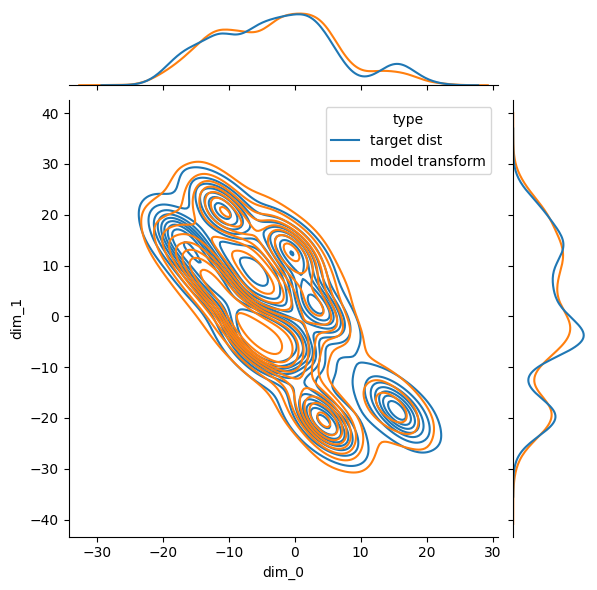

trail: 0 m step: 17 kl_test: 1.4408550262451172


  2%|▏         | 100/6000 [00:32<35:08,  2.80it/s]

trail: 0 m step: 18 Loss: 1.4161319732666016  L_n: 1.3084430694580078  kld: 0.0053844451904296875 KLD1: 1.248523235321045 KLD2: 0.7665407061576843


  3%|▎         | 200/6000 [01:04<34:01,  2.84it/s]

trail: 0 m step: 18 Loss: 1.4327754974365234  L_n: 1.2815227508544922  kld: 0.0075626373291015625 KLD1: 1.2822130918502808 KLD2: 0.7651296854019165


  5%|▌         | 300/6000 [01:36<33:39,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3635139465332031  L_n: 1.2671928405761719  kld: 0.0048160552978515625 KLD1: 1.2454792261123657 KLD2: 0.7524467706680298


  7%|▋         | 400/6000 [02:08<33:12,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3838729858398438  L_n: 1.2857589721679688  kld: 0.00490570068359375 KLD1: 1.3151768445968628 KLD2: 0.7439740300178528


  8%|▊         | 500/6000 [02:40<32:39,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3741798400878906  L_n: 1.2601966857910156  kld: 0.00569915771484375 KLD1: 1.2325160503387451 KLD2: 0.7590785026550293


 10%|█         | 600/6000 [03:12<32:01,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3800296783447266  L_n: 1.270242691040039  kld: 0.005489349365234375 KLD1: 1.24746572971344 KLD2: 0.7673560380935669


 12%|█▏        | 700/6000 [03:45<31:21,  2.82it/s]

trail: 0 m step: 18 Loss: 1.4276447296142578  L_n: 1.2791767120361328  kld: 0.00742340087890625 KLD1: 1.2530226707458496 KLD2: 0.7523701190948486


 13%|█▎        | 800/6000 [04:17<30:47,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3751449584960938  L_n: 1.247772216796875  kld: 0.0063686370849609375 KLD1: 1.2412612438201904 KLD2: 0.7692752480506897


 15%|█▌        | 900/6000 [04:49<30:04,  2.83it/s]

trail: 0 m step: 18 Loss: 1.3771953582763672  L_n: 1.2493267059326172  kld: 0.0063934326171875 KLD1: 1.2348017692565918 KLD2: 0.7663639783859253


 17%|█▋        | 1000/6000 [05:21<29:39,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3150634765625  L_n: 1.2235870361328125  kld: 0.004573822021484375 KLD1: 1.2689845561981201 KLD2: 0.7583870887756348


 18%|█▊        | 1100/6000 [05:53<28:54,  2.82it/s]

trail: 0 m step: 18 Loss: 1.4089069366455078  L_n: 1.255899429321289  kld: 0.0076503753662109375 KLD1: 1.238556981086731 KLD2: 0.7425815463066101


 20%|██        | 1200/6000 [06:25<28:13,  2.83it/s]

trail: 0 m step: 18 Loss: 1.3583316802978516  L_n: 1.2478580474853516  kld: 0.005523681640625 KLD1: 1.245985507965088 KLD2: 0.762935996055603


 22%|██▏       | 1300/6000 [06:57<27:48,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3743362426757812  L_n: 1.2418136596679688  kld: 0.006626129150390625 KLD1: 1.2828274965286255 KLD2: 0.7691637873649597


 23%|██▎       | 1400/6000 [07:29<27:13,  2.82it/s]

trail: 0 m step: 18 Loss: 1.4363899230957031  L_n: 1.2692680358886719  kld: 0.008356094360351562 KLD1: 1.2127376794815063 KLD2: 0.7425511479377747


 25%|██▌       | 1500/6000 [08:02<26:36,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3866710662841797  L_n: 1.2424373626708984  kld: 0.0072116851806640625 KLD1: 1.205332636833191 KLD2: 0.7250067591667175


 27%|██▋       | 1600/6000 [08:34<26:03,  2.81it/s]

trail: 0 m step: 18 Loss: 1.363576889038086  L_n: 1.217855453491211  kld: 0.00728607177734375 KLD1: 1.2318321466445923 KLD2: 0.7455247640609741


 28%|██▊       | 1700/6000 [09:06<25:26,  2.82it/s]

trail: 0 m step: 18 Loss: 1.4267349243164062  L_n: 1.2974166870117188  kld: 0.006465911865234375 KLD1: 1.2996177673339844 KLD2: 0.7672749757766724


 30%|███       | 1800/6000 [09:38<24:45,  2.83it/s]

trail: 0 m step: 18 Loss: 1.3452033996582031  L_n: 1.2327842712402344  kld: 0.0056209564208984375 KLD1: 1.2443318367004395 KLD2: 0.7397971749305725


 32%|███▏      | 1900/6000 [10:10<24:13,  2.82it/s]

trail: 0 m step: 18 Loss: 1.378835678100586  L_n: 1.2436046600341797  kld: 0.0067615509033203125 KLD1: 1.252509355545044 KLD2: 0.764822781085968


 33%|███▎      | 2000/6000 [10:42<23:36,  2.82it/s]

trail: 0 m step: 18 Loss: 1.365652084350586  L_n: 1.2503337860107422  kld: 0.0057659149169921875 KLD1: 1.2402679920196533 KLD2: 0.7571434378623962


 35%|███▌      | 2100/6000 [11:14<23:01,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3510608673095703  L_n: 1.2389850616455078  kld: 0.005603790283203125 KLD1: 1.2207980155944824 KLD2: 0.7613347172737122


 37%|███▋      | 2200/6000 [11:46<22:24,  2.83it/s]

trail: 0 m step: 18 Loss: 1.3681011199951172  L_n: 1.2520198822021484  kld: 0.0058040618896484375 KLD1: 1.2380181550979614 KLD2: 0.7498347759246826


 38%|███▊      | 2300/6000 [12:18<21:48,  2.83it/s]

trail: 0 m step: 18 Loss: 1.3293876647949219  L_n: 1.2366523742675781  kld: 0.0046367645263671875 KLD1: 1.253856897354126 KLD2: 0.7389824986457825


 40%|████      | 2400/6000 [12:51<21:14,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3489418029785156  L_n: 1.2531166076660156  kld: 0.004791259765625 KLD1: 1.2681183815002441 KLD2: 0.7568610310554504


 42%|████▏     | 2500/6000 [13:23<20:44,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3274784088134766  L_n: 1.2296314239501953  kld: 0.0048923492431640625 KLD1: 1.2356069087982178 KLD2: 0.751153290271759


 43%|████▎     | 2600/6000 [13:55<20:03,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3305606842041016  L_n: 1.2123050689697266  kld: 0.00591278076171875 KLD1: 1.2204519510269165 KLD2: 0.740932822227478


 45%|████▌     | 2700/6000 [14:27<19:33,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3628196716308594  L_n: 1.2668418884277344  kld: 0.00479888916015625 KLD1: 1.2219125032424927 KLD2: 0.753508448600769


 47%|████▋     | 2800/6000 [14:59<18:54,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3393230438232422  L_n: 1.2345714569091797  kld: 0.005237579345703125 KLD1: 1.2210050821304321 KLD2: 0.7492461800575256


 48%|████▊     | 2900/6000 [15:31<18:17,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3800582885742188  L_n: 1.2671432495117188  kld: 0.005645751953125 KLD1: 1.216119647026062 KLD2: 0.7554939985275269


 50%|█████     | 3000/6000 [16:03<17:46,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3384723663330078  L_n: 1.262063980102539  kld: 0.0038204193115234375 KLD1: 1.270343542098999 KLD2: 0.7471729516983032


 52%|█████▏    | 3100/6000 [16:35<17:11,  2.81it/s]

trail: 0 m step: 18 Loss: 1.2862796783447266  L_n: 1.210519790649414  kld: 0.003787994384765625 KLD1: 1.2384947538375854 KLD2: 0.7349891662597656


 53%|█████▎    | 3200/6000 [17:07<16:33,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3732490539550781  L_n: 1.2371788024902344  kld: 0.0068035125732421875 KLD1: 1.2530527114868164 KLD2: 0.7295832633972168


 55%|█████▌    | 3300/6000 [17:39<15:59,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3302288055419922  L_n: 1.2707958221435547  kld: 0.002971649169921875 KLD1: 1.2359294891357422 KLD2: 0.7302421927452087


 57%|█████▋    | 3400/6000 [18:12<15:28,  2.80it/s]

trail: 0 m step: 18 Loss: 1.3633804321289062  L_n: 1.2093048095703125  kld: 0.0077037811279296875 KLD1: 1.1963415145874023 KLD2: 0.7499576807022095


 58%|█████▊    | 3500/6000 [18:44<14:51,  2.81it/s]

trail: 0 m step: 18 Loss: 1.352914810180664  L_n: 1.2200870513916016  kld: 0.006641387939453125 KLD1: 1.225152611732483 KLD2: 0.7463692426681519


 60%|██████    | 3600/6000 [19:16<14:17,  2.80it/s]

trail: 0 m step: 18 Loss: 1.339853286743164  L_n: 1.205575942993164  kld: 0.0067138671875 KLD1: 1.217500925064087 KLD2: 0.7725905776023865


 62%|██████▏   | 3700/6000 [19:48<13:38,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3456172943115234  L_n: 1.222097396850586  kld: 0.006175994873046875 KLD1: 1.2288877964019775 KLD2: 0.7519122958183289


 63%|██████▎   | 3800/6000 [20:21<13:03,  2.81it/s]

trail: 0 m step: 18 Loss: 1.352121353149414  L_n: 1.2780017852783203  kld: 0.0037059783935546875 KLD1: 1.283087134361267 KLD2: 0.7389785051345825


 65%|██████▌   | 3900/6000 [20:53<12:30,  2.80it/s]

trail: 0 m step: 18 Loss: 1.3433036804199219  L_n: 1.2258491516113281  kld: 0.0058727264404296875 KLD1: 1.2155287265777588 KLD2: 0.7375105023384094


 67%|██████▋   | 4000/6000 [21:25<11:51,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3587398529052734  L_n: 1.2203426361083984  kld: 0.00691986083984375 KLD1: 1.226810336112976 KLD2: 0.7429647445678711


 68%|██████▊   | 4100/6000 [21:57<11:13,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3615760803222656  L_n: 1.2363014221191406  kld: 0.00626373291015625 KLD1: 1.1936662197113037 KLD2: 0.7416215538978577


 70%|███████   | 4200/6000 [22:29<10:37,  2.83it/s]

trail: 0 m step: 18 Loss: 1.2927780151367188  L_n: 1.1904296875  kld: 0.0051174163818359375 KLD1: 1.2381970882415771 KLD2: 0.7488093972206116


 72%|███████▏  | 4300/6000 [23:01<10:04,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3551921844482422  L_n: 1.238729476928711  kld: 0.0058231353759765625 KLD1: 1.249377727508545 KLD2: 0.7617261409759521


 73%|███████▎  | 4400/6000 [23:34<09:28,  2.82it/s]

trail: 0 m step: 18 Loss: 1.3103866577148438  L_n: 1.2270355224609375  kld: 0.0041675567626953125 KLD1: 1.2570350170135498 KLD2: 0.7477213740348816


 75%|███████▌  | 4500/6000 [24:06<08:54,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3441524505615234  L_n: 1.2270030975341797  kld: 0.0058574676513671875 KLD1: 1.2022249698638916 KLD2: 0.735347330570221


 77%|███████▋  | 4600/6000 [24:38<08:17,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3067741394042969  L_n: 1.2283058166503906  kld: 0.0039234161376953125 KLD1: 1.260689377784729 KLD2: 0.768674910068512


 78%|███████▊  | 4700/6000 [25:10<07:43,  2.80it/s]

trail: 0 m step: 18 Loss: 1.272369384765625  L_n: 1.2369308471679688  kld: 0.0017719268798828125 KLD1: 1.2762174606323242 KLD2: 0.7519844174385071


 80%|████████  | 4800/6000 [25:42<07:06,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3207111358642578  L_n: 1.2317523956298828  kld: 0.00444793701171875 KLD1: 1.2486870288848877 KLD2: 0.7487134337425232


 82%|████████▏ | 4900/6000 [26:15<06:31,  2.81it/s]

trail: 0 m step: 18 Loss: 1.2841815948486328  L_n: 1.2031192779541016  kld: 0.0040531158447265625 KLD1: 1.273228406906128 KLD2: 0.7357119917869568


 83%|████████▎ | 5000/6000 [26:47<05:56,  2.80it/s]

trail: 0 m step: 18 Loss: 1.3258781433105469  L_n: 1.2333717346191406  kld: 0.0046253204345703125 KLD1: 1.2586734294891357 KLD2: 0.7499890327453613


 85%|████████▌ | 5100/6000 [27:19<05:20,  2.81it/s]

trail: 0 m step: 18 Loss: 1.298583984375  L_n: 1.2187423706054688  kld: 0.0039920806884765625 KLD1: 1.2420979738235474 KLD2: 0.7622057199478149


 87%|████████▋ | 5200/6000 [27:51<04:44,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3324661254882812  L_n: 1.2309188842773438  kld: 0.005077362060546875 KLD1: 1.2135459184646606 KLD2: 0.7533178329467773


 88%|████████▊ | 5300/6000 [28:23<04:08,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3437652587890625  L_n: 1.2575531005859375  kld: 0.00431060791015625 KLD1: 1.2286388874053955 KLD2: 0.7387194633483887


 90%|█████████ | 5400/6000 [28:55<03:32,  2.83it/s]

trail: 0 m step: 18 Loss: 1.3262977600097656  L_n: 1.2313880920410156  kld: 0.0047454833984375 KLD1: 1.2718735933303833 KLD2: 0.7488344311714172


 92%|█████████▏| 5500/6000 [29:28<02:58,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3387947082519531  L_n: 1.2400703430175781  kld: 0.00493621826171875 KLD1: 1.2067489624023438 KLD2: 0.7502787113189697


 93%|█████████▎| 5600/6000 [30:00<02:22,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3442535400390625  L_n: 1.2364120483398438  kld: 0.0053920745849609375 KLD1: 1.220123291015625 KLD2: 0.743788480758667


 95%|█████████▌| 5700/6000 [30:32<01:46,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3196353912353516  L_n: 1.2392597198486328  kld: 0.0040187835693359375 KLD1: 1.2357956171035767 KLD2: 0.7589232921600342


 97%|█████████▋| 5800/6000 [31:04<01:11,  2.81it/s]

trail: 0 m step: 18 Loss: 1.3334827423095703  L_n: 1.2480335235595703  kld: 0.0042724609375 KLD1: 1.2273328304290771 KLD2: 0.7419593334197998


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.80it/s]

trail: 0 m step: 18 Loss: 1.3171501159667969  L_n: 1.2293357849121094  kld: 0.004390716552734375 KLD1: 1.2545411586761475 KLD2: 0.7620396018028259


100%|██████████| 6000/6000 [32:09<00:00,  3.11it/s]

trail: 0 m step: 18 Loss: 1.3348121643066406  L_n: 1.2427635192871094  kld: 0.0046024322509765625 KLD1: 1.2265132665634155 KLD2: 0.7551348209381104



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


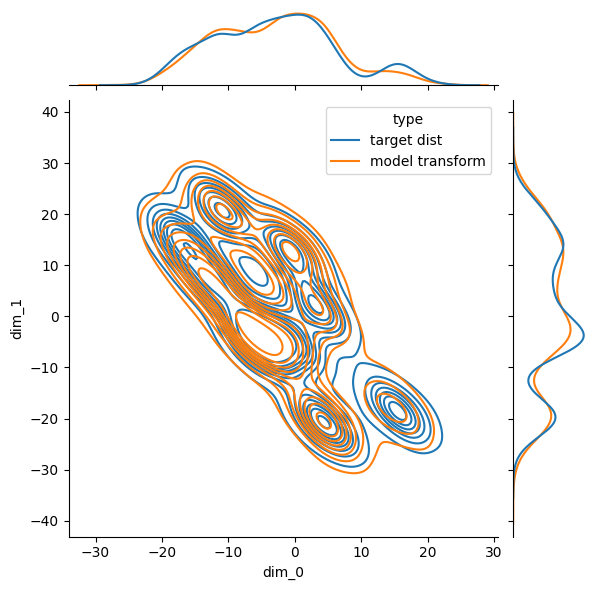

trail: 0 m step: 18 kl_test: 1.275808334350586


  2%|▏         | 100/6000 [00:31<34:52,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2730579376220703  L_n: 1.159341812133789  kld: 0.0056858062744140625 KLD1: 1.1241704225540161 KLD2: 0.6914957761764526


  3%|▎         | 200/6000 [01:03<34:15,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2955951690673828  L_n: 1.1396121978759766  kld: 0.0077991485595703125 KLD1: 1.135034203529358 KLD2: 0.6969602704048157


  5%|▌         | 300/6000 [01:36<33:39,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2310791015625  L_n: 1.1236953735351562  kld: 0.0053691864013671875 KLD1: 1.1102571487426758 KLD2: 0.6773608326911926


  7%|▋         | 400/6000 [02:08<33:07,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2442646026611328  L_n: 1.1625537872314453  kld: 0.004085540771484375 KLD1: 1.1684178113937378 KLD2: 0.6738919019699097


  8%|▊         | 500/6000 [02:40<32:31,  2.82it/s]

trail: 0 m step: 19 Loss: 1.281656265258789  L_n: 1.1398639678955078  kld: 0.0070896148681640625 KLD1: 1.1278725862503052 KLD2: 0.6938868165016174


 10%|█         | 600/6000 [03:12<31:59,  2.81it/s]

trail: 0 m step: 19 Loss: 1.2490558624267578  L_n: 1.1217594146728516  kld: 0.0063648223876953125 KLD1: 1.1341466903686523 KLD2: 0.7033601999282837


 12%|█▏        | 700/6000 [03:44<31:28,  2.81it/s]

trail: 0 m step: 19 Loss: 1.2595367431640625  L_n: 1.1016082763671875  kld: 0.00789642333984375 KLD1: 1.109265923500061 KLD2: 0.6864310503005981


 13%|█▎        | 800/6000 [04:16<30:48,  2.81it/s]

trail: 0 m step: 19 Loss: 1.2558479309082031  L_n: 1.1155052185058594  kld: 0.0070171356201171875 KLD1: 1.1152032613754272 KLD2: 0.6982568502426147


 15%|█▌        | 900/6000 [04:48<30:13,  2.81it/s]

trail: 0 m step: 19 Loss: 1.244363784790039  L_n: 1.122903823852539  kld: 0.006072998046875 KLD1: 1.092782735824585 KLD2: 0.6951730251312256


 17%|█▋        | 1000/6000 [05:21<29:36,  2.81it/s]

trail: 0 m step: 19 Loss: 1.1954116821289062  L_n: 1.0951614379882812  kld: 0.00501251220703125 KLD1: 1.144923210144043 KLD2: 0.6879194974899292


 18%|█▊        | 1100/6000 [05:53<28:55,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2381420135498047  L_n: 1.1121044158935547  kld: 0.0063018798828125 KLD1: 1.113326072692871 KLD2: 0.6813758611679077


 20%|██        | 1200/6000 [06:25<28:21,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2376041412353516  L_n: 1.1039371490478516  kld: 0.006683349609375 KLD1: 1.0977215766906738 KLD2: 0.7008262276649475


 22%|██▏       | 1300/6000 [06:57<27:51,  2.81it/s]

trail: 0 m step: 19 Loss: 1.2344036102294922  L_n: 1.1002788543701172  kld: 0.00670623779296875 KLD1: 1.1384896039962769 KLD2: 0.6961228251457214


 23%|██▎       | 1400/6000 [07:29<27:04,  2.83it/s]

trail: 0 m step: 19 Loss: 1.3031864166259766  L_n: 1.1557865142822266  kld: 0.0073699951171875 KLD1: 1.0896013975143433 KLD2: 0.6713282465934753


 25%|██▌       | 1500/6000 [08:01<26:32,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2325000762939453  L_n: 1.1191654205322266  kld: 0.0056667327880859375 KLD1: 1.0829671621322632 KLD2: 0.6635580062866211


 27%|██▋       | 1600/6000 [08:33<26:01,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2114734649658203  L_n: 1.1018009185791016  kld: 0.0054836273193359375 KLD1: 1.098123550415039 KLD2: 0.6781548857688904


 28%|██▊       | 1700/6000 [09:05<25:31,  2.81it/s]

trail: 0 m step: 19 Loss: 1.2848491668701172  L_n: 1.139547348022461  kld: 0.0072650909423828125 KLD1: 1.1545475721359253 KLD2: 0.6969801783561707


 30%|███       | 1800/6000 [09:37<24:49,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2237358093261719  L_n: 1.0947990417480469  kld: 0.00644683837890625 KLD1: 1.1328201293945312 KLD2: 0.6710913777351379


 32%|███▏      | 1900/6000 [10:09<24:14,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2393875122070312  L_n: 1.09515380859375  kld: 0.0072116851806640625 KLD1: 1.1180206537246704 KLD2: 0.7020971775054932


 33%|███▎      | 2000/6000 [10:41<23:30,  2.84it/s]

trail: 0 m step: 19 Loss: 1.1993064880371094  L_n: 1.0919227600097656  kld: 0.0053691864013671875 KLD1: 1.1252304315567017 KLD2: 0.6851670145988464


 35%|███▌      | 2100/6000 [11:13<22:53,  2.84it/s]

trail: 0 m step: 19 Loss: 1.1830863952636719  L_n: 1.0742149353027344  kld: 0.005443572998046875 KLD1: 1.0912213325500488 KLD2: 0.6935065984725952


 37%|███▋      | 2200/6000 [11:45<22:22,  2.83it/s]

trail: 0 m step: 19 Loss: 1.1882190704345703  L_n: 1.0975818634033203  kld: 0.0045318603515625 KLD1: 1.124506950378418 KLD2: 0.6828503012657166


 38%|███▊      | 2300/6000 [12:17<21:48,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2052040100097656  L_n: 1.1128501892089844  kld: 0.0046176910400390625 KLD1: 1.1316345930099487 KLD2: 0.6696323752403259


 40%|████      | 2400/6000 [12:49<21:15,  2.82it/s]

trail: 0 m step: 19 Loss: 1.1909465789794922  L_n: 1.1113338470458984  kld: 0.0039806365966796875 KLD1: 1.1136908531188965 KLD2: 0.6914911866188049


 42%|████▏     | 2500/6000 [13:21<20:37,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2080402374267578  L_n: 1.122934341430664  kld: 0.0042552947998046875 KLD1: 1.098501205444336 KLD2: 0.6878824830055237


 43%|████▎     | 2600/6000 [13:53<20:03,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2142066955566406  L_n: 1.1052589416503906  kld: 0.0054473876953125 KLD1: 1.1205575466156006 KLD2: 0.6754138469696045


 45%|████▌     | 2700/6000 [14:25<19:27,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2131080627441406  L_n: 1.1209068298339844  kld: 0.0046100616455078125 KLD1: 1.117170810699463 KLD2: 0.6838377714157104


 47%|████▋     | 2800/6000 [14:58<18:54,  2.82it/s]

trail: 0 m step: 19 Loss: 1.218709945678711  L_n: 1.1146068572998047  kld: 0.0052051544189453125 KLD1: 1.1073094606399536 KLD2: 0.6811463832855225


 48%|████▊     | 2900/6000 [15:30<18:14,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2592582702636719  L_n: 1.1431388854980469  kld: 0.00580596923828125 KLD1: 1.080558180809021 KLD2: 0.6849156618118286


 50%|█████     | 3000/6000 [16:02<17:39,  2.83it/s]

trail: 0 m step: 19 Loss: 1.1979446411132812  L_n: 1.1060867309570312  kld: 0.0045928955078125 KLD1: 1.1291807889938354 KLD2: 0.6797206401824951


 52%|█████▏    | 3100/6000 [16:33<17:00,  2.84it/s]

trail: 0 m step: 19 Loss: 1.1459808349609375  L_n: 1.0736541748046875  kld: 0.0036163330078125 KLD1: 1.095446228981018 KLD2: 0.6682436466217041


 53%|█████▎    | 3200/6000 [17:05<16:29,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2437801361083984  L_n: 1.1377315521240234  kld: 0.00530242919921875 KLD1: 1.1154366731643677 KLD2: 0.6690030694007874


 55%|█████▌    | 3300/6000 [17:37<15:55,  2.82it/s]

trail: 0 m step: 19 Loss: 1.18914794921875  L_n: 1.1144561767578125  kld: 0.003734588623046875 KLD1: 1.0881850719451904 KLD2: 0.6638488173484802


 57%|█████▋    | 3400/6000 [18:09<15:21,  2.82it/s]

trail: 0 m step: 19 Loss: 1.1902008056640625  L_n: 1.0678253173828125  kld: 0.0061187744140625 KLD1: 1.0826044082641602 KLD2: 0.6829926371574402


 58%|█████▊    | 3500/6000 [18:41<14:40,  2.84it/s]

trail: 0 m step: 19 Loss: 1.2436542510986328  L_n: 1.1103687286376953  kld: 0.006664276123046875 KLD1: 1.1015005111694336 KLD2: 0.6818943023681641


 60%|██████    | 3600/6000 [19:13<14:06,  2.84it/s]

trail: 0 m step: 19 Loss: 1.1972713470458984  L_n: 1.068258285522461  kld: 0.006450653076171875 KLD1: 1.0979413986206055 KLD2: 0.7020947933197021


 62%|██████▏   | 3700/6000 [19:45<13:33,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2092571258544922  L_n: 1.1085491180419922  kld: 0.005035400390625 KLD1: 1.0977325439453125 KLD2: 0.6860545873641968


 63%|██████▎   | 3800/6000 [20:17<12:59,  2.82it/s]

trail: 0 m step: 19 Loss: 1.210775375366211  L_n: 1.1290645599365234  kld: 0.004085540771484375 KLD1: 1.1409156322479248 KLD2: 0.6660367250442505


 65%|██████▌   | 3900/6000 [20:49<12:25,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2225379943847656  L_n: 1.0877647399902344  kld: 0.0067386627197265625 KLD1: 1.0891611576080322 KLD2: 0.6731202602386475


 67%|██████▋   | 4000/6000 [21:21<11:46,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2245845794677734  L_n: 1.1101436614990234  kld: 0.0057220458984375 KLD1: 1.0973678827285767 KLD2: 0.6754686832427979


 68%|██████▊   | 4100/6000 [21:53<11:09,  2.84it/s]

trail: 0 m step: 19 Loss: 1.2123908996582031  L_n: 1.0932197570800781  kld: 0.00595855712890625 KLD1: 1.0504295825958252 KLD2: 0.6743009090423584


 70%|███████   | 4200/6000 [22:25<10:36,  2.83it/s]

trail: 0 m step: 19 Loss: 1.1694259643554688  L_n: 1.0767288208007812  kld: 0.004634857177734375 KLD1: 1.0928641557693481 KLD2: 0.6805441379547119


 72%|███████▏  | 4300/6000 [22:57<10:01,  2.83it/s]

trail: 0 m step: 19 Loss: 1.202911376953125  L_n: 1.115631103515625  kld: 0.004364013671875 KLD1: 1.1190458536148071 KLD2: 0.6954584121704102


 73%|███████▎  | 4400/6000 [23:29<09:25,  2.83it/s]

trail: 0 m step: 19 Loss: 1.1690940856933594  L_n: 1.0865058898925781  kld: 0.0041294097900390625 KLD1: 1.1212739944458008 KLD2: 0.6758502721786499


 75%|███████▌  | 4500/6000 [24:01<08:49,  2.83it/s]

trail: 0 m step: 19 Loss: 1.2135639190673828  L_n: 1.1007251739501953  kld: 0.005641937255859375 KLD1: 1.0717642307281494 KLD2: 0.6683861017227173


 77%|███████▋  | 4600/6000 [24:33<08:15,  2.83it/s]

trail: 0 m step: 19 Loss: 1.191793441772461  L_n: 1.1089763641357422  kld: 0.0041408538818359375 KLD1: 1.1219196319580078 KLD2: 0.6985644102096558


 78%|███████▊  | 4700/6000 [25:05<07:40,  2.82it/s]

trail: 0 m step: 19 Loss: 1.163717269897461  L_n: 1.1276302337646484  kld: 0.001804351806640625 KLD1: 1.1654086112976074 KLD2: 0.6826472282409668


 80%|████████  | 4800/6000 [25:37<07:03,  2.83it/s]

trail: 0 m step: 19 Loss: 1.214071273803711  L_n: 1.115041732788086  kld: 0.00495147705078125 KLD1: 1.099189281463623 KLD2: 0.6783912777900696


 82%|████████▏ | 4900/6000 [26:09<06:29,  2.82it/s]

trail: 0 m step: 19 Loss: 1.1637916564941406  L_n: 1.0991706848144531  kld: 0.003231048583984375 KLD1: 1.1432400941848755 KLD2: 0.6708398461341858


 83%|████████▎ | 5000/6000 [26:41<05:53,  2.83it/s]

trail: 0 m step: 19 Loss: 1.210784912109375  L_n: 1.1162948608398438  kld: 0.0047245025634765625 KLD1: 1.111196517944336 KLD2: 0.6818707585334778


 85%|████████▌ | 5100/6000 [27:13<05:16,  2.84it/s]

trail: 0 m step: 19 Loss: 1.141275405883789  L_n: 1.0662403106689453  kld: 0.0037517547607421875 KLD1: 1.1038490533828735 KLD2: 0.6921889781951904


 87%|████████▋ | 5200/6000 [27:45<04:42,  2.84it/s]

trail: 0 m step: 19 Loss: 1.2171707153320312  L_n: 1.1158905029296875  kld: 0.0050640106201171875 KLD1: 1.0914992094039917 KLD2: 0.6833493113517761


 88%|████████▊ | 5300/6000 [28:17<04:06,  2.84it/s]

trail: 0 m step: 19 Loss: 1.2049827575683594  L_n: 1.1059913635253906  kld: 0.0049495697021484375 KLD1: 1.0899606943130493 KLD2: 0.6692151427268982


 90%|█████████ | 5400/6000 [28:49<03:32,  2.82it/s]

trail: 0 m step: 19 Loss: 1.179636001586914  L_n: 1.0962467193603516  kld: 0.004169464111328125 KLD1: 1.1280421018600464 KLD2: 0.677204966545105


 92%|█████████▏| 5500/6000 [29:21<02:57,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2342262268066406  L_n: 1.1129951477050781  kld: 0.006061553955078125 KLD1: 1.095423698425293 KLD2: 0.6830244064331055


 93%|█████████▎| 5600/6000 [29:53<02:22,  2.82it/s]

trail: 0 m step: 19 Loss: 1.1928672790527344  L_n: 1.1075325012207031  kld: 0.0042667388916015625 KLD1: 1.0908759832382202 KLD2: 0.675730288028717


 95%|█████████▌| 5700/6000 [30:25<01:45,  2.84it/s]

trail: 0 m step: 19 Loss: 1.1899471282958984  L_n: 1.1106014251708984  kld: 0.00396728515625 KLD1: 1.1147714853286743 KLD2: 0.6875149011611938


 97%|█████████▋| 5800/6000 [30:57<01:10,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2189197540283203  L_n: 1.1250019073486328  kld: 0.004695892333984375 KLD1: 1.0925803184509277 KLD2: 0.6735791563987732


 98%|█████████▊| 5900/6000 [31:29<00:35,  2.82it/s]

trail: 0 m step: 19 Loss: 1.2006568908691406  L_n: 1.1141395568847656  kld: 0.00432586669921875 KLD1: 1.1282806396484375 KLD2: 0.691628098487854


100%|██████████| 6000/6000 [32:01<00:00,  3.12it/s]

trail: 0 m step: 19 Loss: 1.190765380859375  L_n: 1.1076431274414062  kld: 0.0041561126708984375 KLD1: 1.0977790355682373 KLD2: 0.6847869753837585



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


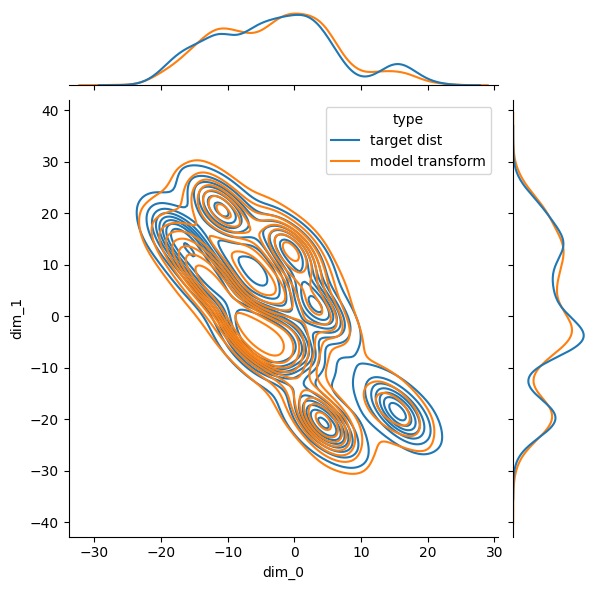

trail: 0 m step: 19 kl_test: 1.1309986114501953


  2%|▏         | 100/6000 [00:32<35:20,  2.78it/s]

trail: 0 m step: 20 Loss: 1.165374755859375  L_n: 1.0514678955078125  kld: 0.005695343017578125 KLD1: 0.9864947199821472 KLD2: 0.6281561255455017


  3%|▎         | 200/6000 [01:04<34:05,  2.84it/s]

trail: 0 m step: 20 Loss: 1.1559028625488281  L_n: 1.0129280090332031  kld: 0.00714874267578125 KLD1: 1.020956039428711 KLD2: 0.6254357695579529


  5%|▌         | 300/6000 [01:36<33:41,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1122817993164062  L_n: 1.019317626953125  kld: 0.0046482086181640625 KLD1: 1.009030818939209 KLD2: 0.6237450242042542


  7%|▋         | 400/6000 [02:08<33:07,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1155986785888672  L_n: 1.0301876068115234  kld: 0.0042705535888671875 KLD1: 1.0521950721740723 KLD2: 0.6125243902206421


  8%|▊         | 500/6000 [02:40<32:32,  2.82it/s]

trail: 0 m step: 20 Loss: 1.127645492553711  L_n: 1.0113353729248047  kld: 0.0058155059814453125 KLD1: 0.9793487787246704 KLD2: 0.6277864575386047


 10%|█         | 600/6000 [03:12<31:53,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1678428649902344  L_n: 1.0123176574707031  kld: 0.0077762603759765625 KLD1: 1.0061968564987183 KLD2: 0.6278340816497803


 12%|█▏        | 700/6000 [03:45<31:20,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1701507568359375  L_n: 1.0085983276367188  kld: 0.008077621459960938 KLD1: 0.9816620945930481 KLD2: 0.6169745326042175


 13%|█▎        | 800/6000 [04:17<30:42,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1276988983154297  L_n: 0.9884624481201172  kld: 0.006961822509765625 KLD1: 0.9795872569084167 KLD2: 0.6321365237236023


 15%|█▌        | 900/6000 [04:49<30:14,  2.81it/s]

trail: 0 m step: 20 Loss: 1.1274585723876953  L_n: 0.9971485137939453  kld: 0.0065155029296875 KLD1: 0.9971586465835571 KLD2: 0.6313718557357788


 17%|█▋        | 1000/6000 [05:21<29:32,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0592899322509766  L_n: 1.003976821899414  kld: 0.002765655517578125 KLD1: 1.015439748764038 KLD2: 0.628426194190979


 18%|█▊        | 1100/6000 [05:53<28:59,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1245193481445312  L_n: 0.9906997680664062  kld: 0.00669097900390625 KLD1: 1.0233490467071533 KLD2: 0.6108881235122681


 20%|██        | 1200/6000 [06:25<28:30,  2.81it/s]

trail: 0 m step: 20 Loss: 1.1435527801513672  L_n: 1.0056133270263672  kld: 0.00689697265625 KLD1: 1.0061262845993042 KLD2: 0.6284478306770325


 22%|██▏       | 1300/6000 [06:57<27:48,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0892410278320312  L_n: 0.974151611328125  kld: 0.0057544708251953125 KLD1: 1.0196276903152466 KLD2: 0.6429592967033386


 23%|██▎       | 1400/6000 [07:30<27:14,  2.81it/s]

trail: 0 m step: 20 Loss: 1.1339302062988281  L_n: 0.9951133728027344  kld: 0.0069408416748046875 KLD1: 0.981549084186554 KLD2: 0.6067126989364624


 25%|██▌       | 1500/6000 [08:02<26:41,  2.81it/s]

trail: 0 m step: 20 Loss: 1.1293106079101562  L_n: 0.993011474609375  kld: 0.0068149566650390625 KLD1: 0.9875296354293823 KLD2: 0.6030633449554443


 27%|██▋       | 1600/6000 [08:34<26:08,  2.81it/s]

trail: 0 m step: 20 Loss: 1.083395004272461  L_n: 0.9762401580810547  kld: 0.0053577423095703125 KLD1: 1.0044775009155273 KLD2: 0.6172581911087036


 28%|██▊       | 1700/6000 [09:06<25:25,  2.82it/s]

trail: 0 m step: 20 Loss: 1.15203857421875  L_n: 1.0373687744140625  kld: 0.005733489990234375 KLD1: 1.0101969242095947 KLD2: 0.6360621452331543


 30%|███       | 1800/6000 [09:38<24:57,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0956344604492188  L_n: 0.9739456176757812  kld: 0.006084442138671875 KLD1: 0.9917927384376526 KLD2: 0.6070723533630371


 32%|███▏      | 1900/6000 [10:11<24:28,  2.79it/s]

trail: 0 m step: 20 Loss: 1.1254730224609375  L_n: 0.9919204711914062  kld: 0.0066776275634765625 KLD1: 1.0154321193695068 KLD2: 0.6330546736717224


 33%|███▎      | 2000/6000 [10:43<23:41,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0702762603759766  L_n: 0.9899768829345703  kld: 0.0040149688720703125 KLD1: 1.0356394052505493 KLD2: 0.6252822875976562


 35%|███▌      | 2100/6000 [11:15<23:05,  2.81it/s]

trail: 0 m step: 20 Loss: 1.103689193725586  L_n: 0.9726543426513672  kld: 0.0065517425537109375 KLD1: 1.0114669799804688 KLD2: 0.6301315426826477


 37%|███▋      | 2200/6000 [11:47<22:28,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0987682342529297  L_n: 0.9917278289794922  kld: 0.005352020263671875 KLD1: 0.9986270070075989 KLD2: 0.6185339093208313


 38%|███▊      | 2300/6000 [12:19<21:48,  2.83it/s]

trail: 0 m step: 20 Loss: 1.0672931671142578  L_n: 0.9907321929931641  kld: 0.0038280487060546875 KLD1: 1.0322339534759521 KLD2: 0.6116384863853455


 40%|████      | 2400/6000 [12:52<21:19,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0755691528320312  L_n: 0.9887847900390625  kld: 0.0043392181396484375 KLD1: 1.0109333992004395 KLD2: 0.6253419518470764


 42%|████▏     | 2500/6000 [13:24<20:44,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0822677612304688  L_n: 0.9919357299804688  kld: 0.0045166015625 KLD1: 0.9812952876091003 KLD2: 0.6192802786827087


 43%|████▎     | 2600/6000 [13:56<20:11,  2.81it/s]

trail: 0 m step: 20 Loss: 1.1123790740966797  L_n: 0.9900417327880859  kld: 0.0061168670654296875 KLD1: 0.9626547694206238 KLD2: 0.606365442276001


 45%|████▌     | 2700/6000 [14:28<19:35,  2.81it/s]

trail: 0 m step: 20 Loss: 1.1089248657226562  L_n: 1.00543212890625  kld: 0.0051746368408203125 KLD1: 0.9988073706626892 KLD2: 0.6196726560592651


 47%|████▋     | 2800/6000 [15:00<18:52,  2.83it/s]

trail: 0 m step: 20 Loss: 1.0889167785644531  L_n: 0.9971351623535156  kld: 0.004589080810546875 KLD1: 1.0054593086242676 KLD2: 0.6159396767616272


 48%|████▊     | 2900/6000 [15:32<18:18,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1235466003417969  L_n: 1.0035362243652344  kld: 0.006000518798828125 KLD1: 0.9834723472595215 KLD2: 0.621654212474823


 50%|█████     | 3000/6000 [16:04<17:45,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0880584716796875  L_n: 1.022216796875  kld: 0.003292083740234375 KLD1: 1.0046323537826538 KLD2: 0.6154300570487976


 52%|█████▏    | 3100/6000 [16:37<17:14,  2.80it/s]

trail: 0 m step: 20 Loss: 1.0549983978271484  L_n: 0.9752712249755859  kld: 0.003986358642578125 KLD1: 0.9850798845291138 KLD2: 0.6067245602607727


 53%|█████▎    | 3200/6000 [17:09<16:33,  2.82it/s]

trail: 0 m step: 20 Loss: 1.105672836303711  L_n: 0.9923000335693359  kld: 0.00566864013671875 KLD1: 1.0028268098831177 KLD2: 0.6033622026443481


 55%|█████▌    | 3300/6000 [17:41<15:57,  2.82it/s]

trail: 0 m step: 20 Loss: 1.087411880493164  L_n: 1.0197391510009766  kld: 0.003383636474609375 KLD1: 0.9871194958686829 KLD2: 0.6033428311347961


 57%|█████▋    | 3400/6000 [18:13<15:22,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0849590301513672  L_n: 0.9663600921630859  kld: 0.0059299468994140625 KLD1: 0.9681323170661926 KLD2: 0.6219408512115479


 58%|█████▊    | 3500/6000 [18:45<14:47,  2.82it/s]

trail: 0 m step: 20 Loss: 1.1028022766113281  L_n: 0.9985847473144531  kld: 0.00521087646484375 KLD1: 0.9922343492507935 KLD2: 0.6210864782333374


 60%|██████    | 3600/6000 [19:17<14:07,  2.83it/s]

trail: 0 m step: 20 Loss: 1.0958538055419922  L_n: 0.9718379974365234  kld: 0.0062007904052734375 KLD1: 0.9706621766090393 KLD2: 0.6380670666694641


 62%|██████▏   | 3700/6000 [19:49<13:39,  2.81it/s]

trail: 0 m step: 20 Loss: 1.092367172241211  L_n: 0.9933376312255859  kld: 0.00495147705078125 KLD1: 0.9751111268997192 KLD2: 0.6215550899505615


 63%|██████▎   | 3800/6000 [20:21<13:01,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0688648223876953  L_n: 1.0026416778564453  kld: 0.0033111572265625 KLD1: 1.0294580459594727 KLD2: 0.6049003005027771


 65%|██████▌   | 3900/6000 [20:54<12:27,  2.81it/s]

trail: 0 m step: 20 Loss: 1.114309310913086  L_n: 0.9907512664794922  kld: 0.0061779022216796875 KLD1: 0.9732198119163513 KLD2: 0.6086968779563904


 67%|██████▋   | 4000/6000 [21:26<11:53,  2.80it/s]

trail: 0 m step: 20 Loss: 1.1148319244384766  L_n: 1.000162124633789  kld: 0.005733489990234375 KLD1: 0.9671120047569275 KLD2: 0.6169519424438477


 68%|██████▊   | 4100/6000 [21:58<11:14,  2.82it/s]

trail: 0 m step: 20 Loss: 1.106618881225586  L_n: 0.9987392425537109  kld: 0.00539398193359375 KLD1: 0.9466591477394104 KLD2: 0.6135839819908142


 70%|███████   | 4200/6000 [22:30<10:39,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0394229888916016  L_n: 0.9563770294189453  kld: 0.0041522979736328125 KLD1: 0.964693546295166 KLD2: 0.6215089559555054


 72%|███████▏  | 4300/6000 [23:02<10:04,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0916900634765625  L_n: 0.998687744140625  kld: 0.004650115966796875 KLD1: 1.0242841243743896 KLD2: 0.6329567432403564


 73%|███████▎  | 4400/6000 [23:35<09:30,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0450801849365234  L_n: 0.9708080291748047  kld: 0.0037136077880859375 KLD1: 0.9912785887718201 KLD2: 0.6144927740097046


 75%|███████▌  | 4500/6000 [24:07<08:55,  2.80it/s]

trail: 0 m step: 20 Loss: 1.1041107177734375  L_n: 1.0050430297851562  kld: 0.0049533843994140625 KLD1: 0.9980681538581848 KLD2: 0.6061118841171265


 77%|███████▋  | 4600/6000 [24:39<08:16,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0307674407958984  L_n: 0.9632472991943359  kld: 0.003376007080078125 KLD1: 1.0189827680587769 KLD2: 0.6388078927993774


 78%|███████▊  | 4700/6000 [25:11<07:42,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0196495056152344  L_n: 0.9719276428222656  kld: 0.0023860931396484375 KLD1: 1.0214327573776245 KLD2: 0.6211638450622559


 80%|████████  | 4800/6000 [25:43<07:06,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0713672637939453  L_n: 1.003732681274414  kld: 0.0033817291259765625 KLD1: 0.9874763488769531 KLD2: 0.6193006634712219


 82%|████████▏ | 4900/6000 [26:15<06:30,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0206851959228516  L_n: 0.9559497833251953  kld: 0.0032367706298828125 KLD1: 1.0164116621017456 KLD2: 0.60662442445755


 83%|████████▎ | 5000/6000 [26:47<05:54,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0810737609863281  L_n: 1.0109214782714844  kld: 0.0035076141357421875 KLD1: 1.0024771690368652 KLD2: 0.6200213432312012


 85%|████████▌ | 5100/6000 [27:19<05:20,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0214557647705078  L_n: 0.9595813751220703  kld: 0.003093719482421875 KLD1: 0.99470454454422 KLD2: 0.6298775672912598


 87%|████████▋ | 5200/6000 [27:51<04:42,  2.83it/s]

trail: 0 m step: 20 Loss: 1.0788516998291016  L_n: 0.9914188385009766  kld: 0.00437164306640625 KLD1: 0.9647421836853027 KLD2: 0.6234833002090454


 88%|████████▊ | 5300/6000 [28:23<04:07,  2.83it/s]

trail: 0 m step: 20 Loss: 1.1047592163085938  L_n: 1.01080322265625  kld: 0.0046977996826171875 KLD1: 0.9833859205245972 KLD2: 0.609845757484436


 90%|█████████ | 5400/6000 [28:55<03:31,  2.84it/s]

trail: 0 m step: 20 Loss: 1.1069812774658203  L_n: 1.011575698852539  kld: 0.0047702789306640625 KLD1: 1.0081393718719482 KLD2: 0.6160503625869751


 92%|█████████▏| 5500/6000 [29:28<02:58,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0610904693603516  L_n: 0.9788455963134766  kld: 0.00411224365234375 KLD1: 0.9817079901695251 KLD2: 0.6194328665733337


 93%|█████████▎| 5600/6000 [30:00<02:22,  2.81it/s]

trail: 0 m step: 20 Loss: 1.0832862854003906  L_n: 1.0190849304199219  kld: 0.0032100677490234375 KLD1: 0.9885231256484985 KLD2: 0.6131330132484436


 95%|█████████▌| 5700/6000 [30:32<01:46,  2.82it/s]

trail: 0 m step: 20 Loss: 1.0325450897216797  L_n: 0.9849376678466797  kld: 0.00238037109375 KLD1: 1.0108201503753662 KLD2: 0.623652994632721


 97%|█████████▋| 5800/6000 [31:04<01:10,  2.84it/s]

trail: 0 m step: 20 Loss: 1.0492477416992188  L_n: 0.9884033203125  kld: 0.0030422210693359375 KLD1: 0.9774224162101746 KLD2: 0.6112955808639526


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.82it/s]

trail: 0 m step: 20 Loss: 1.088653564453125  L_n: 1.0152587890625  kld: 0.00366973876953125 KLD1: 1.0313602685928345 KLD2: 0.6306555271148682


100%|██████████| 6000/6000 [32:08<00:00,  3.11it/s]

trail: 0 m step: 20 Loss: 1.065521240234375  L_n: 0.9944534301757812  kld: 0.0035533905029296875 KLD1: 0.9959564208984375 KLD2: 0.6264835000038147



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


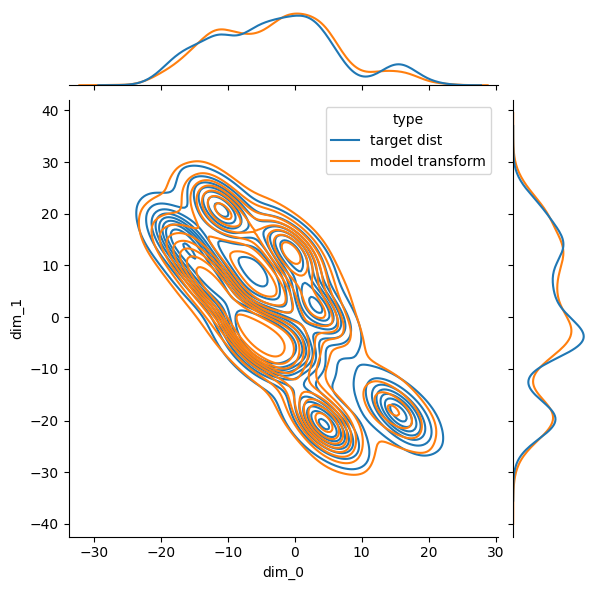

trail: 0 m step: 20 kl_test: 0.9999179840087891


  2%|▏         | 100/6000 [00:32<35:09,  2.80it/s]

trail: 0 m step: 21 Loss: 1.0274696350097656  L_n: 0.9314918518066406  kld: 0.00479888916015625 KLD1: 0.9130405783653259 KLD2: 0.5788220763206482


  3%|▎         | 200/6000 [01:04<33:59,  2.84it/s]

trail: 0 m step: 21 Loss: 1.040924072265625  L_n: 0.9127120971679688  kld: 0.0064105987548828125 KLD1: 0.9361213445663452 KLD2: 0.573676586151123


  5%|▌         | 300/6000 [01:36<33:48,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9905624389648438  L_n: 0.9046554565429688  kld: 0.00429534912109375 KLD1: 0.9011833667755127 KLD2: 0.5658961534500122


  7%|▋         | 400/6000 [02:08<33:16,  2.80it/s]

trail: 0 m step: 21 Loss: 1.0167865753173828  L_n: 0.9282093048095703  kld: 0.004428863525390625 KLD1: 0.9545493721961975 KLD2: 0.5616405010223389


  8%|▊         | 500/6000 [02:40<32:28,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0381717681884766  L_n: 0.9148426055908203  kld: 0.0061664581298828125 KLD1: 0.8973196744918823 KLD2: 0.5755364298820496


 10%|█         | 600/6000 [03:12<31:53,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0588436126708984  L_n: 0.9211330413818359  kld: 0.006885528564453125 KLD1: 0.9129638671875 KLD2: 0.5819404125213623


 12%|█▏        | 700/6000 [03:44<31:20,  2.82it/s]

trail: 0 m step: 21 Loss: 1.049997329711914  L_n: 0.9078998565673828  kld: 0.0071048736572265625 KLD1: 0.8926367163658142 KLD2: 0.5657137036323547


 13%|█▎        | 800/6000 [04:16<30:45,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0325202941894531  L_n: 0.8953819274902344  kld: 0.0068569183349609375 KLD1: 0.8958509564399719 KLD2: 0.5832793712615967


 15%|█▌        | 900/6000 [04:48<30:07,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0308303833007812  L_n: 0.8878936767578125  kld: 0.0071468353271484375 KLD1: 0.873114824295044 KLD2: 0.5741140246391296


 17%|█▋        | 1000/6000 [05:21<29:28,  2.83it/s]

trail: 0 m step: 21 Loss: 0.9795055389404297  L_n: 0.8833370208740234  kld: 0.0048084259033203125 KLD1: 0.9124985337257385 KLD2: 0.5736347436904907


 18%|█▊        | 1100/6000 [05:53<28:58,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0546207427978516  L_n: 0.8932590484619141  kld: 0.008068084716796875 KLD1: 0.9185447096824646 KLD2: 0.5600526332855225


 20%|██        | 1200/6000 [06:25<28:20,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0330543518066406  L_n: 0.9135398864746094  kld: 0.0059757232666015625 KLD1: 0.9186949133872986 KLD2: 0.5789682269096375


 22%|██▏       | 1300/6000 [06:57<27:45,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0404376983642578  L_n: 0.9008960723876953  kld: 0.006977081298828125 KLD1: 0.9362881779670715 KLD2: 0.5852308869361877


 23%|██▎       | 1400/6000 [07:29<27:12,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0808353424072266  L_n: 0.9194355010986328  kld: 0.008069992065429688 KLD1: 0.896743893623352 KLD2: 0.5604064464569092


 25%|██▌       | 1500/6000 [08:01<26:36,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0488777160644531  L_n: 0.9309654235839844  kld: 0.0058956146240234375 KLD1: 0.9066775441169739 KLD2: 0.5561771392822266


 27%|██▋       | 1600/6000 [08:33<26:02,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9914779663085938  L_n: 0.91400146484375  kld: 0.0038738250732421875 KLD1: 0.9050028324127197 KLD2: 0.5683872699737549


 28%|██▊       | 1700/6000 [09:05<25:22,  2.83it/s]

trail: 0 m step: 21 Loss: 1.0678234100341797  L_n: 0.9443798065185547  kld: 0.00617218017578125 KLD1: 0.9260130524635315 KLD2: 0.5837385654449463


 30%|███       | 1800/6000 [09:37<24:48,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0401382446289062  L_n: 0.8921661376953125  kld: 0.0073986053466796875 KLD1: 0.9273386597633362 KLD2: 0.5574848055839539


 32%|███▏      | 1900/6000 [10:09<24:05,  2.84it/s]

trail: 0 m step: 21 Loss: 1.0372543334960938  L_n: 0.8862686157226562  kld: 0.007549285888671875 KLD1: 0.875922441482544 KLD2: 0.5856874585151672


 33%|███▎      | 2000/6000 [10:41<23:43,  2.81it/s]

trail: 0 m step: 21 Loss: 1.0079803466796875  L_n: 0.895599365234375  kld: 0.005619049072265625 KLD1: 0.9593479037284851 KLD2: 0.5780881643295288


 35%|███▌      | 2100/6000 [11:14<23:02,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9792442321777344  L_n: 0.8856315612792969  kld: 0.004680633544921875 KLD1: 0.8868522047996521 KLD2: 0.58170086145401


 37%|███▋      | 2200/6000 [11:46<22:18,  2.84it/s]

trail: 0 m step: 21 Loss: 0.9647903442382812  L_n: 0.8711013793945312  kld: 0.0046844482421875 KLD1: 0.8822173476219177 KLD2: 0.5710011124610901


 38%|███▊      | 2300/6000 [12:18<21:51,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9626350402832031  L_n: 0.8718452453613281  kld: 0.00453948974609375 KLD1: 0.9145191311836243 KLD2: 0.5612472295761108


 40%|████      | 2400/6000 [12:50<21:12,  2.83it/s]

trail: 0 m step: 21 Loss: 1.0086650848388672  L_n: 0.9202404022216797  kld: 0.004421234130859375 KLD1: 0.9328441023826599 KLD2: 0.5808932781219482


 42%|████▏     | 2500/6000 [13:22<20:44,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9905929565429688  L_n: 0.8966751098632812  kld: 0.004695892333984375 KLD1: 0.8987921476364136 KLD2: 0.574017345905304


 43%|████▎     | 2600/6000 [13:54<20:05,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0307331085205078  L_n: 0.9121341705322266  kld: 0.0059299468994140625 KLD1: 0.9082751870155334 KLD2: 0.5616399049758911


 45%|████▌     | 2700/6000 [14:26<19:34,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9881057739257812  L_n: 0.9138717651367188  kld: 0.003711700439453125 KLD1: 0.8909757733345032 KLD2: 0.5685479640960693


 47%|████▋     | 2800/6000 [14:58<18:55,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9930210113525391  L_n: 0.9063892364501953  kld: 0.0043315887451171875 KLD1: 0.9065084457397461 KLD2: 0.5690867304801941


 48%|████▊     | 2900/6000 [15:30<18:18,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0211963653564453  L_n: 0.9318943023681641  kld: 0.0044651031494140625 KLD1: 0.8867271542549133 KLD2: 0.5747672915458679


 50%|█████     | 3000/6000 [16:03<17:39,  2.83it/s]

trail: 0 m step: 21 Loss: 0.9856033325195312  L_n: 0.9088134765625  kld: 0.0038394927978515625 KLD1: 0.930460512638092 KLD2: 0.5650688409805298


 52%|█████▏    | 3100/6000 [16:35<17:11,  2.81it/s]

trail: 0 m step: 21 Loss: 0.982666015625  L_n: 0.8896255493164062  kld: 0.0046520233154296875 KLD1: 0.9032263159751892 KLD2: 0.561185896396637


 53%|█████▎    | 3200/6000 [17:07<16:30,  2.83it/s]

trail: 0 m step: 21 Loss: 1.0295162200927734  L_n: 0.9236583709716797  kld: 0.0052928924560546875 KLD1: 0.9068220257759094 KLD2: 0.5523634552955627


 55%|█████▌    | 3300/6000 [17:39<15:56,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9982833862304688  L_n: 0.9340057373046875  kld: 0.0032138824462890625 KLD1: 0.8891448974609375 KLD2: 0.5543578267097473


 57%|█████▋    | 3400/6000 [18:11<15:21,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9865837097167969  L_n: 0.8755378723144531  kld: 0.0055522918701171875 KLD1: 0.8814179301261902 KLD2: 0.5733546018600464


 58%|█████▊    | 3500/6000 [18:43<14:46,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0178260803222656  L_n: 0.9142570495605469  kld: 0.0051784515380859375 KLD1: 0.8797173500061035 KLD2: 0.5695445537567139


 60%|██████    | 3600/6000 [19:15<14:09,  2.83it/s]

trail: 0 m step: 21 Loss: 1.0168132781982422  L_n: 0.8845577239990234  kld: 0.0066127777099609375 KLD1: 0.8845484256744385 KLD2: 0.5854936242103577


 62%|██████▏   | 3700/6000 [19:47<13:34,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0229682922363281  L_n: 0.9269523620605469  kld: 0.0048007965087890625 KLD1: 0.915194034576416 KLD2: 0.5764049887657166


 63%|██████▎   | 3800/6000 [20:19<13:03,  2.81it/s]

trail: 0 m step: 21 Loss: 1.0194740295410156  L_n: 0.9434471130371094  kld: 0.0038013458251953125 KLD1: 0.9201782941818237 KLD2: 0.5580940246582031


 65%|██████▌   | 3900/6000 [20:51<12:24,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0298137664794922  L_n: 0.9026317596435547  kld: 0.006359100341796875 KLD1: 0.8883562088012695 KLD2: 0.5606347322463989


 67%|██████▋   | 4000/6000 [21:23<11:47,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0066051483154297  L_n: 0.8896846771240234  kld: 0.0058460235595703125 KLD1: 0.8709128499031067 KLD2: 0.5674411058425903


 68%|██████▊   | 4100/6000 [21:56<11:08,  2.84it/s]

trail: 0 m step: 21 Loss: 0.9934635162353516  L_n: 0.9032840728759766  kld: 0.00450897216796875 KLD1: 0.882063090801239 KLD2: 0.5650557279586792


 70%|███████   | 4200/6000 [22:28<10:35,  2.83it/s]

trail: 0 m step: 21 Loss: 0.9526042938232422  L_n: 0.8536510467529297  kld: 0.004947662353515625 KLD1: 0.8770908713340759 KLD2: 0.5717906355857849


 72%|███████▏  | 4300/6000 [23:00<10:02,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9990692138671875  L_n: 0.9318161010742188  kld: 0.0033626556396484375 KLD1: 0.9338734149932861 KLD2: 0.5872035026550293


 73%|███████▎  | 4400/6000 [23:32<09:29,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9657325744628906  L_n: 0.8867683410644531  kld: 0.003948211669921875 KLD1: 0.900932788848877 KLD2: 0.5692006945610046


 75%|███████▌  | 4500/6000 [24:04<08:50,  2.83it/s]

trail: 0 m step: 21 Loss: 1.0210437774658203  L_n: 0.8961505889892578  kld: 0.006244659423828125 KLD1: 0.8948779106140137 KLD2: 0.5590661764144897


 77%|███████▋  | 4600/6000 [24:36<08:17,  2.81it/s]

trail: 0 m step: 21 Loss: 0.93603515625  L_n: 0.8593215942382812  kld: 0.0038356781005859375 KLD1: 0.9142021536827087 KLD2: 0.5877712368965149


 78%|███████▊  | 4700/6000 [25:08<07:41,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9295101165771484  L_n: 0.9015483856201172  kld: 0.0013980865478515625 KLD1: 0.9378904104232788 KLD2: 0.5717827081680298


 80%|████████  | 4800/6000 [25:41<07:07,  2.80it/s]

trail: 0 m step: 21 Loss: 0.9850845336914062  L_n: 0.9196624755859375  kld: 0.0032711029052734375 KLD1: 0.926918625831604 KLD2: 0.5690318942070007


 82%|████████▏ | 4900/6000 [26:13<06:30,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9293403625488281  L_n: 0.8786811828613281  kld: 0.002532958984375 KLD1: 0.918439507484436 KLD2: 0.5577725768089294


 83%|████████▎ | 5000/6000 [26:45<05:55,  2.82it/s]

trail: 0 m step: 21 Loss: 1.0019207000732422  L_n: 0.9115123748779297  kld: 0.004520416259765625 KLD1: 0.9093244075775146 KLD2: 0.5700141191482544


 85%|████████▌ | 5100/6000 [27:17<05:20,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9411525726318359  L_n: 0.8809566497802734  kld: 0.003009796142578125 KLD1: 0.9120718240737915 KLD2: 0.5797852277755737


 87%|████████▋ | 5200/6000 [27:49<04:45,  2.81it/s]

trail: 0 m step: 21 Loss: 1.0036792755126953  L_n: 0.9123172760009766  kld: 0.0045680999755859375 KLD1: 0.8860127925872803 KLD2: 0.5715551376342773


 88%|████████▊ | 5300/6000 [28:22<04:08,  2.81it/s]

trail: 0 m step: 21 Loss: 1.0166034698486328  L_n: 0.9231433868408203  kld: 0.004673004150390625 KLD1: 0.8920069932937622 KLD2: 0.5592038631439209


 90%|█████████ | 5400/6000 [28:54<03:32,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9783267974853516  L_n: 0.8886051177978516  kld: 0.004486083984375 KLD1: 0.8892470598220825 KLD2: 0.5660102963447571


 92%|█████████▏| 5500/6000 [29:26<02:57,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9942646026611328  L_n: 0.9041996002197266  kld: 0.0045032501220703125 KLD1: 0.8915983438491821 KLD2: 0.568845808506012


 93%|█████████▎| 5600/6000 [29:58<02:21,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9998149871826172  L_n: 0.9294338226318359  kld: 0.0035190582275390625 KLD1: 0.902405858039856 KLD2: 0.5598233342170715


 95%|█████████▌| 5700/6000 [30:30<01:46,  2.81it/s]

trail: 0 m step: 21 Loss: 0.9529438018798828  L_n: 0.8872928619384766  kld: 0.0032825469970703125 KLD1: 0.9111728072166443 KLD2: 0.5718374252319336


 97%|█████████▋| 5800/6000 [31:02<01:10,  2.82it/s]

trail: 0 m step: 21 Loss: 0.9827613830566406  L_n: 0.8982658386230469  kld: 0.0042247772216796875 KLD1: 0.8824957013130188 KLD2: 0.5590674877166748


 98%|█████████▊| 5900/6000 [31:34<00:35,  2.82it/s]

trail: 0 m step: 21 Loss: 1.005533218383789  L_n: 0.9018115997314453  kld: 0.0051860809326171875 KLD1: 0.887112557888031 KLD2: 0.578349769115448


100%|██████████| 6000/6000 [32:06<00:00,  3.11it/s]

trail: 0 m step: 21 Loss: 0.9874324798583984  L_n: 0.9081630706787109  kld: 0.003963470458984375 KLD1: 0.8853438496589661 KLD2: 0.5714570879936218



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


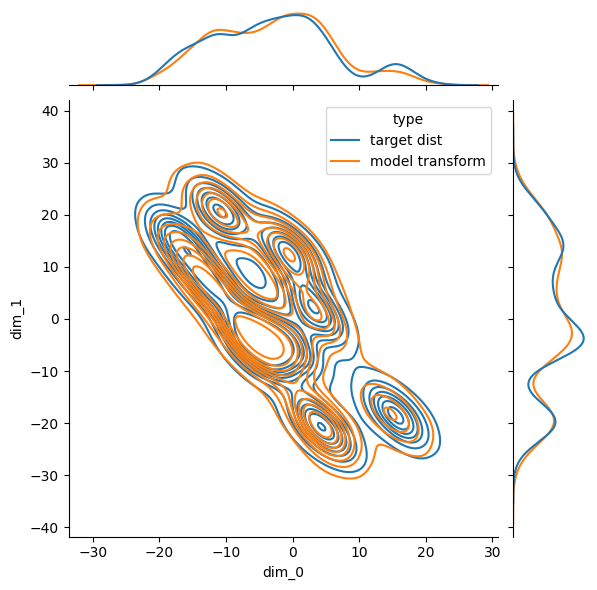

trail: 0 m step: 21 kl_test: 0.9381217956542969


  2%|▏         | 100/6000 [00:32<34:49,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9519824981689453  L_n: 0.8607730865478516  kld: 0.0045604705810546875 KLD1: 0.8285350203514099 KLD2: 0.5274979472160339


  3%|▎         | 200/6000 [01:04<34:03,  2.84it/s]

trail: 0 m step: 22 Loss: 0.9594402313232422  L_n: 0.8451519012451172  kld: 0.00571441650390625 KLD1: 0.8391040563583374 KLD2: 0.5256743431091309


  5%|▌         | 300/6000 [01:36<33:39,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9108810424804688  L_n: 0.8367233276367188  kld: 0.0037078857421875 KLD1: 0.823442280292511 KLD2: 0.5200480818748474


  7%|▋         | 400/6000 [02:08<33:13,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9298095703125  L_n: 0.8450469970703125  kld: 0.004238128662109375 KLD1: 0.863755464553833 KLD2: 0.516622006893158


  8%|▊         | 500/6000 [02:40<32:27,  2.82it/s]

trail: 0 m step: 22 Loss: 1.0089168548583984  L_n: 0.8443889617919922  kld: 0.008226394653320312 KLD1: 0.8291929364204407 KLD2: 0.5377808809280396


 10%|█         | 600/6000 [03:12<31:53,  2.82it/s]

trail: 0 m step: 22 Loss: 0.973388671875  L_n: 0.8504791259765625  kld: 0.006145477294921875 KLD1: 0.8263232111930847 KLD2: 0.5306381583213806


 12%|█▏        | 700/6000 [03:44<31:16,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9750404357910156  L_n: 0.8226814270019531  kld: 0.007617950439453125 KLD1: 0.8149617314338684 KLD2: 0.5252315402030945


 13%|█▎        | 800/6000 [04:16<30:49,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9624042510986328  L_n: 0.8417453765869141  kld: 0.0060329437255859375 KLD1: 0.806092381477356 KLD2: 0.5414000153541565


 15%|█▌        | 900/6000 [04:48<30:06,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9110774993896484  L_n: 0.8136119842529297  kld: 0.0048732757568359375 KLD1: 0.8096961975097656 KLD2: 0.5364840626716614


 17%|█▋        | 1000/6000 [05:20<29:33,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8883838653564453  L_n: 0.8094577789306641  kld: 0.0039463043212890625 KLD1: 0.8167840838432312 KLD2: 0.5299282073974609


 18%|█▊        | 1100/6000 [05:52<28:50,  2.83it/s]

trail: 0 m step: 22 Loss: 0.9923629760742188  L_n: 0.8216171264648438  kld: 0.00853729248046875 KLD1: 0.8753376603126526 KLD2: 0.5146444439888


 20%|██        | 1200/6000 [06:24<28:23,  2.82it/s]

trail: 0 m step: 22 Loss: 0.93994140625  L_n: 0.8562088012695312  kld: 0.0041866302490234375 KLD1: 0.8255276083946228 KLD2: 0.530036985874176


 22%|██▏       | 1300/6000 [06:57<27:45,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8802776336669922  L_n: 0.7984523773193359  kld: 0.0040912628173828125 KLD1: 0.8472540974617004 KLD2: 0.5413771271705627


 23%|██▎       | 1400/6000 [07:29<27:11,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9464435577392578  L_n: 0.8238010406494141  kld: 0.0061321258544921875 KLD1: 0.8020108938217163 KLD2: 0.5112675428390503


 25%|██▌       | 1500/6000 [08:01<26:46,  2.80it/s]

trail: 0 m step: 22 Loss: 0.9469242095947266  L_n: 0.8078022003173828  kld: 0.0069561004638671875 KLD1: 0.8127055764198303 KLD2: 0.5004687905311584


 27%|██▋       | 1600/6000 [08:33<25:55,  2.83it/s]

trail: 0 m step: 22 Loss: 0.911285400390625  L_n: 0.8267898559570312  kld: 0.0042247772216796875 KLD1: 0.8244196772575378 KLD2: 0.5234537124633789


 28%|██▊       | 1700/6000 [09:05<25:28,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9851131439208984  L_n: 0.8637294769287109  kld: 0.006069183349609375 KLD1: 0.8340885639190674 KLD2: 0.53633052110672


 30%|███       | 1800/6000 [09:37<24:53,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9634437561035156  L_n: 0.8295860290527344  kld: 0.0066928863525390625 KLD1: 0.824543833732605 KLD2: 0.5087384581565857


 32%|███▏      | 1900/6000 [10:09<24:12,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8862400054931641  L_n: 0.7905673980712891  kld: 0.00478363037109375 KLD1: 0.8010000586509705 KLD2: 0.536409854888916


 33%|███▎      | 2000/6000 [10:41<23:32,  2.83it/s]

trail: 0 m step: 22 Loss: 0.9337100982666016  L_n: 0.8325824737548828  kld: 0.0050563812255859375 KLD1: 0.8416394591331482 KLD2: 0.5339166522026062


 35%|███▌      | 2100/6000 [11:14<23:06,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8983745574951172  L_n: 0.7938137054443359  kld: 0.0052280426025390625 KLD1: 0.8079362511634827 KLD2: 0.5316640138626099


 37%|███▋      | 2200/6000 [11:46<22:31,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8837642669677734  L_n: 0.8084621429443359  kld: 0.003765106201171875 KLD1: 0.7944984436035156 KLD2: 0.5203220844268799


 38%|███▊      | 2300/6000 [12:18<21:52,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9026889801025391  L_n: 0.8062534332275391  kld: 0.00482177734375 KLD1: 0.8274890184402466 KLD2: 0.5106050372123718


 40%|████      | 2400/6000 [12:50<21:11,  2.83it/s]

trail: 0 m step: 22 Loss: 0.8716201782226562  L_n: 0.8174514770507812  kld: 0.00270843505859375 KLD1: 0.8290833830833435 KLD2: 0.5297836065292358


 42%|████▏     | 2500/6000 [13:22<20:42,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9196548461914062  L_n: 0.834014892578125  kld: 0.0042819976806640625 KLD1: 0.8211668729782104 KLD2: 0.5251324772834778


 43%|████▎     | 2600/6000 [13:54<20:08,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9223957061767578  L_n: 0.8192081451416016  kld: 0.0051593780517578125 KLD1: 0.8219118118286133 KLD2: 0.5132129788398743


 45%|████▌     | 2700/6000 [14:26<19:33,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9075927734375  L_n: 0.845184326171875  kld: 0.00312042236328125 KLD1: 0.8165179491043091 KLD2: 0.5291045904159546


 47%|████▋     | 2800/6000 [14:58<18:56,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8903999328613281  L_n: 0.8053703308105469  kld: 0.0042514801025390625 KLD1: 0.8284423351287842 KLD2: 0.517233669757843


 48%|████▊     | 2900/6000 [15:31<18:16,  2.83it/s]

trail: 0 m step: 22 Loss: 0.9044075012207031  L_n: 0.8331489562988281  kld: 0.00356292724609375 KLD1: 0.8054832816123962 KLD2: 0.5231471657752991


 50%|█████     | 3000/6000 [16:03<17:43,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8980159759521484  L_n: 0.8406429290771484  kld: 0.00286865234375 KLD1: 0.8519290089607239 KLD2: 0.5188277959823608


 52%|█████▏    | 3100/6000 [16:35<17:09,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8693027496337891  L_n: 0.7924365997314453  kld: 0.0038433074951171875 KLD1: 0.8020897507667542 KLD2: 0.5165215134620667


 53%|█████▎    | 3200/6000 [17:07<16:34,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9239940643310547  L_n: 0.8268718719482422  kld: 0.004856109619140625 KLD1: 0.8351970314979553 KLD2: 0.5086064338684082


 55%|█████▌    | 3300/6000 [17:39<15:55,  2.83it/s]

trail: 0 m step: 22 Loss: 0.9028491973876953  L_n: 0.8472309112548828  kld: 0.002780914306640625 KLD1: 0.8317241072654724 KLD2: 0.5109136700630188


 57%|█████▋    | 3400/6000 [18:11<15:23,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8700237274169922  L_n: 0.7723293304443359  kld: 0.0048847198486328125 KLD1: 0.8146777749061584 KLD2: 0.5262222290039062


 58%|█████▊    | 3500/6000 [18:43<14:48,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9331035614013672  L_n: 0.8333492279052734  kld: 0.0049877166748046875 KLD1: 0.7892060279846191 KLD2: 0.519961416721344


 60%|██████    | 3600/6000 [19:15<14:14,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9048957824707031  L_n: 0.7961387634277344  kld: 0.0054378509521484375 KLD1: 0.7811477184295654 KLD2: 0.5406768321990967


 62%|██████▏   | 3700/6000 [19:48<13:35,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9235038757324219  L_n: 0.8445777893066406  kld: 0.0039463043212890625 KLD1: 0.8138735890388489 KLD2: 0.5276832580566406


 63%|██████▎   | 3800/6000 [20:20<12:56,  2.83it/s]

trail: 0 m step: 22 Loss: 0.9243621826171875  L_n: 0.8606185913085938  kld: 0.0031871795654296875 KLD1: 0.8544903993606567 KLD2: 0.5069637894630432


 65%|██████▌   | 3900/6000 [20:52<12:26,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9373836517333984  L_n: 0.8104305267333984  kld: 0.00634765625 KLD1: 0.7955077886581421 KLD2: 0.5108387470245361


 67%|██████▋   | 4000/6000 [21:24<11:51,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9242897033691406  L_n: 0.8347969055175781  kld: 0.004474639892578125 KLD1: 0.7795257568359375 KLD2: 0.5191935896873474


 68%|██████▊   | 4100/6000 [21:56<11:15,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9042415618896484  L_n: 0.8204326629638672  kld: 0.0041904449462890625 KLD1: 0.7797696590423584 KLD2: 0.516712486743927


 70%|███████   | 4200/6000 [22:28<10:38,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8642177581787109  L_n: 0.7729320526123047  kld: 0.0045642852783203125 KLD1: 0.8131884336471558 KLD2: 0.5222073197364807


 72%|███████▏  | 4300/6000 [23:00<10:03,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9089794158935547  L_n: 0.8395519256591797  kld: 0.00347137451171875 KLD1: 0.8158526420593262 KLD2: 0.5337872505187988


 73%|███████▎  | 4400/6000 [23:32<09:28,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8557720184326172  L_n: 0.7993526458740234  kld: 0.0028209686279296875 KLD1: 0.8226642608642578 KLD2: 0.5190984010696411


 75%|███████▌  | 4500/6000 [24:05<08:52,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9183464050292969  L_n: 0.8356056213378906  kld: 0.0041370391845703125 KLD1: 0.8107253313064575 KLD2: 0.5123850703239441


 77%|███████▋  | 4600/6000 [24:37<08:15,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8514804840087891  L_n: 0.7962055206298828  kld: 0.0027637481689453125 KLD1: 0.8142716884613037 KLD2: 0.5374646186828613


 78%|███████▊  | 4700/6000 [25:09<07:40,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8445415496826172  L_n: 0.8177623748779297  kld: 0.001338958740234375 KLD1: 0.8632774949073792 KLD2: 0.522024393081665


 80%|████████  | 4800/6000 [25:41<07:07,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8794574737548828  L_n: 0.8214359283447266  kld: 0.0029010772705078125 KLD1: 0.8232419490814209 KLD2: 0.5216349363327026


 82%|████████▏ | 4900/6000 [26:13<06:31,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8584442138671875  L_n: 0.7982101440429688  kld: 0.0030117034912109375 KLD1: 0.8263394236564636 KLD2: 0.512866199016571


 83%|████████▎ | 5000/6000 [26:45<05:55,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9175624847412109  L_n: 0.8533611297607422  kld: 0.0032100677490234375 KLD1: 0.8289708495140076 KLD2: 0.525234580039978


 85%|████████▌ | 5100/6000 [27:17<05:20,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8599987030029297  L_n: 0.8045330047607422  kld: 0.002773284912109375 KLD1: 0.8259328007698059 KLD2: 0.5359956622123718


 87%|████████▋ | 5200/6000 [27:49<04:43,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9094867706298828  L_n: 0.8221302032470703  kld: 0.004367828369140625 KLD1: 0.7925145030021667 KLD2: 0.5260029435157776


 88%|████████▊ | 5300/6000 [28:22<04:08,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9045734405517578  L_n: 0.8413257598876953  kld: 0.003162384033203125 KLD1: 0.8056055307388306 KLD2: 0.5117633938789368


 90%|█████████ | 5400/6000 [28:54<03:33,  2.81it/s]

trail: 0 m step: 22 Loss: 0.9189453125  L_n: 0.8373489379882812  kld: 0.0040798187255859375 KLD1: 0.8258640170097351 KLD2: 0.5181928277015686


 92%|█████████▏| 5500/6000 [29:26<02:57,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8809928894042969  L_n: 0.8166770935058594  kld: 0.003215789794921875 KLD1: 0.8084545731544495 KLD2: 0.5213475227355957


 93%|█████████▎| 5600/6000 [29:58<02:22,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8942050933837891  L_n: 0.8306140899658203  kld: 0.0031795501708984375 KLD1: 0.8140328526496887 KLD2: 0.5126097202301025


 95%|█████████▌| 5700/6000 [30:30<01:46,  2.81it/s]

trail: 0 m step: 22 Loss: 0.8416328430175781  L_n: 0.7986412048339844  kld: 0.0021495819091796875 KLD1: 0.8177184462547302 KLD2: 0.5234926342964172


 97%|█████████▋| 5800/6000 [31:02<01:10,  2.82it/s]

trail: 0 m step: 22 Loss: 0.8781471252441406  L_n: 0.8089103698730469  kld: 0.0034618377685546875 KLD1: 0.8272126913070679 KLD2: 0.5096911787986755


 98%|█████████▊| 5900/6000 [31:34<00:35,  2.82it/s]

trail: 0 m step: 22 Loss: 0.9114875793457031  L_n: 0.8342399597167969  kld: 0.0038623809814453125 KLD1: 0.8161942958831787 KLD2: 0.5304456949234009


100%|██████████| 6000/6000 [32:06<00:00,  3.11it/s]

trail: 0 m step: 22 Loss: 0.8664360046386719  L_n: 0.8156242370605469  kld: 0.00254058837890625 KLD1: 0.8189741373062134 KLD2: 0.5234249830245972



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


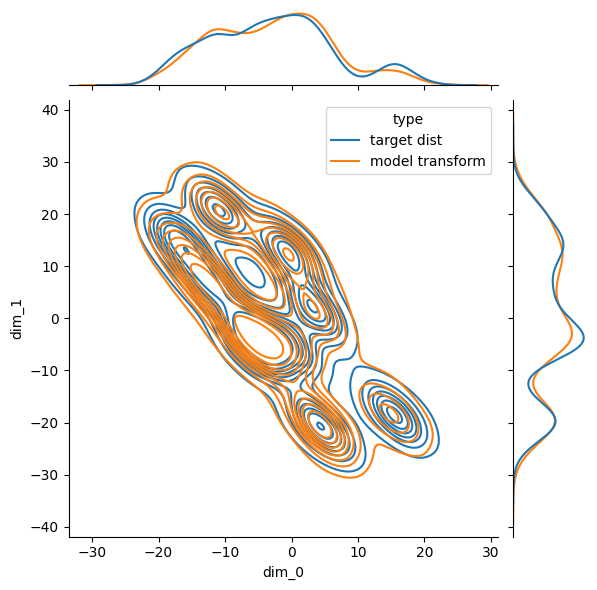

trail: 0 m step: 22 kl_test: 0.8458824157714844


  2%|▏         | 100/6000 [00:32<35:22,  2.78it/s]

trail: 0 m step: 23 Loss: 0.9184284210205078  L_n: 0.7949848175048828  kld: 0.00617218017578125 KLD1: 0.7532681822776794 KLD2: 0.48280563950538635


  3%|▎         | 200/6000 [01:04<34:12,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8957843780517578  L_n: 0.7571964263916016  kld: 0.0069293975830078125 KLD1: 0.7804608941078186 KLD2: 0.48364168405532837


  5%|▌         | 300/6000 [01:36<33:41,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8370227813720703  L_n: 0.7631320953369141  kld: 0.0036945343017578125 KLD1: 0.7603738903999329 KLD2: 0.4754146337509155


  7%|▋         | 400/6000 [02:08<33:09,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8847389221191406  L_n: 0.7845268249511719  kld: 0.0050106048583984375 KLD1: 0.7940990328788757 KLD2: 0.47080641984939575


  8%|▊         | 500/6000 [02:40<32:24,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8809185028076172  L_n: 0.7493877410888672  kld: 0.0065765380859375 KLD1: 0.7486340999603271 KLD2: 0.486129492521286


 10%|█         | 600/6000 [03:12<31:52,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8813152313232422  L_n: 0.7588253021240234  kld: 0.0061244964599609375 KLD1: 0.7594839930534363 KLD2: 0.48662450909614563


 12%|█▏        | 700/6000 [03:44<31:22,  2.82it/s]

trail: 0 m step: 23 Loss: 0.87451171875  L_n: 0.7364578247070312  kld: 0.0069026947021484375 KLD1: 0.7599167823791504 KLD2: 0.4808316230773926


 13%|█▎        | 800/6000 [04:16<30:35,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8585643768310547  L_n: 0.7581233978271484  kld: 0.0050220489501953125 KLD1: 0.7429006695747375 KLD2: 0.4988385736942291


 15%|█▌        | 900/6000 [04:49<30:15,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8894844055175781  L_n: 0.7549018859863281  kld: 0.0067291259765625 KLD1: 0.7470192909240723 KLD2: 0.4944876730442047


 17%|█▋        | 1000/6000 [05:21<29:35,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8083629608154297  L_n: 0.7210826873779297  kld: 0.004364013671875 KLD1: 0.7755433320999146 KLD2: 0.4848915934562683


 18%|█▊        | 1100/6000 [05:53<29:00,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8331890106201172  L_n: 0.7323284149169922  kld: 0.00504302978515625 KLD1: 0.7583749294281006 KLD2: 0.47238689661026


 20%|██        | 1200/6000 [06:25<28:19,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8894577026367188  L_n: 0.7628097534179688  kld: 0.0063323974609375 KLD1: 0.7455490827560425 KLD2: 0.48743265867233276


 22%|██▏       | 1300/6000 [06:57<27:52,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8338260650634766  L_n: 0.7316303253173828  kld: 0.0051097869873046875 KLD1: 0.7890662550926208 KLD2: 0.49119412899017334


 23%|██▎       | 1400/6000 [07:29<27:15,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8764057159423828  L_n: 0.7621555328369141  kld: 0.0057125091552734375 KLD1: 0.739631712436676 KLD2: 0.46963945031166077


 25%|██▌       | 1500/6000 [08:01<26:38,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8783588409423828  L_n: 0.7609043121337891  kld: 0.0058727264404296875 KLD1: 0.7609358429908752 KLD2: 0.46379393339157104


 27%|██▋       | 1600/6000 [08:33<26:05,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8388442993164062  L_n: 0.7514114379882812  kld: 0.00437164306640625 KLD1: 0.7421426773071289 KLD2: 0.4786343574523926


 28%|██▊       | 1700/6000 [09:05<25:20,  2.83it/s]

trail: 0 m step: 23 Loss: 0.9190254211425781  L_n: 0.7918815612792969  kld: 0.0063571929931640625 KLD1: 0.7514691352844238 KLD2: 0.4949702024459839


 30%|███       | 1800/6000 [09:37<24:50,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8994293212890625  L_n: 0.7615280151367188  kld: 0.0068950653076171875 KLD1: 0.7761850357055664 KLD2: 0.47185373306274414


 32%|███▏      | 1900/6000 [10:10<24:11,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8133163452148438  L_n: 0.7086029052734375  kld: 0.0052356719970703125 KLD1: 0.7345301508903503 KLD2: 0.49076560139656067


 33%|███▎      | 2000/6000 [10:42<23:35,  2.83it/s]

trail: 0 m step: 23 Loss: 0.9076900482177734  L_n: 0.7605571746826172  kld: 0.0073566436767578125 KLD1: 0.7719951868057251 KLD2: 0.4941490590572357


 35%|███▌      | 2100/6000 [11:14<23:04,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7996158599853516  L_n: 0.7262592315673828  kld: 0.0036678314208984375 KLD1: 0.7243537902832031 KLD2: 0.4922856390476227


 37%|███▋      | 2200/6000 [11:46<22:31,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8159999847412109  L_n: 0.7422618865966797  kld: 0.0036869049072265625 KLD1: 0.7338330745697021 KLD2: 0.48141518235206604


 38%|███▊      | 2300/6000 [12:18<21:56,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8039207458496094  L_n: 0.7288093566894531  kld: 0.0037555694580078125 KLD1: 0.7624955773353577 KLD2: 0.4711349606513977


 40%|████      | 2400/6000 [12:50<21:23,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8303890228271484  L_n: 0.7399044036865234  kld: 0.00452423095703125 KLD1: 0.7535908222198486 KLD2: 0.4912228286266327


 42%|████▏     | 2500/6000 [13:22<20:45,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8522796630859375  L_n: 0.7432937622070312  kld: 0.0054492950439453125 KLD1: 0.7607563138008118 KLD2: 0.48554638028144836


 43%|████▎     | 2600/6000 [13:55<20:08,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8613872528076172  L_n: 0.7452678680419922  kld: 0.00580596923828125 KLD1: 0.7411762475967407 KLD2: 0.47665393352508545


 45%|████▌     | 2700/6000 [14:27<19:35,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8503284454345703  L_n: 0.7718982696533203  kld: 0.0039215087890625 KLD1: 0.7421447038650513 KLD2: 0.47992342710494995


 47%|████▋     | 2800/6000 [14:59<18:55,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8378086090087891  L_n: 0.7533893585205078  kld: 0.0042209625244140625 KLD1: 0.7464613318443298 KLD2: 0.47318124771118164


 48%|████▊     | 2900/6000 [15:31<18:23,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8243999481201172  L_n: 0.7435665130615234  kld: 0.0040416717529296875 KLD1: 0.7165767550468445 KLD2: 0.4805760681629181


 50%|█████     | 3000/6000 [16:03<17:44,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8348274230957031  L_n: 0.7605171203613281  kld: 0.00371551513671875 KLD1: 0.7714999318122864 KLD2: 0.4802941679954529


 52%|█████▏    | 3100/6000 [16:35<17:09,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7781219482421875  L_n: 0.7178497314453125  kld: 0.00301361083984375 KLD1: 0.7298088669776917 KLD2: 0.47689974308013916


 53%|█████▎    | 3200/6000 [17:07<16:31,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8810977935791016  L_n: 0.7675724029541016  kld: 0.00567626953125 KLD1: 0.7622547149658203 KLD2: 0.4666785001754761


 55%|█████▌    | 3300/6000 [17:39<15:56,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8287467956542969  L_n: 0.7603874206542969  kld: 0.00341796875 KLD1: 0.7629504799842834 KLD2: 0.47190555930137634


 57%|█████▋    | 3400/6000 [18:12<15:21,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8249397277832031  L_n: 0.7307167053222656  kld: 0.004711151123046875 KLD1: 0.7309284210205078 KLD2: 0.4856293797492981


 58%|█████▊    | 3500/6000 [18:44<14:45,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8888263702392578  L_n: 0.7786960601806641  kld: 0.0055065155029296875 KLD1: 0.7439419627189636 KLD2: 0.47823408246040344


 60%|██████    | 3600/6000 [19:16<14:11,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8359432220458984  L_n: 0.7144832611083984  kld: 0.006072998046875 KLD1: 0.730650782585144 KLD2: 0.4975182116031647


 62%|██████▏   | 3700/6000 [19:48<13:37,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8659133911132812  L_n: 0.7705459594726562  kld: 0.00476837158203125 KLD1: 0.7473196387290955 KLD2: 0.4865209758281708


 63%|██████▎   | 3800/6000 [20:20<13:01,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8341026306152344  L_n: 0.7690620422363281  kld: 0.0032520294189453125 KLD1: 0.767164945602417 KLD2: 0.46461015939712524


 65%|██████▌   | 3900/6000 [20:52<12:22,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8864994049072266  L_n: 0.7342929840087891  kld: 0.007610321044921875 KLD1: 0.7083076238632202 KLD2: 0.47016844153404236


 67%|██████▋   | 4000/6000 [21:24<11:52,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8606491088867188  L_n: 0.754180908203125  kld: 0.0053234100341796875 KLD1: 0.7292985320091248 KLD2: 0.47721248865127563


 68%|██████▊   | 4100/6000 [21:56<11:12,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8549995422363281  L_n: 0.7632560729980469  kld: 0.0045871734619140625 KLD1: 0.7039574980735779 KLD2: 0.4736529290676117


 70%|███████   | 4200/6000 [22:28<10:38,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8337764739990234  L_n: 0.7445507049560547  kld: 0.0044612884521484375 KLD1: 0.7105451226234436 KLD2: 0.4795791804790497


 72%|███████▏  | 4300/6000 [23:00<10:01,  2.83it/s]

trail: 0 m step: 23 Loss: 0.82708740234375  L_n: 0.7486953735351562  kld: 0.0039196014404296875 KLD1: 0.763871431350708 KLD2: 0.49303796887397766


 73%|███████▎  | 4400/6000 [23:32<09:27,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7866096496582031  L_n: 0.7323265075683594  kld: 0.0027141571044921875 KLD1: 0.7555520534515381 KLD2: 0.4784628748893738


 75%|███████▌  | 4500/6000 [24:04<08:54,  2.80it/s]

trail: 0 m step: 23 Loss: 0.8317813873291016  L_n: 0.7359561920166016  kld: 0.004791259765625 KLD1: 0.7465518116950989 KLD2: 0.46901747584342957


 77%|███████▋  | 4600/6000 [24:37<08:15,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7912406921386719  L_n: 0.7341346740722656  kld: 0.0028553009033203125 KLD1: 0.7338981628417969 KLD2: 0.4953979253768921


 78%|███████▊  | 4700/6000 [25:09<07:40,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7568492889404297  L_n: 0.7480373382568359  kld: 0.0004405975341796875 KLD1: 0.7881072163581848 KLD2: 0.4804404675960541


 80%|████████  | 4800/6000 [25:41<07:03,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8068981170654297  L_n: 0.7506694793701172  kld: 0.002811431884765625 KLD1: 0.7369137406349182 KLD2: 0.4805455803871155


 82%|████████▏ | 4900/6000 [26:13<06:28,  2.83it/s]

trail: 0 m step: 23 Loss: 0.7775478363037109  L_n: 0.7196025848388672  kld: 0.0028972625732421875 KLD1: 0.7578305602073669 KLD2: 0.46920791268348694


 83%|████████▎ | 5000/6000 [26:45<05:55,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8232002258300781  L_n: 0.7595329284667969  kld: 0.0031833648681640625 KLD1: 0.7464697957038879 KLD2: 0.48186254501342773


 85%|████████▌ | 5100/6000 [27:17<05:19,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7798099517822266  L_n: 0.7302951812744141  kld: 0.002475738525390625 KLD1: 0.736164927482605 KLD2: 0.49371376633644104


 87%|████████▋ | 5200/6000 [27:49<04:44,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8323631286621094  L_n: 0.7513389587402344  kld: 0.00405120849609375 KLD1: 0.710547924041748 KLD2: 0.4807162880897522


 88%|████████▊ | 5300/6000 [28:21<04:07,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8356685638427734  L_n: 0.7650203704833984  kld: 0.00353240966796875 KLD1: 0.7512499094009399 KLD2: 0.47037556767463684


 90%|█████████ | 5400/6000 [28:53<03:32,  2.83it/s]

trail: 0 m step: 23 Loss: 0.7990646362304688  L_n: 0.7321548461914062  kld: 0.003345489501953125 KLD1: 0.7675806879997253 KLD2: 0.4761923849582672


 92%|█████████▏| 5500/6000 [29:25<02:57,  2.82it/s]

trail: 0 m step: 23 Loss: 0.8212528228759766  L_n: 0.7409915924072266  kld: 0.0040130615234375 KLD1: 0.7423614263534546 KLD2: 0.48004257678985596


 93%|█████████▎| 5600/6000 [29:57<02:21,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8385601043701172  L_n: 0.7716503143310547  kld: 0.003345489501953125 KLD1: 0.7500143647193909 KLD2: 0.4735538065433502


 95%|█████████▌| 5700/6000 [30:29<01:46,  2.82it/s]

trail: 0 m step: 23 Loss: 0.7920703887939453  L_n: 0.7549152374267578  kld: 0.001857757568359375 KLD1: 0.7540501952171326 KLD2: 0.4842650890350342


 97%|█████████▋| 5800/6000 [31:01<01:10,  2.83it/s]

trail: 0 m step: 23 Loss: 0.8047389984130859  L_n: 0.7452678680419922  kld: 0.0029735565185546875 KLD1: 0.7253836393356323 KLD2: 0.46955224871635437


 98%|█████████▊| 5900/6000 [31:33<00:35,  2.81it/s]

trail: 0 m step: 23 Loss: 0.8170452117919922  L_n: 0.7572689056396484  kld: 0.0029888153076171875 KLD1: 0.7494610548019409 KLD2: 0.49020448327064514


100%|██████████| 6000/6000 [32:05<00:00,  3.12it/s]

trail: 0 m step: 23 Loss: 0.8022861480712891  L_n: 0.7605152130126953  kld: 0.0020885467529296875 KLD1: 0.7482067942619324 KLD2: 0.48267850279808044



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


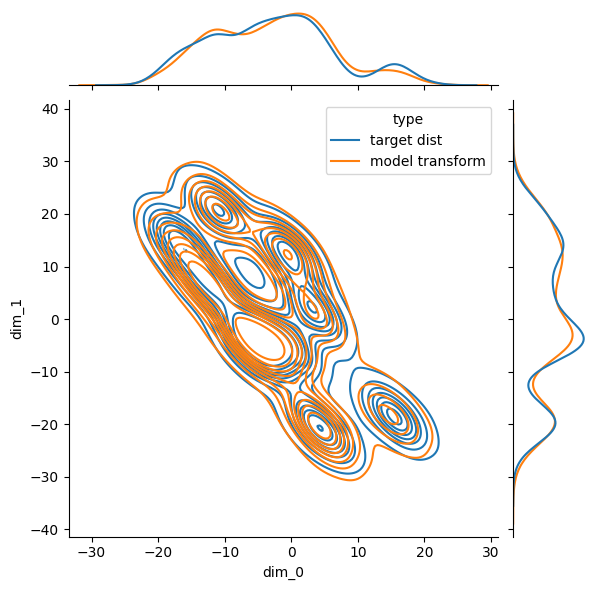

trail: 0 m step: 23 kl_test: 0.7672233581542969


  2%|▏         | 100/6000 [00:32<35:14,  2.79it/s]

trail: 0 m step: 24 Loss: 0.8046054840087891  L_n: 0.7215595245361328  kld: 0.0041522979736328125 KLD1: 0.6908924579620361 KLD2: 0.4494116008281708


  3%|▎         | 200/6000 [01:04<34:07,  2.83it/s]

trail: 0 m step: 24 Loss: 0.8226642608642578  L_n: 0.7017002105712891  kld: 0.0060482025146484375 KLD1: 0.7035806179046631 KLD2: 0.446839839220047


  5%|▌         | 300/6000 [01:36<33:40,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7917881011962891  L_n: 0.6918811798095703  kld: 0.0049953460693359375 KLD1: 0.7155824303627014 KLD2: 0.44683244824409485


  7%|▋         | 400/6000 [02:08<33:04,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7884426116943359  L_n: 0.7162685394287109  kld: 0.00360870361328125 KLD1: 0.7293245196342468 KLD2: 0.4355248808860779


  8%|▊         | 500/6000 [02:40<32:29,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8060665130615234  L_n: 0.7066555023193359  kld: 0.004970550537109375 KLD1: 0.6741687059402466 KLD2: 0.4485788345336914


 10%|█         | 600/6000 [03:12<31:50,  2.83it/s]

trail: 0 m step: 24 Loss: 0.8131141662597656  L_n: 0.6820030212402344  kld: 0.0065555572509765625 KLD1: 0.6711530089378357 KLD2: 0.44699451327323914


 12%|█▏        | 700/6000 [03:44<31:15,  2.83it/s]

trail: 0 m step: 24 Loss: 0.8131103515625  L_n: 0.6854705810546875  kld: 0.006381988525390625 KLD1: 0.663324773311615 KLD2: 0.44522425532341003


 13%|█▎        | 800/6000 [04:16<30:48,  2.81it/s]

trail: 0 m step: 24 Loss: 0.8348464965820312  L_n: 0.68389892578125  kld: 0.0075473785400390625 KLD1: 0.6928046941757202 KLD2: 0.4627232253551483


 15%|█▌        | 900/6000 [04:48<30:00,  2.83it/s]

trail: 0 m step: 24 Loss: 0.8060092926025391  L_n: 0.6871051788330078  kld: 0.0059452056884765625 KLD1: 0.676889181137085 KLD2: 0.45557814836502075


 17%|█▋        | 1000/6000 [05:20<29:39,  2.81it/s]

trail: 0 m step: 24 Loss: 0.8048801422119141  L_n: 0.6797580718994141  kld: 0.006256103515625 KLD1: 0.7118058204650879 KLD2: 0.4509798288345337


 18%|█▊        | 1100/6000 [05:52<28:58,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8735065460205078  L_n: 0.6827716827392578  kld: 0.0095367431640625 KLD1: 0.7026803493499756 KLD2: 0.4403451979160309


 20%|██        | 1200/6000 [06:24<28:24,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8312339782714844  L_n: 0.7075996398925781  kld: 0.0061817169189453125 KLD1: 0.6883723139762878 KLD2: 0.44975945353507996


 22%|██▏       | 1300/6000 [06:57<27:47,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8328933715820312  L_n: 0.6697006225585938  kld: 0.008159637451171875 KLD1: 0.7008330821990967 KLD2: 0.4607440233230591


 23%|██▎       | 1400/6000 [07:29<27:12,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8502635955810547  L_n: 0.6972942352294922  kld: 0.007648468017578125 KLD1: 0.6963470578193665 KLD2: 0.4373979866504669


 25%|██▌       | 1500/6000 [08:01<26:39,  2.81it/s]

trail: 0 m step: 24 Loss: 0.8379802703857422  L_n: 0.7037792205810547  kld: 0.006710052490234375 KLD1: 0.6888077259063721 KLD2: 0.4263581931591034


 27%|██▋       | 1600/6000 [08:33<26:00,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8004837036132812  L_n: 0.6866531372070312  kld: 0.0056915283203125 KLD1: 0.682679295539856 KLD2: 0.44576868414878845


 28%|██▊       | 1700/6000 [09:05<25:26,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8412094116210938  L_n: 0.6986160278320312  kld: 0.007129669189453125 KLD1: 0.6999335885047913 KLD2: 0.4543286859989166


 30%|███       | 1800/6000 [09:37<24:53,  2.81it/s]

trail: 0 m step: 24 Loss: 0.8687362670898438  L_n: 0.7000503540039062  kld: 0.008434295654296875 KLD1: 0.7130334973335266 KLD2: 0.43420687317848206


 32%|███▏      | 1900/6000 [10:09<24:10,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7771263122558594  L_n: 0.6571540832519531  kld: 0.0059986114501953125 KLD1: 0.6771922707557678 KLD2: 0.45616844296455383


 33%|███▎      | 2000/6000 [10:42<23:30,  2.84it/s]

trail: 0 m step: 24 Loss: 0.7982654571533203  L_n: 0.6782550811767578  kld: 0.006000518798828125 KLD1: 0.7164133787155151 KLD2: 0.4544665813446045


 35%|███▌      | 2100/6000 [11:14<23:03,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7771511077880859  L_n: 0.6680889129638672  kld: 0.0054531097412109375 KLD1: 0.6832327842712402 KLD2: 0.4594251811504364


 37%|███▋      | 2200/6000 [11:46<22:27,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7630519866943359  L_n: 0.6851940155029297  kld: 0.0038928985595703125 KLD1: 0.6630319952964783 KLD2: 0.44671034812927246


 38%|███▊      | 2300/6000 [12:18<21:58,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7750835418701172  L_n: 0.6830730438232422  kld: 0.00460052490234375 KLD1: 0.6995623707771301 KLD2: 0.4325101375579834


 40%|████      | 2400/6000 [12:50<21:18,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7657222747802734  L_n: 0.6801204681396484  kld: 0.00428009033203125 KLD1: 0.7026976346969604 KLD2: 0.45176175236701965


 42%|████▏     | 2500/6000 [13:22<20:45,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7874488830566406  L_n: 0.6751060485839844  kld: 0.0056171417236328125 KLD1: 0.6754966378211975 KLD2: 0.44432660937309265


 43%|████▎     | 2600/6000 [13:54<19:59,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7821178436279297  L_n: 0.6698513031005859  kld: 0.0056133270263671875 KLD1: 0.644268274307251 KLD2: 0.4358309507369995


 45%|████▌     | 2700/6000 [14:26<19:27,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7732505798339844  L_n: 0.6882209777832031  kld: 0.0042514801025390625 KLD1: 0.6945239305496216 KLD2: 0.4435637593269348


 47%|████▋     | 2800/6000 [14:58<18:51,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7743549346923828  L_n: 0.6970310211181641  kld: 0.0038661956787109375 KLD1: 0.6741074919700623 KLD2: 0.4397411644458771


 48%|████▊     | 2900/6000 [15:30<18:21,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8044242858886719  L_n: 0.7039833068847656  kld: 0.0050220489501953125 KLD1: 0.6731858253479004 KLD2: 0.44626882672309875


 50%|█████     | 3000/6000 [16:02<17:45,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7668533325195312  L_n: 0.707000732421875  kld: 0.0029926300048828125 KLD1: 0.7009544372558594 KLD2: 0.4431367516517639


 52%|█████▏    | 3100/6000 [16:34<17:04,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7297878265380859  L_n: 0.6512050628662109  kld: 0.00392913818359375 KLD1: 0.6588737964630127 KLD2: 0.4373354911804199


 53%|█████▎    | 3200/6000 [17:06<16:31,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7856674194335938  L_n: 0.6821746826171875  kld: 0.0051746368408203125 KLD1: 0.6753829717636108 KLD2: 0.430549293756485


 55%|█████▌    | 3300/6000 [17:38<15:55,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7385196685791016  L_n: 0.6970157623291016  kld: 0.0020751953125 KLD1: 0.6918032765388489 KLD2: 0.4306948184967041


 57%|█████▋    | 3400/6000 [18:10<15:20,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7641506195068359  L_n: 0.6542491912841797  kld: 0.0054950714111328125 KLD1: 0.6773101687431335 KLD2: 0.4462313950061798


 58%|█████▊    | 3500/6000 [18:42<14:43,  2.83it/s]

trail: 0 m step: 24 Loss: 0.828338623046875  L_n: 0.6905136108398438  kld: 0.0068912506103515625 KLD1: 0.6781668663024902 KLD2: 0.43968427181243896


 60%|██████    | 3600/6000 [19:14<14:12,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7880096435546875  L_n: 0.6671600341796875  kld: 0.00604248046875 KLD1: 0.6691423654556274 KLD2: 0.4587033987045288


 62%|██████▏   | 3700/6000 [19:47<13:34,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8343944549560547  L_n: 0.6978282928466797  kld: 0.00682830810546875 KLD1: 0.6856665015220642 KLD2: 0.4503765404224396


 63%|██████▎   | 3800/6000 [20:19<13:00,  2.82it/s]

trail: 0 m step: 24 Loss: 0.8173103332519531  L_n: 0.7127494812011719  kld: 0.0052280426025390625 KLD1: 0.703052282333374 KLD2: 0.4331499934196472


 65%|██████▌   | 3900/6000 [20:51<12:23,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7679901123046875  L_n: 0.6817398071289062  kld: 0.0043125152587890625 KLD1: 0.686432421207428 KLD2: 0.4375078082084656


 67%|██████▋   | 4000/6000 [21:23<11:47,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7792949676513672  L_n: 0.6880092620849609  kld: 0.0045642852783203125 KLD1: 0.6711729168891907 KLD2: 0.44082704186439514


 68%|██████▊   | 4100/6000 [21:55<11:12,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7949352264404297  L_n: 0.6805706024169922  kld: 0.005718231201171875 KLD1: 0.6440519690513611 KLD2: 0.4408435523509979


 70%|███████   | 4200/6000 [22:27<10:35,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7462978363037109  L_n: 0.6646633148193359  kld: 0.00408172607421875 KLD1: 0.6565352082252502 KLD2: 0.44189491868019104


 72%|███████▏  | 4300/6000 [22:59<10:01,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7733325958251953  L_n: 0.7025318145751953  kld: 0.0035400390625 KLD1: 0.6971068978309631 KLD2: 0.45468461513519287


 73%|███████▎  | 4400/6000 [23:31<09:28,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7419929504394531  L_n: 0.6695899963378906  kld: 0.003620147705078125 KLD1: 0.6970223188400269 KLD2: 0.440405935049057


 75%|███████▌  | 4500/6000 [24:03<08:53,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7743453979492188  L_n: 0.6838607788085938  kld: 0.00452423095703125 KLD1: 0.6629461646080017 KLD2: 0.43313854932785034


 77%|███████▋  | 4600/6000 [24:35<08:16,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7242221832275391  L_n: 0.6639881134033203  kld: 0.0030117034912109375 KLD1: 0.6905187964439392 KLD2: 0.45749378204345703


 78%|███████▊  | 4700/6000 [25:08<07:41,  2.82it/s]

trail: 0 m step: 24 Loss: 0.6862335205078125  L_n: 0.672119140625  kld: 0.000705718994140625 KLD1: 0.7068638205528259 KLD2: 0.44527068734169006


 80%|████████  | 4800/6000 [25:40<07:05,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7384719848632812  L_n: 0.68670654296875  kld: 0.0025882720947265625 KLD1: 0.6768209934234619 KLD2: 0.4442231357097626


 82%|████████▏ | 4900/6000 [26:12<06:29,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7254581451416016  L_n: 0.6665973663330078  kld: 0.0029430389404296875 KLD1: 0.6883713006973267 KLD2: 0.4329466223716736


 83%|████████▎ | 5000/6000 [26:44<05:54,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7526779174804688  L_n: 0.6901168823242188  kld: 0.0031280517578125 KLD1: 0.6874823570251465 KLD2: 0.4446237087249756


 85%|████████▌ | 5100/6000 [27:16<05:19,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7282276153564453  L_n: 0.6626529693603516  kld: 0.0032787322998046875 KLD1: 0.6869063377380371 KLD2: 0.453451931476593


 87%|████████▋ | 5200/6000 [27:48<04:43,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7453136444091797  L_n: 0.6756954193115234  kld: 0.0034809112548828125 KLD1: 0.6719258427619934 KLD2: 0.444494366645813


 88%|████████▊ | 5300/6000 [28:20<04:09,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7864208221435547  L_n: 0.7061595916748047  kld: 0.0040130615234375 KLD1: 0.6856558322906494 KLD2: 0.4342409074306488


 90%|█████████ | 5400/6000 [28:53<03:32,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7901535034179688  L_n: 0.6962356567382812  kld: 0.004695892333984375 KLD1: 0.701154351234436 KLD2: 0.439865380525589


 92%|█████████▏| 5500/6000 [29:25<02:57,  2.81it/s]

trail: 0 m step: 24 Loss: 0.7583541870117188  L_n: 0.685455322265625  kld: 0.0036449432373046875 KLD1: 0.6707553863525391 KLD2: 0.4457753300666809


 93%|█████████▎| 5600/6000 [29:57<02:22,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7642898559570312  L_n: 0.6819686889648438  kld: 0.004116058349609375 KLD1: 0.6810686588287354 KLD2: 0.43333324790000916


 95%|█████████▌| 5700/6000 [30:29<01:46,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7328453063964844  L_n: 0.6687202453613281  kld: 0.0032062530517578125 KLD1: 0.6675354242324829 KLD2: 0.44441932439804077


 97%|█████████▋| 5800/6000 [31:01<01:10,  2.83it/s]

trail: 0 m step: 24 Loss: 0.7344303131103516  L_n: 0.6774768829345703  kld: 0.0028476715087890625 KLD1: 0.6875860095024109 KLD2: 0.43468308448791504


 98%|█████████▊| 5900/6000 [31:33<00:35,  2.82it/s]

trail: 0 m step: 24 Loss: 0.7507762908935547  L_n: 0.6909999847412109  kld: 0.0029888153076171875 KLD1: 0.6999532580375671 KLD2: 0.4550408124923706


100%|██████████| 6000/6000 [32:06<00:00,  3.12it/s]

trail: 0 m step: 24 Loss: 0.7796115875244141  L_n: 0.7278461456298828  kld: 0.0025882720947265625 KLD1: 0.7013066411018372 KLD2: 0.4485085904598236



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


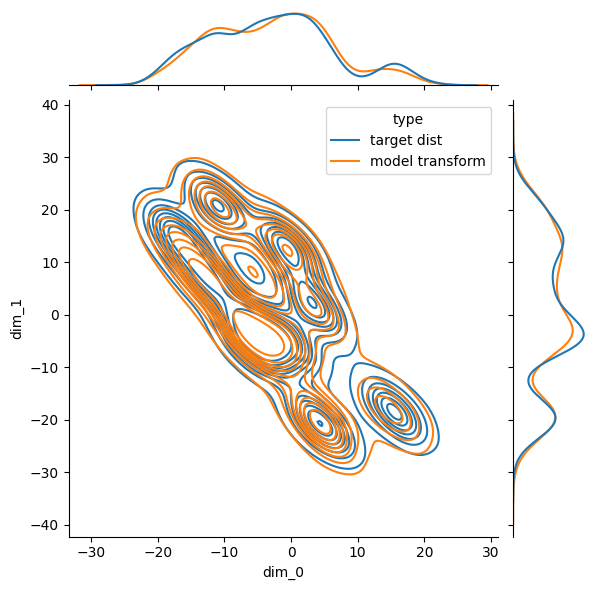

trail: 0 m step: 24 kl_test: 0.7096099853515625


  2%|▏         | 100/6000 [00:32<35:07,  2.80it/s]

trail: 0 m step: 25 Loss: 0.7310619354248047  L_n: 0.6452312469482422  kld: 0.004291534423828125 KLD1: 0.6244748830795288 KLD2: 0.4165613055229187


  3%|▎         | 200/6000 [01:04<34:04,  2.84it/s]

trail: 0 m step: 25 Loss: 0.77606201171875  L_n: 0.6555557250976562  kld: 0.0060253143310546875 KLD1: 0.6433756947517395 KLD2: 0.41525447368621826


  5%|▌         | 300/6000 [01:36<33:45,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7424488067626953  L_n: 0.6288089752197266  kld: 0.0056819915771484375 KLD1: 0.6411827802658081 KLD2: 0.4104136526584625


  7%|▋         | 400/6000 [02:08<33:12,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7439785003662109  L_n: 0.6669979095458984  kld: 0.003849029541015625 KLD1: 0.6758788824081421 KLD2: 0.40748390555381775


  8%|▊         | 500/6000 [02:40<32:39,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7737407684326172  L_n: 0.6371364593505859  kld: 0.0068302154541015625 KLD1: 0.6119421124458313 KLD2: 0.42255932092666626


 10%|█         | 600/6000 [03:13<31:56,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7189979553222656  L_n: 0.6187477111816406  kld: 0.00501251220703125 KLD1: 0.6227561235427856 KLD2: 0.41858601570129395


 12%|█▏        | 700/6000 [03:45<31:23,  2.81it/s]

trail: 0 m step: 25 Loss: 0.755218505859375  L_n: 0.6422653198242188  kld: 0.0056476593017578125 KLD1: 0.6274934411048889 KLD2: 0.4202191233634949


 13%|█▎        | 800/6000 [04:17<30:54,  2.80it/s]

trail: 0 m step: 25 Loss: 0.7427902221679688  L_n: 0.634796142578125  kld: 0.0053997039794921875 KLD1: 0.6271309852600098 KLD2: 0.4335764944553375


 15%|█▌        | 900/6000 [04:49<30:05,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7515239715576172  L_n: 0.6382656097412109  kld: 0.0056629180908203125 KLD1: 0.6293640732765198 KLD2: 0.42516034841537476


 17%|█▋        | 1000/6000 [05:21<29:33,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7119255065917969  L_n: 0.6338768005371094  kld: 0.003902435302734375 KLD1: 0.6694668531417847 KLD2: 0.42261990904808044


 18%|█▊        | 1100/6000 [05:53<29:08,  2.80it/s]

trail: 0 m step: 25 Loss: 0.7299728393554688  L_n: 0.622283935546875  kld: 0.0053844451904296875 KLD1: 0.6664339900016785 KLD2: 0.4070202112197876


 20%|██        | 1200/6000 [06:25<28:20,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7965965270996094  L_n: 0.6518287658691406  kld: 0.0072383880615234375 KLD1: 0.6393967866897583 KLD2: 0.41744452714920044


 22%|██▏       | 1300/6000 [06:58<27:45,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7496471405029297  L_n: 0.6505413055419922  kld: 0.004955291748046875 KLD1: 0.6471648812294006 KLD2: 0.4279506802558899


 23%|██▎       | 1400/6000 [07:30<27:10,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7703514099121094  L_n: 0.6651420593261719  kld: 0.005260467529296875 KLD1: 0.6230980753898621 KLD2: 0.41173309087753296


 25%|██▌       | 1500/6000 [08:02<26:30,  2.83it/s]

trail: 0 m step: 25 Loss: 0.7115249633789062  L_n: 0.6408767700195312  kld: 0.00353240966796875 KLD1: 0.6191104054450989 KLD2: 0.4034770131111145


 27%|██▋       | 1600/6000 [08:34<25:58,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7212810516357422  L_n: 0.6526546478271484  kld: 0.0034313201904296875 KLD1: 0.6349244713783264 KLD2: 0.41701698303222656


 28%|██▊       | 1700/6000 [09:06<25:27,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7961349487304688  L_n: 0.6953887939453125  kld: 0.0050373077392578125 KLD1: 0.6418246626853943 KLD2: 0.42879676818847656


 30%|███       | 1800/6000 [09:38<24:52,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7688522338867188  L_n: 0.634002685546875  kld: 0.0067424774169921875 KLD1: 0.6480395197868347 KLD2: 0.40531492233276367


 32%|███▏      | 1900/6000 [10:10<24:07,  2.83it/s]

trail: 0 m step: 25 Loss: 0.7426242828369141  L_n: 0.6167774200439453  kld: 0.0062923431396484375 KLD1: 0.6199079751968384 KLD2: 0.42866477370262146


 33%|███▎      | 2000/6000 [10:43<23:38,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7747230529785156  L_n: 0.6446037292480469  kld: 0.0065059661865234375 KLD1: 0.6471155285835266 KLD2: 0.4217555522918701


 35%|███▌      | 2100/6000 [11:15<23:07,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7313785552978516  L_n: 0.6311664581298828  kld: 0.0050106048583984375 KLD1: 0.6334905028343201 KLD2: 0.4239480495452881


 37%|███▋      | 2200/6000 [11:47<22:33,  2.81it/s]

trail: 0 m step: 25 Loss: 0.6958789825439453  L_n: 0.6419773101806641  kld: 0.0026950836181640625 KLD1: 0.618033230304718 KLD2: 0.4156720042228699


 38%|███▊      | 2300/6000 [12:19<21:51,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6810493469238281  L_n: 0.6161613464355469  kld: 0.0032444000244140625 KLD1: 0.6436200737953186 KLD2: 0.40324440598487854


 40%|████      | 2400/6000 [12:51<21:20,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7144889831542969  L_n: 0.6283531188964844  kld: 0.004306793212890625 KLD1: 0.6255161166191101 KLD2: 0.4231783151626587


 42%|████▏     | 2500/6000 [13:24<20:39,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7317352294921875  L_n: 0.6397628784179688  kld: 0.0045986175537109375 KLD1: 0.636195182800293 KLD2: 0.41429394483566284


 43%|████▎     | 2600/6000 [13:56<20:04,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7194232940673828  L_n: 0.6271457672119141  kld: 0.0046138763427734375 KLD1: 0.6265944242477417 KLD2: 0.4053935110569


 45%|████▌     | 2700/6000 [14:28<19:35,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7415618896484375  L_n: 0.6568756103515625  kld: 0.00423431396484375 KLD1: 0.6503852605819702 KLD2: 0.41340702772140503


 47%|████▋     | 2800/6000 [15:00<18:55,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6919689178466797  L_n: 0.6203670501708984  kld: 0.0035800933837890625 KLD1: 0.6279503703117371 KLD2: 0.40717822313308716


 48%|████▊     | 2900/6000 [15:32<18:25,  2.80it/s]

trail: 0 m step: 25 Loss: 0.7176685333251953  L_n: 0.6414127349853516  kld: 0.0038127899169921875 KLD1: 0.6234201788902283 KLD2: 0.4151722192764282


 50%|█████     | 3000/6000 [16:04<17:43,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7193069458007812  L_n: 0.6432037353515625  kld: 0.0038051605224609375 KLD1: 0.6437546014785767 KLD2: 0.40916839241981506


 52%|█████▏    | 3100/6000 [16:36<17:12,  2.81it/s]

trail: 0 m step: 25 Loss: 0.6919441223144531  L_n: 0.5938682556152344  kld: 0.0049037933349609375 KLD1: 0.6179816126823425 KLD2: 0.41226726770401


 53%|█████▎    | 3200/6000 [17:09<16:34,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7747211456298828  L_n: 0.6494846343994141  kld: 0.0062618255615234375 KLD1: 0.6395319104194641 KLD2: 0.4055643677711487


 55%|█████▌    | 3300/6000 [17:41<16:01,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7124481201171875  L_n: 0.6584701538085938  kld: 0.0026988983154296875 KLD1: 0.6531236171722412 KLD2: 0.4060876965522766


 57%|█████▋    | 3400/6000 [18:13<15:23,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6980686187744141  L_n: 0.6217746734619141  kld: 0.003814697265625 KLD1: 0.6246678829193115 KLD2: 0.42029285430908203


 58%|█████▊    | 3500/6000 [18:45<14:50,  2.81it/s]

trail: 0 m step: 25 Loss: 0.707366943359375  L_n: 0.6311111450195312  kld: 0.0038127899169921875 KLD1: 0.6137774586677551 KLD2: 0.4132614731788635


 60%|██████    | 3600/6000 [19:17<14:12,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7081737518310547  L_n: 0.6127681732177734  kld: 0.0047702789306640625 KLD1: 0.6209012269973755 KLD2: 0.4323853552341461


 62%|██████▏   | 3700/6000 [19:49<13:36,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7226276397705078  L_n: 0.6481647491455078  kld: 0.00372314453125 KLD1: 0.6439818143844604 KLD2: 0.42271527647972107


 63%|██████▎   | 3800/6000 [20:21<13:02,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7143211364746094  L_n: 0.6482887268066406  kld: 0.0033016204833984375 KLD1: 0.6463704109191895 KLD2: 0.4018861651420593


 65%|██████▌   | 3900/6000 [20:54<12:27,  2.81it/s]

trail: 0 m step: 25 Loss: 0.762969970703125  L_n: 0.6361312866210938  kld: 0.0063419342041015625 KLD1: 0.6073397994041443 KLD2: 0.40745824575424194


 67%|██████▋   | 4000/6000 [21:26<11:51,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7243366241455078  L_n: 0.6229801177978516  kld: 0.0050678253173828125 KLD1: 0.6176929473876953 KLD2: 0.4149332344532013


 68%|██████▊   | 4100/6000 [21:58<11:14,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6963748931884766  L_n: 0.6356067657470703  kld: 0.0030384063720703125 KLD1: 0.6058405637741089 KLD2: 0.4096788465976715


 70%|███████   | 4200/6000 [22:30<10:38,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7298984527587891  L_n: 0.6286945343017578  kld: 0.0050601959228515625 KLD1: 0.6207864880561829 KLD2: 0.4137926697731018


 72%|███████▏  | 4300/6000 [23:02<10:02,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7146015167236328  L_n: 0.6451740264892578  kld: 0.00347137451171875 KLD1: 0.6356585621833801 KLD2: 0.424871563911438


 73%|███████▎  | 4400/6000 [23:34<09:25,  2.83it/s]

trail: 0 m step: 25 Loss: 0.6602859497070312  L_n: 0.6098556518554688  kld: 0.002521514892578125 KLD1: 0.6396985650062561 KLD2: 0.40847787261009216


 75%|███████▌  | 4500/6000 [24:06<08:53,  2.81it/s]

trail: 0 m step: 25 Loss: 0.7083969116210938  L_n: 0.6256561279296875  kld: 0.0041370391845703125 KLD1: 0.6162132620811462 KLD2: 0.40166571736335754


 77%|███████▋  | 4600/6000 [24:38<08:15,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6535224914550781  L_n: 0.6112174987792969  kld: 0.0021152496337890625 KLD1: 0.6462607383728027 KLD2: 0.42882558703422546


 78%|███████▊  | 4700/6000 [25:11<07:41,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6687831878662109  L_n: 0.6320095062255859  kld: 0.00183868408203125 KLD1: 0.655902087688446 KLD2: 0.41458114981651306


 80%|████████  | 4800/6000 [25:43<07:04,  2.83it/s]

trail: 0 m step: 25 Loss: 0.6959590911865234  L_n: 0.6237468719482422  kld: 0.0036106109619140625 KLD1: 0.6275460720062256 KLD2: 0.41559743881225586


 82%|████████▏ | 4900/6000 [26:15<06:30,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6652736663818359  L_n: 0.6072902679443359  kld: 0.002899169921875 KLD1: 0.638194739818573 KLD2: 0.40519848465919495


 83%|████████▎ | 5000/6000 [26:47<05:54,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7019844055175781  L_n: 0.6394615173339844  kld: 0.0031261444091796875 KLD1: 0.6255306601524353 KLD2: 0.4171386957168579


 85%|████████▌ | 5100/6000 [27:19<05:18,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6486072540283203  L_n: 0.6012287139892578  kld: 0.002368927001953125 KLD1: 0.627997636795044 KLD2: 0.42924779653549194


 87%|████████▋ | 5200/6000 [27:51<04:42,  2.83it/s]

trail: 0 m step: 25 Loss: 0.7014617919921875  L_n: 0.62982177734375  kld: 0.003582000732421875 KLD1: 0.6152079105377197 KLD2: 0.41737258434295654


 88%|████████▊ | 5300/6000 [28:23<04:08,  2.81it/s]

trail: 0 m step: 25 Loss: 0.6944580078125  L_n: 0.6347579956054688  kld: 0.0029850006103515625 KLD1: 0.6288393139839172 KLD2: 0.40789133310317993


 90%|█████████ | 5400/6000 [28:55<03:32,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7014083862304688  L_n: 0.643463134765625  kld: 0.0028972625732421875 KLD1: 0.6408342719078064 KLD2: 0.4111257791519165


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6817874908447266  L_n: 0.6313190460205078  kld: 0.0025234222412109375 KLD1: 0.6207872629165649 KLD2: 0.41921132802963257


 93%|█████████▎| 5600/6000 [29:59<02:21,  2.82it/s]

trail: 0 m step: 25 Loss: 0.7026519775390625  L_n: 0.6426467895507812  kld: 0.0030002593994140625 KLD1: 0.6261386871337891 KLD2: 0.409342885017395


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6512680053710938  L_n: 0.6267776489257812  kld: 0.001224517822265625 KLD1: 0.6266810297966003 KLD2: 0.4195859134197235


 97%|█████████▋| 5800/6000 [31:03<01:10,  2.82it/s]

trail: 0 m step: 25 Loss: 0.6887493133544922  L_n: 0.6366024017333984  kld: 0.0026073455810546875 KLD1: 0.6332948803901672 KLD2: 0.4067555069923401


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.81it/s]

trail: 0 m step: 25 Loss: 0.6936798095703125  L_n: 0.639739990234375  kld: 0.002696990966796875 KLD1: 0.6358110904693604 KLD2: 0.4248819649219513


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 25 Loss: 0.7150192260742188  L_n: 0.6542892456054688  kld: 0.0030364990234375 KLD1: 0.6477507948875427 KLD2: 0.41982582211494446



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


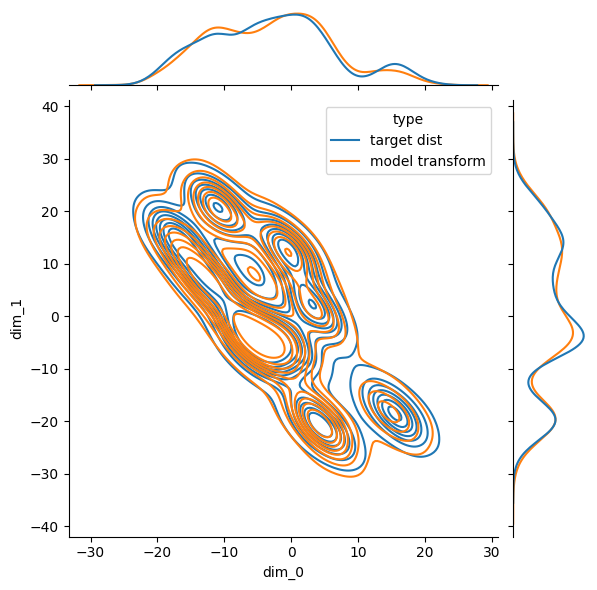

trail: 0 m step: 25 kl_test: 0.6683349609375


  2%|▏         | 100/6000 [00:32<35:14,  2.79it/s]

trail: 0 m step: 26 Loss: 0.6881752014160156  L_n: 0.6097068786621094  kld: 0.0039234161376953125 KLD1: 0.5895869135856628 KLD2: 0.39808937907218933


  3%|▎         | 200/6000 [01:04<34:10,  2.83it/s]

trail: 0 m step: 26 Loss: 0.7684154510498047  L_n: 0.6118602752685547  kld: 0.0078277587890625 KLD1: 0.6131109595298767 KLD2: 0.3911198675632477


  5%|▌         | 300/6000 [01:36<33:39,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6567554473876953  L_n: 0.5961017608642578  kld: 0.003032684326171875 KLD1: 0.6060934662818909 KLD2: 0.38930797576904297


  7%|▋         | 400/6000 [02:08<33:15,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6712226867675781  L_n: 0.6042747497558594  kld: 0.0033473968505859375 KLD1: 0.6141472458839417 KLD2: 0.38390079140663147


  8%|▊         | 500/6000 [02:40<32:40,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6821384429931641  L_n: 0.5829181671142578  kld: 0.0049610137939453125 KLD1: 0.5782068371772766 KLD2: 0.39351949095726013


 10%|█         | 600/6000 [03:13<31:55,  2.82it/s]

trail: 0 m step: 26 Loss: 0.7630825042724609  L_n: 0.5911540985107422  kld: 0.008596420288085938 KLD1: 0.5902568101882935 KLD2: 0.39073866605758667


 12%|█▏        | 700/6000 [03:45<31:19,  2.82it/s]

trail: 0 m step: 26 Loss: 0.7435169219970703  L_n: 0.5731525421142578  kld: 0.008518218994140625 KLD1: 0.5860034227371216 KLD2: 0.39750924706459045


 13%|█▎        | 800/6000 [04:17<30:48,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6992549896240234  L_n: 0.5759639739990234  kld: 0.00616455078125 KLD1: 0.5697284936904907 KLD2: 0.40914013981819153


 15%|█▌        | 900/6000 [04:49<30:08,  2.82it/s]

trail: 0 m step: 26 Loss: 0.7441082000732422  L_n: 0.5780544281005859  kld: 0.008302688598632812 KLD1: 0.5998064875602722 KLD2: 0.3983529806137085


 17%|█▋        | 1000/6000 [05:21<29:36,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6479740142822266  L_n: 0.5770587921142578  kld: 0.0035457611083984375 KLD1: 0.6014282703399658 KLD2: 0.394194096326828


 18%|█▊        | 1100/6000 [05:53<29:03,  2.81it/s]

trail: 0 m step: 26 Loss: 0.7065715789794922  L_n: 0.5897274017333984  kld: 0.0058422088623046875 KLD1: 0.6034586429595947 KLD2: 0.38494500517845154


 20%|██        | 1200/6000 [06:25<28:25,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6984176635742188  L_n: 0.6128921508789062  kld: 0.004276275634765625 KLD1: 0.6105836033821106 KLD2: 0.40040454268455505


 22%|██▏       | 1300/6000 [06:58<27:47,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6725311279296875  L_n: 0.587005615234375  kld: 0.004276275634765625 KLD1: 0.6068334579467773 KLD2: 0.3999769389629364


 23%|██▎       | 1400/6000 [07:30<27:19,  2.81it/s]

trail: 0 m step: 26 Loss: 0.7802867889404297  L_n: 0.6208705902099609  kld: 0.007970809936523438 KLD1: 0.5842623114585876 KLD2: 0.38333019614219666


 25%|██▌       | 1500/6000 [08:02<26:43,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6724510192871094  L_n: 0.5868873596191406  kld: 0.0042781829833984375 KLD1: 0.5995876789093018 KLD2: 0.37565627694129944


 27%|██▋       | 1600/6000 [08:34<26:02,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6709804534912109  L_n: 0.6128826141357422  kld: 0.0029048919677734375 KLD1: 0.6017748117446899 KLD2: 0.39642849564552307


 28%|██▊       | 1700/6000 [09:06<25:27,  2.82it/s]

trail: 0 m step: 26 Loss: 0.7187595367431641  L_n: 0.6067600250244141  kld: 0.0055999755859375 KLD1: 0.5886279940605164 KLD2: 0.40289634466171265


 30%|███       | 1800/6000 [09:39<24:51,  2.82it/s]

trail: 0 m step: 26 Loss: 0.7492218017578125  L_n: 0.5833206176757812  kld: 0.008295059204101562 KLD1: 0.6219657063484192 KLD2: 0.3867020010948181


 32%|███▏      | 1900/6000 [10:11<24:09,  2.83it/s]

trail: 0 m step: 26 Loss: 0.6634273529052734  L_n: 0.5683650970458984  kld: 0.00475311279296875 KLD1: 0.5820999145507812 KLD2: 0.40751731395721436


 33%|███▎      | 2000/6000 [10:43<23:37,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6962661743164062  L_n: 0.5980758666992188  kld: 0.004909515380859375 KLD1: 0.6017475724220276 KLD2: 0.39297473430633545


 35%|███▌      | 2100/6000 [11:15<23:12,  2.80it/s]

trail: 0 m step: 26 Loss: 0.6326751708984375  L_n: 0.5618743896484375  kld: 0.0035400390625 KLD1: 0.577405571937561 KLD2: 0.39989152550697327


 37%|███▋      | 2200/6000 [11:47<22:29,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6757373809814453  L_n: 0.5902500152587891  kld: 0.0042743682861328125 KLD1: 0.5631052851676941 KLD2: 0.3883358836174011


 38%|███▊      | 2300/6000 [12:20<21:56,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6490020751953125  L_n: 0.5813674926757812  kld: 0.0033817291259765625 KLD1: 0.6006571054458618 KLD2: 0.3832337260246277


 40%|████      | 2400/6000 [12:52<21:21,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6815528869628906  L_n: 0.5881690979003906  kld: 0.004669189453125 KLD1: 0.5890329480171204 KLD2: 0.396531879901886


 42%|████▏     | 2500/6000 [13:24<20:45,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6848678588867188  L_n: 0.5892333984375  kld: 0.0047817230224609375 KLD1: 0.5821309685707092 KLD2: 0.3876791000366211


 43%|████▎     | 2600/6000 [13:56<20:07,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6584720611572266  L_n: 0.5700092315673828  kld: 0.0044231414794921875 KLD1: 0.5712234973907471 KLD2: 0.38247963786125183


 45%|████▌     | 2700/6000 [14:28<19:36,  2.80it/s]

trail: 0 m step: 26 Loss: 0.6518230438232422  L_n: 0.5970058441162109  kld: 0.0027408599853515625 KLD1: 0.5989610552787781 KLD2: 0.3906853199005127


 47%|████▋     | 2800/6000 [15:00<18:54,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6731548309326172  L_n: 0.5971279144287109  kld: 0.0038013458251953125 KLD1: 0.6022091507911682 KLD2: 0.381675124168396


 48%|████▊     | 2900/6000 [15:33<18:22,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6677627563476562  L_n: 0.5950927734375  kld: 0.0036334991455078125 KLD1: 0.5731737613677979 KLD2: 0.3853742182254791


 50%|█████     | 3000/6000 [16:05<17:48,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6577930450439453  L_n: 0.5871829986572266  kld: 0.0035305023193359375 KLD1: 0.5966441035270691 KLD2: 0.38539764285087585


 52%|█████▏    | 3100/6000 [16:37<17:11,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6739616394042969  L_n: 0.5765342712402344  kld: 0.004871368408203125 KLD1: 0.5650367736816406 KLD2: 0.38790327310562134


 53%|█████▎    | 3200/6000 [17:09<16:33,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6726856231689453  L_n: 0.5785388946533203  kld: 0.00470733642578125 KLD1: 0.5806359052658081 KLD2: 0.3748929500579834


 55%|█████▌    | 3300/6000 [17:41<16:02,  2.81it/s]

trail: 0 m step: 26 Loss: 0.658416748046875  L_n: 0.5951309204101562  kld: 0.0031642913818359375 KLD1: 0.5935134887695312 KLD2: 0.37574970722198486


 57%|█████▋    | 3400/6000 [18:14<15:26,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6581172943115234  L_n: 0.5740032196044922  kld: 0.0042057037353515625 KLD1: 0.5934767723083496 KLD2: 0.3911779224872589


 58%|█████▊    | 3500/6000 [18:46<14:43,  2.83it/s]

trail: 0 m step: 26 Loss: 0.6699237823486328  L_n: 0.5962619781494141  kld: 0.0036830902099609375 KLD1: 0.5544342398643494 KLD2: 0.3842761218547821


 60%|██████    | 3600/6000 [19:18<14:11,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6636238098144531  L_n: 0.5612754821777344  kld: 0.0051174163818359375 KLD1: 0.5725844502449036 KLD2: 0.4018135070800781


 62%|██████▏   | 3700/6000 [19:50<13:37,  2.81it/s]

trail: 0 m step: 26 Loss: 0.7015876770019531  L_n: 0.5969886779785156  kld: 0.005229949951171875 KLD1: 0.5830482840538025 KLD2: 0.39338529109954834


 63%|██████▎   | 3800/6000 [20:23<13:05,  2.80it/s]

trail: 0 m step: 26 Loss: 0.6888408660888672  L_n: 0.6164760589599609  kld: 0.0036182403564453125 KLD1: 0.5981679558753967 KLD2: 0.37495434284210205


 65%|██████▌   | 3900/6000 [20:55<12:29,  2.80it/s]

trail: 0 m step: 26 Loss: 0.7090377807617188  L_n: 0.5881500244140625  kld: 0.0060443878173828125 KLD1: 0.5763814449310303 KLD2: 0.3841443359851837


 67%|██████▋   | 4000/6000 [21:27<11:50,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6983547210693359  L_n: 0.5878429412841797  kld: 0.0055255889892578125 KLD1: 0.5729845762252808 KLD2: 0.38737937808036804


 68%|██████▊   | 4100/6000 [21:59<11:14,  2.82it/s]

trail: 0 m step: 26 Loss: 0.7069835662841797  L_n: 0.5983028411865234  kld: 0.0054340362548828125 KLD1: 0.5533903241157532 KLD2: 0.38457977771759033


 70%|███████   | 4200/6000 [22:31<10:35,  2.83it/s]

trail: 0 m step: 26 Loss: 0.6441802978515625  L_n: 0.5694503784179688  kld: 0.0037364959716796875 KLD1: 0.5623348355293274 KLD2: 0.38680773973464966


 72%|███████▏  | 4300/6000 [23:03<10:03,  2.81it/s]

trail: 0 m step: 26 Loss: 0.67999267578125  L_n: 0.6094207763671875  kld: 0.003528594970703125 KLD1: 0.6027845144271851 KLD2: 0.4013395309448242


 73%|███████▎  | 4400/6000 [23:35<09:27,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6392898559570312  L_n: 0.5752792358398438  kld: 0.003200531005859375 KLD1: 0.6191340684890747 KLD2: 0.3855757415294647


 75%|███████▌  | 4500/6000 [24:08<08:52,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6657752990722656  L_n: 0.5871543884277344  kld: 0.0039310455322265625 KLD1: 0.5870333909988403 KLD2: 0.38076508045196533


 77%|███████▋  | 4600/6000 [24:40<08:16,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6431865692138672  L_n: 0.5859279632568359  kld: 0.0028629302978515625 KLD1: 0.5973658561706543 KLD2: 0.4040634036064148


 78%|███████▊  | 4700/6000 [25:12<07:42,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6208629608154297  L_n: 0.5939693450927734  kld: 0.0013446807861328125 KLD1: 0.6225607395172119 KLD2: 0.39308494329452515


 80%|████████  | 4800/6000 [25:44<07:04,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6385231018066406  L_n: 0.5829811096191406  kld: 0.002777099609375 KLD1: 0.5927812457084656 KLD2: 0.3917354941368103


 82%|████████▏ | 4900/6000 [26:16<06:30,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6172924041748047  L_n: 0.5586605072021484  kld: 0.0029315948486328125 KLD1: 0.5976644158363342 KLD2: 0.38113754987716675


 83%|████████▎ | 5000/6000 [26:48<05:53,  2.83it/s]

trail: 0 m step: 26 Loss: 0.6612491607666016  L_n: 0.5983066558837891  kld: 0.003147125244140625 KLD1: 0.5926855206489563 KLD2: 0.3916889727115631


 85%|████████▌ | 5100/6000 [27:20<05:18,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6115608215332031  L_n: 0.5694465637207031  kld: 0.002105712890625 KLD1: 0.5844808220863342 KLD2: 0.4029183089733124


 87%|████████▋ | 5200/6000 [27:52<04:43,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6611099243164062  L_n: 0.5908432006835938  kld: 0.003513336181640625 KLD1: 0.5839840769767761 KLD2: 0.39326149225234985


 88%|████████▊ | 5300/6000 [28:24<04:08,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6502227783203125  L_n: 0.599029541015625  kld: 0.002559661865234375 KLD1: 0.5858878493309021 KLD2: 0.38248881697654724


 90%|█████████ | 5400/6000 [28:57<03:33,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6566791534423828  L_n: 0.6020526885986328  kld: 0.0027313232421875 KLD1: 0.5966731309890747 KLD2: 0.38655799627304077


 92%|█████████▏| 5500/6000 [29:29<02:57,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6669807434082031  L_n: 0.5990409851074219  kld: 0.0033969879150390625 KLD1: 0.5829858779907227 KLD2: 0.39358633756637573


 93%|█████████▎| 5600/6000 [30:01<02:21,  2.82it/s]

trail: 0 m step: 26 Loss: 0.6451892852783203  L_n: 0.5886936187744141  kld: 0.0028247833251953125 KLD1: 0.5762118101119995 KLD2: 0.3820969760417938


 95%|█████████▌| 5700/6000 [30:33<01:46,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6117343902587891  L_n: 0.5771732330322266  kld: 0.001728057861328125 KLD1: 0.583200991153717 KLD2: 0.3928142786026001


 97%|█████████▋| 5800/6000 [31:05<01:11,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6590976715087891  L_n: 0.6024875640869141  kld: 0.00283050537109375 KLD1: 0.5772411823272705 KLD2: 0.38153430819511414


 98%|█████████▊| 5900/6000 [31:37<00:35,  2.81it/s]

trail: 0 m step: 26 Loss: 0.6720199584960938  L_n: 0.6226577758789062  kld: 0.002468109130859375 KLD1: 0.5889361500740051 KLD2: 0.400284081697464


100%|██████████| 6000/6000 [32:10<00:00,  3.11it/s]

trail: 0 m step: 26 Loss: 0.6881046295166016  L_n: 0.6282138824462891  kld: 0.002994537353515625 KLD1: 0.6055379509925842 KLD2: 0.397216796875



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


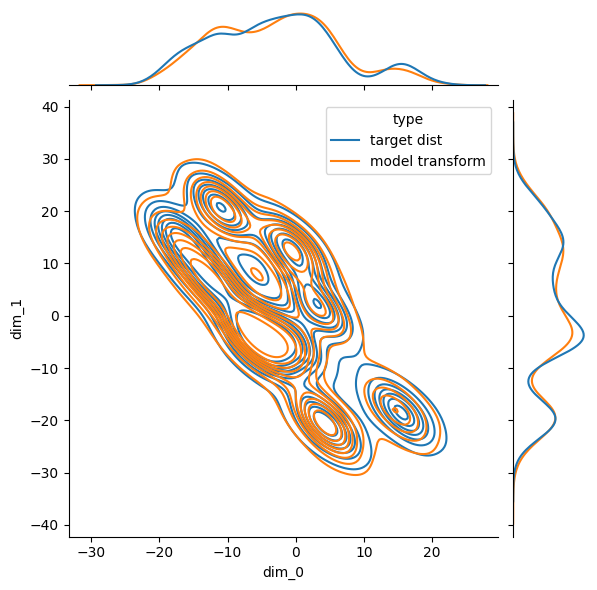

trail: 0 m step: 26 kl_test: 0.6237907409667969


  2%|▏         | 100/6000 [00:32<35:07,  2.80it/s]

trail: 0 m step: 27 Loss: 0.6896381378173828  L_n: 0.5686359405517578  kld: 0.00605010986328125 KLD1: 0.5561345815658569 KLD2: 0.3702058494091034


  3%|▎         | 200/6000 [01:04<34:03,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6983394622802734  L_n: 0.5626888275146484  kld: 0.00678253173828125 KLD1: 0.5462112426757812 KLD2: 0.3697860538959503


  5%|▌         | 300/6000 [01:36<33:32,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6675472259521484  L_n: 0.5531063079833984  kld: 0.0057220458984375 KLD1: 0.5559608936309814 KLD2: 0.3657265901565552


  7%|▋         | 400/6000 [02:08<32:57,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6726150512695312  L_n: 0.5669479370117188  kld: 0.005283355712890625 KLD1: 0.5896748304367065 KLD2: 0.36583349108695984


  8%|▊         | 500/6000 [02:40<32:24,  2.83it/s]

trail: 0 m step: 27 Loss: 0.665252685546875  L_n: 0.5696563720703125  kld: 0.004779815673828125 KLD1: 0.5412599444389343 KLD2: 0.3773902654647827


 10%|█         | 600/6000 [03:12<31:48,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6594772338867188  L_n: 0.5532760620117188  kld: 0.00531005859375 KLD1: 0.5511276125907898 KLD2: 0.3761695921421051


 12%|█▏        | 700/6000 [03:44<31:08,  2.84it/s]

trail: 0 m step: 27 Loss: 0.67376708984375  L_n: 0.5630264282226562  kld: 0.0055370330810546875 KLD1: 0.547391414642334 KLD2: 0.37936025857925415


 13%|█▎        | 800/6000 [04:16<30:32,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6513214111328125  L_n: 0.54046630859375  kld: 0.005542755126953125 KLD1: 0.5564590692520142 KLD2: 0.39140763878822327


 15%|█▌        | 900/6000 [04:48<30:02,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6736259460449219  L_n: 0.5602149963378906  kld: 0.0056705474853515625 KLD1: 0.545970618724823 KLD2: 0.37592849135398865


 17%|█▋        | 1000/6000 [05:20<29:22,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6488151550292969  L_n: 0.5262489318847656  kld: 0.0061283111572265625 KLD1: 0.5702798962593079 KLD2: 0.37124353647232056


 18%|█▊        | 1100/6000 [05:52<28:40,  2.85it/s]

trail: 0 m step: 27 Loss: 0.6784191131591797  L_n: 0.5666866302490234  kld: 0.0055866241455078125 KLD1: 0.5729244947433472 KLD2: 0.36123934388160706


 20%|██        | 1200/6000 [06:24<28:11,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6521968841552734  L_n: 0.5513744354248047  kld: 0.0050411224365234375 KLD1: 0.5529126524925232 KLD2: 0.3729712665081024


 22%|██▏       | 1300/6000 [06:56<27:41,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6856327056884766  L_n: 0.5467395782470703  kld: 0.0069446563720703125 KLD1: 0.5722672939300537 KLD2: 0.38261136412620544


 23%|██▎       | 1400/6000 [07:28<27:04,  2.83it/s]

trail: 0 m step: 27 Loss: 0.7407608032226562  L_n: 0.569061279296875  kld: 0.008584976196289062 KLD1: 0.5435523986816406 KLD2: 0.3599431812763214


 25%|██▌       | 1500/6000 [08:00<26:36,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6943264007568359  L_n: 0.5362453460693359  kld: 0.007904052734375 KLD1: 0.5582074522972107 KLD2: 0.35282573103904724


 27%|██▋       | 1600/6000 [08:32<25:56,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6241989135742188  L_n: 0.5701446533203125  kld: 0.0027027130126953125 KLD1: 0.5447342395782471 KLD2: 0.3750855624675751


 28%|██▊       | 1700/6000 [09:04<25:28,  2.81it/s]

trail: 0 m step: 27 Loss: 0.7392902374267578  L_n: 0.5852527618408203  kld: 0.007701873779296875 KLD1: 0.5480582118034363 KLD2: 0.38609564304351807


 30%|███       | 1800/6000 [09:36<24:39,  2.84it/s]

trail: 0 m step: 27 Loss: 0.7299690246582031  L_n: 0.5593757629394531  kld: 0.0085296630859375 KLD1: 0.5640915036201477 KLD2: 0.36287781596183777


 32%|███▏      | 1900/6000 [10:08<24:13,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6606369018554688  L_n: 0.5531005859375  kld: 0.0053768157958984375 KLD1: 0.5661856532096863 KLD2: 0.38753873109817505


 33%|███▎      | 2000/6000 [10:40<23:31,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6677608489990234  L_n: 0.5626277923583984  kld: 0.00525665283203125 KLD1: 0.5761203169822693 KLD2: 0.3792380094528198


 35%|███▌      | 2100/6000 [11:12<23:00,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6681423187255859  L_n: 0.5461483001708984  kld: 0.006099700927734375 KLD1: 0.5498426556587219 KLD2: 0.3845680058002472


 37%|███▋      | 2200/6000 [11:44<22:28,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6475791931152344  L_n: 0.5621681213378906  kld: 0.0042705535888671875 KLD1: 0.5316862463951111 KLD2: 0.3733702301979065


 38%|███▊      | 2300/6000 [12:16<21:49,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6093025207519531  L_n: 0.5567741394042969  kld: 0.0026264190673828125 KLD1: 0.5626329183578491 KLD2: 0.3641861379146576


 40%|████      | 2400/6000 [12:48<21:15,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6204166412353516  L_n: 0.5514087677001953  kld: 0.0034503936767578125 KLD1: 0.5549089908599854 KLD2: 0.380416601896286


 42%|████▏     | 2500/6000 [13:20<20:36,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6123504638671875  L_n: 0.5511627197265625  kld: 0.00305938720703125 KLD1: 0.5429500341415405 KLD2: 0.3731345236301422


 43%|████▎     | 2600/6000 [13:52<20:06,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6403579711914062  L_n: 0.540679931640625  kld: 0.0049839019775390625 KLD1: 0.5476230382919312 KLD2: 0.36570996046066284


 45%|████▌     | 2700/6000 [14:24<19:26,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6102371215820312  L_n: 0.5524826049804688  kld: 0.002887725830078125 KLD1: 0.5520349740982056 KLD2: 0.3736332952976227


 47%|████▋     | 2800/6000 [14:57<18:47,  2.84it/s]

trail: 0 m step: 27 Loss: 0.5987815856933594  L_n: 0.5529289245605469  kld: 0.002292633056640625 KLD1: 0.5529231429100037 KLD2: 0.36457210779190063


 48%|████▊     | 2900/6000 [15:29<18:19,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6366806030273438  L_n: 0.5529098510742188  kld: 0.00418853759765625 KLD1: 0.5478302836418152 KLD2: 0.3693832457065582


 50%|█████     | 3000/6000 [16:01<17:37,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6298160552978516  L_n: 0.5736637115478516  kld: 0.0028076171875 KLD1: 0.5881991386413574 KLD2: 0.3722626268863678


 52%|█████▏    | 3100/6000 [16:33<17:04,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6026268005371094  L_n: 0.5402565002441406  kld: 0.0031185150146484375 KLD1: 0.5399616360664368 KLD2: 0.37007415294647217


 53%|█████▎    | 3200/6000 [17:05<16:28,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6392059326171875  L_n: 0.555511474609375  kld: 0.004184722900390625 KLD1: 0.5552516579627991 KLD2: 0.35820528864860535


 55%|█████▌    | 3300/6000 [17:37<15:56,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6316051483154297  L_n: 0.5698833465576172  kld: 0.003086090087890625 KLD1: 0.5702682137489319 KLD2: 0.3598492443561554


 57%|█████▋    | 3400/6000 [18:09<15:17,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6215133666992188  L_n: 0.5471267700195312  kld: 0.003719329833984375 KLD1: 0.5462340712547302 KLD2: 0.3736032545566559


 58%|█████▊    | 3500/6000 [18:41<14:46,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6479778289794922  L_n: 0.5593624114990234  kld: 0.0044307708740234375 KLD1: 0.5331265926361084 KLD2: 0.3658561706542969


 60%|██████    | 3600/6000 [19:13<14:09,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6281013488769531  L_n: 0.5176277160644531  kld: 0.005523681640625 KLD1: 0.53070467710495 KLD2: 0.38708847761154175


 62%|██████▏   | 3700/6000 [19:45<13:28,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6549491882324219  L_n: 0.5618324279785156  kld: 0.0046558380126953125 KLD1: 0.5649099349975586 KLD2: 0.3780513107776642


 63%|██████▎   | 3800/6000 [20:17<12:56,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6672954559326172  L_n: 0.5758571624755859  kld: 0.0045719146728515625 KLD1: 0.5675288438796997 KLD2: 0.3618611693382263


 65%|██████▌   | 3900/6000 [20:49<12:23,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6380844116210938  L_n: 0.5534744262695312  kld: 0.004230499267578125 KLD1: 0.5709757804870605 KLD2: 0.3686272203922272


 67%|██████▋   | 4000/6000 [21:21<11:48,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6436119079589844  L_n: 0.5591545104980469  kld: 0.004222869873046875 KLD1: 0.5405625700950623 KLD2: 0.36917659640312195


 68%|██████▊   | 4100/6000 [21:53<11:12,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6547012329101562  L_n: 0.5549087524414062  kld: 0.0049896240234375 KLD1: 0.52366703748703 KLD2: 0.3732838034629822


 70%|███████   | 4200/6000 [22:25<10:37,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6397781372070312  L_n: 0.5593643188476562  kld: 0.00402069091796875 KLD1: 0.537710428237915 KLD2: 0.3719203770160675


 72%|███████▏  | 4300/6000 [22:57<10:01,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6030712127685547  L_n: 0.5560741424560547  kld: 0.002349853515625 KLD1: 0.5545209050178528 KLD2: 0.3809718191623688


 73%|███████▎  | 4400/6000 [23:29<09:25,  2.83it/s]

trail: 0 m step: 27 Loss: 0.5813922882080078  L_n: 0.5350437164306641  kld: 0.0023174285888671875 KLD1: 0.5482720136642456 KLD2: 0.36378490924835205


 75%|███████▌  | 4500/6000 [24:01<08:50,  2.83it/s]

trail: 0 m step: 27 Loss: 0.639190673828125  L_n: 0.5584716796875  kld: 0.00403594970703125 KLD1: 0.5505425930023193 KLD2: 0.3614974319934845


 77%|███████▋  | 4600/6000 [24:33<08:13,  2.84it/s]

trail: 0 m step: 27 Loss: 0.5944805145263672  L_n: 0.5543880462646484  kld: 0.0020046234130859375 KLD1: 0.5556114912033081 KLD2: 0.3850269913673401


 78%|███████▊  | 4700/6000 [25:05<07:38,  2.84it/s]

trail: 0 m step: 27 Loss: 0.5768985748291016  L_n: 0.5442447662353516  kld: 0.0016326904296875 KLD1: 0.560405433177948 KLD2: 0.37157338857650757


 80%|████████  | 4800/6000 [25:37<07:04,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6057949066162109  L_n: 0.5545253753662109  kld: 0.0025634765625 KLD1: 0.5531274080276489 KLD2: 0.37265515327453613


 82%|████████▏ | 4900/6000 [26:09<06:27,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6051101684570312  L_n: 0.5412139892578125  kld: 0.0031948089599609375 KLD1: 0.5529916882514954 KLD2: 0.3604389429092407


 83%|████████▎ | 5000/6000 [26:41<05:52,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6142845153808594  L_n: 0.5438652038574219  kld: 0.003520965576171875 KLD1: 0.551649272441864 KLD2: 0.37158268690109253


 85%|████████▌ | 5100/6000 [27:13<05:17,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6122894287109375  L_n: 0.5485458374023438  kld: 0.0031871795654296875 KLD1: 0.5426071286201477 KLD2: 0.3828752338886261


 87%|████████▋ | 5200/6000 [27:45<04:41,  2.84it/s]

trail: 0 m step: 27 Loss: 0.63079833984375  L_n: 0.5548477172851562  kld: 0.0037975311279296875 KLD1: 0.5524734258651733 KLD2: 0.3729417026042938


 88%|████████▊ | 5300/6000 [28:17<04:06,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6129798889160156  L_n: 0.5671272277832031  kld: 0.002292633056640625 KLD1: 0.5432337522506714 KLD2: 0.3620964288711548


 90%|█████████ | 5400/6000 [28:49<03:32,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6069812774658203  L_n: 0.5462512969970703  kld: 0.0030364990234375 KLD1: 0.5574674606323242 KLD2: 0.3659347593784332


 92%|█████████▏| 5500/6000 [29:21<02:57,  2.82it/s]

trail: 0 m step: 27 Loss: 0.6217327117919922  L_n: 0.5427684783935547  kld: 0.003948211669921875 KLD1: 0.5481682419776917 KLD2: 0.37436455488204956


 93%|█████████▎| 5600/6000 [29:53<02:21,  2.83it/s]

trail: 0 m step: 27 Loss: 0.6425380706787109  L_n: 0.5712032318115234  kld: 0.003566741943359375 KLD1: 0.5321112275123596 KLD2: 0.3600219488143921


 95%|█████████▌| 5700/6000 [30:25<01:46,  2.82it/s]

trail: 0 m step: 27 Loss: 0.5860271453857422  L_n: 0.5494060516357422  kld: 0.0018310546875 KLD1: 0.531545877456665 KLD2: 0.3717272877693176


 97%|█████████▋| 5800/6000 [30:57<01:10,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6263217926025391  L_n: 0.5618152618408203  kld: 0.0032253265380859375 KLD1: 0.5473384857177734 KLD2: 0.3588321805000305


 98%|█████████▊| 5900/6000 [31:29<00:35,  2.84it/s]

trail: 0 m step: 27 Loss: 0.6425247192382812  L_n: 0.5611190795898438  kld: 0.004070281982421875 KLD1: 0.5470653772354126 KLD2: 0.3779509365558624


100%|██████████| 6000/6000 [32:01<00:00,  3.12it/s]

trail: 0 m step: 27 Loss: 0.6441440582275391  L_n: 0.5815830230712891  kld: 0.0031280517578125 KLD1: 0.5470786690711975 KLD2: 0.37223467230796814



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


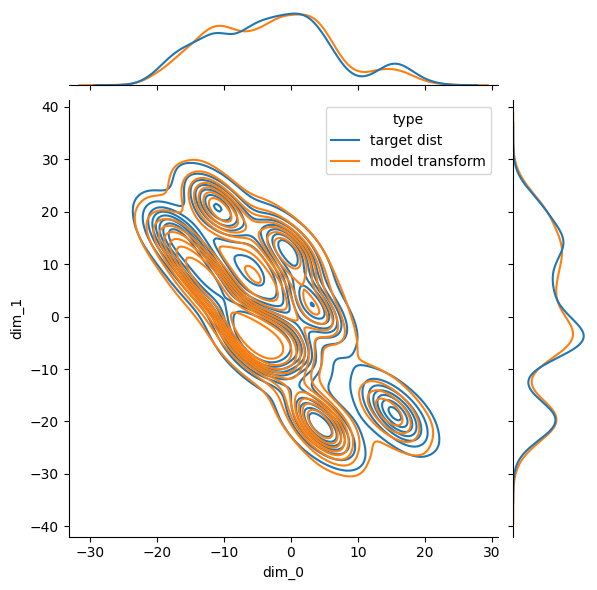

trail: 0 m step: 27 kl_test: 0.5684432983398438


  2%|▏         | 100/6000 [00:32<35:10,  2.80it/s]

trail: 0 m step: 28 Loss: 0.6685600280761719  L_n: 0.5527076721191406  kld: 0.0057926177978515625 KLD1: 0.5390768647193909 KLD2: 0.34823164343833923


  3%|▎         | 200/6000 [01:04<34:06,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6418724060058594  L_n: 0.5182380676269531  kld: 0.0061817169189453125 KLD1: 0.5004577040672302 KLD2: 0.3423788547515869


  5%|▌         | 300/6000 [01:36<33:28,  2.84it/s]

trail: 0 m step: 28 Loss: 0.6310672760009766  L_n: 0.5206699371337891  kld: 0.005519866943359375 KLD1: 0.5268990397453308 KLD2: 0.34319624304771423


  7%|▋         | 400/6000 [02:08<33:09,  2.81it/s]

trail: 0 m step: 28 Loss: 0.6488590240478516  L_n: 0.5216770172119141  kld: 0.006359100341796875 KLD1: 0.5344269275665283 KLD2: 0.3451556861400604


  8%|▊         | 500/6000 [02:40<32:34,  2.81it/s]

trail: 0 m step: 28 Loss: 0.6804752349853516  L_n: 0.5169391632080078  kld: 0.008176803588867188 KLD1: 0.5129483342170715 KLD2: 0.36171621084213257


 10%|█         | 600/6000 [03:12<31:49,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6961822509765625  L_n: 0.5229949951171875  kld: 0.00865936279296875 KLD1: 0.4870419204235077 KLD2: 0.35912689566612244


 12%|█▏        | 700/6000 [03:44<31:21,  2.82it/s]

trail: 0 m step: 28 Loss: 0.6620082855224609  L_n: 0.5102214813232422  kld: 0.0075893402099609375 KLD1: 0.501953125 KLD2: 0.3534943759441376


 13%|█▎        | 800/6000 [04:16<30:50,  2.81it/s]

trail: 0 m step: 28 Loss: 0.6586265563964844  L_n: 0.5036735534667969  kld: 0.007747650146484375 KLD1: 0.516041100025177 KLD2: 0.36965295672416687


 15%|█▌        | 900/6000 [04:49<30:06,  2.82it/s]

trail: 0 m step: 28 Loss: 0.6805248260498047  L_n: 0.5276699066162109  kld: 0.0076427459716796875 KLD1: 0.5131850242614746 KLD2: 0.3503575623035431


 17%|█▋        | 1000/6000 [05:21<29:31,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5928211212158203  L_n: 0.49367713928222656  kld: 0.0049571990966796875 KLD1: 0.5426065325737 KLD2: 0.3559805154800415


 18%|█▊        | 1100/6000 [05:53<28:48,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6345500946044922  L_n: 0.5054607391357422  kld: 0.0064544677734375 KLD1: 0.5441812872886658 KLD2: 0.3415839672088623


 20%|██        | 1200/6000 [06:25<28:13,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6384525299072266  L_n: 0.5304203033447266  kld: 0.005401611328125 KLD1: 0.5224579572677612 KLD2: 0.34947970509529114


 22%|██▏       | 1300/6000 [06:57<27:49,  2.82it/s]

trail: 0 m step: 28 Loss: 0.6220760345458984  L_n: 0.5114116668701172  kld: 0.0055332183837890625 KLD1: 0.5442097783088684 KLD2: 0.36357322335243225


 23%|██▎       | 1400/6000 [07:29<27:03,  2.83it/s]

trail: 0 m step: 28 Loss: 0.67022705078125  L_n: 0.5398406982421875  kld: 0.006519317626953125 KLD1: 0.51039719581604 KLD2: 0.34397387504577637


 25%|██▌       | 1500/6000 [08:01<26:29,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6310806274414062  L_n: 0.5130157470703125  kld: 0.0059032440185546875 KLD1: 0.5181859731674194 KLD2: 0.33693450689315796


 27%|██▋       | 1600/6000 [08:33<25:56,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6715183258056641  L_n: 0.5421619415283203  kld: 0.0064678192138671875 KLD1: 0.5159446001052856 KLD2: 0.35351619124412537


 28%|██▊       | 1700/6000 [09:05<25:22,  2.82it/s]

trail: 0 m step: 28 Loss: 0.7129421234130859  L_n: 0.5537166595458984  kld: 0.007961273193359375 KLD1: 0.5193960070610046 KLD2: 0.36343488097190857


 30%|███       | 1800/6000 [09:37<24:43,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6496410369873047  L_n: 0.5265026092529297  kld: 0.00615692138671875 KLD1: 0.5330851078033447 KLD2: 0.3451816141605377


 32%|███▏      | 1900/6000 [10:09<24:08,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6193122863769531  L_n: 0.5083808898925781  kld: 0.00554656982421875 KLD1: 0.5027815103530884 KLD2: 0.36324572563171387


 33%|███▎      | 2000/6000 [10:41<23:31,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6197013854980469  L_n: 0.5209388732910156  kld: 0.0049381256103515625 KLD1: 0.5317681431770325 KLD2: 0.3550933003425598


 35%|███▌      | 2100/6000 [11:13<23:11,  2.80it/s]

trail: 0 m step: 28 Loss: 0.5686435699462891  L_n: 0.49334144592285156  kld: 0.003765106201171875 KLD1: 0.5112419724464417 KLD2: 0.3620889186859131


 37%|███▋      | 2200/6000 [11:45<22:21,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6035385131835938  L_n: 0.5326995849609375  kld: 0.0035419464111328125 KLD1: 0.5032351613044739 KLD2: 0.3526102900505066


 38%|███▊      | 2300/6000 [12:17<21:50,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5860309600830078  L_n: 0.5080585479736328  kld: 0.00389862060546875 KLD1: 0.5215411186218262 KLD2: 0.3398996591567993


 40%|████      | 2400/6000 [12:49<21:15,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5801429748535156  L_n: 0.5210914611816406  kld: 0.00295257568359375 KLD1: 0.5080976486206055 KLD2: 0.3606429994106293


 42%|████▏     | 2500/6000 [13:21<20:37,  2.83it/s]

trail: 0 m step: 28 Loss: 0.5861282348632812  L_n: 0.5006027221679688  kld: 0.004276275634765625 KLD1: 0.5065672993659973 KLD2: 0.3471643328666687


 43%|████▎     | 2600/6000 [13:53<20:04,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5858955383300781  L_n: 0.4884681701660156  kld: 0.004871368408203125 KLD1: 0.4863230288028717 KLD2: 0.3430430591106415


 45%|████▌     | 2700/6000 [14:25<19:23,  2.84it/s]

trail: 0 m step: 28 Loss: 0.5914821624755859  L_n: 0.5220546722412109  kld: 0.00347137451171875 KLD1: 0.520393431186676 KLD2: 0.3508123457431793


 47%|████▋     | 2800/6000 [14:57<18:55,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5888862609863281  L_n: 0.5259819030761719  kld: 0.0031452178955078125 KLD1: 0.5352513194084167 KLD2: 0.34587201476097107


 48%|████▊     | 2900/6000 [15:29<18:13,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6025047302246094  L_n: 0.5241508483886719  kld: 0.003917694091796875 KLD1: 0.506937563419342 KLD2: 0.346762478351593


 50%|█████     | 3000/6000 [16:01<17:39,  2.83it/s]

trail: 0 m step: 28 Loss: 0.5599288940429688  L_n: 0.5117111206054688  kld: 0.002410888671875 KLD1: 0.5312584638595581 KLD2: 0.3482961356639862


 52%|█████▏    | 3100/6000 [16:34<17:06,  2.83it/s]

trail: 0 m step: 28 Loss: 0.5637836456298828  L_n: 0.5019092559814453  kld: 0.003093719482421875 KLD1: 0.4978383779525757 KLD2: 0.3492613136768341


 53%|█████▎    | 3200/6000 [17:06<16:31,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5811653137207031  L_n: 0.5096015930175781  kld: 0.00357818603515625 KLD1: 0.5105441212654114 KLD2: 0.3377045691013336


 55%|█████▌    | 3300/6000 [17:38<15:58,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5921916961669922  L_n: 0.5522899627685547  kld: 0.001995086669921875 KLD1: 0.5263310670852661 KLD2: 0.340302050113678


 57%|█████▋    | 3400/6000 [18:10<15:20,  2.83it/s]

trail: 0 m step: 28 Loss: 0.5872707366943359  L_n: 0.5012493133544922  kld: 0.0043010711669921875 KLD1: 0.5206920504570007 KLD2: 0.3515397906303406


 58%|█████▊    | 3500/6000 [18:42<14:43,  2.83it/s]

trail: 0 m step: 28 Loss: 0.6108932495117188  L_n: 0.5215530395507812  kld: 0.004467010498046875 KLD1: 0.4989370107650757 KLD2: 0.3435724377632141


 60%|██████    | 3600/6000 [19:14<14:07,  2.83it/s]

trail: 0 m step: 28 Loss: 0.5846099853515625  L_n: 0.49950408935546875  kld: 0.0042552947998046875 KLD1: 0.49504968523979187 KLD2: 0.36268875002861023


 62%|██████▏   | 3700/6000 [19:46<13:35,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5925788879394531  L_n: 0.5337562561035156  kld: 0.002941131591796875 KLD1: 0.5157403945922852 KLD2: 0.3538072109222412


 63%|██████▎   | 3800/6000 [20:18<13:00,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5947532653808594  L_n: 0.5341377258300781  kld: 0.0030307769775390625 KLD1: 0.5257474184036255 KLD2: 0.3354714810848236


 65%|██████▌   | 3900/6000 [20:50<12:29,  2.80it/s]

trail: 0 m step: 28 Loss: 0.6131744384765625  L_n: 0.51971435546875  kld: 0.004673004150390625 KLD1: 0.4916239082813263 KLD2: 0.3440721929073334


 67%|██████▋   | 4000/6000 [21:22<11:48,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5907096862792969  L_n: 0.4979743957519531  kld: 0.0046367645263671875 KLD1: 0.5007091164588928 KLD2: 0.3438282907009125


 68%|██████▊   | 4100/6000 [21:54<11:12,  2.82it/s]

trail: 0 m step: 28 Loss: 0.6004924774169922  L_n: 0.5246181488037109  kld: 0.0037937164306640625 KLD1: 0.47416433691978455 KLD2: 0.34266987442970276


 70%|███████   | 4200/6000 [22:27<10:38,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5807552337646484  L_n: 0.4895458221435547  kld: 0.0045604705810546875 KLD1: 0.5130988359451294 KLD2: 0.3441210985183716


 72%|███████▏  | 4300/6000 [22:59<10:03,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5765495300292969  L_n: 0.5176124572753906  kld: 0.0029468536376953125 KLD1: 0.5273763537406921 KLD2: 0.3561733067035675


 73%|███████▎  | 4400/6000 [23:31<09:26,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5205211639404297  L_n: 0.4855022430419922  kld: 0.001750946044921875 KLD1: 0.5151013731956482 KLD2: 0.340856671333313


 75%|███████▌  | 4500/6000 [24:03<08:52,  2.82it/s]

trail: 0 m step: 28 Loss: 0.6045074462890625  L_n: 0.5302352905273438  kld: 0.0037136077880859375 KLD1: 0.5146933794021606 KLD2: 0.3373149633407593


 77%|███████▋  | 4600/6000 [24:35<08:19,  2.80it/s]

trail: 0 m step: 28 Loss: 0.5467662811279297  L_n: 0.5011806488037109  kld: 0.0022792816162109375 KLD1: 0.5258890986442566 KLD2: 0.3606545329093933


 78%|███████▊  | 4700/6000 [25:07<07:42,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5353622436523438  L_n: 0.5120162963867188  kld: 0.00116729736328125 KLD1: 0.5351986289024353 KLD2: 0.34756767749786377


 80%|████████  | 4800/6000 [25:39<07:05,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5801448822021484  L_n: 0.5159435272216797  kld: 0.0032100677490234375 KLD1: 0.5073602199554443 KLD2: 0.3511813282966614


 82%|████████▏ | 4900/6000 [26:12<06:30,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5544338226318359  L_n: 0.5058345794677734  kld: 0.002429962158203125 KLD1: 0.5208414196968079 KLD2: 0.3401917815208435


 83%|████████▎ | 5000/6000 [26:44<05:53,  2.83it/s]

trail: 0 m step: 28 Loss: 0.5911750793457031  L_n: 0.5268592834472656  kld: 0.003215789794921875 KLD1: 0.5205254554748535 KLD2: 0.350895494222641


 85%|████████▌ | 5100/6000 [27:16<05:19,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5424785614013672  L_n: 0.5052852630615234  kld: 0.0018596649169921875 KLD1: 0.48854735493659973 KLD2: 0.3614277243614197


 87%|████████▋ | 5200/6000 [27:48<04:44,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5537033081054688  L_n: 0.5057525634765625  kld: 0.0023975372314453125 KLD1: 0.5004478096961975 KLD2: 0.3523663580417633


 88%|████████▊ | 5300/6000 [28:20<04:09,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5747241973876953  L_n: 0.5171604156494141  kld: 0.0028781890869140625 KLD1: 0.5172489881515503 KLD2: 0.3407514691352844


 90%|█████████ | 5400/6000 [28:52<03:33,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5894889831542969  L_n: 0.5221214294433594  kld: 0.003368377685546875 KLD1: 0.5159491300582886 KLD2: 0.3454391658306122


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5853958129882812  L_n: 0.5152816772460938  kld: 0.003505706787109375 KLD1: 0.49314287304878235 KLD2: 0.3537851870059967


 93%|█████████▎| 5600/6000 [29:56<02:21,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5937614440917969  L_n: 0.5280723571777344  kld: 0.003284454345703125 KLD1: 0.5199012756347656 KLD2: 0.34277960658073425


 95%|█████████▌| 5700/6000 [30:28<01:46,  2.81it/s]

trail: 0 m step: 28 Loss: 0.5654697418212891  L_n: 0.5084400177001953  kld: 0.0028514862060546875 KLD1: 0.5103288888931274 KLD2: 0.35337331891059875


 97%|█████████▋| 5800/6000 [31:00<01:10,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5621356964111328  L_n: 0.5206699371337891  kld: 0.0020732879638671875 KLD1: 0.5023804903030396 KLD2: 0.3409566879272461


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.82it/s]

trail: 0 m step: 28 Loss: 0.5652675628662109  L_n: 0.5234966278076172  kld: 0.0020885467529296875 KLD1: 0.5182068347930908 KLD2: 0.35999003052711487


100%|██████████| 6000/6000 [32:05<00:00,  3.12it/s]

trail: 0 m step: 28 Loss: 0.5883693695068359  L_n: 0.5486202239990234  kld: 0.001987457275390625 KLD1: 0.5152146220207214 KLD2: 0.35511350631713867



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


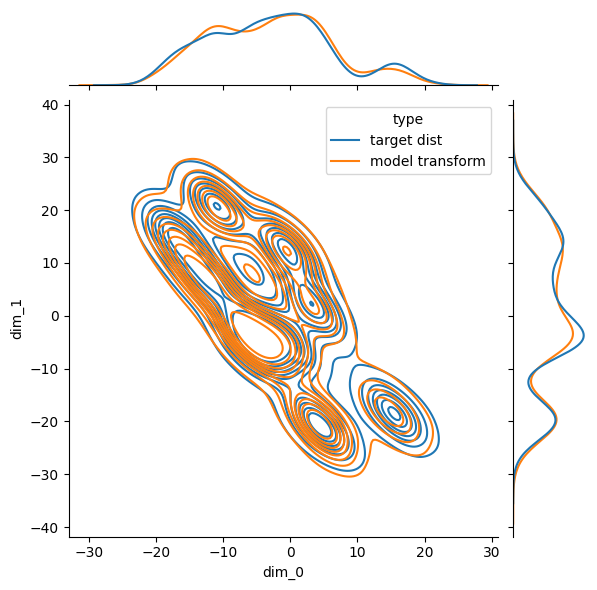

trail: 0 m step: 28 kl_test: 0.5533638000488281


  2%|▏         | 100/6000 [00:32<35:13,  2.79it/s]

trail: 0 m step: 29 Loss: 0.6126708984375  L_n: 0.5240554809570312  kld: 0.0044307708740234375 KLD1: 0.49589070677757263 KLD2: 0.33930882811546326


  3%|▎         | 200/6000 [01:04<34:15,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6383380889892578  L_n: 0.5021915435791016  kld: 0.0068073272705078125 KLD1: 0.4933350384235382 KLD2: 0.3341471254825592


  5%|▌         | 300/6000 [01:36<33:40,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5332412719726562  L_n: 0.48899078369140625  kld: 0.0022125244140625 KLD1: 0.500805139541626 KLD2: 0.33892834186553955


  7%|▋         | 400/6000 [02:08<33:08,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5845527648925781  L_n: 0.5139045715332031  kld: 0.00353240966796875 KLD1: 0.512706458568573 KLD2: 0.33340317010879517


  8%|▊         | 500/6000 [02:40<32:23,  2.83it/s]

trail: 0 m step: 29 Loss: 0.6211490631103516  L_n: 0.5142612457275391  kld: 0.005344390869140625 KLD1: 0.4654470980167389 KLD2: 0.34313008189201355


 10%|█         | 600/6000 [03:12<32:02,  2.81it/s]

trail: 0 m step: 29 Loss: 0.6462001800537109  L_n: 0.4900646209716797  kld: 0.0078067779541015625 KLD1: 0.5001517534255981 KLD2: 0.35030752420425415


 12%|█▏        | 700/6000 [03:44<31:16,  2.83it/s]

trail: 0 m step: 29 Loss: 0.6475734710693359  L_n: 0.49780845642089844  kld: 0.007488250732421875 KLD1: 0.48357918858528137 KLD2: 0.34666940569877625


 13%|█▎        | 800/6000 [04:16<30:44,  2.82it/s]

trail: 0 m step: 29 Loss: 0.633819580078125  L_n: 0.47882843017578125  kld: 0.0077495574951171875 KLD1: 0.5013673901557922 KLD2: 0.36046743392944336


 15%|█▌        | 900/6000 [04:48<30:07,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6152667999267578  L_n: 0.48209571838378906  kld: 0.0066585540771484375 KLD1: 0.4844245910644531 KLD2: 0.34232550859451294


 17%|█▋        | 1000/6000 [05:21<29:26,  2.83it/s]

trail: 0 m step: 29 Loss: 0.6294841766357422  L_n: 0.4860515594482422  kld: 0.007171630859375 KLD1: 0.5156723260879517 KLD2: 0.34219062328338623


 18%|█▊        | 1100/6000 [05:53<28:55,  2.82it/s]

trail: 0 m step: 29 Loss: 0.7017421722412109  L_n: 0.5037975311279297  kld: 0.009897232055664062 KLD1: 0.5134664177894592 KLD2: 0.33264973759651184


 20%|██        | 1200/6000 [06:25<28:20,  2.82it/s]

trail: 0 m step: 29 Loss: 0.8083133697509766  L_n: 0.5143909454345703  kld: 0.014696121215820312 KLD1: 0.49420610070228577 KLD2: 0.3408147990703583


 22%|██▏       | 1300/6000 [06:57<27:45,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6835193634033203  L_n: 0.47344398498535156  kld: 0.010503768920898438 KLD1: 0.5026137828826904 KLD2: 0.34339839220046997


 23%|██▎       | 1400/6000 [07:29<27:16,  2.81it/s]

trail: 0 m step: 29 Loss: 0.6189632415771484  L_n: 0.4980754852294922  kld: 0.0060443878173828125 KLD1: 0.48560190200805664 KLD2: 0.3289529085159302


 25%|██▌       | 1500/6000 [08:01<26:39,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5442390441894531  L_n: 0.4685554504394531  kld: 0.0037841796875 KLD1: 0.48998740315437317 KLD2: 0.319785475730896


 27%|██▋       | 1600/6000 [08:33<25:57,  2.83it/s]

trail: 0 m step: 29 Loss: 0.5899505615234375  L_n: 0.493438720703125  kld: 0.004825592041015625 KLD1: 0.4747574031352997 KLD2: 0.34230124950408936


 28%|██▊       | 1700/6000 [09:05<25:20,  2.83it/s]

trail: 0 m step: 29 Loss: 0.6826667785644531  L_n: 0.5266075134277344  kld: 0.0078029632568359375 KLD1: 0.49705755710601807 KLD2: 0.3513035178184509


 30%|███       | 1800/6000 [09:37<24:46,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6503829956054688  L_n: 0.5006561279296875  kld: 0.0074863433837890625 KLD1: 0.5000892281532288 KLD2: 0.32689666748046875


 32%|███▏      | 1900/6000 [10:09<24:11,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6518421173095703  L_n: 0.49440956115722656  kld: 0.007871627807617188 KLD1: 0.49916043877601624 KLD2: 0.3542189300060272


 33%|███▎      | 2000/6000 [10:42<23:36,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6175765991210938  L_n: 0.49527740478515625  kld: 0.006114959716796875 KLD1: 0.5082769989967346 KLD2: 0.3445318639278412


 35%|███▌      | 2100/6000 [11:14<23:05,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5792083740234375  L_n: 0.48406982421875  kld: 0.004756927490234375 KLD1: 0.4871397912502289 KLD2: 0.3468536138534546


 37%|███▋      | 2200/6000 [11:46<22:28,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5884761810302734  L_n: 0.49410057067871094  kld: 0.004718780517578125 KLD1: 0.4800395369529724 KLD2: 0.33829954266548157


 38%|███▊      | 2300/6000 [12:18<21:54,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5456714630126953  L_n: 0.49291419982910156  kld: 0.0026378631591796875 KLD1: 0.5023302435874939 KLD2: 0.3262019157409668


 40%|████      | 2400/6000 [12:50<21:15,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5801792144775391  L_n: 0.4846210479736328  kld: 0.0047779083251953125 KLD1: 0.48201772570610046 KLD2: 0.3406014144420624


 42%|████▏     | 2500/6000 [13:22<20:40,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6045703887939453  L_n: 0.5007343292236328  kld: 0.005191802978515625 KLD1: 0.4864098131656647 KLD2: 0.33332711458206177


 43%|████▎     | 2600/6000 [13:54<20:01,  2.83it/s]

trail: 0 m step: 29 Loss: 0.58258056640625  L_n: 0.48992156982421875  kld: 0.0046329498291015625 KLD1: 0.4848056435585022 KLD2: 0.33036091923713684


 45%|████▌     | 2700/6000 [14:26<19:28,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5885334014892578  L_n: 0.4959125518798828  kld: 0.00463104248046875 KLD1: 0.49969834089279175 KLD2: 0.33466005325317383


 47%|████▋     | 2800/6000 [14:58<18:58,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5989398956298828  L_n: 0.5053653717041016  kld: 0.0046787261962890625 KLD1: 0.5037310123443604 KLD2: 0.3295670747756958


 48%|████▊     | 2900/6000 [15:31<18:22,  2.81it/s]

trail: 0 m step: 29 Loss: 0.6348228454589844  L_n: 0.5091667175292969  kld: 0.006282806396484375 KLD1: 0.4824353754520416 KLD2: 0.33177265524864197


 50%|█████     | 3000/6000 [16:03<17:43,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5991439819335938  L_n: 0.506256103515625  kld: 0.0046443939208984375 KLD1: 0.5215654373168945 KLD2: 0.34006616473197937


 52%|█████▏    | 3100/6000 [16:35<17:09,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5776004791259766  L_n: 0.47681617736816406  kld: 0.005039215087890625 KLD1: 0.4666353464126587 KLD2: 0.33924686908721924


 53%|█████▎    | 3200/6000 [17:07<16:28,  2.83it/s]

trail: 0 m step: 29 Loss: 0.6132526397705078  L_n: 0.48732948303222656  kld: 0.0062961578369140625 KLD1: 0.4827720522880554 KLD2: 0.3280283510684967


 55%|█████▌    | 3300/6000 [17:39<15:53,  2.83it/s]

trail: 0 m step: 29 Loss: 0.6070423126220703  L_n: 0.5053424835205078  kld: 0.005084991455078125 KLD1: 0.49788007140159607 KLD2: 0.3284892439842224


 57%|█████▋    | 3400/6000 [18:11<15:23,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5736045837402344  L_n: 0.4734306335449219  kld: 0.005008697509765625 KLD1: 0.4856375753879547 KLD2: 0.33981767296791077


 58%|█████▊    | 3500/6000 [18:43<14:47,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6060409545898438  L_n: 0.5036163330078125  kld: 0.0051212310791015625 KLD1: 0.4765356183052063 KLD2: 0.33127930760383606


 60%|██████    | 3600/6000 [19:15<14:08,  2.83it/s]

trail: 0 m step: 29 Loss: 0.555419921875  L_n: 0.46619415283203125  kld: 0.0044612884521484375 KLD1: 0.47422635555267334 KLD2: 0.34712058305740356


 62%|██████▏   | 3700/6000 [19:47<13:35,  2.82it/s]

trail: 0 m step: 29 Loss: 0.6069927215576172  L_n: 0.5022029876708984  kld: 0.0052394866943359375 KLD1: 0.4842239022254944 KLD2: 0.3390372097492218


 63%|██████▎   | 3800/6000 [20:19<12:56,  2.83it/s]

trail: 0 m step: 29 Loss: 0.5768489837646484  L_n: 0.5022335052490234  kld: 0.00373077392578125 KLD1: 0.4814133048057556 KLD2: 0.32143276929855347


 65%|██████▌   | 3900/6000 [20:51<12:23,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5849037170410156  L_n: 0.4827842712402344  kld: 0.0051059722900390625 KLD1: 0.47745174169540405 KLD2: 0.33075329661369324


 67%|██████▋   | 4000/6000 [21:23<11:48,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5844192504882812  L_n: 0.48401641845703125  kld: 0.0050201416015625 KLD1: 0.48164892196655273 KLD2: 0.3325287401676178


 68%|██████▊   | 4100/6000 [21:56<11:11,  2.83it/s]

trail: 0 m step: 29 Loss: 0.5515842437744141  L_n: 0.5015354156494141  kld: 0.00250244140625 KLD1: 0.4515764117240906 KLD2: 0.3337044417858124


 70%|███████   | 4200/6000 [22:28<10:38,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5524063110351562  L_n: 0.47267913818359375  kld: 0.003986358642578125 KLD1: 0.48865145444869995 KLD2: 0.3329654633998871


 72%|███████▏  | 4300/6000 [23:00<09:57,  2.84it/s]

trail: 0 m step: 29 Loss: 0.5772247314453125  L_n: 0.5114974975585938  kld: 0.0032863616943359375 KLD1: 0.48474130034446716 KLD2: 0.3409721553325653


 73%|███████▎  | 4400/6000 [23:32<09:27,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5443630218505859  L_n: 0.4755077362060547  kld: 0.0034427642822265625 KLD1: 0.4815213680267334 KLD2: 0.3276534974575043


 75%|███████▌  | 4500/6000 [24:04<08:51,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5795631408691406  L_n: 0.5010948181152344  kld: 0.0039234161376953125 KLD1: 0.4845356345176697 KLD2: 0.3244856297969818


 77%|███████▋  | 4600/6000 [24:36<08:14,  2.83it/s]

trail: 0 m step: 29 Loss: 0.5312442779541016  L_n: 0.47448158264160156  kld: 0.002838134765625 KLD1: 0.4938250482082367 KLD2: 0.34535327553749084


 78%|███████▊  | 4700/6000 [25:08<07:41,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5248813629150391  L_n: 0.4985980987548828  kld: 0.0013141632080078125 KLD1: 0.5013706088066101 KLD2: 0.3326400816440582


 80%|████████  | 4800/6000 [25:40<07:05,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5544033050537109  L_n: 0.5038204193115234  kld: 0.002529144287109375 KLD1: 0.4775734841823578 KLD2: 0.3376396894454956


 82%|████████▏ | 4900/6000 [26:12<06:31,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5451927185058594  L_n: 0.4813728332519531  kld: 0.0031909942626953125 KLD1: 0.49563026428222656 KLD2: 0.32673704624176025


 83%|████████▎ | 5000/6000 [26:44<05:52,  2.84it/s]

trail: 0 m step: 29 Loss: 0.5993824005126953  L_n: 0.5129413604736328  kld: 0.004322052001953125 KLD1: 0.4885759651660919 KLD2: 0.337697833776474


 85%|████████▌ | 5100/6000 [27:16<05:21,  2.80it/s]

trail: 0 m step: 29 Loss: 0.5357131958007812  L_n: 0.48719024658203125  kld: 0.0024261474609375 KLD1: 0.4850192368030548 KLD2: 0.34713250398635864


 87%|████████▋ | 5200/6000 [27:48<04:42,  2.83it/s]

trail: 0 m step: 29 Loss: 0.5488624572753906  L_n: 0.4756584167480469  kld: 0.0036602020263671875 KLD1: 0.4826761484146118 KLD2: 0.3375610411167145


 88%|████████▊ | 5300/6000 [28:20<04:08,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5610713958740234  L_n: 0.49339866638183594  kld: 0.003383636474609375 KLD1: 0.4991004765033722 KLD2: 0.3281852602958679


 90%|█████████ | 5400/6000 [28:52<03:32,  2.82it/s]

trail: 0 m step: 29 Loss: 0.5560264587402344  L_n: 0.4995307922363281  kld: 0.0028247833251953125 KLD1: 0.49194836616516113 KLD2: 0.32971668243408203


 92%|█████████▏| 5500/6000 [29:25<02:57,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5689945220947266  L_n: 0.4883899688720703  kld: 0.0040302276611328125 KLD1: 0.4663340747356415 KLD2: 0.33826255798339844


 93%|█████████▎| 5600/6000 [29:57<02:22,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5492515563964844  L_n: 0.5023689270019531  kld: 0.0023441314697265625 KLD1: 0.49897685647010803 KLD2: 0.32616785168647766


 95%|█████████▌| 5700/6000 [30:29<01:46,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5383663177490234  L_n: 0.4889659881591797  kld: 0.0024700164794921875 KLD1: 0.47266921401023865 KLD2: 0.3349808156490326


 97%|█████████▋| 5800/6000 [31:01<01:11,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5545692443847656  L_n: 0.4947929382324219  kld: 0.0029888153076171875 KLD1: 0.4695070683956146 KLD2: 0.3244170844554901


 98%|█████████▊| 5900/6000 [31:33<00:35,  2.81it/s]

trail: 0 m step: 29 Loss: 0.5267086029052734  L_n: 0.47948265075683594  kld: 0.002361297607421875 KLD1: 0.4827130138874054 KLD2: 0.34345686435699463


100%|██████████| 6000/6000 [32:05<00:00,  3.12it/s]

trail: 0 m step: 29 Loss: 0.5563869476318359  L_n: 0.5161800384521484  kld: 0.002010345458984375 KLD1: 0.49253278970718384 KLD2: 0.34093812108039856



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


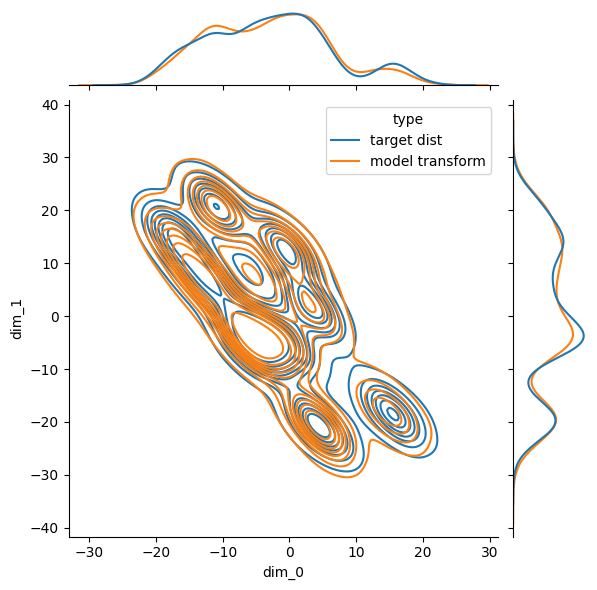

trail: 0 m step: 29 kl_test: 0.5312957763671875


  2%|▏         | 100/6000 [00:32<35:19,  2.78it/s]

trail: 0 m step: 30 Loss: 0.5129184722900391  L_n: 0.49338722229003906  kld: 0.0009765625 KLD1: 0.4647374749183655 KLD2: 0.32439520955085754


  3%|▎         | 200/6000 [01:04<34:32,  2.80it/s]

trail: 0 m step: 30 Loss: 0.5347652435302734  L_n: 0.48349571228027344  kld: 0.0025634765625 KLD1: 0.46974119544029236 KLD2: 0.32902953028678894


  5%|▌         | 300/6000 [01:36<33:53,  2.80it/s]

trail: 0 m step: 30 Loss: 0.4970836639404297  L_n: 0.48338890075683594  kld: 0.0006847381591796875 KLD1: 0.46185970306396484 KLD2: 0.32263705134391785


  7%|▋         | 400/6000 [02:08<33:08,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5157947540283203  L_n: 0.4886341094970703  kld: 0.0013580322265625 KLD1: 0.48861992359161377 KLD2: 0.3169129192829132


  8%|▊         | 500/6000 [02:40<32:33,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5194301605224609  L_n: 0.47395896911621094  kld: 0.0022735595703125 KLD1: 0.45176345109939575 KLD2: 0.32585492730140686


 10%|█         | 600/6000 [03:13<31:54,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5195636749267578  L_n: 0.4718799591064453  kld: 0.002384185791015625 KLD1: 0.4740055203437805 KLD2: 0.3268882632255554


 12%|█▏        | 700/6000 [03:45<31:19,  2.82it/s]

trail: 0 m step: 30 Loss: 0.4974365234375  L_n: 0.45223236083984375  kld: 0.0022602081298828125 KLD1: 0.4420599639415741 KLD2: 0.3286808431148529


 13%|█▎        | 800/6000 [04:17<30:40,  2.83it/s]

trail: 0 m step: 30 Loss: 0.474273681640625  L_n: 0.44329833984375  kld: 0.00154876708984375 KLD1: 0.4620492160320282 KLD2: 0.3426252007484436


 15%|█▌        | 900/6000 [04:49<30:11,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5228233337402344  L_n: 0.4686927795410156  kld: 0.0027065277099609375 KLD1: 0.4604993462562561 KLD2: 0.3230631351470947


 17%|█▋        | 1000/6000 [05:21<29:32,  2.82it/s]

trail: 0 m step: 30 Loss: 0.4552783966064453  L_n: 0.4380359649658203  kld: 0.00086212158203125 KLD1: 0.47370341420173645 KLD2: 0.32055220007896423


 18%|█▊        | 1100/6000 [05:53<28:55,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5065898895263672  L_n: 0.47557640075683594  kld: 0.0015506744384765625 KLD1: 0.48411908745765686 KLD2: 0.3115937411785126


 20%|██        | 1200/6000 [06:25<28:27,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5259628295898438  L_n: 0.49018096923828125  kld: 0.001789093017578125 KLD1: 0.48004159331321716 KLD2: 0.32577431201934814


 22%|██▏       | 1300/6000 [06:57<27:49,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5097675323486328  L_n: 0.4748249053955078  kld: 0.00174713134765625 KLD1: 0.4879494905471802 KLD2: 0.32397815585136414


 23%|██▎       | 1400/6000 [07:30<27:08,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5451774597167969  L_n: 0.4781150817871094  kld: 0.003353118896484375 KLD1: 0.44365495443344116 KLD2: 0.3080117106437683


 25%|██▌       | 1500/6000 [08:02<26:35,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5111103057861328  L_n: 0.47757911682128906  kld: 0.0016765594482421875 KLD1: 0.4882638156414032 KLD2: 0.30982109904289246


 27%|██▋       | 1600/6000 [08:34<25:57,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5004062652587891  L_n: 0.47446632385253906  kld: 0.0012969970703125 KLD1: 0.4603657126426697 KLD2: 0.3240671753883362


 28%|██▊       | 1700/6000 [09:06<25:24,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5448837280273438  L_n: 0.49140167236328125  kld: 0.002674102783203125 KLD1: 0.45273151993751526 KLD2: 0.32822495698928833


 30%|███       | 1800/6000 [09:38<24:50,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5141849517822266  L_n: 0.47573280334472656  kld: 0.001922607421875 KLD1: 0.49230048060417175 KLD2: 0.3139346241950989


 32%|███▏      | 1900/6000 [10:10<24:15,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5009803771972656  L_n: 0.4548988342285156  kld: 0.0023040771484375 KLD1: 0.4515927731990814 KLD2: 0.3319729268550873


 33%|███▎      | 2000/6000 [10:42<23:42,  2.81it/s]

trail: 0 m step: 30 Loss: 0.4986438751220703  L_n: 0.44985389709472656  kld: 0.0024394989013671875 KLD1: 0.47506004571914673 KLD2: 0.32554519176483154


 35%|███▌      | 2100/6000 [11:14<22:59,  2.83it/s]

trail: 0 m step: 30 Loss: 0.5026092529296875  L_n: 0.4678192138671875  kld: 0.001739501953125 KLD1: 0.47109267115592957 KLD2: 0.33273208141326904


 37%|███▋      | 2200/6000 [11:47<22:36,  2.80it/s]

trail: 0 m step: 30 Loss: 0.5163059234619141  L_n: 0.48449134826660156  kld: 0.001590728759765625 KLD1: 0.45823660492897034 KLD2: 0.3306359648704529


 38%|███▊      | 2300/6000 [12:19<21:51,  2.82it/s]

trail: 0 m step: 30 Loss: 0.49397850036621094  L_n: 0.4715862274169922  kld: 0.0011196136474609375 KLD1: 0.48500072956085205 KLD2: 0.3142207860946655


 40%|████      | 2400/6000 [12:51<21:18,  2.82it/s]

trail: 0 m step: 30 Loss: 0.4846935272216797  L_n: 0.45764732360839844  kld: 0.0013523101806640625 KLD1: 0.4495322108268738 KLD2: 0.32866182923316956


 42%|████▏     | 2500/6000 [13:23<20:43,  2.82it/s]

trail: 0 m step: 30 Loss: 0.49721717834472656  L_n: 0.46257972717285156  kld: 0.00173187255859375 KLD1: 0.4633426070213318 KLD2: 0.3181179165840149


 43%|████▎     | 2600/6000 [13:55<20:02,  2.83it/s]

trail: 0 m step: 30 Loss: 0.473907470703125  L_n: 0.442474365234375  kld: 0.0015716552734375 KLD1: 0.4448073208332062 KLD2: 0.3163681924343109


 45%|████▌     | 2700/6000 [14:27<19:33,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5047988891601562  L_n: 0.4679107666015625  kld: 0.0018444061279296875 KLD1: 0.4753838777542114 KLD2: 0.31631365418434143


 47%|████▋     | 2800/6000 [14:59<18:59,  2.81it/s]

trail: 0 m step: 30 Loss: 0.4836463928222656  L_n: 0.4696846008300781  kld: 0.000698089599609375 KLD1: 0.48062968254089355 KLD2: 0.31341737508773804


 48%|████▊     | 2900/6000 [15:32<18:22,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5227909088134766  L_n: 0.48700904846191406  kld: 0.001789093017578125 KLD1: 0.46203532814979553 KLD2: 0.32042473554611206


 50%|█████     | 3000/6000 [16:04<17:46,  2.81it/s]

trail: 0 m step: 30 Loss: 0.47390174865722656  L_n: 0.45406532287597656  kld: 0.0009918212890625 KLD1: 0.4776906967163086 KLD2: 0.3162989318370819


 52%|█████▏    | 3100/6000 [16:36<17:10,  2.81it/s]

trail: 0 m step: 30 Loss: 0.4854278564453125  L_n: 0.45967864990234375  kld: 0.0012874603271484375 KLD1: 0.4439922869205475 KLD2: 0.3269294798374176


 53%|█████▎    | 3200/6000 [17:08<16:32,  2.82it/s]

trail: 0 m step: 30 Loss: 0.49630165100097656  L_n: 0.47356605529785156  kld: 0.00113677978515625 KLD1: 0.46227556467056274 KLD2: 0.3149411380290985


 55%|█████▌    | 3300/6000 [17:40<15:57,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5051593780517578  L_n: 0.4902820587158203  kld: 0.000743865966796875 KLD1: 0.4577969014644623 KLD2: 0.3159515857696533


 57%|█████▋    | 3400/6000 [18:12<15:22,  2.82it/s]

trail: 0 m step: 30 Loss: 0.4863910675048828  L_n: 0.46178627014160156  kld: 0.0012302398681640625 KLD1: 0.4522096514701843 KLD2: 0.32361868023872375


 58%|█████▊    | 3500/6000 [18:44<14:47,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5264453887939453  L_n: 0.4764728546142578  kld: 0.002498626708984375 KLD1: 0.4528460204601288 KLD2: 0.3123489320278168


 60%|██████    | 3600/6000 [19:16<14:12,  2.82it/s]

trail: 0 m step: 30 Loss: 0.4945716857910156  L_n: 0.4566917419433594  kld: 0.0018939971923828125 KLD1: 0.4553074240684509 KLD2: 0.3362944722175598


 62%|██████▏   | 3700/6000 [19:48<13:38,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5190143585205078  L_n: 0.4765949249267578  kld: 0.0021209716796875 KLD1: 0.4378074109554291 KLD2: 0.32696670293807983


 63%|██████▎   | 3800/6000 [20:21<13:03,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5056171417236328  L_n: 0.4660205841064453  kld: 0.001979827880859375 KLD1: 0.45533186197280884 KLD2: 0.30395081639289856


 65%|██████▌   | 3900/6000 [20:53<12:23,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5023708343505859  L_n: 0.46971702575683594  kld: 0.0016326904296875 KLD1: 0.4448089301586151 KLD2: 0.3153313994407654


 67%|██████▋   | 4000/6000 [21:25<11:48,  2.82it/s]

trail: 0 m step: 30 Loss: 0.4918022155761719  L_n: 0.4605216979980469  kld: 0.00156402587890625 KLD1: 0.47988206148147583 KLD2: 0.32184073328971863


 68%|██████▊   | 4100/6000 [21:57<11:15,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5140342712402344  L_n: 0.4674186706542969  kld: 0.002330780029296875 KLD1: 0.43131887912750244 KLD2: 0.3220021426677704


 70%|███████   | 4200/6000 [22:29<10:39,  2.81it/s]

trail: 0 m step: 30 Loss: 0.48914337158203125  L_n: 0.45595550537109375  kld: 0.001659393310546875 KLD1: 0.4576921761035919 KLD2: 0.32006770372390747


 72%|███████▏  | 4300/6000 [23:01<10:01,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5105857849121094  L_n: 0.4876594543457031  kld: 0.0011463165283203125 KLD1: 0.4709884524345398 KLD2: 0.3316528797149658


 73%|███████▎  | 4400/6000 [23:33<09:25,  2.83it/s]

trail: 0 m step: 30 Loss: 0.4918212890625  L_n: 0.46385955810546875  kld: 0.0013980865478515625 KLD1: 0.4553837776184082 KLD2: 0.31608816981315613


 75%|███████▌  | 4500/6000 [24:05<08:55,  2.80it/s]

trail: 0 m step: 30 Loss: 0.5008468627929688  L_n: 0.4802093505859375  kld: 0.0010318756103515625 KLD1: 0.47068339586257935 KLD2: 0.31918421387672424


 77%|███████▋  | 4600/6000 [24:37<08:15,  2.83it/s]

trail: 0 m step: 30 Loss: 0.4923839569091797  L_n: 0.46587181091308594  kld: 0.0013256072998046875 KLD1: 0.46030858159065247 KLD2: 0.33203402161598206


 78%|███████▊  | 4700/6000 [25:09<07:41,  2.82it/s]

trail: 0 m step: 30 Loss: 0.47064208984375  L_n: 0.468658447265625  kld: 9.918212890625e-05 KLD1: 0.4847717583179474 KLD2: 0.3195614516735077


 80%|████████  | 4800/6000 [25:42<07:05,  2.82it/s]

trail: 0 m step: 30 Loss: 0.48784828186035156  L_n: 0.46991920471191406  kld: 0.000896453857421875 KLD1: 0.46894335746765137 KLD2: 0.3244485855102539


 82%|████████▏ | 4900/6000 [26:14<06:27,  2.84it/s]

trail: 0 m step: 30 Loss: 0.4723358154296875  L_n: 0.45154571533203125  kld: 0.0010395050048828125 KLD1: 0.47347092628479004 KLD2: 0.3141232430934906


 83%|████████▎ | 5000/6000 [26:46<05:54,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5051174163818359  L_n: 0.4850902557373047  kld: 0.0010013580322265625 KLD1: 0.4848825931549072 KLD2: 0.3246637284755707


 85%|████████▌ | 5100/6000 [27:18<05:20,  2.81it/s]

trail: 0 m step: 30 Loss: 0.47983741760253906  L_n: 0.46511268615722656  kld: 0.000736236572265625 KLD1: 0.4645351469516754 KLD2: 0.33632153272628784


 87%|████████▋ | 5200/6000 [27:50<04:42,  2.83it/s]

trail: 0 m step: 30 Loss: 0.500732421875  L_n: 0.46735382080078125  kld: 0.0016689300537109375 KLD1: 0.4587545692920685 KLD2: 0.3259003162384033


 88%|████████▊ | 5300/6000 [28:22<04:08,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5006027221679688  L_n: 0.4695892333984375  kld: 0.0015506744384765625 KLD1: 0.4631342589855194 KLD2: 0.31627514958381653


 90%|█████████ | 5400/6000 [28:54<03:33,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5094871520996094  L_n: 0.4724082946777344  kld: 0.00185394287109375 KLD1: 0.4803018569946289 KLD2: 0.31705936789512634


 92%|█████████▏| 5500/6000 [29:26<02:58,  2.81it/s]

trail: 0 m step: 30 Loss: 0.5088329315185547  L_n: 0.48346519470214844  kld: 0.0012683868408203125 KLD1: 0.4751668870449066 KLD2: 0.32929855585098267


 93%|█████████▎| 5600/6000 [29:58<02:22,  2.80it/s]

trail: 0 m step: 30 Loss: 0.5005416870117188  L_n: 0.46552276611328125  kld: 0.001750946044921875 KLD1: 0.46680107712745667 KLD2: 0.3137829899787903


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.82it/s]

trail: 0 m step: 30 Loss: 0.5033283233642578  L_n: 0.47033119201660156  kld: 0.0016498565673828125 KLD1: 0.4441068172454834 KLD2: 0.32039934396743774


 97%|█████████▋| 5800/6000 [31:03<01:11,  2.81it/s]

trail: 0 m step: 30 Loss: 0.4908123016357422  L_n: 0.4690685272216797  kld: 0.001087188720703125 KLD1: 0.44554051756858826 KLD2: 0.31444305181503296


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.82it/s]

trail: 0 m step: 30 Loss: 0.48483848571777344  L_n: 0.4674053192138672  kld: 0.0008716583251953125 KLD1: 0.47260263562202454 KLD2: 0.3303830623626709


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 30 Loss: 0.4966449737548828  L_n: 0.4800891876220703  kld: 0.000827789306640625 KLD1: 0.46352049708366394 KLD2: 0.3222917914390564



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


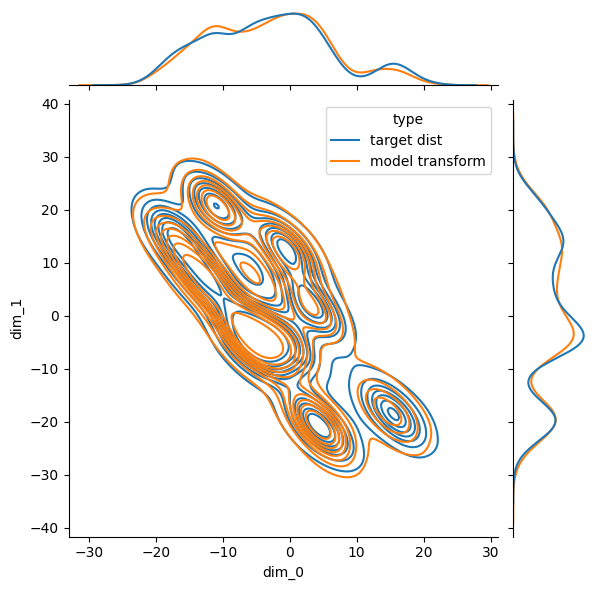

trail: 0 m step: 30 kl_test: 0.4995136260986328


  2%|▏         | 100/6000 [00:31<35:11,  2.79it/s]

trail: 0 m step: 31 Loss: 0.4727191925048828  L_n: 0.45238685607910156  kld: 0.0010166168212890625 KLD1: 0.43899300694465637 KLD2: 0.30971795320510864


  3%|▎         | 200/6000 [01:04<34:11,  2.83it/s]

trail: 0 m step: 31 Loss: 0.5100574493408203  L_n: 0.45134925842285156  kld: 0.0029354095458984375 KLD1: 0.43634170293807983 KLD2: 0.31235119700431824


  5%|▌         | 300/6000 [01:36<33:38,  2.82it/s]

trail: 0 m step: 31 Loss: 0.460357666015625  L_n: 0.45238494873046875  kld: 0.0003986358642578125 KLD1: 0.4565969705581665 KLD2: 0.3069900572299957


  7%|▋         | 400/6000 [02:08<32:50,  2.84it/s]

trail: 0 m step: 31 Loss: 0.4896965026855469  L_n: 0.4583778381347656  kld: 0.0015659332275390625 KLD1: 0.46121570467948914 KLD2: 0.29866817593574524


  8%|▊         | 500/6000 [02:40<32:21,  2.83it/s]

trail: 0 m step: 31 Loss: 0.49491119384765625  L_n: 0.44295501708984375  kld: 0.002597808837890625 KLD1: 0.43312981724739075 KLD2: 0.31110134720802307


 10%|█         | 600/6000 [03:12<31:51,  2.82it/s]

trail: 0 m step: 31 Loss: 0.48822975158691406  L_n: 0.44962501525878906  kld: 0.00193023681640625 KLD1: 0.4453791379928589 KLD2: 0.3145349323749542


 12%|█▏        | 700/6000 [03:44<31:12,  2.83it/s]

trail: 0 m step: 31 Loss: 0.5042209625244141  L_n: 0.4407825469970703  kld: 0.0031719207763671875 KLD1: 0.43917977809906006 KLD2: 0.3128809928894043


 13%|█▎        | 800/6000 [04:16<30:45,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4599342346191406  L_n: 0.4223594665527344  kld: 0.0018787384033203125 KLD1: 0.43519362807273865 KLD2: 0.32677361369132996


 15%|█▌        | 900/6000 [04:48<30:11,  2.82it/s]

trail: 0 m step: 31 Loss: 0.48686790466308594  L_n: 0.4327373504638672  kld: 0.0027065277099609375 KLD1: 0.44639715552330017 KLD2: 0.30727651715278625


 17%|█▋        | 1000/6000 [05:20<29:38,  2.81it/s]

trail: 0 m step: 31 Loss: 0.4381427764892578  L_n: 0.42055702209472656  kld: 0.0008792877197265625 KLD1: 0.45749789476394653 KLD2: 0.3027867078781128


 18%|█▊        | 1100/6000 [05:53<28:55,  2.82it/s]

trail: 0 m step: 31 Loss: 0.457763671875  L_n: 0.4296112060546875  kld: 0.001407623291015625 KLD1: 0.4496007561683655 KLD2: 0.29509708285331726


 20%|██        | 1200/6000 [06:25<28:27,  2.81it/s]

trail: 0 m step: 31 Loss: 0.4985065460205078  L_n: 0.45795631408691406  kld: 0.0020275115966796875 KLD1: 0.4331536591053009 KLD2: 0.30959028005599976


 22%|██▏       | 1300/6000 [06:57<27:44,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4696540832519531  L_n: 0.4400901794433594  kld: 0.0014781951904296875 KLD1: 0.4490191638469696 KLD2: 0.3084680140018463


 23%|██▎       | 1400/6000 [07:29<27:10,  2.82it/s]

trail: 0 m step: 31 Loss: 0.5028133392333984  L_n: 0.4533367156982422  kld: 0.0024738311767578125 KLD1: 0.42780789732933044 KLD2: 0.2930724322795868


 25%|██▌       | 1500/6000 [08:01<26:41,  2.81it/s]

trail: 0 m step: 31 Loss: 0.4983692169189453  L_n: 0.4593830108642578  kld: 0.001949310302734375 KLD1: 0.4533819258213043 KLD2: 0.29520273208618164


 27%|██▋       | 1600/6000 [08:33<25:58,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4654407501220703  L_n: 0.44442176818847656  kld: 0.0010509490966796875 KLD1: 0.4465904235839844 KLD2: 0.30882737040519714


 28%|██▊       | 1700/6000 [09:05<25:25,  2.82it/s]

trail: 0 m step: 31 Loss: 0.5252513885498047  L_n: 0.4693279266357422  kld: 0.002796173095703125 KLD1: 0.4373840093612671 KLD2: 0.3135378956794739


 30%|███       | 1800/6000 [09:37<24:49,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4870262145996094  L_n: 0.4377403259277344  kld: 0.00246429443359375 KLD1: 0.4655871093273163 KLD2: 0.3025747537612915


 32%|███▏      | 1900/6000 [10:09<24:16,  2.81it/s]

trail: 0 m step: 31 Loss: 0.471343994140625  L_n: 0.42552947998046875  kld: 0.0022907257080078125 KLD1: 0.4470374882221222 KLD2: 0.31858593225479126


 33%|███▎      | 2000/6000 [10:42<23:35,  2.83it/s]

trail: 0 m step: 31 Loss: 0.4846782684326172  L_n: 0.42955589294433594  kld: 0.0027561187744140625 KLD1: 0.468490332365036 KLD2: 0.31178125739097595


 35%|███▌      | 2100/6000 [11:14<23:05,  2.82it/s]

trail: 0 m step: 31 Loss: 0.480133056640625  L_n: 0.440765380859375  kld: 0.0019683837890625 KLD1: 0.4449668228626251 KLD2: 0.3189936578273773


 37%|███▋      | 2200/6000 [11:46<22:27,  2.82it/s]

trail: 0 m step: 31 Loss: 0.5120353698730469  L_n: 0.4660301208496094  kld: 0.002300262451171875 KLD1: 0.44170939922332764 KLD2: 0.3168250024318695


 38%|███▊      | 2300/6000 [12:18<21:51,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4716205596923828  L_n: 0.4504871368408203  kld: 0.001056671142578125 KLD1: 0.4560639560222626 KLD2: 0.30021563172340393


 40%|████      | 2400/6000 [12:50<21:22,  2.81it/s]

trail: 0 m step: 31 Loss: 0.4629631042480469  L_n: 0.4364128112792969  kld: 0.0013275146484375 KLD1: 0.4561831057071686 KLD2: 0.3137070834636688


 42%|████▏     | 2500/6000 [13:22<20:43,  2.81it/s]

trail: 0 m step: 31 Loss: 0.5080471038818359  L_n: 0.45815086364746094  kld: 0.00249481201171875 KLD1: 0.4402715563774109 KLD2: 0.3054210841655731


 43%|████▎     | 2600/6000 [13:54<19:57,  2.84it/s]

trail: 0 m step: 31 Loss: 0.49221229553222656  L_n: 0.42980384826660156  kld: 0.00312042236328125 KLD1: 0.44252678751945496 KLD2: 0.3051231801509857


 45%|████▌     | 2700/6000 [14:26<19:30,  2.82it/s]

trail: 0 m step: 31 Loss: 0.47262001037597656  L_n: 0.43882179260253906  kld: 0.001689910888671875 KLD1: 0.44539743661880493 KLD2: 0.30321747064590454


 47%|████▋     | 2800/6000 [14:59<18:55,  2.82it/s]

trail: 0 m step: 31 Loss: 0.47757720947265625  L_n: 0.4525909423828125  kld: 0.0012493133544921875 KLD1: 0.45875823497772217 KLD2: 0.29954084753990173


 48%|████▊     | 2900/6000 [15:31<19:20,  2.67it/s]

trail: 0 m step: 31 Loss: 0.4720458984375  L_n: 0.44492340087890625  kld: 0.0013561248779296875 KLD1: 0.4421209394931793 KLD2: 0.3079541027545929


 50%|█████     | 3000/6000 [16:03<17:45,  2.81it/s]

trail: 0 m step: 31 Loss: 0.46967506408691406  L_n: 0.4421710968017578  kld: 0.0013751983642578125 KLD1: 0.4617747962474823 KLD2: 0.3024878203868866


 52%|█████▏    | 3100/6000 [16:35<17:09,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4708099365234375  L_n: 0.43415069580078125  kld: 0.0018329620361328125 KLD1: 0.4173159599304199 KLD2: 0.3133436441421509


 53%|█████▎    | 3200/6000 [17:07<16:29,  2.83it/s]

trail: 0 m step: 31 Loss: 0.4911975860595703  L_n: 0.45263099670410156  kld: 0.0019283294677734375 KLD1: 0.44593724608421326 KLD2: 0.30113402009010315


 55%|█████▌    | 3300/6000 [17:39<15:53,  2.83it/s]

trail: 0 m step: 31 Loss: 0.5003147125244141  L_n: 0.47445106506347656  kld: 0.001293182373046875 KLD1: 0.43636205792427063 KLD2: 0.3031119108200073


 57%|█████▋    | 3400/6000 [18:11<15:16,  2.84it/s]

trail: 0 m step: 31 Loss: 0.4637718200683594  L_n: 0.4335594177246094  kld: 0.0015106201171875 KLD1: 0.42959603667259216 KLD2: 0.3089735209941864


 58%|█████▊    | 3500/6000 [18:43<14:43,  2.83it/s]

trail: 0 m step: 31 Loss: 0.5058021545410156  L_n: 0.4542274475097656  kld: 0.0025787353515625 KLD1: 0.4275638461112976 KLD2: 0.2976742088794708


 60%|██████    | 3600/6000 [19:15<14:15,  2.81it/s]

trail: 0 m step: 31 Loss: 0.47503662109375  L_n: 0.42792510986328125  kld: 0.0023555755615234375 KLD1: 0.4437393546104431 KLD2: 0.32231605052948


 62%|██████▏   | 3700/6000 [19:47<13:41,  2.80it/s]

trail: 0 m step: 31 Loss: 0.4900360107421875  L_n: 0.4512786865234375  kld: 0.0019378662109375 KLD1: 0.4421522915363312 KLD2: 0.31270673871040344


 63%|██████▎   | 3800/6000 [20:19<12:57,  2.83it/s]

trail: 0 m step: 31 Loss: 0.4846515655517578  L_n: 0.44761085510253906  kld: 0.0018520355224609375 KLD1: 0.4278232753276825 KLD2: 0.2899300754070282


 65%|██████▌   | 3900/6000 [20:51<11:52,  2.95it/s]

trail: 0 m step: 31 Loss: 0.4713726043701172  L_n: 0.4447460174560547  kld: 0.001331329345703125 KLD1: 0.4245806038379669 KLD2: 0.2999629080295563


 67%|██████▋   | 4000/6000 [21:23<11:47,  2.83it/s]

trail: 0 m step: 31 Loss: 0.48833274841308594  L_n: 0.44873619079589844  kld: 0.001979827880859375 KLD1: 0.44078993797302246 KLD2: 0.30610814690589905


 68%|██████▊   | 4100/6000 [21:55<11:12,  2.82it/s]

trail: 0 m step: 31 Loss: 0.48676109313964844  L_n: 0.4355297088623047  kld: 0.0025615692138671875 KLD1: 0.41663476824760437 KLD2: 0.3063472509384155


 70%|███████   | 4200/6000 [22:27<10:37,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4488410949707031  L_n: 0.4205741882324219  kld: 0.0014133453369140625 KLD1: 0.4435326159000397 KLD2: 0.3037576675415039


 72%|███████▏  | 4300/6000 [22:59<10:01,  2.83it/s]

trail: 0 m step: 31 Loss: 0.47888755798339844  L_n: 0.4527568817138672  kld: 0.0013065338134765625 KLD1: 0.4479135572910309 KLD2: 0.31509503722190857


 73%|███████▎  | 4400/6000 [23:31<09:27,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4615745544433594  L_n: 0.4351387023925781  kld: 0.0013217926025390625 KLD1: 0.4499315321445465 KLD2: 0.3017425239086151


 75%|███████▌  | 4500/6000 [24:03<08:50,  2.83it/s]

trail: 0 m step: 31 Loss: 0.4913673400878906  L_n: 0.4632911682128906  kld: 0.00140380859375 KLD1: 0.4430474042892456 KLD2: 0.3048737645149231


 77%|███████▋  | 4600/6000 [24:35<08:09,  2.86it/s]

trail: 0 m step: 31 Loss: 0.4526863098144531  L_n: 0.4360542297363281  kld: 0.00083160400390625 KLD1: 0.4503619074821472 KLD2: 0.31493574380874634


 78%|███████▊  | 4700/6000 [25:07<06:48,  3.18it/s]

trail: 0 m step: 31 Loss: 0.43834877014160156  L_n: 0.43834877014160156  kld: 0.0 KLD1: 0.45056796073913574 KLD2: 0.3044610321521759


 80%|████████  | 4800/6000 [25:39<07:05,  2.82it/s]

trail: 0 m step: 31 Loss: 0.46549224853515625  L_n: 0.45648956298828125  kld: 0.00045013427734375 KLD1: 0.43831154704093933 KLD2: 0.30915567278862


 82%|████████▏ | 4900/6000 [26:11<06:25,  2.85it/s]

trail: 0 m step: 31 Loss: 0.44669151306152344  L_n: 0.43005943298339844  kld: 0.00083160400390625 KLD1: 0.4514964818954468 KLD2: 0.2993597984313965


 83%|████████▎ | 5000/6000 [26:43<05:55,  2.82it/s]

trail: 0 m step: 31 Loss: 0.47837257385253906  L_n: 0.45655250549316406  kld: 0.00109100341796875 KLD1: 0.4448436498641968 KLD2: 0.30971112847328186


 85%|████████▌ | 5100/6000 [27:15<05:20,  2.81it/s]

trail: 0 m step: 31 Loss: 0.44905662536621094  L_n: 0.43456077575683594  kld: 0.00072479248046875 KLD1: 0.4430899918079376 KLD2: 0.3223959803581238


 87%|████████▋ | 5200/6000 [27:47<04:44,  2.81it/s]

trail: 0 m step: 31 Loss: 0.4710884094238281  L_n: 0.4406089782714844  kld: 0.0015239715576171875 KLD1: 0.42874759435653687 KLD2: 0.3114716708660126


 88%|████████▊ | 5300/6000 [28:19<04:07,  2.82it/s]

trail: 0 m step: 31 Loss: 0.4849662780761719  L_n: 0.4560127258300781  kld: 0.0014476776123046875 KLD1: 0.43365076184272766 KLD2: 0.3020409643650055


 90%|█████████ | 5400/6000 [28:52<03:32,  2.82it/s]

trail: 0 m step: 31 Loss: 0.47469139099121094  L_n: 0.4385662078857422  kld: 0.0018062591552734375 KLD1: 0.4612783193588257 KLD2: 0.3025962710380554


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.82it/s]

trail: 0 m step: 31 Loss: 0.47725486755371094  L_n: 0.45276451110839844  kld: 0.001224517822265625 KLD1: 0.4458993971347809 KLD2: 0.31451189517974854


 93%|█████████▎| 5600/6000 [29:56<02:21,  2.83it/s]

trail: 0 m step: 31 Loss: 0.47672080993652344  L_n: 0.44589805603027344  kld: 0.0015411376953125 KLD1: 0.44594046473503113 KLD2: 0.2993324100971222


 95%|█████████▌| 5700/6000 [30:28<01:46,  2.83it/s]

trail: 0 m step: 31 Loss: 0.4728069305419922  L_n: 0.4345836639404297  kld: 0.001911163330078125 KLD1: 0.42367324233055115 KLD2: 0.30584266781806946


 97%|█████████▋| 5800/6000 [31:00<01:10,  2.83it/s]

trail: 0 m step: 31 Loss: 0.48900794982910156  L_n: 0.46238136291503906  kld: 0.001331329345703125 KLD1: 0.4402881860733032 KLD2: 0.30008068680763245


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.80it/s]

trail: 0 m step: 31 Loss: 0.4677276611328125  L_n: 0.44647979736328125  kld: 0.0010623931884765625 KLD1: 0.43740642070770264 KLD2: 0.31538110971450806


100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

trail: 0 m step: 31 Loss: 0.4875202178955078  L_n: 0.4707355499267578  kld: 0.0008392333984375 KLD1: 0.4314313232898712 KLD2: 0.3078513741493225



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


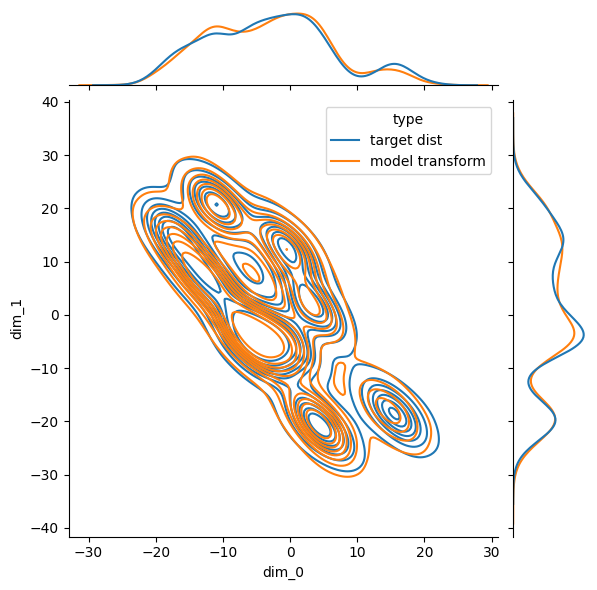

trail: 0 m step: 31 kl_test: 0.47270965576171875


  2%|▏         | 100/6000 [00:32<35:14,  2.79it/s]

trail: 0 m step: 32 Loss: 0.4599609375  L_n: 0.43581390380859375  kld: 0.0012073516845703125 KLD1: 0.4251578152179718 KLD2: 0.29312142729759216


  3%|▎         | 200/6000 [01:04<34:16,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4841728210449219  L_n: 0.4458351135253906  kld: 0.0019168853759765625 KLD1: 0.4269803464412689 KLD2: 0.29803502559661865


  5%|▌         | 300/6000 [01:36<33:41,  2.82it/s]

trail: 0 m step: 32 Loss: 0.44908714294433594  L_n: 0.41345787048339844  kld: 0.001781463623046875 KLD1: 0.4309791028499603 KLD2: 0.2912878692150116


  7%|▋         | 400/6000 [02:08<33:09,  2.81it/s]

trail: 0 m step: 32 Loss: 0.46734619140625  L_n: 0.429962158203125  kld: 0.00186920166015625 KLD1: 0.4378761649131775 KLD2: 0.28583231568336487


  8%|▊         | 500/6000 [02:40<32:23,  2.83it/s]

trail: 0 m step: 32 Loss: 0.47260284423828125  L_n: 0.42858123779296875  kld: 0.002201080322265625 KLD1: 0.42681366205215454 KLD2: 0.29425936937332153


 10%|█         | 600/6000 [03:12<31:41,  2.84it/s]

trail: 0 m step: 32 Loss: 0.46314048767089844  L_n: 0.4179363250732422  kld: 0.0022602081298828125 KLD1: 0.42012128233909607 KLD2: 0.29774922132492065


 12%|█▏        | 700/6000 [03:44<31:14,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4854316711425781  L_n: 0.4322166442871094  kld: 0.0026607513427734375 KLD1: 0.4021676480770111 KLD2: 0.3026514947414398


 13%|█▎        | 800/6000 [04:16<30:38,  2.83it/s]

trail: 0 m step: 32 Loss: 0.45914459228515625  L_n: 0.41687774658203125  kld: 0.00211334228515625 KLD1: 0.4276222586631775 KLD2: 0.3137482702732086


 15%|█▌        | 900/6000 [04:48<30:07,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4821891784667969  L_n: 0.4140586853027344  kld: 0.003406524658203125 KLD1: 0.4225524365901947 KLD2: 0.292944073677063


 17%|█▋        | 1000/6000 [05:20<29:33,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4072132110595703  L_n: 0.39023780822753906  kld: 0.0008487701416015625 KLD1: 0.4282154142856598 KLD2: 0.29077282547950745


 18%|█▊        | 1100/6000 [05:52<28:44,  2.84it/s]

trail: 0 m step: 32 Loss: 0.4630470275878906  L_n: 0.4115867614746094  kld: 0.0025730133056640625 KLD1: 0.42591145634651184 KLD2: 0.2809312343597412


 20%|██        | 1200/6000 [06:24<28:23,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4700660705566406  L_n: 0.4429817199707031  kld: 0.001354217529296875 KLD1: 0.4240853488445282 KLD2: 0.29771459102630615


 22%|██▏       | 1300/6000 [06:56<27:34,  2.84it/s]

trail: 0 m step: 32 Loss: 0.4317188262939453  L_n: 0.4108905792236328  kld: 0.001041412353515625 KLD1: 0.43083226680755615 KLD2: 0.29645636677742004


 23%|██▎       | 1400/6000 [07:28<27:06,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4779834747314453  L_n: 0.43850135803222656  kld: 0.0019741058349609375 KLD1: 0.39878764748573303 KLD2: 0.2823806703090668


 25%|██▌       | 1500/6000 [08:00<26:37,  2.82it/s]

trail: 0 m step: 32 Loss: 0.47562408447265625  L_n: 0.44731903076171875  kld: 0.001415252685546875 KLD1: 0.4314897358417511 KLD2: 0.2813252806663513


 27%|██▋       | 1600/6000 [08:32<26:09,  2.80it/s]

trail: 0 m step: 32 Loss: 0.4518604278564453  L_n: 0.4195117950439453  kld: 0.001617431640625 KLD1: 0.41989612579345703 KLD2: 0.29651400446891785


 28%|██▊       | 1700/6000 [09:04<25:24,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4771728515625  L_n: 0.43067169189453125  kld: 0.0023250579833984375 KLD1: 0.40954750776290894 KLD2: 0.2986771762371063


 30%|███       | 1800/6000 [09:36<24:42,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4774188995361328  L_n: 0.42412757873535156  kld: 0.0026645660400390625 KLD1: 0.4364139139652252 KLD2: 0.2854740619659424


 32%|███▏      | 1900/6000 [10:08<24:09,  2.83it/s]

trail: 0 m step: 32 Loss: 0.45491600036621094  L_n: 0.4108562469482422  kld: 0.0022029876708984375 KLD1: 0.3997923731803894 KLD2: 0.3040795922279358


 33%|███▎      | 2000/6000 [10:40<23:39,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4697284698486328  L_n: 0.41353797912597656  kld: 0.0028095245361328125 KLD1: 0.4230026304721832 KLD2: 0.2974463105201721


 35%|███▌      | 2100/6000 [11:12<22:47,  2.85it/s]

trail: 0 m step: 32 Loss: 0.45740509033203125  L_n: 0.41460418701171875  kld: 0.002140045166015625 KLD1: 0.4366748034954071 KLD2: 0.3026276230812073


 37%|███▋      | 2200/6000 [11:44<22:19,  2.84it/s]

trail: 0 m step: 32 Loss: 0.45832061767578125  L_n: 0.4295196533203125  kld: 0.0014400482177734375 KLD1: 0.4103725552558899 KLD2: 0.30132585763931274


 38%|███▊      | 2300/6000 [12:16<21:48,  2.83it/s]

trail: 0 m step: 32 Loss: 0.44671058654785156  L_n: 0.42580604553222656  kld: 0.00104522705078125 KLD1: 0.4409502446651459 KLD2: 0.28617873787879944


 40%|████      | 2400/6000 [12:48<21:14,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4332599639892578  L_n: 0.40735816955566406  kld: 0.0012950897216796875 KLD1: 0.41433289647102356 KLD2: 0.2992657721042633


 42%|████▏     | 2500/6000 [13:20<20:43,  2.82it/s]

trail: 0 m step: 32 Loss: 0.47116851806640625  L_n: 0.4354248046875  kld: 0.0017871856689453125 KLD1: 0.40777504444122314 KLD2: 0.2907904386520386


 43%|████▎     | 2600/6000 [13:52<20:05,  2.82it/s]

trail: 0 m step: 32 Loss: 0.43546295166015625  L_n: 0.40189361572265625  kld: 0.001678466796875 KLD1: 0.4143946170806885 KLD2: 0.28948095440864563


 45%|████▌     | 2700/6000 [14:25<19:29,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4443836212158203  L_n: 0.41001319885253906  kld: 0.0017185211181640625 KLD1: 0.42113563418388367 KLD2: 0.2872283458709717


 47%|████▋     | 2800/6000 [14:57<18:57,  2.81it/s]

trail: 0 m step: 32 Loss: 0.4496726989746094  L_n: 0.4232368469238281  kld: 0.0013217926025390625 KLD1: 0.43094807863235474 KLD2: 0.28385764360427856


 48%|████▊     | 2900/6000 [15:29<18:20,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4766254425048828  L_n: 0.4361896514892578  kld: 0.00202178955078125 KLD1: 0.41362646222114563 KLD2: 0.2911355197429657


 50%|█████     | 3000/6000 [16:01<17:46,  2.81it/s]

trail: 0 m step: 32 Loss: 0.43781471252441406  L_n: 0.4142017364501953  kld: 0.0011806488037109375 KLD1: 0.43119335174560547 KLD2: 0.2890297770500183


 52%|█████▏    | 3100/6000 [16:33<17:05,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4485664367675781  L_n: 0.4091987609863281  kld: 0.0019683837890625 KLD1: 0.3917354345321655 KLD2: 0.29717060923576355


 53%|█████▎    | 3200/6000 [17:05<16:29,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4425678253173828  L_n: 0.42452430725097656  kld: 0.0009021759033203125 KLD1: 0.42257606983184814 KLD2: 0.28681913018226624


 55%|█████▌    | 3300/6000 [17:37<15:53,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4653472900390625  L_n: 0.45233917236328125  kld: 0.0006504058837890625 KLD1: 0.4183794856071472 KLD2: 0.2885763347148895


 57%|█████▋    | 3400/6000 [18:09<15:19,  2.83it/s]

trail: 0 m step: 32 Loss: 0.45496177673339844  L_n: 0.4268474578857422  kld: 0.0014057159423828125 KLD1: 0.39903345704078674 KLD2: 0.2944587767124176


 58%|█████▊    | 3500/6000 [18:41<14:49,  2.81it/s]

trail: 0 m step: 32 Loss: 0.4778099060058594  L_n: 0.4358482360839844  kld: 0.00209808349609375 KLD1: 0.4012545943260193 KLD2: 0.2840740978717804


 60%|██████    | 3600/6000 [19:13<14:09,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4549751281738281  L_n: 0.4198799133300781  kld: 0.0017547607421875 KLD1: 0.4365869462490082 KLD2: 0.3081586956977844


 62%|██████▏   | 3700/6000 [19:45<13:35,  2.82it/s]

trail: 0 m step: 32 Loss: 0.45958518981933594  L_n: 0.4263591766357422  kld: 0.0016613006591796875 KLD1: 0.41110146045684814 KLD2: 0.29905521869659424


 63%|██████▎   | 3800/6000 [20:17<12:58,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4412555694580078  L_n: 0.41459083557128906  kld: 0.0013332366943359375 KLD1: 0.4089300036430359 KLD2: 0.2757699191570282


 65%|██████▌   | 3900/6000 [20:49<12:20,  2.84it/s]

trail: 0 m step: 32 Loss: 0.4798851013183594  L_n: 0.4277763366699219  kld: 0.002605438232421875 KLD1: 0.412970632314682 KLD2: 0.2865942418575287


 67%|██████▋   | 4000/6000 [21:21<11:51,  2.81it/s]

trail: 0 m step: 32 Loss: 0.46117591857910156  L_n: 0.4204730987548828  kld: 0.0020351409912109375 KLD1: 0.423646479845047 KLD2: 0.29168984293937683


 68%|██████▊   | 4100/6000 [21:53<11:16,  2.81it/s]

trail: 0 m step: 32 Loss: 0.46199607849121094  L_n: 0.42758750915527344  kld: 0.001720428466796875 KLD1: 0.38036397099494934 KLD2: 0.29209333658218384


 70%|███████   | 4200/6000 [22:25<10:37,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4441070556640625  L_n: 0.40843963623046875  kld: 0.0017833709716796875 KLD1: 0.41389939188957214 KLD2: 0.2901688516139984


 72%|███████▏  | 4300/6000 [22:57<10:02,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4641742706298828  L_n: 0.43132972717285156  kld: 0.0016422271728515625 KLD1: 0.4405943751335144 KLD2: 0.3012002408504486


 73%|███████▎  | 4400/6000 [23:29<09:25,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4341716766357422  L_n: 0.40834617614746094  kld: 0.0012912750244140625 KLD1: 0.4222092032432556 KLD2: 0.2864021956920624


 75%|███████▌  | 4500/6000 [24:01<08:50,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4658660888671875  L_n: 0.43370819091796875  kld: 0.0016078948974609375 KLD1: 0.4184668958187103 KLD2: 0.290307879447937


 77%|███████▋  | 4600/6000 [24:33<08:13,  2.84it/s]

trail: 0 m step: 32 Loss: 0.4336395263671875  L_n: 0.4113616943359375  kld: 0.0011138916015625 KLD1: 0.42136916518211365 KLD2: 0.30211010575294495


 78%|███████▊  | 4700/6000 [25:05<07:39,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4468879699707031  L_n: 0.4349861145019531  kld: 0.0005950927734375 KLD1: 0.4372592568397522 KLD2: 0.29059281945228577


 80%|████████  | 4800/6000 [25:37<07:04,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4567832946777344  L_n: 0.4298896789550781  kld: 0.0013446807861328125 KLD1: 0.41389453411102295 KLD2: 0.2951679229736328


 82%|████████▏ | 4900/6000 [26:09<06:29,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4442596435546875  L_n: 0.42236328125  kld: 0.001094818115234375 KLD1: 0.4474632740020752 KLD2: 0.28432539105415344


 83%|████████▎ | 5000/6000 [26:41<05:56,  2.81it/s]

trail: 0 m step: 32 Loss: 0.45009613037109375  L_n: 0.42369842529296875  kld: 0.00131988525390625 KLD1: 0.4316880702972412 KLD2: 0.29506751894950867


 85%|████████▌ | 5100/6000 [27:13<05:19,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4398765563964844  L_n: 0.4120674133300781  kld: 0.0013904571533203125 KLD1: 0.4146899878978729 KLD2: 0.3075958490371704


 87%|████████▋ | 5200/6000 [27:45<04:42,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4492664337158203  L_n: 0.42145729064941406  kld: 0.0013904571533203125 KLD1: 0.40998387336730957 KLD2: 0.2968546152114868


 88%|████████▊ | 5300/6000 [28:17<04:07,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4521465301513672  L_n: 0.4156780242919922  kld: 0.00182342529296875 KLD1: 0.42264628410339355 KLD2: 0.2869481146335602


 90%|█████████ | 5400/6000 [28:49<03:32,  2.83it/s]

trail: 0 m step: 32 Loss: 0.45429229736328125  L_n: 0.41858673095703125  kld: 0.0017852783203125 KLD1: 0.433716356754303 KLD2: 0.2876458764076233


 92%|█████████▏| 5500/6000 [29:21<02:57,  2.82it/s]

trail: 0 m step: 32 Loss: 0.4600200653076172  L_n: 0.4378185272216797  kld: 0.001110076904296875 KLD1: 0.43272992968559265 KLD2: 0.3004652261734009


 93%|█████████▎| 5600/6000 [29:53<02:21,  2.82it/s]

trail: 0 m step: 32 Loss: 0.45011138916015625  L_n: 0.4283294677734375  kld: 0.0010890960693359375 KLD1: 0.4268285036087036 KLD2: 0.28553506731987


 95%|█████████▌| 5700/6000 [30:26<01:45,  2.84it/s]

trail: 0 m step: 32 Loss: 0.43923187255859375  L_n: 0.420196533203125  kld: 0.0009517669677734375 KLD1: 0.40879467129707336 KLD2: 0.29179999232292175


 97%|█████████▋| 5800/6000 [30:58<01:10,  2.82it/s]

trail: 0 m step: 32 Loss: 0.46332359313964844  L_n: 0.43532371520996094  kld: 0.001399993896484375 KLD1: 0.41608113050460815 KLD2: 0.28546053171157837


 98%|█████████▊| 5900/6000 [31:30<00:35,  2.83it/s]

trail: 0 m step: 32 Loss: 0.4411277770996094  L_n: 0.4233894348144531  kld: 0.0008869171142578125 KLD1: 0.4229556620121002 KLD2: 0.30119720101356506


100%|██████████| 6000/6000 [32:02<00:00,  3.12it/s]

trail: 0 m step: 32 Loss: 0.45352935791015625  L_n: 0.442047119140625  kld: 0.0005741119384765625 KLD1: 0.4212471544742584 KLD2: 0.29292818903923035



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


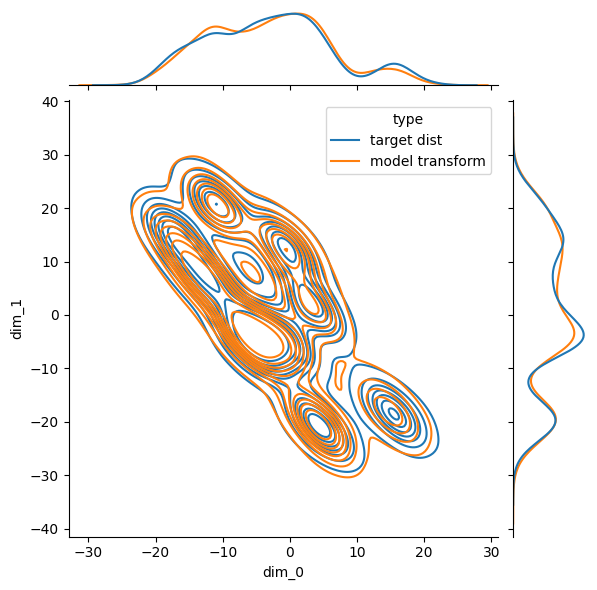

trail: 0 m step: 32 kl_test: 0.44740867614746094


  2%|▏         | 100/6000 [00:32<35:16,  2.79it/s]

trail: 0 m step: 33 Loss: 0.41075706481933594  L_n: 0.4017162322998047  kld: 0.0004520416259765625 KLD1: 0.41102612018585205 KLD2: 0.2810472548007965


  3%|▎         | 200/6000 [01:04<34:14,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4703655242919922  L_n: 0.4258861541748047  kld: 0.002223968505859375 KLD1: 0.4050575792789459 KLD2: 0.2831633985042572


  5%|▌         | 300/6000 [01:36<33:44,  2.81it/s]

trail: 0 m step: 33 Loss: 0.40554237365722656  L_n: 0.3918476104736328  kld: 0.0006847381591796875 KLD1: 0.40363994240760803 KLD2: 0.27833399176597595


  7%|▋         | 400/6000 [02:08<33:22,  2.80it/s]

trail: 0 m step: 33 Loss: 0.43686485290527344  L_n: 0.4127941131591797  kld: 0.0012035369873046875 KLD1: 0.41248416900634766 KLD2: 0.27542153000831604


  8%|▊         | 500/6000 [02:40<32:34,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4536705017089844  L_n: 0.4142646789550781  kld: 0.0019702911376953125 KLD1: 0.40564510226249695 KLD2: 0.2841307520866394


 10%|█         | 600/6000 [03:13<31:53,  2.82it/s]

trail: 0 m step: 33 Loss: 0.430755615234375  L_n: 0.39463043212890625  kld: 0.0018062591552734375 KLD1: 0.39760467410087585 KLD2: 0.2859531044960022


 12%|█▏        | 700/6000 [03:45<31:25,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4394512176513672  L_n: 0.39378929138183594  kld: 0.0022830963134765625 KLD1: 0.3863348662853241 KLD2: 0.29178568720817566


 13%|█▎        | 800/6000 [04:17<30:34,  2.83it/s]

trail: 0 m step: 33 Loss: 0.44096946716308594  L_n: 0.3959178924560547  kld: 0.0022525787353515625 KLD1: 0.40321844816207886 KLD2: 0.30210521817207336


 15%|█▌        | 900/6000 [04:49<30:10,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4525890350341797  L_n: 0.39227867126464844  kld: 0.0030155181884765625 KLD1: 0.40029048919677734 KLD2: 0.2816942632198334


 17%|█▋        | 1000/6000 [05:21<29:37,  2.81it/s]

trail: 0 m step: 33 Loss: 0.3773841857910156  L_n: 0.3715095520019531  kld: 0.000293731689453125 KLD1: 0.4142783582210541 KLD2: 0.2788965702056885


 18%|█▊        | 1100/6000 [05:53<29:03,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4277534484863281  L_n: 0.3934593200683594  kld: 0.0017147064208984375 KLD1: 0.40660473704338074 KLD2: 0.26836249232292175


 20%|██        | 1200/6000 [06:26<28:30,  2.81it/s]

trail: 0 m step: 33 Loss: 0.47141456604003906  L_n: 0.41823768615722656  kld: 0.002658843994140625 KLD1: 0.3935808539390564 KLD2: 0.2805233299732208


 22%|██▏       | 1300/6000 [06:58<27:48,  2.82it/s]

trail: 0 m step: 33 Loss: 0.44527244567871094  L_n: 0.39583396911621094  kld: 0.002471923828125 KLD1: 0.40568917989730835 KLD2: 0.2808564305305481


 23%|██▎       | 1400/6000 [07:30<27:12,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4779853820800781  L_n: 0.4243125915527344  kld: 0.0026836395263671875 KLD1: 0.3761439919471741 KLD2: 0.2663205564022064


 25%|██▌       | 1500/6000 [08:02<26:43,  2.81it/s]

trail: 0 m step: 33 Loss: 0.46733665466308594  L_n: 0.4255657196044922  kld: 0.0020885467529296875 KLD1: 0.408676415681839 KLD2: 0.2694011628627777


 27%|██▋       | 1600/6000 [08:34<26:11,  2.80it/s]

trail: 0 m step: 33 Loss: 0.42011260986328125  L_n: 0.3964996337890625  kld: 0.0011806488037109375 KLD1: 0.4141973555088043 KLD2: 0.285194456577301


 28%|██▊       | 1700/6000 [09:07<25:28,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4575996398925781  L_n: 0.4154853820800781  kld: 0.002105712890625 KLD1: 0.39256179332733154 KLD2: 0.2869831323623657


 30%|███       | 1800/6000 [09:39<24:48,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4306449890136719  L_n: 0.3861656188964844  kld: 0.002223968505859375 KLD1: 0.4247322678565979 KLD2: 0.27351850271224976


 32%|███▏      | 1900/6000 [10:11<24:17,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4515056610107422  L_n: 0.3894786834716797  kld: 0.003101348876953125 KLD1: 0.3867160677909851 KLD2: 0.28855058550834656


 33%|███▎      | 2000/6000 [10:43<23:47,  2.80it/s]

trail: 0 m step: 33 Loss: 0.4536476135253906  L_n: 0.3984870910644531  kld: 0.002758026123046875 KLD1: 0.4019870162010193 KLD2: 0.2845449149608612


 35%|███▌      | 2100/6000 [11:15<23:06,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4415092468261719  L_n: 0.4038963317871094  kld: 0.001880645751953125 KLD1: 0.40828391909599304 KLD2: 0.2898126244544983


 37%|███▋      | 2200/6000 [11:48<22:25,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4571495056152344  L_n: 0.4134712219238281  kld: 0.0021839141845703125 KLD1: 0.38178732991218567 KLD2: 0.2866852581501007


 38%|███▊      | 2300/6000 [12:20<21:54,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4296302795410156  L_n: 0.4052543640136719  kld: 0.0012187957763671875 KLD1: 0.41332289576530457 KLD2: 0.2704133689403534


 40%|████      | 2400/6000 [12:52<21:17,  2.82it/s]

trail: 0 m step: 33 Loss: 0.43257713317871094  L_n: 0.40114402770996094  kld: 0.0015716552734375 KLD1: 0.40269818902015686 KLD2: 0.28613924980163574


 42%|████▏     | 2500/6000 [13:24<20:39,  2.82it/s]

trail: 0 m step: 33 Loss: 0.44551849365234375  L_n: 0.40363311767578125  kld: 0.002094268798828125 KLD1: 0.3966149091720581 KLD2: 0.2771480083465576


 43%|████▎     | 2600/6000 [13:56<20:08,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4095745086669922  L_n: 0.3768444061279297  kld: 0.001636505126953125 KLD1: 0.38324442505836487 KLD2: 0.27527666091918945


 45%|████▌     | 2700/6000 [14:28<19:27,  2.83it/s]

trail: 0 m step: 33 Loss: 0.42601776123046875  L_n: 0.3898162841796875  kld: 0.0018100738525390625 KLD1: 0.39104822278022766 KLD2: 0.2729606032371521


 47%|████▋     | 2800/6000 [15:00<18:52,  2.83it/s]

trail: 0 m step: 33 Loss: 0.41876792907714844  L_n: 0.3979778289794922  kld: 0.0010395050048828125 KLD1: 0.4035513401031494 KLD2: 0.27105602622032166


 48%|████▊     | 2900/6000 [15:32<18:19,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4364013671875  L_n: 0.4058837890625  kld: 0.00152587890625 KLD1: 0.38067826628685 KLD2: 0.27783969044685364


 50%|█████     | 3000/6000 [16:04<17:45,  2.82it/s]

trail: 0 m step: 33 Loss: 0.41030311584472656  L_n: 0.3847827911376953  kld: 0.0012760162353515625 KLD1: 0.4071861505508423 KLD2: 0.2746872007846832


 52%|█████▏    | 3100/6000 [16:36<17:08,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4149169921875  L_n: 0.39138031005859375  kld: 0.0011768341064453125 KLD1: 0.3767974078655243 KLD2: 0.28764668107032776


 53%|█████▎    | 3200/6000 [17:09<16:34,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4410572052001953  L_n: 0.41279029846191406  kld: 0.0014133453369140625 KLD1: 0.40441298484802246 KLD2: 0.27457958459854126


 55%|█████▌    | 3300/6000 [17:41<16:00,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4454975128173828  L_n: 0.43615150451660156  kld: 0.0004673004150390625 KLD1: 0.4021904170513153 KLD2: 0.2757643461227417


 57%|█████▋    | 3400/6000 [18:13<15:23,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4241447448730469  L_n: 0.4014091491699219  kld: 0.00113677978515625 KLD1: 0.38316553831100464 KLD2: 0.2812769114971161


 58%|█████▊    | 3500/6000 [18:45<14:46,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4539165496826172  L_n: 0.41054344177246094  kld: 0.0021686553955078125 KLD1: 0.38238880038261414 KLD2: 0.2700034976005554


 60%|██████    | 3600/6000 [19:17<14:11,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4199657440185547  L_n: 0.38696861267089844  kld: 0.0016498565673828125 KLD1: 0.3886982202529907 KLD2: 0.29248836636543274


 62%|██████▏   | 3700/6000 [19:49<13:41,  2.80it/s]

trail: 0 m step: 33 Loss: 0.4567890167236328  L_n: 0.40990638732910156  kld: 0.0023441314697265625 KLD1: 0.38170915842056274 KLD2: 0.28434741497039795


 63%|██████▎   | 3800/6000 [20:21<13:04,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4379081726074219  L_n: 0.4004859924316406  kld: 0.0018711090087890625 KLD1: 0.394913911819458 KLD2: 0.2633693814277649


 65%|██████▌   | 3900/6000 [20:53<12:25,  2.82it/s]

trail: 0 m step: 33 Loss: 0.43485450744628906  L_n: 0.4042224884033203  kld: 0.0015316009521484375 KLD1: 0.39205482602119446 KLD2: 0.2745731770992279


 67%|██████▋   | 4000/6000 [21:26<11:49,  2.82it/s]

trail: 0 m step: 33 Loss: 0.41319847106933594  L_n: 0.38466453552246094  kld: 0.00142669677734375 KLD1: 0.40191206336021423 KLD2: 0.27788296341896057


 68%|██████▊   | 4100/6000 [21:58<11:14,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4474010467529297  L_n: 0.4060497283935547  kld: 0.00206756591796875 KLD1: 0.3549937307834625 KLD2: 0.2777644693851471


 70%|███████   | 4200/6000 [22:30<10:38,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4259605407714844  L_n: 0.3981132507324219  kld: 0.001392364501953125 KLD1: 0.3906250298023224 KLD2: 0.2760795056819916


 72%|███████▏  | 4300/6000 [23:02<10:03,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4458045959472656  L_n: 0.4136085510253906  kld: 0.00160980224609375 KLD1: 0.4063071310520172 KLD2: 0.28752201795578003


 73%|███████▎  | 4400/6000 [23:34<09:30,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4182853698730469  L_n: 0.3980674743652344  kld: 0.001010894775390625 KLD1: 0.3888598680496216 KLD2: 0.2728395462036133


 75%|███████▌  | 4500/6000 [24:06<08:53,  2.81it/s]

trail: 0 m step: 33 Loss: 0.44693946838378906  L_n: 0.41459083557128906  kld: 0.001617431640625 KLD1: 0.40759387612342834 KLD2: 0.27739813923835754


 77%|███████▋  | 4600/6000 [24:38<08:17,  2.81it/s]

trail: 0 m step: 33 Loss: 0.40982818603515625  L_n: 0.39586639404296875  kld: 0.000698089599609375 KLD1: 0.4027426242828369 KLD2: 0.289014995098114


 78%|███████▊  | 4700/6000 [25:10<07:40,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4257335662841797  L_n: 0.4110088348388672  kld: 0.000736236572265625 KLD1: 0.41593509912490845 KLD2: 0.2772151231765747


 80%|████████  | 4800/6000 [25:42<07:05,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4377899169921875  L_n: 0.414825439453125  kld: 0.001148223876953125 KLD1: 0.3871440589427948 KLD2: 0.28183114528656006


 82%|████████▏ | 4900/6000 [26:14<06:26,  2.85it/s]

trail: 0 m step: 33 Loss: 0.41413307189941406  L_n: 0.39109230041503906  kld: 0.00115203857421875 KLD1: 0.4038042724132538 KLD2: 0.27231672406196594


 83%|████████▎ | 5000/6000 [26:46<05:54,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4311809539794922  L_n: 0.4107341766357422  kld: 0.0010223388671875 KLD1: 0.3998766839504242 KLD2: 0.28168848156929016


 85%|████████▌ | 5100/6000 [27:18<05:19,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4200630187988281  L_n: 0.3942756652832031  kld: 0.00128936767578125 KLD1: 0.39877599477767944 KLD2: 0.2945287227630615


 87%|████████▋ | 5200/6000 [27:50<04:44,  2.81it/s]

trail: 0 m step: 33 Loss: 0.44738197326660156  L_n: 0.4087390899658203  kld: 0.0019321441650390625 KLD1: 0.39208662509918213 KLD2: 0.28374531865119934


 88%|████████▊ | 5300/6000 [28:22<04:09,  2.81it/s]

trail: 0 m step: 33 Loss: 0.44671058654785156  L_n: 0.41756629943847656  kld: 0.00145721435546875 KLD1: 0.38559219241142273 KLD2: 0.2750968635082245


 90%|█████████ | 5400/6000 [28:54<03:33,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4243793487548828  L_n: 0.39740943908691406  kld: 0.0013484954833984375 KLD1: 0.412447452545166 KLD2: 0.2753075063228607


 92%|█████████▏| 5500/6000 [29:27<02:58,  2.81it/s]

trail: 0 m step: 33 Loss: 0.42708778381347656  L_n: 0.40610694885253906  kld: 0.001049041748046875 KLD1: 0.4037812650203705 KLD2: 0.2870376408100128


 93%|█████████▎| 5600/6000 [29:59<02:22,  2.81it/s]

trail: 0 m step: 33 Loss: 0.432586669921875  L_n: 0.3993988037109375  kld: 0.001659393310546875 KLD1: 0.4061712324619293 KLD2: 0.2736678719520569


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.81it/s]

trail: 0 m step: 33 Loss: 0.41316795349121094  L_n: 0.39165306091308594  kld: 0.00107574462890625 KLD1: 0.38329944014549255 KLD2: 0.27926623821258545


 97%|█████████▋| 5800/6000 [31:03<01:10,  2.82it/s]

trail: 0 m step: 33 Loss: 0.4325389862060547  L_n: 0.4049205780029297  kld: 0.00138092041015625 KLD1: 0.3934146463871002 KLD2: 0.2735070586204529


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.81it/s]

trail: 0 m step: 33 Loss: 0.4273529052734375  L_n: 0.3994293212890625  kld: 0.00139617919921875 KLD1: 0.3848644495010376 KLD2: 0.2892163395881653


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 33 Loss: 0.4529304504394531  L_n: 0.4239006042480469  kld: 0.0014514923095703125 KLD1: 0.38592129945755005 KLD2: 0.27972760796546936



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


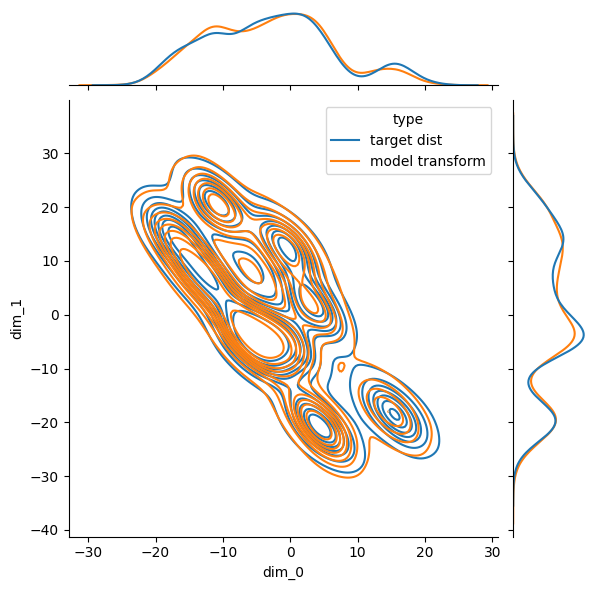

trail: 0 m step: 33 kl_test: 0.4174175262451172


  2%|▏         | 100/6000 [00:32<35:10,  2.79it/s]

trail: 0 m step: 34 Loss: 0.3948497772216797  L_n: 0.37711143493652344  kld: 0.0008869171142578125 KLD1: 0.37988588213920593 KLD2: 0.2692973017692566


  3%|▎         | 200/6000 [01:04<34:12,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4331989288330078  L_n: 0.39394569396972656  kld: 0.0019626617431640625 KLD1: 0.3964817225933075 KLD2: 0.27044007182121277


  5%|▌         | 300/6000 [01:36<33:52,  2.80it/s]

trail: 0 m step: 34 Loss: 0.3870525360107422  L_n: 0.3720226287841797  kld: 0.000751495361328125 KLD1: 0.38477644324302673 KLD2: 0.2684587240219116


  7%|▋         | 400/6000 [02:08<33:13,  2.81it/s]

trail: 0 m step: 34 Loss: 0.43039512634277344  L_n: 0.39659690856933594  kld: 0.001689910888671875 KLD1: 0.40332746505737305 KLD2: 0.2636428475379944


  8%|▊         | 500/6000 [02:40<32:26,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4467601776123047  L_n: 0.38889122009277344  kld: 0.0028934478759765625 KLD1: 0.3909905254840851 KLD2: 0.27283337712287903


 10%|█         | 600/6000 [03:12<31:49,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4357128143310547  L_n: 0.37578392028808594  kld: 0.0029964447021484375 KLD1: 0.3949020802974701 KLD2: 0.27557650208473206


 12%|█▏        | 700/6000 [03:44<31:13,  2.83it/s]

trail: 0 m step: 34 Loss: 0.43141937255859375  L_n: 0.389190673828125  kld: 0.0021114349365234375 KLD1: 0.3668792247772217 KLD2: 0.2784186601638794


 13%|█▎        | 800/6000 [04:16<30:43,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4336700439453125  L_n: 0.3885040283203125  kld: 0.00225830078125 KLD1: 0.37786850333213806 KLD2: 0.29089853167533875


 15%|█▌        | 900/6000 [04:48<30:07,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4476165771484375  L_n: 0.3926849365234375  kld: 0.00274658203125 KLD1: 0.39609163999557495 KLD2: 0.2698709964752197


 17%|█▋        | 1000/6000 [05:20<29:28,  2.83it/s]

trail: 0 m step: 34 Loss: 0.3776054382324219  L_n: 0.3636436462402344  kld: 0.000698089599609375 KLD1: 0.386707603931427 KLD2: 0.2672787010669708


 18%|█▊        | 1100/6000 [05:52<29:01,  2.81it/s]

trail: 0 m step: 34 Loss: 0.40871620178222656  L_n: 0.37903785705566406  kld: 0.001483917236328125 KLD1: 0.39477601647377014 KLD2: 0.2576954662799835


 20%|██        | 1200/6000 [06:24<28:20,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4230327606201172  L_n: 0.3933544158935547  kld: 0.001483917236328125 KLD1: 0.3815213143825531 KLD2: 0.2724500298500061


 22%|██▏       | 1300/6000 [06:56<27:52,  2.81it/s]

trail: 0 m step: 34 Loss: 0.4123516082763672  L_n: 0.3742046356201172  kld: 0.0019073486328125 KLD1: 0.38791340589523315 KLD2: 0.271078884601593


 23%|██▎       | 1400/6000 [07:28<27:19,  2.81it/s]

trail: 0 m step: 34 Loss: 0.4473705291748047  L_n: 0.39323997497558594  kld: 0.0027065277099609375 KLD1: 0.37239041924476624 KLD2: 0.2547869086265564


 25%|██▌       | 1500/6000 [08:01<26:32,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4173603057861328  L_n: 0.3868427276611328  kld: 0.00152587890625 KLD1: 0.39160892367362976 KLD2: 0.2590957581996918


 27%|██▋       | 1600/6000 [08:33<26:08,  2.80it/s]

trail: 0 m step: 34 Loss: 0.4143943786621094  L_n: 0.3883399963378906  kld: 0.0013027191162109375 KLD1: 0.38649964332580566 KLD2: 0.2744750380516052


 28%|██▊       | 1700/6000 [09:05<25:22,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4419994354248047  L_n: 0.3901958465576172  kld: 0.002590179443359375 KLD1: 0.3848174214363098 KLD2: 0.2745594084262848


 30%|███       | 1800/6000 [09:37<24:57,  2.80it/s]

trail: 0 m step: 34 Loss: 0.45134925842285156  L_n: 0.39023780822753906  kld: 0.003055572509765625 KLD1: 0.40717577934265137 KLD2: 0.26278382539749146


 32%|███▏      | 1900/6000 [10:09<24:12,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4281787872314453  L_n: 0.3683643341064453  kld: 0.00299072265625 KLD1: 0.37560132145881653 KLD2: 0.27900928258895874


 33%|███▎      | 2000/6000 [10:41<23:39,  2.82it/s]

trail: 0 m step: 34 Loss: 0.44768524169921875  L_n: 0.3870697021484375  kld: 0.0030307769775390625 KLD1: 0.3889256715774536 KLD2: 0.2742282748222351


 35%|███▌      | 2100/6000 [11:13<23:31,  2.76it/s]

trail: 0 m step: 34 Loss: 0.4175262451171875  L_n: 0.37613677978515625  kld: 0.0020694732666015625 KLD1: 0.37704920768737793 KLD2: 0.27933159470558167


 37%|███▋      | 2200/6000 [11:45<22:31,  2.81it/s]

trail: 0 m step: 34 Loss: 0.43569374084472656  L_n: 0.39937782287597656  kld: 0.0018157958984375 KLD1: 0.38222137093544006 KLD2: 0.276418536901474


 38%|███▊      | 2300/6000 [12:17<21:47,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4078197479248047  L_n: 0.3837108612060547  kld: 0.0012054443359375 KLD1: 0.39476150274276733 KLD2: 0.2604663372039795


 40%|████      | 2400/6000 [12:50<21:23,  2.80it/s]

trail: 0 m step: 34 Loss: 0.3950328826904297  L_n: 0.37103843688964844  kld: 0.0011997222900390625 KLD1: 0.38446110486984253 KLD2: 0.2763994634151459


 42%|████▏     | 2500/6000 [13:22<20:38,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4280414581298828  L_n: 0.39168739318847656  kld: 0.0018177032470703125 KLD1: 0.368855744600296 KLD2: 0.2679222524166107


 43%|████▎     | 2600/6000 [13:54<20:07,  2.81it/s]

trail: 0 m step: 34 Loss: 0.39147377014160156  L_n: 0.3574085235595703  kld: 0.0017032623291015625 KLD1: 0.3666297495365143 KLD2: 0.2673807144165039


 45%|████▌     | 2700/6000 [14:26<19:29,  2.82it/s]

trail: 0 m step: 34 Loss: 0.3986968994140625  L_n: 0.36821746826171875  kld: 0.0015239715576171875 KLD1: 0.3843633532524109 KLD2: 0.26387909054756165


 47%|████▋     | 2800/6000 [14:58<18:57,  2.81it/s]

trail: 0 m step: 34 Loss: 0.4109687805175781  L_n: 0.3877754211425781  kld: 0.00115966796875 KLD1: 0.3940247595310211 KLD2: 0.2618696689605713


 48%|████▊     | 2900/6000 [15:30<18:16,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4140586853027344  L_n: 0.3868980407714844  kld: 0.0013580322265625 KLD1: 0.37798330187797546 KLD2: 0.2689462900161743


 50%|█████     | 3000/6000 [16:02<17:40,  2.83it/s]

trail: 0 m step: 34 Loss: 0.38774871826171875  L_n: 0.370086669921875  kld: 0.0008831024169921875 KLD1: 0.39387503266334534 KLD2: 0.2663693428039551


 52%|█████▏    | 3100/6000 [16:34<17:11,  2.81it/s]

trail: 0 m step: 34 Loss: 0.39826202392578125  L_n: 0.375030517578125  kld: 0.0011615753173828125 KLD1: 0.3636144697666168 KLD2: 0.2767309844493866


 53%|█████▎    | 3200/6000 [17:06<16:34,  2.82it/s]

trail: 0 m step: 34 Loss: 0.41016197204589844  L_n: 0.3914318084716797  kld: 0.0009365081787109375 KLD1: 0.3935059607028961 KLD2: 0.2637631297111511


 55%|█████▌    | 3300/6000 [17:38<15:53,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4438629150390625  L_n: 0.4180755615234375  kld: 0.00128936767578125 KLD1: 0.3827091455459595 KLD2: 0.26511454582214355


 57%|█████▋    | 3400/6000 [18:10<15:20,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4156055450439453  L_n: 0.3863086700439453  kld: 0.00146484375 KLD1: 0.363096684217453 KLD2: 0.269422322511673


 58%|█████▊    | 3500/6000 [18:42<14:41,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4458599090576172  L_n: 0.3948955535888672  kld: 0.0025482177734375 KLD1: 0.3624953627586365 KLD2: 0.25860273838043213


 60%|██████    | 3600/6000 [19:15<14:08,  2.83it/s]

trail: 0 m step: 34 Loss: 0.40967559814453125  L_n: 0.37679290771484375  kld: 0.001644134521484375 KLD1: 0.37320858240127563 KLD2: 0.28243520855903625


 62%|██████▏   | 3700/6000 [19:47<13:36,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4289398193359375  L_n: 0.39151763916015625  kld: 0.0018711090087890625 KLD1: 0.3687198758125305 KLD2: 0.27517595887184143


 63%|██████▎   | 3800/6000 [20:19<13:00,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4136848449707031  L_n: 0.3740501403808594  kld: 0.0019817352294921875 KLD1: 0.3801807165145874 KLD2: 0.2543351948261261


 65%|██████▌   | 3900/6000 [20:51<11:57,  2.93it/s]

trail: 0 m step: 34 Loss: 0.4197101593017578  L_n: 0.3914813995361328  kld: 0.00141143798828125 KLD1: 0.3657148480415344 KLD2: 0.2633969783782959


 67%|██████▋   | 4000/6000 [21:23<11:50,  2.81it/s]

trail: 0 m step: 34 Loss: 0.40226173400878906  L_n: 0.3810138702392578  kld: 0.0010623931884765625 KLD1: 0.38788747787475586 KLD2: 0.26846346259117126


 68%|██████▊   | 4100/6000 [21:55<11:16,  2.81it/s]

trail: 0 m step: 34 Loss: 0.42554473876953125  L_n: 0.391021728515625  kld: 0.0017261505126953125 KLD1: 0.3653274178504944 KLD2: 0.26879584789276123


 70%|███████   | 4200/6000 [22:27<10:37,  2.82it/s]

trail: 0 m step: 34 Loss: 0.39727020263671875  L_n: 0.37834930419921875  kld: 0.000946044921875 KLD1: 0.3819271922111511 KLD2: 0.26791131496429443


 72%|███████▏  | 4300/6000 [22:59<10:01,  2.83it/s]

trail: 0 m step: 34 Loss: 0.41670989990234375  L_n: 0.39244842529296875  kld: 0.00121307373046875 KLD1: 0.4029444456100464 KLD2: 0.27826130390167236


 73%|███████▎  | 4400/6000 [23:31<09:25,  2.83it/s]

trail: 0 m step: 34 Loss: 0.3920249938964844  L_n: 0.3754310607910156  kld: 0.0008296966552734375 KLD1: 0.3782474398612976 KLD2: 0.26428475975990295


 75%|███████▌  | 4500/6000 [24:03<08:52,  2.82it/s]

trail: 0 m step: 34 Loss: 0.42358970642089844  L_n: 0.4047832489013672  kld: 0.0009403228759765625 KLD1: 0.396201491355896 KLD2: 0.26849067211151123


 77%|███████▋  | 4600/6000 [24:35<08:10,  2.85it/s]

trail: 0 m step: 34 Loss: 0.3923511505126953  L_n: 0.37796974182128906  kld: 0.0007190704345703125 KLD1: 0.39678308367729187 KLD2: 0.2779947519302368


 78%|███████▊  | 4700/6000 [25:07<07:40,  2.82it/s]

trail: 0 m step: 34 Loss: 0.39649200439453125  L_n: 0.391876220703125  kld: 0.0002307891845703125 KLD1: 0.3813439905643463 KLD2: 0.26730096340179443


 80%|████████  | 4800/6000 [25:39<07:07,  2.81it/s]

trail: 0 m step: 34 Loss: 0.39479637145996094  L_n: 0.3798046112060547  kld: 0.0007495880126953125 KLD1: 0.37257927656173706 KLD2: 0.2724568843841553


 82%|████████▏ | 4900/6000 [26:11<06:26,  2.84it/s]

trail: 0 m step: 34 Loss: 0.39183616638183594  L_n: 0.3700542449951172  kld: 0.0010890960693359375 KLD1: 0.38261091709136963 KLD2: 0.262155145406723


 83%|████████▎ | 5000/6000 [26:43<05:56,  2.80it/s]

trail: 0 m step: 34 Loss: 0.39990234375  L_n: 0.39177703857421875  kld: 0.0004062652587890625 KLD1: 0.3818092346191406 KLD2: 0.27167677879333496


 85%|████████▌ | 5100/6000 [27:15<05:19,  2.81it/s]

trail: 0 m step: 34 Loss: 0.4011096954345703  L_n: 0.3836383819580078  kld: 0.000873565673828125 KLD1: 0.3869231641292572 KLD2: 0.28428369760513306


 87%|████████▋ | 5200/6000 [27:47<04:44,  2.81it/s]

trail: 0 m step: 34 Loss: 0.42319297790527344  L_n: 0.39061546325683594  kld: 0.001628875732421875 KLD1: 0.36404451727867126 KLD2: 0.27416226267814636


 88%|████████▊ | 5300/6000 [28:19<04:08,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4211864471435547  L_n: 0.39162254333496094  kld: 0.0014781951904296875 KLD1: 0.36562514305114746 KLD2: 0.26473304629325867


 90%|█████████ | 5400/6000 [28:51<03:32,  2.82it/s]

trail: 0 m step: 34 Loss: 0.4252490997314453  L_n: 0.3887805938720703  kld: 0.00182342529296875 KLD1: 0.39388808608055115 KLD2: 0.26359155774116516


 92%|█████████▏| 5500/6000 [29:23<02:57,  2.82it/s]

trail: 0 m step: 34 Loss: 0.41608619689941406  L_n: 0.39853858947753906  kld: 0.00087738037109375 KLD1: 0.3806667625904083 KLD2: 0.2753731906414032


 93%|█████████▎| 5600/6000 [29:55<02:21,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4073448181152344  L_n: 0.3917427062988281  kld: 0.0007801055908203125 KLD1: 0.38312697410583496 KLD2: 0.2619076073169708


 95%|█████████▌| 5700/6000 [30:27<01:47,  2.79it/s]

trail: 0 m step: 34 Loss: 0.39186668395996094  L_n: 0.37042808532714844  kld: 0.001071929931640625 KLD1: 0.3567919433116913 KLD2: 0.2683600187301636


 97%|█████████▋| 5800/6000 [30:59<01:10,  2.83it/s]

trail: 0 m step: 34 Loss: 0.4224510192871094  L_n: 0.4071922302246094  kld: 0.000762939453125 KLD1: 0.3906249403953552 KLD2: 0.26194843649864197


 98%|█████████▊| 5900/6000 [31:31<00:35,  2.84it/s]

trail: 0 m step: 34 Loss: 0.3973655700683594  L_n: 0.3783683776855469  kld: 0.000949859619140625 KLD1: 0.3797265589237213 KLD2: 0.27753469347953796


100%|██████████| 6000/6000 [32:03<00:00,  3.12it/s]

trail: 0 m step: 34 Loss: 0.41265106201171875  L_n: 0.39960479736328125  kld: 0.000652313232421875 KLD1: 0.36997273564338684 KLD2: 0.2681003510951996



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


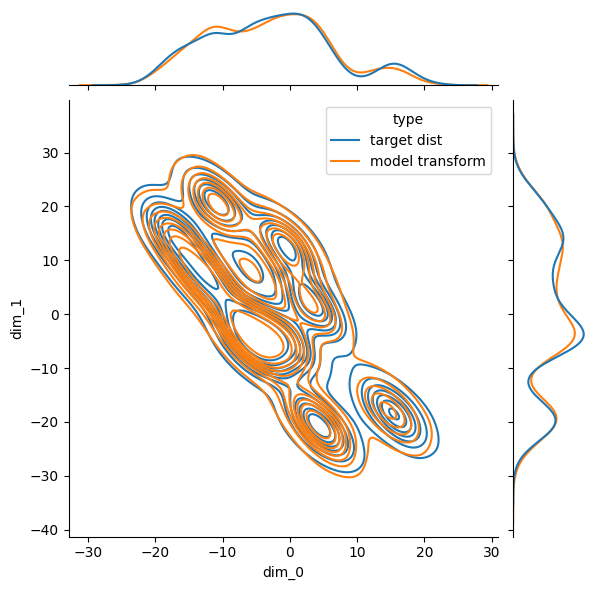

trail: 0 m step: 34 kl_test: 0.39969825744628906


  2%|▏         | 100/6000 [00:32<35:20,  2.78it/s]

trail: 0 m step: 35 Loss: 0.37319374084472656  L_n: 0.35701942443847656  kld: 0.0008087158203125 KLD1: 0.3845199942588806 KLD2: 0.2581881284713745


  3%|▎         | 200/6000 [01:04<34:14,  2.82it/s]

trail: 0 m step: 35 Loss: 0.3974876403808594  L_n: 0.3676948547363281  kld: 0.0014896392822265625 KLD1: 0.36596399545669556 KLD2: 0.26055142283439636


  5%|▌         | 300/6000 [01:36<33:55,  2.80it/s]

trail: 0 m step: 35 Loss: 0.40169525146484375  L_n: 0.35469818115234375  kld: 0.002349853515625 KLD1: 0.37790432572364807 KLD2: 0.2574208378791809


  7%|▋         | 400/6000 [02:08<33:10,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3976154327392578  L_n: 0.36591529846191406  kld: 0.0015850067138671875 KLD1: 0.3762972056865692 KLD2: 0.25365734100341797


  8%|▊         | 500/6000 [02:41<32:42,  2.80it/s]

trail: 0 m step: 35 Loss: 0.4215564727783203  L_n: 0.3783740997314453  kld: 0.00215911865234375 KLD1: 0.3603244125843048 KLD2: 0.2594876289367676


 10%|█         | 600/6000 [03:13<32:01,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3958091735839844  L_n: 0.3595695495605469  kld: 0.001811981201171875 KLD1: 0.3590622842311859 KLD2: 0.26626279950141907


 12%|█▏        | 700/6000 [03:45<31:27,  2.81it/s]

trail: 0 m step: 35 Loss: 0.43296241760253906  L_n: 0.3725757598876953  kld: 0.0030193328857421875 KLD1: 0.36557331681251526 KLD2: 0.27164188027381897


 13%|█▎        | 800/6000 [04:17<30:52,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4082145690917969  L_n: 0.3691520690917969  kld: 0.001953125 KLD1: 0.3765207529067993 KLD2: 0.28195658326148987


 15%|█▌        | 900/6000 [04:49<30:17,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4189720153808594  L_n: 0.3688468933105469  kld: 0.002506256103515625 KLD1: 0.3834987282752991 KLD2: 0.2577095031738281


 17%|█▋        | 1000/6000 [05:21<29:30,  2.82it/s]

trail: 0 m step: 35 Loss: 0.36338043212890625  L_n: 0.35170745849609375  kld: 0.000583648681640625 KLD1: 0.36458608508110046 KLD2: 0.25905004143714905


 18%|█▊        | 1100/6000 [05:53<28:58,  2.82it/s]

trail: 0 m step: 35 Loss: 0.39716148376464844  L_n: 0.36000633239746094  kld: 0.001857757568359375 KLD1: 0.38393157720565796 KLD2: 0.24622167646884918


 20%|██        | 1200/6000 [06:26<28:25,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3971138000488281  L_n: 0.3715171813964844  kld: 0.0012798309326171875 KLD1: 0.37684428691864014 KLD2: 0.2617652416229248


 22%|██▏       | 1300/6000 [06:58<27:55,  2.81it/s]

trail: 0 m step: 35 Loss: 0.39099884033203125  L_n: 0.3614349365234375  kld: 0.0014781951904296875 KLD1: 0.37449711561203003 KLD2: 0.26190975308418274


 23%|██▎       | 1400/6000 [07:30<27:18,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4289722442626953  L_n: 0.3842639923095703  kld: 0.00223541259765625 KLD1: 0.3560313284397125 KLD2: 0.2492958903312683


 25%|██▌       | 1500/6000 [08:02<26:43,  2.81it/s]

trail: 0 m step: 35 Loss: 0.39835166931152344  L_n: 0.3661174774169922  kld: 0.0016117095947265625 KLD1: 0.37656909227371216 KLD2: 0.25005754828453064


 27%|██▋       | 1600/6000 [08:35<26:12,  2.80it/s]

trail: 0 m step: 35 Loss: 0.3721294403076172  L_n: 0.36125755310058594  kld: 0.0005435943603515625 KLD1: 0.3698762059211731 KLD2: 0.2637133300304413


 28%|██▊       | 1700/6000 [09:07<25:31,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4097614288330078  L_n: 0.3797779083251953  kld: 0.001499176025390625 KLD1: 0.3608216941356659 KLD2: 0.2657793164253235


 30%|███       | 1800/6000 [09:39<24:56,  2.81it/s]

trail: 0 m step: 35 Loss: 0.41071319580078125  L_n: 0.37111663818359375  kld: 0.001979827880859375 KLD1: 0.3771468997001648 KLD2: 0.2550583779811859


 32%|███▏      | 1900/6000 [10:11<24:18,  2.81it/s]

trail: 0 m step: 35 Loss: 0.40007591247558594  L_n: 0.3611278533935547  kld: 0.0019474029541015625 KLD1: 0.35884594917297363 KLD2: 0.26936015486717224


 33%|███▎      | 2000/6000 [10:43<23:37,  2.82it/s]

trail: 0 m step: 35 Loss: 0.40973854064941406  L_n: 0.3553791046142578  kld: 0.0027179718017578125 KLD1: 0.3742412328720093 KLD2: 0.2625613808631897


 35%|███▌      | 2100/6000 [11:16<23:03,  2.82it/s]

trail: 0 m step: 35 Loss: 0.38549041748046875  L_n: 0.35382843017578125  kld: 0.001583099365234375 KLD1: 0.35712912678718567 KLD2: 0.2665984332561493


 37%|███▋      | 2200/6000 [11:48<22:28,  2.82it/s]

trail: 0 m step: 35 Loss: 0.40728759765625  L_n: 0.377532958984375  kld: 0.00148773193359375 KLD1: 0.353498637676239 KLD2: 0.26457715034484863


 38%|███▊      | 2300/6000 [12:20<21:55,  2.81it/s]

trail: 0 m step: 35 Loss: 0.405975341796875  L_n: 0.38106536865234375  kld: 0.0012454986572265625 KLD1: 0.3851943612098694 KLD2: 0.24989764392375946


 40%|████      | 2400/6000 [12:52<21:23,  2.80it/s]

trail: 0 m step: 35 Loss: 0.387420654296875  L_n: 0.36609649658203125  kld: 0.0010662078857421875 KLD1: 0.37177106738090515 KLD2: 0.26348555088043213


 42%|████▏     | 2500/6000 [13:24<20:45,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4073925018310547  L_n: 0.37187767028808594  kld: 0.0017757415771484375 KLD1: 0.36009711027145386 KLD2: 0.25521376729011536


 43%|████▎     | 2600/6000 [13:57<20:11,  2.81it/s]

trail: 0 m step: 35 Loss: 0.38669395446777344  L_n: 0.34793663024902344  kld: 0.0019378662109375 KLD1: 0.35844868421554565 KLD2: 0.2541729807853699


 45%|████▌     | 2700/6000 [14:29<19:38,  2.80it/s]

trail: 0 m step: 35 Loss: 0.40125465393066406  L_n: 0.3599414825439453  kld: 0.0020656585693359375 KLD1: 0.35168495774269104 KLD2: 0.2508457601070404


 47%|████▋     | 2800/6000 [15:01<19:03,  2.80it/s]

trail: 0 m step: 35 Loss: 0.4057331085205078  L_n: 0.3807849884033203  kld: 0.001247406005859375 KLD1: 0.3684689998626709 KLD2: 0.24987366795539856


 48%|████▊     | 2900/6000 [15:33<18:25,  2.80it/s]

trail: 0 m step: 35 Loss: 0.39604759216308594  L_n: 0.3653392791748047  kld: 0.0015354156494140625 KLD1: 0.34808918833732605 KLD2: 0.25672364234924316


 50%|█████     | 3000/6000 [16:06<19:02,  2.62it/s]

trail: 0 m step: 35 Loss: 0.3625640869140625  L_n: 0.35028076171875  kld: 0.000614166259765625 KLD1: 0.38212308287620544 KLD2: 0.255832701921463


 52%|█████▏    | 3100/6000 [16:38<17:16,  2.80it/s]

trail: 0 m step: 35 Loss: 0.3852405548095703  L_n: 0.36521339416503906  kld: 0.0010013580322265625 KLD1: 0.35404685139656067 KLD2: 0.26697009801864624


 53%|█████▎    | 3200/6000 [17:10<15:16,  3.05it/s]

trail: 0 m step: 35 Loss: 0.38979339599609375  L_n: 0.37438201904296875  kld: 0.00077056884765625 KLD1: 0.3620070815086365 KLD2: 0.25249266624450684


 55%|█████▌    | 3300/6000 [17:42<15:56,  2.82it/s]

trail: 0 m step: 35 Loss: 0.3872413635253906  L_n: 0.3809852600097656  kld: 0.00031280517578125 KLD1: 0.3595970571041107 KLD2: 0.25577419996261597


 57%|█████▋    | 3400/6000 [18:14<15:22,  2.82it/s]

trail: 0 m step: 35 Loss: 0.39568138122558594  L_n: 0.36699485778808594  kld: 0.001434326171875 KLD1: 0.35894015431404114 KLD2: 0.2602680027484894


 58%|█████▊    | 3500/6000 [18:46<14:50,  2.81it/s]

trail: 0 m step: 35 Loss: 0.41536712646484375  L_n: 0.38027191162109375  kld: 0.0017547607421875 KLD1: 0.35373109579086304 KLD2: 0.24962137639522552


 60%|██████    | 3600/6000 [19:19<14:18,  2.80it/s]

trail: 0 m step: 35 Loss: 0.3896007537841797  L_n: 0.3669414520263672  kld: 0.001132965087890625 KLD1: 0.3642268776893616 KLD2: 0.27210965752601624


 62%|██████▏   | 3700/6000 [19:51<13:39,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4055900573730469  L_n: 0.3659934997558594  kld: 0.001979827880859375 KLD1: 0.36139872670173645 KLD2: 0.26401838660240173


 63%|██████▎   | 3800/6000 [20:23<13:01,  2.81it/s]

trail: 0 m step: 35 Loss: 0.4125690460205078  L_n: 0.36622047424316406  kld: 0.0023174285888671875 KLD1: 0.37213578820228577 KLD2: 0.24426010251045227


 65%|██████▌   | 3900/6000 [20:55<11:57,  2.93it/s]

trail: 0 m step: 35 Loss: 0.40416526794433594  L_n: 0.37204551696777344  kld: 0.001605987548828125 KLD1: 0.35060471296310425 KLD2: 0.25364288687705994


 67%|██████▋   | 4000/6000 [21:27<11:52,  2.81it/s]

trail: 0 m step: 35 Loss: 0.37922096252441406  L_n: 0.3524036407470703  kld: 0.0013408660888671875 KLD1: 0.3803270757198334 KLD2: 0.25753456354141235


 68%|██████▊   | 4100/6000 [21:59<10:51,  2.92it/s]

trail: 0 m step: 35 Loss: 0.4051971435546875  L_n: 0.37445068359375  kld: 0.001537322998046875 KLD1: 0.33428457379341125 KLD2: 0.2572263479232788


 70%|███████   | 4200/6000 [22:31<10:44,  2.79it/s]

trail: 0 m step: 35 Loss: 0.3822975158691406  L_n: 0.3617362976074219  kld: 0.0010280609130859375 KLD1: 0.3656701147556305 KLD2: 0.25632259249687195


 72%|███████▏  | 4300/6000 [23:03<10:07,  2.80it/s]

trail: 0 m step: 35 Loss: 0.40277671813964844  L_n: 0.3790874481201172  kld: 0.0011844635009765625 KLD1: 0.3702543377876282 KLD2: 0.26616156101226807


 73%|███████▎  | 4400/6000 [23:35<09:27,  2.82it/s]

trail: 0 m step: 35 Loss: 0.38057518005371094  L_n: 0.3607769012451172  kld: 0.0009899139404296875 KLD1: 0.377780020236969 KLD2: 0.2526928186416626


 75%|███████▌  | 4500/6000 [24:07<08:54,  2.80it/s]

trail: 0 m step: 35 Loss: 0.39505577087402344  L_n: 0.37590599060058594  kld: 0.000957489013671875 KLD1: 0.3656684458255768 KLD2: 0.25821980834007263


 77%|███████▋  | 4600/6000 [24:40<08:17,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3735237121582031  L_n: 0.3627662658691406  kld: 0.000537872314453125 KLD1: 0.3769240975379944 KLD2: 0.2679961323738098


 78%|███████▊  | 4700/6000 [25:12<07:41,  2.82it/s]

trail: 0 m step: 35 Loss: 0.37293434143066406  L_n: 0.3676319122314453  kld: 0.0002651214599609375 KLD1: 0.3692885935306549 KLD2: 0.25690457224845886


 80%|████████  | 4800/6000 [25:43<06:57,  2.87it/s]

trail: 0 m step: 35 Loss: 0.3933582305908203  L_n: 0.3794727325439453  kld: 0.00069427490234375 KLD1: 0.3567265570163727 KLD2: 0.2623482644557953


 82%|████████▏ | 4900/6000 [26:15<06:26,  2.84it/s]

trail: 0 m step: 35 Loss: 0.37133026123046875  L_n: 0.3567962646484375  kld: 0.0007266998291015625 KLD1: 0.3821454346179962 KLD2: 0.2528754770755768


 83%|████████▎ | 5000/6000 [26:48<05:55,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3802986145019531  L_n: 0.3674430847167969  kld: 0.0006427764892578125 KLD1: 0.3599306046962738 KLD2: 0.26110199093818665


 85%|████████▌ | 5100/6000 [27:20<05:18,  2.83it/s]

trail: 0 m step: 35 Loss: 0.3851470947265625  L_n: 0.37282562255859375  kld: 0.0006160736083984375 KLD1: 0.37319910526275635 KLD2: 0.2747390866279602


 87%|████████▋ | 5200/6000 [27:52<04:44,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3936614990234375  L_n: 0.36470794677734375  kld: 0.0014476776123046875 KLD1: 0.3479425609111786 KLD2: 0.26417452096939087


 88%|████████▊ | 5300/6000 [28:24<04:07,  2.82it/s]

trail: 0 m step: 35 Loss: 0.40195274353027344  L_n: 0.36983299255371094  kld: 0.001605987548828125 KLD1: 0.3578668236732483 KLD2: 0.255026251077652


 90%|█████████ | 5400/6000 [28:56<03:33,  2.81it/s]

trail: 0 m step: 35 Loss: 0.40698814392089844  L_n: 0.3717021942138672  kld: 0.0017642974853515625 KLD1: 0.3732871115207672 KLD2: 0.2546418309211731


 92%|█████████▏| 5500/6000 [29:28<02:57,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3742389678955078  L_n: 0.35550880432128906  kld: 0.0009365081787109375 KLD1: 0.3583683371543884 KLD2: 0.2661409080028534


 93%|█████████▎| 5600/6000 [30:00<02:22,  2.80it/s]

trail: 0 m step: 35 Loss: 0.40048980712890625  L_n: 0.374969482421875  kld: 0.0012760162353515625 KLD1: 0.36690670251846313 KLD2: 0.2530432939529419


 95%|█████████▌| 5700/6000 [30:32<01:46,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3756065368652344  L_n: 0.3531379699707031  kld: 0.0011234283447265625 KLD1: 0.35079672932624817 KLD2: 0.25877878069877625


 97%|█████████▋| 5800/6000 [31:04<01:11,  2.80it/s]

trail: 0 m step: 35 Loss: 0.3983325958251953  L_n: 0.3860492706298828  kld: 0.000614166259765625 KLD1: 0.3631942868232727 KLD2: 0.2532540559768677


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.81it/s]

trail: 0 m step: 35 Loss: 0.3792839050292969  L_n: 0.3684501647949219  kld: 0.00054168701171875 KLD1: 0.35594555735588074 KLD2: 0.26770827174186707


100%|██████████| 6000/6000 [32:08<00:00,  3.11it/s]

trail: 0 m step: 35 Loss: 0.39492034912109375  L_n: 0.38092041015625  kld: 0.0006999969482421875 KLD1: 0.35596737265586853 KLD2: 0.25949904322624207



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


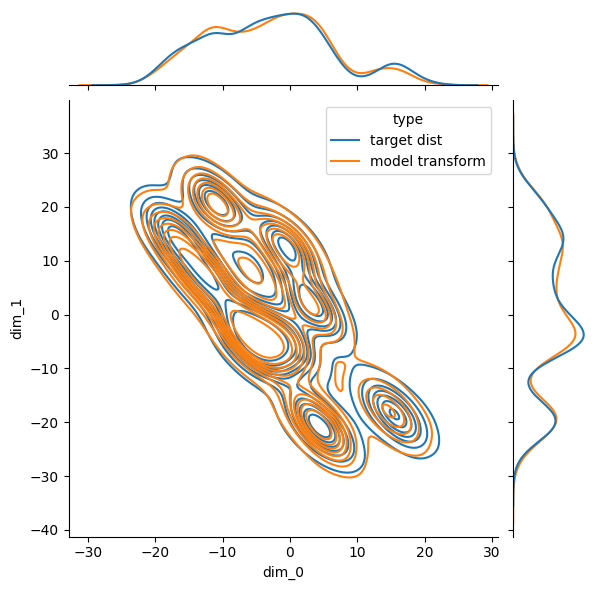

trail: 0 m step: 35 kl_test: 0.38719940185546875


  2%|▏         | 100/6000 [00:32<35:16,  2.79it/s]

trail: 0 m step: 36 Loss: 0.3673877716064453  L_n: 0.3570880889892578  kld: 0.000514984130859375 KLD1: 0.3545909523963928 KLD2: 0.25047367811203003


  3%|▎         | 200/6000 [01:04<34:06,  2.83it/s]

trail: 0 m step: 36 Loss: 0.4025421142578125  L_n: 0.36298370361328125  kld: 0.0019779205322265625 KLD1: 0.3640473186969757 KLD2: 0.2517348527908325


  5%|▌         | 300/6000 [01:36<33:42,  2.82it/s]

trail: 0 m step: 36 Loss: 0.38467979431152344  L_n: 0.35538291931152344  kld: 0.00146484375 KLD1: 0.3525926172733307 KLD2: 0.2508086860179901


  7%|▋         | 400/6000 [02:08<33:05,  2.82it/s]

trail: 0 m step: 36 Loss: 0.39499664306640625  L_n: 0.37172698974609375  kld: 0.001163482666015625 KLD1: 0.35881006717681885 KLD2: 0.24602484703063965


  8%|▊         | 500/6000 [02:40<32:21,  2.83it/s]

trail: 0 m step: 36 Loss: 0.3967857360839844  L_n: 0.3550910949707031  kld: 0.0020847320556640625 KLD1: 0.3709878623485565 KLD2: 0.25303778052330017


 10%|█         | 600/6000 [03:12<31:53,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3896961212158203  L_n: 0.35143470764160156  kld: 0.0019130706787109375 KLD1: 0.36079955101013184 KLD2: 0.25654536485671997


 12%|█▏        | 700/6000 [03:44<31:14,  2.83it/s]

trail: 0 m step: 36 Loss: 0.3981342315673828  L_n: 0.35582923889160156  kld: 0.0021152496337890625 KLD1: 0.33839958906173706 KLD2: 0.26217329502105713


 13%|█▎        | 800/6000 [04:16<30:46,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3869667053222656  L_n: 0.3517570495605469  kld: 0.0017604827880859375 KLD1: 0.34331029653549194 KLD2: 0.27237042784690857


 15%|█▌        | 900/6000 [04:48<30:05,  2.82it/s]

trail: 0 m step: 36 Loss: 0.40822601318359375  L_n: 0.35314178466796875  kld: 0.00275421142578125 KLD1: 0.36637216806411743 KLD2: 0.2469639629125595


 17%|█▋        | 1000/6000 [05:20<29:30,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3583259582519531  L_n: 0.3333778381347656  kld: 0.001247406005859375 KLD1: 0.35510629415512085 KLD2: 0.24801644682884216


 18%|█▊        | 1100/6000 [05:53<28:54,  2.82it/s]

trail: 0 m step: 36 Loss: 0.377471923828125  L_n: 0.34100341796875  kld: 0.00182342529296875 KLD1: 0.3618276119232178 KLD2: 0.23669852316379547


 20%|██        | 1200/6000 [06:25<28:25,  2.81it/s]

trail: 0 m step: 36 Loss: 0.39246368408203125  L_n: 0.36576080322265625  kld: 0.00133514404296875 KLD1: 0.3506545126438141 KLD2: 0.25332704186439514


 22%|██▏       | 1300/6000 [06:57<27:45,  2.82it/s]

trail: 0 m step: 36 Loss: 0.37058067321777344  L_n: 0.34258079528808594  kld: 0.001399993896484375 KLD1: 0.36271703243255615 KLD2: 0.25352054834365845


 23%|██▎       | 1400/6000 [07:29<27:11,  2.82it/s]

trail: 0 m step: 36 Loss: 0.42471885681152344  L_n: 0.3723430633544922  kld: 0.0026187896728515625 KLD1: 0.33529824018478394 KLD2: 0.2395557016134262


 25%|██▌       | 1500/6000 [08:01<26:40,  2.81it/s]

trail: 0 m step: 36 Loss: 0.38797760009765625  L_n: 0.35284423828125  kld: 0.0017566680908203125 KLD1: 0.3568924367427826 KLD2: 0.2417396456003189


 27%|██▋       | 1600/6000 [08:33<26:00,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3859672546386719  L_n: 0.3665504455566406  kld: 0.0009708404541015625 KLD1: 0.3530689775943756 KLD2: 0.2569079101085663


 28%|██▊       | 1700/6000 [09:05<25:26,  2.82it/s]

trail: 0 m step: 36 Loss: 0.42133331298828125  L_n: 0.38112640380859375  kld: 0.002010345458984375 KLD1: 0.34781306982040405 KLD2: 0.2562325596809387


 30%|███       | 1800/6000 [09:37<24:56,  2.81it/s]

trail: 0 m step: 36 Loss: 0.38980674743652344  L_n: 0.3601665496826172  kld: 0.0014820098876953125 KLD1: 0.3635559380054474 KLD2: 0.2472812384366989


 32%|███▏      | 1900/6000 [10:10<24:15,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3848857879638672  L_n: 0.34540367126464844  kld: 0.0019741058349609375 KLD1: 0.3626496493816376 KLD2: 0.2616159915924072


 33%|███▎      | 2000/6000 [10:42<23:43,  2.81it/s]

trail: 0 m step: 36 Loss: 0.4014930725097656  L_n: 0.3411064147949219  kld: 0.0030193328857421875 KLD1: 0.35614344477653503 KLD2: 0.2558368146419525


 35%|███▌      | 2100/6000 [11:14<23:00,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3689689636230469  L_n: 0.3413124084472656  kld: 0.0013828277587890625 KLD1: 0.3556324243545532 KLD2: 0.2614002823829651


 37%|███▋      | 2200/6000 [11:46<22:28,  2.82it/s]

trail: 0 m step: 36 Loss: 0.39138221740722656  L_n: 0.36376380920410156  kld: 0.00138092041015625 KLD1: 0.3475324511528015 KLD2: 0.2581203281879425


 38%|███▊      | 2300/6000 [12:18<21:54,  2.82it/s]

trail: 0 m step: 36 Loss: 0.36557960510253906  L_n: 0.35230445861816406  kld: 0.00066375732421875 KLD1: 0.3718039393424988 KLD2: 0.24288475513458252


 40%|████      | 2400/6000 [12:50<21:14,  2.82it/s]

trail: 0 m step: 36 Loss: 0.37746620178222656  L_n: 0.35236549377441406  kld: 0.001255035400390625 KLD1: 0.3520352244377136 KLD2: 0.2571795880794525


 42%|████▏     | 2500/6000 [13:22<20:40,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3917560577392578  L_n: 0.36486244201660156  kld: 0.0013446807861328125 KLD1: 0.35131514072418213 KLD2: 0.24817560613155365


 43%|████▎     | 2600/6000 [13:55<20:05,  2.82it/s]

trail: 0 m step: 36 Loss: 0.36334228515625  L_n: 0.334503173828125  kld: 0.00144195556640625 KLD1: 0.34662583470344543 KLD2: 0.24846571683883667


 45%|████▌     | 2700/6000 [14:27<19:31,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3810997009277344  L_n: 0.3483314514160156  kld: 0.0016384124755859375 KLD1: 0.3503100574016571 KLD2: 0.24562601745128632


 47%|████▋     | 2800/6000 [14:59<18:55,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3927879333496094  L_n: 0.3589515686035156  kld: 0.0016918182373046875 KLD1: 0.3721073567867279 KLD2: 0.24436937272548676


 48%|████▊     | 2900/6000 [15:31<18:17,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3874473571777344  L_n: 0.3532676696777344  kld: 0.001708984375 KLD1: 0.3525250256061554 KLD2: 0.25018489360809326


 50%|█████     | 3000/6000 [16:03<17:50,  2.80it/s]

trail: 0 m step: 36 Loss: 0.3487873077392578  L_n: 0.3329181671142578  kld: 0.00079345703125 KLD1: 0.37508586049079895 KLD2: 0.24730871617794037


 52%|█████▏    | 3100/6000 [16:35<17:18,  2.79it/s]

trail: 0 m step: 36 Loss: 0.3530864715576172  L_n: 0.3334789276123047  kld: 0.000980377197265625 KLD1: 0.33992666006088257 KLD2: 0.2586241662502289


 53%|█████▎    | 3200/6000 [17:07<16:41,  2.80it/s]

trail: 0 m step: 36 Loss: 0.3745136260986328  L_n: 0.3534564971923828  kld: 0.0010528564453125 KLD1: 0.3498443365097046 KLD2: 0.24403470754623413


 55%|█████▌    | 3300/6000 [17:39<15:56,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3887615203857422  L_n: 0.37026023864746094  kld: 0.0009250640869140625 KLD1: 0.3553605079650879 KLD2: 0.24781686067581177


 57%|█████▋    | 3400/6000 [18:11<15:19,  2.83it/s]

trail: 0 m step: 36 Loss: 0.36426353454589844  L_n: 0.34053611755371094  kld: 0.001186370849609375 KLD1: 0.34325698018074036 KLD2: 0.2507556080818176


 58%|█████▊    | 3500/6000 [18:43<14:47,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3889961242675781  L_n: 0.3567237854003906  kld: 0.001613616943359375 KLD1: 0.33126160502433777 KLD2: 0.24125218391418457


 60%|██████    | 3600/6000 [19:16<14:12,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3744335174560547  L_n: 0.35021018981933594  kld: 0.0012111663818359375 KLD1: 0.35881516337394714 KLD2: 0.26166191697120667


 62%|██████▏   | 3700/6000 [19:48<13:35,  2.82it/s]

trail: 0 m step: 36 Loss: 0.39836692810058594  L_n: 0.36227989196777344  kld: 0.001804351806640625 KLD1: 0.3456018567085266 KLD2: 0.2557904124259949


 63%|██████▎   | 3800/6000 [20:20<13:01,  2.81it/s]

trail: 0 m step: 36 Loss: 0.3831748962402344  L_n: 0.3439216613769531  kld: 0.0019626617431640625 KLD1: 0.360965371131897 KLD2: 0.2368367314338684


 65%|██████▌   | 3900/6000 [20:52<11:45,  2.98it/s]

trail: 0 m step: 36 Loss: 0.4051780700683594  L_n: 0.3634071350097656  kld: 0.0020885467529296875 KLD1: 0.3372390568256378 KLD2: 0.24637621641159058


 67%|██████▋   | 4000/6000 [21:24<11:50,  2.81it/s]

trail: 0 m step: 36 Loss: 0.3782520294189453  L_n: 0.3486499786376953  kld: 0.0014801025390625 KLD1: 0.35885825753211975 KLD2: 0.2496957927942276


 68%|██████▊   | 4100/6000 [21:56<10:49,  2.93it/s]

trail: 0 m step: 36 Loss: 0.3993053436279297  L_n: 0.36600303649902344  kld: 0.0016651153564453125 KLD1: 0.3337043523788452 KLD2: 0.24958254396915436


 70%|███████   | 4200/6000 [22:28<10:38,  2.82it/s]

trail: 0 m step: 36 Loss: 0.3619518280029297  L_n: 0.34413719177246094  kld: 0.0008907318115234375 KLD1: 0.34986546635627747 KLD2: 0.2490520477294922


 72%|███████▏  | 4300/6000 [23:00<10:04,  2.81it/s]

trail: 0 m step: 36 Loss: 0.38073158264160156  L_n: 0.35769081115722656  kld: 0.00115203857421875 KLD1: 0.35531631112098694 KLD2: 0.258406400680542


 73%|███████▎  | 4400/6000 [23:32<09:30,  2.81it/s]

trail: 0 m step: 36 Loss: 0.37392425537109375  L_n: 0.35431671142578125  kld: 0.000980377197265625 KLD1: 0.3427852988243103 KLD2: 0.2451680302619934


 75%|███████▌  | 4500/6000 [24:04<08:49,  2.83it/s]

trail: 0 m step: 36 Loss: 0.4072761535644531  L_n: 0.3751182556152344  kld: 0.0016078948974609375 KLD1: 0.34834346175193787 KLD2: 0.25091639161109924


 77%|███████▋  | 4600/6000 [24:36<08:15,  2.82it/s]

trail: 0 m step: 36 Loss: 0.36935997009277344  L_n: 0.3474254608154297  kld: 0.0010967254638671875 KLD1: 0.36542803049087524 KLD2: 0.26019150018692017


 78%|███████▊  | 4700/6000 [25:08<07:40,  2.82it/s]

trail: 0 m step: 36 Loss: 0.35997772216796875  L_n: 0.355133056640625  kld: 0.0002422332763671875 KLD1: 0.3496524393558502 KLD2: 0.248665913939476


 80%|████████  | 4800/6000 [25:40<07:06,  2.81it/s]

trail: 0 m step: 36 Loss: 0.3728199005126953  L_n: 0.3567218780517578  kld: 0.000804901123046875 KLD1: 0.3429574966430664 KLD2: 0.25429344177246094


 82%|████████▏ | 4900/6000 [26:12<06:25,  2.85it/s]

trail: 0 m step: 36 Loss: 0.3628196716308594  L_n: 0.3493537902832031  kld: 0.0006732940673828125 KLD1: 0.3662383556365967 KLD2: 0.24423514306545258


 83%|████████▎ | 5000/6000 [26:44<05:57,  2.80it/s]

trail: 0 m step: 36 Loss: 0.3772563934326172  L_n: 0.36791038513183594  kld: 0.0004673004150390625 KLD1: 0.3546369969844818 KLD2: 0.2533547878265381


 85%|████████▌ | 5100/6000 [27:16<05:19,  2.82it/s]

trail: 0 m step: 36 Loss: 0.36611175537109375  L_n: 0.34650421142578125  kld: 0.000980377197265625 KLD1: 0.3584200143814087 KLD2: 0.2670419216156006


 87%|████████▋ | 5200/6000 [27:48<04:44,  2.81it/s]

trail: 0 m step: 36 Loss: 0.37151145935058594  L_n: 0.3523998260498047  kld: 0.0009555816650390625 KLD1: 0.3419729769229889 KLD2: 0.2564876973628998


 88%|████████▊ | 5300/6000 [28:20<04:10,  2.80it/s]

trail: 0 m step: 36 Loss: 0.38082313537597656  L_n: 0.3534717559814453  kld: 0.0013675689697265625 KLD1: 0.34748491644859314 KLD2: 0.2477617859840393


 90%|█████████ | 5400/6000 [28:52<03:34,  2.80it/s]

trail: 0 m step: 36 Loss: 0.38083839416503906  L_n: 0.3540973663330078  kld: 0.0013370513916015625 KLD1: 0.36045607924461365 KLD2: 0.24708989262580872


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.81it/s]

trail: 0 m step: 36 Loss: 0.36845970153808594  L_n: 0.35129356384277344  kld: 0.000858306884765625 KLD1: 0.35279667377471924 KLD2: 0.25807613134384155


 93%|█████████▎| 5600/6000 [29:57<02:22,  2.82it/s]

trail: 0 m step: 36 Loss: 0.37500762939453125  L_n: 0.35700225830078125  kld: 0.0009002685546875 KLD1: 0.3514612317085266 KLD2: 0.24545936286449432


 95%|█████████▌| 5700/6000 [30:29<01:46,  2.81it/s]

trail: 0 m step: 36 Loss: 0.3664131164550781  L_n: 0.3447456359863281  kld: 0.0010833740234375 KLD1: 0.32780659198760986 KLD2: 0.2506715655326843


 97%|█████████▋| 5800/6000 [31:01<01:11,  2.80it/s]

trail: 0 m step: 36 Loss: 0.3953819274902344  L_n: 0.3737525939941406  kld: 0.0010814666748046875 KLD1: 0.35753560066223145 KLD2: 0.24557988345623016


 98%|█████████▊| 5900/6000 [31:33<00:35,  2.79it/s]

trail: 0 m step: 36 Loss: 0.38771629333496094  L_n: 0.36551475524902344  kld: 0.001110076904296875 KLD1: 0.36144623160362244 KLD2: 0.26071375608444214


100%|██████████| 6000/6000 [32:05<00:00,  3.12it/s]

trail: 0 m step: 36 Loss: 0.3733196258544922  L_n: 0.36069297790527344  kld: 0.0006313323974609375 KLD1: 0.34458088874816895 KLD2: 0.2519705593585968



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


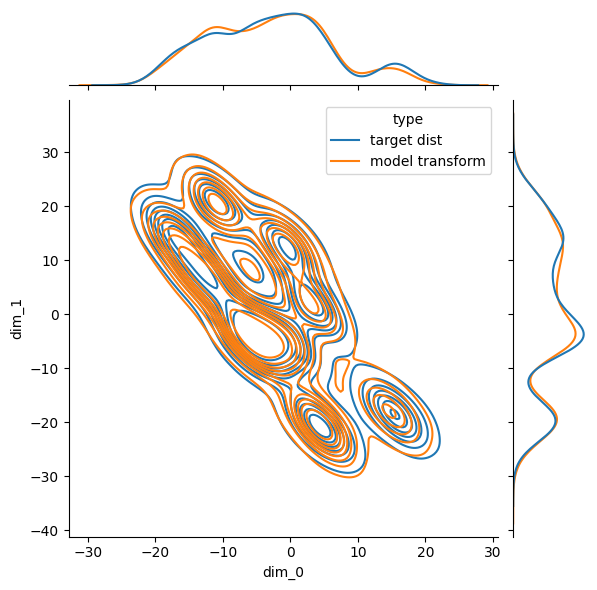

trail: 0 m step: 36 kl_test: 0.37012481689453125


  2%|▏         | 100/6000 [00:31<34:43,  2.83it/s]

trail: 0 m step: 37 Loss: 0.34446144104003906  L_n: 0.33881568908691406  kld: 0.00028228759765625 KLD1: 0.3458764851093292 KLD2: 0.2469201385974884


  3%|▎         | 200/6000 [01:03<34:23,  2.81it/s]

trail: 0 m step: 37 Loss: 0.38787841796875  L_n: 0.34881591796875  kld: 0.001953125 KLD1: 0.3511430323123932 KLD2: 0.2468399852514267


  5%|▌         | 300/6000 [01:35<33:46,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3684425354003906  L_n: 0.3367042541503906  kld: 0.0015869140625 KLD1: 0.35174867510795593 KLD2: 0.2444208413362503


  7%|▋         | 400/6000 [02:07<33:10,  2.81it/s]

trail: 0 m step: 37 Loss: 0.38466453552246094  L_n: 0.3439617156982422  kld: 0.0020351409912109375 KLD1: 0.34606486558914185 KLD2: 0.2387620508670807


  8%|▊         | 500/6000 [02:40<32:28,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3824195861816406  L_n: 0.3367958068847656  kld: 0.00228118896484375 KLD1: 0.3440747559070587 KLD2: 0.24608159065246582


 10%|█         | 600/6000 [03:12<32:00,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3823394775390625  L_n: 0.33782196044921875  kld: 0.0022258758544921875 KLD1: 0.34484514594078064 KLD2: 0.24954533576965332


 12%|█▏        | 700/6000 [03:44<31:20,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3731040954589844  L_n: 0.3327445983886719  kld: 0.002017974853515625 KLD1: 0.3299715220928192 KLD2: 0.25540387630462646


 13%|█▎        | 800/6000 [04:16<30:50,  2.81it/s]

trail: 0 m step: 37 Loss: 0.374725341796875  L_n: 0.32715606689453125  kld: 0.0023784637451171875 KLD1: 0.3436640202999115 KLD2: 0.26430580019950867


 15%|█▌        | 900/6000 [04:48<30:07,  2.82it/s]

trail: 0 m step: 37 Loss: 0.38910675048828125  L_n: 0.3328399658203125  kld: 0.0028133392333984375 KLD1: 0.3561360538005829 KLD2: 0.23947052657604218


 17%|█▋        | 1000/6000 [05:21<29:35,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3600788116455078  L_n: 0.3209400177001953  kld: 0.001956939697265625 KLD1: 0.3337891101837158 KLD2: 0.24265211820602417


 18%|█▊        | 1100/6000 [05:53<29:03,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3782787322998047  L_n: 0.3354015350341797  kld: 0.00214385986328125 KLD1: 0.36045828461647034 KLD2: 0.22936996817588806


 20%|██        | 1200/6000 [06:25<28:28,  2.81it/s]

trail: 0 m step: 37 Loss: 0.40629005432128906  L_n: 0.3614673614501953  kld: 0.0022411346435546875 KLD1: 0.34055984020233154 KLD2: 0.24455781280994415


 22%|██▏       | 1300/6000 [06:57<27:57,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3622455596923828  L_n: 0.3321094512939453  kld: 0.001506805419921875 KLD1: 0.35220035910606384 KLD2: 0.24768315255641937


 23%|██▎       | 1400/6000 [07:30<27:23,  2.80it/s]

trail: 0 m step: 37 Loss: 0.40625953674316406  L_n: 0.35460853576660156  kld: 0.002582550048828125 KLD1: 0.32823118567466736 KLD2: 0.23329882323741913


 25%|██▌       | 1500/6000 [08:02<26:44,  2.80it/s]

trail: 0 m step: 37 Loss: 0.36231422424316406  L_n: 0.3396930694580078  kld: 0.0011310577392578125 KLD1: 0.3450815975666046 KLD2: 0.23790177702903748


 27%|██▋       | 1600/6000 [08:34<25:59,  2.82it/s]

trail: 0 m step: 37 Loss: 0.365753173828125  L_n: 0.33802032470703125  kld: 0.0013866424560546875 KLD1: 0.34747475385665894 KLD2: 0.25317737460136414


 28%|██▊       | 1700/6000 [09:06<25:44,  2.78it/s]

trail: 0 m step: 37 Loss: 0.3953208923339844  L_n: 0.3525962829589844  kld: 0.00213623046875 KLD1: 0.33019089698791504 KLD2: 0.25263872742652893


 30%|███       | 1800/6000 [09:39<24:54,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3877391815185547  L_n: 0.3464641571044922  kld: 0.002063751220703125 KLD1: 0.354831337928772 KLD2: 0.2432193011045456


 32%|███▏      | 1900/6000 [10:11<24:11,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3649253845214844  L_n: 0.3275413513183594  kld: 0.00186920166015625 KLD1: 0.3375221788883209 KLD2: 0.25770923495292664


 33%|███▎      | 2000/6000 [10:43<23:42,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3950538635253906  L_n: 0.3349342346191406  kld: 0.0030059814453125 KLD1: 0.3470292389392853 KLD2: 0.25299251079559326


 35%|███▌      | 2100/6000 [11:15<23:10,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3747215270996094  L_n: 0.3450431823730469  kld: 0.001483917236328125 KLD1: 0.33887332677841187 KLD2: 0.2566596269607544


 37%|███▋      | 2200/6000 [11:47<22:32,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3909416198730469  L_n: 0.3553886413574219  kld: 0.00177764892578125 KLD1: 0.3463742434978485 KLD2: 0.2539249062538147


 38%|███▊      | 2300/6000 [12:19<21:56,  2.81it/s]

trail: 0 m step: 37 Loss: 0.38671875  L_n: 0.357574462890625  kld: 0.00145721435546875 KLD1: 0.3689543902873993 KLD2: 0.24150888621807098


 40%|████      | 2400/6000 [12:51<21:27,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3698101043701172  L_n: 0.3408184051513672  kld: 0.0014495849609375 KLD1: 0.3375757336616516 KLD2: 0.25585177540779114


 42%|████▏     | 2500/6000 [13:24<20:44,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3856468200683594  L_n: 0.3571128845214844  kld: 0.00142669677734375 KLD1: 0.3347233235836029 KLD2: 0.24536244571208954


 43%|████▎     | 2600/6000 [13:56<18:27,  3.07it/s]

trail: 0 m step: 37 Loss: 0.3423194885253906  L_n: 0.3137855529785156  kld: 0.00142669677734375 KLD1: 0.3373950123786926 KLD2: 0.24533036351203918


 45%|████▌     | 2700/6000 [14:28<19:35,  2.81it/s]

trail: 0 m step: 37 Loss: 0.35448455810546875  L_n: 0.33594512939453125  kld: 0.000926971435546875 KLD1: 0.34871843457221985 KLD2: 0.24007773399353027


 47%|████▋     | 2800/6000 [15:00<19:02,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3869361877441406  L_n: 0.3603858947753906  kld: 0.0013275146484375 KLD1: 0.35432612895965576 KLD2: 0.2406233549118042


 48%|████▊     | 2900/6000 [15:32<18:20,  2.82it/s]

trail: 0 m step: 37 Loss: 0.37564849853515625  L_n: 0.34345245361328125  kld: 0.00160980224609375 KLD1: 0.33047786355018616 KLD2: 0.24643300473690033


 50%|█████     | 3000/6000 [16:04<17:47,  2.81it/s]

trail: 0 m step: 37 Loss: 0.33626747131347656  L_n: 0.32383155822753906  kld: 0.000621795654296875 KLD1: 0.3660108745098114 KLD2: 0.24523864686489105


 52%|█████▏    | 3100/6000 [16:36<17:08,  2.82it/s]

trail: 0 m step: 37 Loss: 0.36464691162109375  L_n: 0.33416748046875  kld: 0.0015239715576171875 KLD1: 0.32576674222946167 KLD2: 0.25503960251808167


 53%|█████▎    | 3200/6000 [17:09<16:38,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3742256164550781  L_n: 0.3500022888183594  kld: 0.0012111663818359375 KLD1: 0.342055082321167 KLD2: 0.23996205627918243


 55%|█████▌    | 3300/6000 [17:41<15:59,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3673267364501953  L_n: 0.3502368927001953  kld: 0.0008544921875 KLD1: 0.33306288719177246 KLD2: 0.2451809197664261


 57%|█████▋    | 3400/6000 [18:13<15:24,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3571796417236328  L_n: 0.33341407775878906  kld: 0.0011882781982421875 KLD1: 0.3445403277873993 KLD2: 0.2485392540693283


 58%|█████▊    | 3500/6000 [18:45<14:44,  2.83it/s]

trail: 0 m step: 37 Loss: 0.40119171142578125  L_n: 0.3610992431640625  kld: 0.0020046234130859375 KLD1: 0.3381601870059967 KLD2: 0.23821288347244263


 60%|██████    | 3600/6000 [19:17<14:07,  2.83it/s]

trail: 0 m step: 37 Loss: 0.37209129333496094  L_n: 0.34660911560058594  kld: 0.00127410888671875 KLD1: 0.3496358096599579 KLD2: 0.2594899833202362


 62%|██████▏   | 3700/6000 [19:49<13:33,  2.83it/s]

trail: 0 m step: 37 Loss: 0.3847503662109375  L_n: 0.34603118896484375  kld: 0.0019359588623046875 KLD1: 0.32626888155937195 KLD2: 0.2525953948497772


 63%|██████▎   | 3800/6000 [20:21<13:01,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3637409210205078  L_n: 0.3320026397705078  kld: 0.0015869140625 KLD1: 0.338288813829422 KLD2: 0.2331618070602417


 65%|██████▌   | 3900/6000 [20:53<12:27,  2.81it/s]

trail: 0 m step: 37 Loss: 0.36196327209472656  L_n: 0.34159278869628906  kld: 0.001018524169921875 KLD1: 0.331268846988678 KLD2: 0.2433825135231018


 67%|██████▋   | 4000/6000 [21:25<11:47,  2.83it/s]

trail: 0 m step: 37 Loss: 0.3736763000488281  L_n: 0.3408699035644531  kld: 0.00164031982421875 KLD1: 0.3507993221282959 KLD2: 0.24465739727020264


 68%|██████▊   | 4100/6000 [21:58<11:13,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3759441375732422  L_n: 0.3449687957763672  kld: 0.00154876708984375 KLD1: 0.32493188977241516 KLD2: 0.24685736000537872


 70%|███████   | 4200/6000 [22:30<10:40,  2.81it/s]

trail: 0 m step: 37 Loss: 0.37109947204589844  L_n: 0.34439659118652344  kld: 0.00133514404296875 KLD1: 0.3383875787258148 KLD2: 0.24541041254997253


 72%|███████▏  | 4300/6000 [23:02<10:02,  2.82it/s]

trail: 0 m step: 37 Loss: 0.36380577087402344  L_n: 0.3418712615966797  kld: 0.0010967254638671875 KLD1: 0.34581831097602844 KLD2: 0.25365397334098816


 73%|███████▎  | 4400/6000 [23:34<09:28,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3500099182128906  L_n: 0.3330726623535156  kld: 0.00084686279296875 KLD1: 0.3347901701927185 KLD2: 0.2414788007736206


 75%|███████▌  | 4500/6000 [24:06<08:46,  2.85it/s]

trail: 0 m step: 37 Loss: 0.38185691833496094  L_n: 0.36110496520996094  kld: 0.00103759765625 KLD1: 0.35195037722587585 KLD2: 0.24848739802837372


 77%|███████▋  | 4600/6000 [24:38<08:18,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3649253845214844  L_n: 0.3432960510253906  kld: 0.0010814666748046875 KLD1: 0.3483004868030548 KLD2: 0.25550588965415955


 78%|███████▊  | 4700/6000 [25:10<07:43,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3577766418457031  L_n: 0.3530845642089844  kld: 0.0002346038818359375 KLD1: 0.34955957531929016 KLD2: 0.24468271434307098


 80%|████████  | 4800/6000 [25:43<07:06,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3711204528808594  L_n: 0.3500251770019531  kld: 0.0010547637939453125 KLD1: 0.33826756477355957 KLD2: 0.24943456053733826


 82%|████████▏ | 4900/6000 [26:15<06:27,  2.84it/s]

trail: 0 m step: 37 Loss: 0.3403892517089844  L_n: 0.3261222839355469  kld: 0.000713348388671875 KLD1: 0.3447681963443756 KLD2: 0.24057035148143768


 83%|████████▎ | 5000/6000 [26:47<05:53,  2.83it/s]

trail: 0 m step: 37 Loss: 0.3595104217529297  L_n: 0.3460063934326172  kld: 0.000675201416015625 KLD1: 0.347851037979126 KLD2: 0.2484419196844101


 85%|████████▌ | 5100/6000 [27:19<05:18,  2.83it/s]

trail: 0 m step: 37 Loss: 0.3622570037841797  L_n: 0.34955406188964844  kld: 0.0006351470947265625 KLD1: 0.34560588002204895 KLD2: 0.2625187039375305


 87%|████████▋ | 5200/6000 [27:51<04:45,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3700847625732422  L_n: 0.3466625213623047  kld: 0.001171112060546875 KLD1: 0.32780367136001587 KLD2: 0.25199833512306213


 88%|████████▊ | 5300/6000 [28:23<04:11,  2.79it/s]

trail: 0 m step: 37 Loss: 0.3719062805175781  L_n: 0.3474922180175781  kld: 0.001220703125 KLD1: 0.3337247371673584 KLD2: 0.24479398131370544


 90%|█████████ | 5400/6000 [28:55<03:33,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3665275573730469  L_n: 0.3379173278808594  kld: 0.001430511474609375 KLD1: 0.34556615352630615 KLD2: 0.2422248274087906


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.81it/s]

trail: 0 m step: 37 Loss: 0.3647613525390625  L_n: 0.34908294677734375  kld: 0.0007839202880859375 KLD1: 0.3291570246219635 KLD2: 0.2532777488231659


 93%|█████████▎| 5600/6000 [29:59<02:22,  2.82it/s]

trail: 0 m step: 37 Loss: 0.3869361877441406  L_n: 0.3554649353027344  kld: 0.0015735626220703125 KLD1: 0.33747467398643494 KLD2: 0.24134616553783417


 95%|█████████▌| 5700/6000 [30:31<01:47,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3504066467285156  L_n: 0.3313331604003906  kld: 0.00095367431640625 KLD1: 0.3251369297504425 KLD2: 0.24556927382946014


 97%|█████████▋| 5800/6000 [31:03<01:11,  2.80it/s]

trail: 0 m step: 37 Loss: 0.3667621612548828  L_n: 0.34894752502441406  kld: 0.0008907318115234375 KLD1: 0.33569470047950745 KLD2: 0.24025239050388336


 98%|█████████▊| 5900/6000 [31:35<00:35,  2.81it/s]

trail: 0 m step: 37 Loss: 0.35643768310546875  L_n: 0.3455657958984375  kld: 0.0005435943603515625 KLD1: 0.34649115800857544 KLD2: 0.25431323051452637


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 37 Loss: 0.3776664733886719  L_n: 0.3625984191894531  kld: 0.0007534027099609375 KLD1: 0.3403019309043884 KLD2: 0.24623039364814758



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


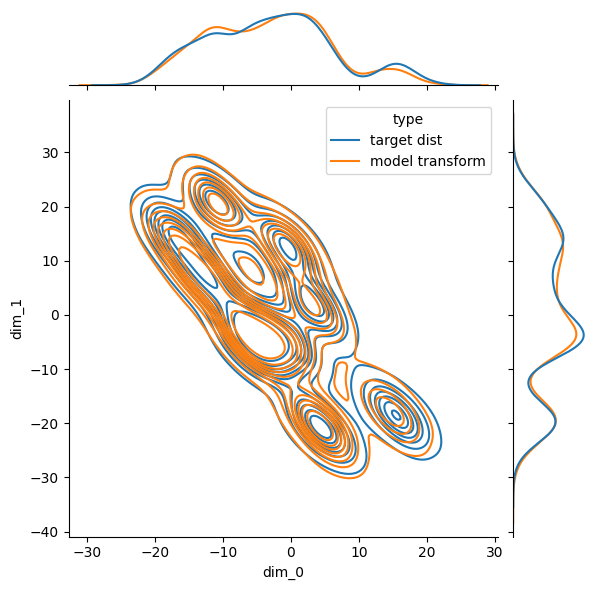

trail: 0 m step: 37 kl_test: 0.35562896728515625


  2%|▏         | 100/6000 [00:31<34:53,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3461627960205078  L_n: 0.3292255401611328  kld: 0.00084686279296875 KLD1: 0.33694297075271606 KLD2: 0.23930604755878448


  3%|▎         | 200/6000 [01:03<34:17,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3928070068359375  L_n: 0.35187530517578125  kld: 0.0020465850830078125 KLD1: 0.33987957239151 KLD2: 0.2381819784641266


  5%|▌         | 300/6000 [01:36<33:46,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3519172668457031  L_n: 0.3176994323730469  kld: 0.0017108917236328125 KLD1: 0.3371414542198181 KLD2: 0.24017679691314697


  7%|▋         | 400/6000 [02:08<33:31,  2.78it/s]

trail: 0 m step: 38 Loss: 0.3901824951171875  L_n: 0.349365234375  kld: 0.002040863037109375 KLD1: 0.33612480759620667 KLD2: 0.2343151569366455


  8%|▊         | 500/6000 [02:40<32:32,  2.82it/s]

trail: 0 m step: 38 Loss: 0.36491966247558594  L_n: 0.33211326599121094  kld: 0.00164031982421875 KLD1: 0.32905319333076477 KLD2: 0.24113185703754425


 10%|█         | 600/6000 [03:13<32:10,  2.80it/s]

trail: 0 m step: 38 Loss: 0.35056114196777344  L_n: 0.3171062469482422  kld: 0.0016727447509765625 KLD1: 0.32716748118400574 KLD2: 0.24445444345474243


 12%|█▏        | 700/6000 [03:45<31:28,  2.81it/s]

trail: 0 m step: 38 Loss: 0.37172889709472656  L_n: 0.3363666534423828  kld: 0.0017681121826171875 KLD1: 0.3293924331665039 KLD2: 0.25138452649116516


 13%|█▎        | 800/6000 [04:17<30:51,  2.81it/s]

trail: 0 m step: 38 Loss: 0.37358665466308594  L_n: 0.3184642791748047  kld: 0.0027561187744140625 KLD1: 0.3261190950870514 KLD2: 0.25840532779693604


 15%|█▌        | 900/6000 [04:49<30:17,  2.81it/s]

trail: 0 m step: 38 Loss: 0.371551513671875  L_n: 0.31681060791015625  kld: 0.0027370452880859375 KLD1: 0.33716079592704773 KLD2: 0.23356270790100098


 17%|█▋        | 1000/6000 [05:21<29:38,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3412017822265625  L_n: 0.3044281005859375  kld: 0.00183868408203125 KLD1: 0.3382062017917633 KLD2: 0.23680390417575836


 18%|█▊        | 1100/6000 [05:54<29:01,  2.81it/s]

trail: 0 m step: 38 Loss: 0.35561561584472656  L_n: 0.32502174377441406  kld: 0.001529693603515625 KLD1: 0.35327112674713135 KLD2: 0.2244521975517273


 20%|██        | 1200/6000 [06:26<28:29,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3671112060546875  L_n: 0.33190155029296875  kld: 0.0017604827880859375 KLD1: 0.32933005690574646 KLD2: 0.2399795800447464


 22%|██▏       | 1300/6000 [06:58<27:44,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3561229705810547  L_n: 0.3279705047607422  kld: 0.001407623291015625 KLD1: 0.3316042423248291 KLD2: 0.2420608401298523


 23%|██▎       | 1400/6000 [07:30<27:17,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3840770721435547  L_n: 0.3444042205810547  kld: 0.001983642578125 KLD1: 0.32818934321403503 KLD2: 0.22821088135242462


 25%|██▌       | 1500/6000 [08:02<26:40,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3666534423828125  L_n: 0.337890625  kld: 0.001438140869140625 KLD1: 0.3371652066707611 KLD2: 0.2305440902709961


 27%|██▋       | 1600/6000 [08:35<26:05,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3673248291015625  L_n: 0.34416961669921875  kld: 0.0011577606201171875 KLD1: 0.34574592113494873 KLD2: 0.24471066892147064


 28%|██▊       | 1700/6000 [09:07<25:23,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3999652862548828  L_n: 0.35369300842285156  kld: 0.0023136138916015625 KLD1: 0.323760062456131 KLD2: 0.24351972341537476


 30%|███       | 1800/6000 [09:39<24:55,  2.81it/s]

trail: 0 m step: 38 Loss: 0.391693115234375  L_n: 0.34244537353515625  kld: 0.0024623870849609375 KLD1: 0.3461315929889679 KLD2: 0.23551559448242188


 32%|███▏      | 1900/6000 [10:11<24:11,  2.83it/s]

trail: 0 m step: 38 Loss: 0.3706340789794922  L_n: 0.31978416442871094  kld: 0.0025424957275390625 KLD1: 0.3213471472263336 KLD2: 0.2510184943675995


 33%|███▎      | 2000/6000 [10:43<23:50,  2.80it/s]

trail: 0 m step: 38 Loss: 0.36525535583496094  L_n: 0.3205089569091797  kld: 0.0022373199462890625 KLD1: 0.33749833703041077 KLD2: 0.24439746141433716


 35%|███▌      | 2100/6000 [11:16<23:09,  2.81it/s]

trail: 0 m step: 38 Loss: 0.37348365783691406  L_n: 0.3348407745361328  kld: 0.0019321441650390625 KLD1: 0.32326406240463257 KLD2: 0.24899230897426605


 37%|███▋      | 2200/6000 [11:48<22:31,  2.81it/s]

trail: 0 m step: 38 Loss: 0.38263702392578125  L_n: 0.33544921875  kld: 0.0023593902587890625 KLD1: 0.33010390400886536 KLD2: 0.2452128827571869


 38%|███▊      | 2300/6000 [12:20<21:54,  2.81it/s]

trail: 0 m step: 38 Loss: 0.36524009704589844  L_n: 0.3378124237060547  kld: 0.0013713836669921875 KLD1: 0.3551573157310486 KLD2: 0.23116160929203033


 40%|████      | 2400/6000 [12:52<21:21,  2.81it/s]

trail: 0 m step: 38 Loss: 0.33654212951660156  L_n: 0.3185749053955078  kld: 0.0008983612060546875 KLD1: 0.3383445143699646 KLD2: 0.24721556901931763


 42%|████▏     | 2500/6000 [13:25<20:35,  2.83it/s]

trail: 0 m step: 38 Loss: 0.3651580810546875  L_n: 0.33277130126953125  kld: 0.0016193389892578125 KLD1: 0.3232608735561371 KLD2: 0.23793458938598633


 43%|████▎     | 2600/6000 [13:57<20:10,  2.81it/s]

trail: 0 m step: 38 Loss: 0.33880043029785156  L_n: 0.3152637481689453  kld: 0.0011768341064453125 KLD1: 0.3297610580921173 KLD2: 0.23917873203754425


 45%|████▌     | 2700/6000 [14:29<19:28,  2.83it/s]

trail: 0 m step: 38 Loss: 0.3501262664794922  L_n: 0.3227367401123047  kld: 0.001369476318359375 KLD1: 0.3253869116306305 KLD2: 0.23311017453670502


 47%|████▋     | 2800/6000 [15:01<18:55,  2.82it/s]

trail: 0 m step: 38 Loss: 0.35738563537597656  L_n: 0.3382740020751953  kld: 0.0009555816650390625 KLD1: 0.33669647574424744 KLD2: 0.2337031215429306


 48%|████▊     | 2900/6000 [15:33<18:18,  2.82it/s]

trail: 0 m step: 38 Loss: 0.36759185791015625  L_n: 0.33745574951171875  kld: 0.001506805419921875 KLD1: 0.33060574531555176 KLD2: 0.2400200366973877


 50%|█████     | 3000/6000 [16:05<17:45,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3160839080810547  L_n: 0.3079967498779297  kld: 0.00040435791015625 KLD1: 0.3483213782310486 KLD2: 0.23746933043003082


 52%|█████▏    | 3100/6000 [16:37<17:15,  2.80it/s]

trail: 0 m step: 38 Loss: 0.34880638122558594  L_n: 0.3164196014404297  kld: 0.0016193389892578125 KLD1: 0.319344162940979 KLD2: 0.24899770319461823


 53%|█████▎    | 3200/6000 [17:09<16:38,  2.80it/s]

trail: 0 m step: 38 Loss: 0.3518962860107422  L_n: 0.3425121307373047  kld: 0.000469207763671875 KLD1: 0.32082468271255493 KLD2: 0.23407059907913208


 55%|█████▌    | 3300/6000 [17:42<15:58,  2.82it/s]

trail: 0 m step: 38 Loss: 0.34282875061035156  L_n: 0.3360767364501953  kld: 0.0003376007080078125 KLD1: 0.32297876477241516 KLD2: 0.24008692800998688


 57%|█████▋    | 3400/6000 [18:14<15:28,  2.80it/s]

trail: 0 m step: 38 Loss: 0.3543357849121094  L_n: 0.3226737976074219  kld: 0.001583099365234375 KLD1: 0.3368957042694092 KLD2: 0.24286991357803345


 58%|█████▊    | 3500/6000 [18:46<14:46,  2.82it/s]

trail: 0 m step: 38 Loss: 0.39965057373046875  L_n: 0.36112213134765625  kld: 0.001926422119140625 KLD1: 0.3279722034931183 KLD2: 0.23175279796123505


 60%|██████    | 3600/6000 [19:18<14:13,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3799266815185547  L_n: 0.33548545837402344  kld: 0.0022220611572265625 KLD1: 0.3507288694381714 KLD2: 0.25572699308395386


 62%|██████▏   | 3700/6000 [19:50<13:35,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3798027038574219  L_n: 0.3436393737792969  kld: 0.00180816650390625 KLD1: 0.32546401023864746 KLD2: 0.2480311393737793


 63%|██████▎   | 3800/6000 [20:22<13:02,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3553028106689453  L_n: 0.32566261291503906  kld: 0.0014820098876953125 KLD1: 0.33684417605400085 KLD2: 0.22993329167366028


 65%|██████▌   | 3900/6000 [20:54<12:38,  2.77it/s]

trail: 0 m step: 38 Loss: 0.381988525390625  L_n: 0.3437652587890625  kld: 0.001911163330078125 KLD1: 0.32642486691474915 KLD2: 0.23910117149353027


 67%|██████▋   | 4000/6000 [21:27<11:55,  2.80it/s]

trail: 0 m step: 38 Loss: 0.3527565002441406  L_n: 0.3241081237792969  kld: 0.0014324188232421875 KLD1: 0.35263246297836304 KLD2: 0.2400570958852768


 68%|██████▊   | 4100/6000 [21:59<11:00,  2.88it/s]

trail: 0 m step: 38 Loss: 0.35797691345214844  L_n: 0.3325328826904297  kld: 0.0012722015380859375 KLD1: 0.32377713918685913 KLD2: 0.24148127436637878


 70%|███████   | 4200/6000 [22:31<10:44,  2.79it/s]

trail: 0 m step: 38 Loss: 0.33927154541015625  L_n: 0.31974029541015625  kld: 0.0009765625 KLD1: 0.33057117462158203 KLD2: 0.24106115102767944


 72%|███████▏  | 4300/6000 [23:03<10:03,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3556365966796875  L_n: 0.3330535888671875  kld: 0.001129150390625 KLD1: 0.3395496904850006 KLD2: 0.24932147562503815


 73%|███████▎  | 4400/6000 [23:35<09:27,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3479442596435547  L_n: 0.3264293670654297  kld: 0.00107574462890625 KLD1: 0.3204903304576874 KLD2: 0.23587250709533691


 75%|███████▌  | 4500/6000 [24:07<08:52,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3717784881591797  L_n: 0.35663414001464844  kld: 0.0007572174072265625 KLD1: 0.34336748719215393 KLD2: 0.243790864944458


 77%|███████▋  | 4600/6000 [24:39<08:17,  2.81it/s]

trail: 0 m step: 38 Loss: 0.35735321044921875  L_n: 0.33667755126953125  kld: 0.001033782958984375 KLD1: 0.3272527754306793 KLD2: 0.2510340213775635


 78%|███████▊  | 4700/6000 [25:11<07:40,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3586139678955078  L_n: 0.3519763946533203  kld: 0.000331878662109375 KLD1: 0.3373638987541199 KLD2: 0.24059784412384033


 80%|████████  | 4800/6000 [25:43<07:05,  2.82it/s]

trail: 0 m step: 38 Loss: 0.34685707092285156  L_n: 0.33030128479003906  kld: 0.000827789306640625 KLD1: 0.32734739780426025 KLD2: 0.24589493870735168


 82%|████████▏ | 4900/6000 [26:15<06:31,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3670310974121094  L_n: 0.3427696228027344  kld: 0.00121307373046875 KLD1: 0.3368237316608429 KLD2: 0.23721887171268463


 83%|████████▎ | 5000/6000 [26:47<05:56,  2.81it/s]

trail: 0 m step: 38 Loss: 0.3384971618652344  L_n: 0.3317070007324219  kld: 0.000339508056640625 KLD1: 0.3397027850151062 KLD2: 0.24370907247066498


 85%|████████▌ | 5100/6000 [27:19<05:19,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3419513702392578  L_n: 0.3278369903564453  kld: 0.000705718994140625 KLD1: 0.33782994747161865 KLD2: 0.2582160234451294


 87%|████████▋ | 5200/6000 [27:51<04:43,  2.82it/s]

trail: 0 m step: 38 Loss: 0.3566246032714844  L_n: 0.3376655578613281  kld: 0.0009479522705078125 KLD1: 0.3239676058292389 KLD2: 0.24692966043949127


 88%|████████▊ | 5301/6000 [28:24<03:28,  3.35it/s]

trail: 0 m step: 38 Loss: 0.36647796630859375  L_n: 0.34027099609375  kld: 0.0013103485107421875 KLD1: 0.33040598034858704 KLD2: 0.23994208872318268


 90%|█████████ | 5400/6000 [28:55<03:32,  2.83it/s]

trail: 0 m step: 38 Loss: 0.36243629455566406  L_n: 0.3357715606689453  kld: 0.0013332366943359375 KLD1: 0.33560729026794434 KLD2: 0.23754321038722992


 92%|█████████▏| 5500/6000 [29:27<02:57,  2.82it/s]

trail: 0 m step: 38 Loss: 0.35524749755859375  L_n: 0.33625030517578125  kld: 0.000949859619140625 KLD1: 0.3258994519710541 KLD2: 0.24897874891757965


 93%|█████████▎| 5600/6000 [29:59<02:22,  2.82it/s]

trail: 0 m step: 38 Loss: 0.38897132873535156  L_n: 0.35784339904785156  kld: 0.001556396484375 KLD1: 0.3317173719406128 KLD2: 0.2383839339017868


 95%|█████████▌| 5700/6000 [30:31<01:46,  2.80it/s]

trail: 0 m step: 38 Loss: 0.3511619567871094  L_n: 0.3271675109863281  kld: 0.0011997222900390625 KLD1: 0.32508042454719543 KLD2: 0.24195855855941772


 97%|█████████▋| 5800/6000 [31:04<01:10,  2.82it/s]

trail: 0 m step: 38 Loss: 0.36066436767578125  L_n: 0.34212493896484375  kld: 0.000926971435546875 KLD1: 0.31523334980010986 KLD2: 0.23680520057678223


 98%|█████████▊| 5900/6000 [31:36<00:35,  2.81it/s]

trail: 0 m step: 38 Loss: 0.36604881286621094  L_n: 0.3387737274169922  kld: 0.0013637542724609375 KLD1: 0.32305893301963806 KLD2: 0.25052788853645325


100%|██████████| 6000/6000 [32:08<00:00,  3.11it/s]

trail: 0 m step: 38 Loss: 0.3740043640136719  L_n: 0.3545494079589844  kld: 0.000972747802734375 KLD1: 0.3279816806316376 KLD2: 0.2415340095758438



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


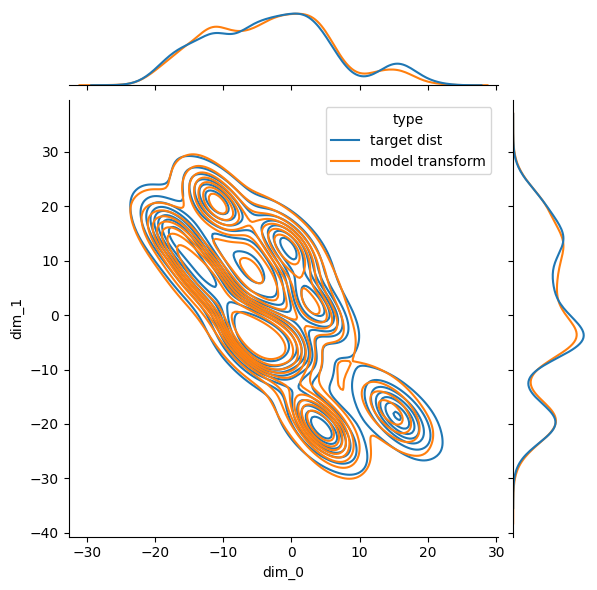

trail: 0 m step: 38 kl_test: 0.349151611328125


  2%|▏         | 100/6000 [00:32<34:52,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3458232879638672  L_n: 0.3299541473388672  kld: 0.00079345703125 KLD1: 0.33303943276405334 KLD2: 0.23662596940994263


  3%|▎         | 200/6000 [01:04<34:29,  2.80it/s]

trail: 0 m step: 39 Loss: 0.3805217742919922  L_n: 0.3388652801513672  kld: 0.00208282470703125 KLD1: 0.3479972779750824 KLD2: 0.2380024790763855


  5%|▌         | 300/6000 [01:36<33:52,  2.80it/s]

trail: 0 m step: 39 Loss: 0.3563213348388672  L_n: 0.3309917449951172  kld: 0.0012664794921875 KLD1: 0.3256511986255646 KLD2: 0.2366795390844345


  7%|▋         | 400/6000 [02:08<33:08,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3634605407714844  L_n: 0.3342018127441406  kld: 0.0014629364013671875 KLD1: 0.3320735692977905 KLD2: 0.23228833079338074


  8%|▊         | 500/6000 [02:40<32:40,  2.81it/s]

trail: 0 m step: 39 Loss: 0.35243797302246094  L_n: 0.31757164001464844  kld: 0.001743316650390625 KLD1: 0.3247426748275757 KLD2: 0.2404688000679016


 10%|█         | 600/6000 [03:12<32:03,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3609638214111328  L_n: 0.32171058654785156  kld: 0.0019626617431640625 KLD1: 0.32054638862609863 KLD2: 0.24473837018013


 12%|█▏        | 700/6000 [03:45<31:29,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3686656951904297  L_n: 0.3238811492919922  kld: 0.002239227294921875 KLD1: 0.3282230496406555 KLD2: 0.2507703900337219


 13%|█▎        | 800/6000 [04:17<30:51,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3420276641845703  L_n: 0.3194446563720703  kld: 0.001129150390625 KLD1: 0.3302237093448639 KLD2: 0.25678327679634094


 15%|█▌        | 900/6000 [04:49<30:14,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3610057830810547  L_n: 0.31389427185058594  kld: 0.0023555755615234375 KLD1: 0.3338174819946289 KLD2: 0.2319415658712387


 17%|█▋        | 1000/6000 [05:21<29:38,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3132438659667969  L_n: 0.3044319152832031  kld: 0.0004405975341796875 KLD1: 0.31894657015800476 KLD2: 0.23689959943294525


 18%|█▊        | 1100/6000 [05:53<29:07,  2.80it/s]

trail: 0 m step: 39 Loss: 0.37366294860839844  L_n: 0.32498741149902344  kld: 0.00243377685546875 KLD1: 0.3362508714199066 KLD2: 0.22370976209640503


 20%|██        | 1200/6000 [06:25<28:29,  2.81it/s]

trail: 0 m step: 39 Loss: 0.35964393615722656  L_n: 0.33042335510253906  kld: 0.001461029052734375 KLD1: 0.33654719591140747 KLD2: 0.24083085358142853


 22%|██▏       | 1300/6000 [06:58<27:49,  2.82it/s]

trail: 0 m step: 39 Loss: 0.35790252685546875  L_n: 0.3246002197265625  kld: 0.0016651153564453125 KLD1: 0.3351125717163086 KLD2: 0.23935338854789734


 23%|██▎       | 1400/6000 [07:30<27:10,  2.82it/s]

trail: 0 m step: 39 Loss: 0.40457725524902344  L_n: 0.35696983337402344  kld: 0.00238037109375 KLD1: 0.3108006715774536 KLD2: 0.223764568567276


 25%|██▌       | 1500/6000 [08:02<26:37,  2.82it/s]

trail: 0 m step: 39 Loss: 0.37148475646972656  L_n: 0.32631874084472656  kld: 0.00225830078125 KLD1: 0.33181580901145935 KLD2: 0.2269335836172104


 27%|██▋       | 1600/6000 [08:34<26:04,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3493671417236328  L_n: 0.3233509063720703  kld: 0.001300811767578125 KLD1: 0.3316560387611389 KLD2: 0.2414228469133377


 28%|██▊       | 1700/6000 [09:07<25:32,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3961524963378906  L_n: 0.3628120422363281  kld: 0.001667022705078125 KLD1: 0.31013157963752747 KLD2: 0.24394658207893372


 30%|███       | 1800/6000 [09:39<24:47,  2.82it/s]

trail: 0 m step: 39 Loss: 0.389190673828125  L_n: 0.33147430419921875  kld: 0.0028858184814453125 KLD1: 0.33412277698516846 KLD2: 0.2354760468006134


 32%|███▏      | 1900/6000 [10:11<24:18,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3741607666015625  L_n: 0.32697296142578125  kld: 0.0023593902587890625 KLD1: 0.33245235681533813 KLD2: 0.25140878558158875


 33%|███▎      | 2000/6000 [10:43<23:47,  2.80it/s]

trail: 0 m step: 39 Loss: 0.3776206970214844  L_n: 0.3136482238769531  kld: 0.0031986236572265625 KLD1: 0.32777437567710876 KLD2: 0.245111882686615


 35%|███▌      | 2100/6000 [11:15<23:05,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3517475128173828  L_n: 0.32142066955566406  kld: 0.0015163421630859375 KLD1: 0.3190520405769348 KLD2: 0.2501215636730194


 37%|███▋      | 2200/6000 [11:47<22:36,  2.80it/s]

trail: 0 m step: 39 Loss: 0.3798179626464844  L_n: 0.3325920104980469  kld: 0.002361297607421875 KLD1: 0.3128417134284973 KLD2: 0.2469664216041565


 38%|███▊      | 2300/6000 [12:20<21:52,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3530902862548828  L_n: 0.3231067657470703  kld: 0.001499176025390625 KLD1: 0.3381357192993164 KLD2: 0.23246122896671295


 40%|████      | 2400/6000 [12:52<21:17,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3453025817871094  L_n: 0.3211555480957031  kld: 0.0012073516845703125 KLD1: 0.3223491609096527 KLD2: 0.24588173627853394


 42%|████▏     | 2500/6000 [13:24<20:41,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3707714080810547  L_n: 0.33609580993652344  kld: 0.0017337799072265625 KLD1: 0.3055732846260071 KLD2: 0.23703134059906006


 43%|████▎     | 2600/6000 [13:56<20:13,  2.80it/s]

trail: 0 m step: 39 Loss: 0.33757591247558594  L_n: 0.30507469177246094  kld: 0.00162506103515625 KLD1: 0.31332725286483765 KLD2: 0.2389097809791565


 45%|████▌     | 2700/6000 [14:28<19:25,  2.83it/s]

trail: 0 m step: 39 Loss: 0.3520011901855469  L_n: 0.3204536437988281  kld: 0.0015773773193359375 KLD1: 0.3230646550655365 KLD2: 0.23341134190559387


 47%|████▋     | 2800/6000 [15:00<18:57,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3726062774658203  L_n: 0.3375873565673828  kld: 0.001750946044921875 KLD1: 0.3231196105480194 KLD2: 0.23154716193675995


 48%|████▊     | 2900/6000 [15:32<18:21,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3723335266113281  L_n: 0.3344917297363281  kld: 0.00189208984375 KLD1: 0.3129877746105194 KLD2: 0.23792962729930878


 50%|█████     | 3000/6000 [16:04<17:05,  2.93it/s]

trail: 0 m step: 39 Loss: 0.35747528076171875  L_n: 0.3302764892578125  kld: 0.0013599395751953125 KLD1: 0.34084004163742065 KLD2: 0.23479169607162476


 52%|█████▏    | 3100/6000 [16:37<17:10,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3532905578613281  L_n: 0.3083152770996094  kld: 0.0022487640380859375 KLD1: 0.2993253767490387 KLD2: 0.24430929124355316


 53%|█████▎    | 3200/6000 [17:09<16:36,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3502483367919922  L_n: 0.3281230926513672  kld: 0.00110626220703125 KLD1: 0.321387380361557 KLD2: 0.23043107986450195


 55%|█████▌    | 3300/6000 [17:41<15:56,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3706207275390625  L_n: 0.34708404541015625  kld: 0.0011768341064453125 KLD1: 0.3152748942375183 KLD2: 0.23420827090740204


 57%|█████▋    | 3400/6000 [18:13<15:30,  2.80it/s]

trail: 0 m step: 39 Loss: 0.33872222900390625  L_n: 0.314117431640625  kld: 0.0012302398681640625 KLD1: 0.32040658593177795 KLD2: 0.23651771247386932


 58%|█████▊    | 3500/6000 [18:45<14:47,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3673667907714844  L_n: 0.3384895324707031  kld: 0.0014438629150390625 KLD1: 0.31049418449401855 KLD2: 0.2258298248052597


 60%|██████    | 3600/6000 [19:18<14:09,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3499908447265625  L_n: 0.3226776123046875  kld: 0.00136566162109375 KLD1: 0.33379414677619934 KLD2: 0.24631445109844208


 62%|██████▏   | 3700/6000 [19:50<13:40,  2.80it/s]

trail: 0 m step: 39 Loss: 0.3713111877441406  L_n: 0.3342704772949219  kld: 0.0018520355224609375 KLD1: 0.3204345107078552 KLD2: 0.24172824621200562


 63%|██████▎   | 3800/6000 [20:22<13:02,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3592720031738281  L_n: 0.3322639465332031  kld: 0.00135040283203125 KLD1: 0.31643372774124146 KLD2: 0.22495946288108826


 65%|██████▌   | 3900/6000 [20:54<12:30,  2.80it/s]

trail: 0 m step: 39 Loss: 0.37728309631347656  L_n: 0.3354358673095703  kld: 0.0020923614501953125 KLD1: 0.31744298338890076 KLD2: 0.2345559000968933


 67%|██████▋   | 4000/6000 [21:26<11:51,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3343505859375  L_n: 0.30963134765625  kld: 0.0012359619140625 KLD1: 0.33738917112350464 KLD2: 0.23395246267318726


 68%|██████▊   | 4100/6000 [21:58<10:59,  2.88it/s]

trail: 0 m step: 39 Loss: 0.35387611389160156  L_n: 0.3315601348876953  kld: 0.0011157989501953125 KLD1: 0.30003562569618225 KLD2: 0.2352333664894104


 70%|███████   | 4200/6000 [22:30<10:36,  2.83it/s]

trail: 0 m step: 39 Loss: 0.3426094055175781  L_n: 0.3125495910644531  kld: 0.00150299072265625 KLD1: 0.3143765926361084 KLD2: 0.2359008491039276


 72%|███████▏  | 4300/6000 [23:02<10:04,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3582572937011719  L_n: 0.3312873840332031  kld: 0.0013484954833984375 KLD1: 0.3332575559616089 KLD2: 0.2429846078157425


 73%|███████▎  | 4400/6000 [23:34<09:29,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3328075408935547  L_n: 0.3061809539794922  kld: 0.001331329345703125 KLD1: 0.30830463767051697 KLD2: 0.23089776933193207


 75%|███████▌  | 4500/6000 [24:06<08:53,  2.81it/s]

trail: 0 m step: 39 Loss: 0.35825538635253906  L_n: 0.3351001739501953  kld: 0.0011577606201171875 KLD1: 0.3269900381565094 KLD2: 0.2381032109260559


 77%|███████▋  | 4600/6000 [24:38<08:16,  2.82it/s]

trail: 0 m step: 39 Loss: 0.330322265625  L_n: 0.3178863525390625  kld: 0.000621795654296875 KLD1: 0.33457326889038086 KLD2: 0.24540702998638153


 78%|███████▊  | 4700/6000 [25:09<07:42,  2.81it/s]

trail: 0 m step: 39 Loss: 0.34511375427246094  L_n: 0.3266124725341797  kld: 0.0009250640869140625 KLD1: 0.33948493003845215 KLD2: 0.23442314565181732


 80%|████████  | 4800/6000 [25:42<07:06,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3480873107910156  L_n: 0.3264961242675781  kld: 0.001079559326171875 KLD1: 0.3147406280040741 KLD2: 0.24059928953647614


 82%|████████▏ | 4900/6000 [26:14<06:30,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3391532897949219  L_n: 0.3214912414550781  kld: 0.0008831024169921875 KLD1: 0.32203730940818787 KLD2: 0.23178544640541077


 83%|████████▎ | 5000/6000 [26:46<05:56,  2.80it/s]

trail: 0 m step: 39 Loss: 0.3488750457763672  L_n: 0.3294963836669922  kld: 0.00096893310546875 KLD1: 0.3316630423069 KLD2: 0.23886561393737793


 85%|████████▌ | 5100/6000 [27:18<05:19,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3458843231201172  L_n: 0.3212413787841797  kld: 0.001232147216796875 KLD1: 0.32723522186279297 KLD2: 0.2536594569683075


 87%|████████▋ | 5200/6000 [27:50<04:44,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3472423553466797  L_n: 0.32828330993652344  kld: 0.0009479522705078125 KLD1: 0.30896618962287903 KLD2: 0.24283388257026672


 88%|████████▊ | 5300/6000 [28:22<04:08,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3528766632080078  L_n: 0.3220539093017578  kld: 0.0015411376953125 KLD1: 0.3381560444831848 KLD2: 0.23670555651187897


 90%|█████████ | 5400/6000 [28:54<03:32,  2.82it/s]

trail: 0 m step: 39 Loss: 0.33045196533203125  L_n: 0.3118743896484375  kld: 0.0009288787841796875 KLD1: 0.3408516049385071 KLD2: 0.23340804874897003


 92%|█████████▏| 5500/6000 [29:26<02:57,  2.81it/s]

trail: 0 m step: 39 Loss: 0.3405590057373047  L_n: 0.3220958709716797  kld: 0.00092315673828125 KLD1: 0.3204793930053711 KLD2: 0.2439006268978119


 93%|█████████▎| 5601/6000 [29:58<01:56,  3.41it/s]

trail: 0 m step: 39 Loss: 0.3517265319824219  L_n: 0.3406257629394531  kld: 0.0005550384521484375 KLD1: 0.3363797664642334 KLD2: 0.23385004699230194


 95%|█████████▌| 5700/6000 [30:30<01:46,  2.82it/s]

trail: 0 m step: 39 Loss: 0.34024810791015625  L_n: 0.32201385498046875  kld: 0.000911712646484375 KLD1: 0.3122248351573944 KLD2: 0.23705312609672546


 97%|█████████▋| 5800/6000 [31:02<01:10,  2.82it/s]

trail: 0 m step: 39 Loss: 0.34539222717285156  L_n: 0.32975196838378906  kld: 0.000782012939453125 KLD1: 0.321947306394577 KLD2: 0.2320408672094345


 98%|█████████▊| 5900/6000 [31:34<00:35,  2.82it/s]

trail: 0 m step: 39 Loss: 0.3651847839355469  L_n: 0.3365745544433594  kld: 0.001430511474609375 KLD1: 0.322683721780777 KLD2: 0.24547743797302246


100%|██████████| 6000/6000 [32:07<00:00,  3.11it/s]

trail: 0 m step: 39 Loss: 0.3483848571777344  L_n: 0.3394584655761719  kld: 0.000446319580078125 KLD1: 0.3178289830684662 KLD2: 0.23586899042129517



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


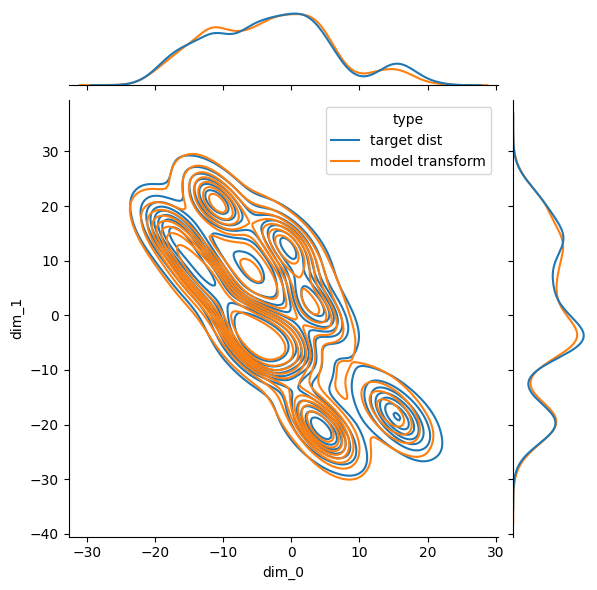

trail: 0 m step: 39 kl_test: 0.34470367431640625


  2%|▏         | 100/6000 [00:31<34:36,  2.84it/s]

trail: 0 m step: 40 Loss: 0.33568572998046875  L_n: 0.318939208984375  kld: 0.0008373260498046875 KLD1: 0.31583064794540405 KLD2: 0.2334672063589096


  3%|▎         | 200/6000 [01:03<34:20,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3659534454345703  L_n: 0.32265663146972656  kld: 0.0021648406982421875 KLD1: 0.33132919669151306 KLD2: 0.23304106295108795


  5%|▌         | 300/6000 [01:35<33:35,  2.83it/s]

trail: 0 m step: 40 Loss: 0.3355979919433594  L_n: 0.3160285949707031  kld: 0.0009784698486328125 KLD1: 0.32304632663726807 KLD2: 0.2332923710346222


  7%|▋         | 400/6000 [02:07<33:01,  2.83it/s]

trail: 0 m step: 40 Loss: 0.34344482421875  L_n: 0.320098876953125  kld: 0.00116729736328125 KLD1: 0.3331180214881897 KLD2: 0.227938711643219


  8%|▊         | 500/6000 [02:39<32:33,  2.81it/s]

trail: 0 m step: 40 Loss: 0.353363037109375  L_n: 0.31014251708984375  kld: 0.0021610260009765625 KLD1: 0.3205779790878296 KLD2: 0.23551468551158905


 10%|█         | 600/6000 [03:11<31:55,  2.82it/s]

trail: 0 m step: 40 Loss: 0.342254638671875  L_n: 0.308990478515625  kld: 0.0016632080078125 KLD1: 0.30675575137138367 KLD2: 0.23780032992362976


 12%|█▏        | 700/6000 [03:44<31:23,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3306694030761719  L_n: 0.3048439025878906  kld: 0.0012912750244140625 KLD1: 0.3043469786643982 KLD2: 0.2441246211528778


 13%|█▎        | 800/6000 [04:16<30:49,  2.81it/s]

trail: 0 m step: 40 Loss: 0.32888221740722656  L_n: 0.30042457580566406  kld: 0.001422882080078125 KLD1: 0.3243197500705719 KLD2: 0.2524183392524719


 15%|█▌        | 900/6000 [04:48<30:16,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3433361053466797  L_n: 0.30743980407714844  kld: 0.0017948150634765625 KLD1: 0.326980322599411 KLD2: 0.22844676673412323


 17%|█▋        | 1000/6000 [05:20<29:33,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3043651580810547  L_n: 0.29196739196777344  kld: 0.0006198883056640625 KLD1: 0.31385454535484314 KLD2: 0.23129184544086456


 18%|█▊        | 1100/6000 [05:52<28:57,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3492393493652344  L_n: 0.3099479675292969  kld: 0.001964569091796875 KLD1: 0.32463619112968445 KLD2: 0.2165250927209854


 20%|██        | 1200/6000 [06:24<28:16,  2.83it/s]

trail: 0 m step: 40 Loss: 0.361572265625  L_n: 0.32979583740234375  kld: 0.0015888214111328125 KLD1: 0.3183581829071045 KLD2: 0.23358161747455597


 22%|██▏       | 1300/6000 [06:56<27:48,  2.82it/s]

trail: 0 m step: 40 Loss: 0.32251548767089844  L_n: 0.31122398376464844  kld: 0.0005645751953125 KLD1: 0.31245842576026917 KLD2: 0.23335477709770203


 23%|██▎       | 1400/6000 [07:28<27:18,  2.81it/s]

trail: 0 m step: 40 Loss: 0.38889122009277344  L_n: 0.3346080780029297  kld: 0.0027141571044921875 KLD1: 0.29604071378707886 KLD2: 0.221177875995636


 25%|██▌       | 1500/6000 [08:01<26:42,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3492298126220703  L_n: 0.32142066955566406  kld: 0.0013904571533203125 KLD1: 0.3098456859588623 KLD2: 0.2212786078453064


 27%|██▋       | 1600/6000 [08:33<26:03,  2.81it/s]

trail: 0 m step: 40 Loss: 0.35613250732421875  L_n: 0.33232879638671875  kld: 0.001190185546875 KLD1: 0.3187252879142761 KLD2: 0.23636586964130402


 28%|██▊       | 1700/6000 [09:05<24:28,  2.93it/s]

trail: 0 m step: 40 Loss: 0.3690147399902344  L_n: 0.3301811218261719  kld: 0.001941680908203125 KLD1: 0.3131149709224701 KLD2: 0.23572680354118347


 30%|███       | 1800/6000 [09:37<24:54,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3541889190673828  L_n: 0.3136768341064453  kld: 0.002025604248046875 KLD1: 0.3332916796207428 KLD2: 0.2296678125858307


 32%|███▏      | 1900/6000 [10:09<24:12,  2.82it/s]

trail: 0 m step: 40 Loss: 0.35062408447265625  L_n: 0.3041229248046875  kld: 0.0023250579833984375 KLD1: 0.30250421166419983 KLD2: 0.2415412962436676


 33%|███▎      | 2000/6000 [10:41<23:39,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3654212951660156  L_n: 0.3056449890136719  kld: 0.0029888153076171875 KLD1: 0.3105926811695099 KLD2: 0.23510019481182098


 35%|███▌      | 2100/6000 [11:14<23:07,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3407630920410156  L_n: 0.3120765686035156  kld: 0.001434326171875 KLD1: 0.32539233565330505 KLD2: 0.23959726095199585


 37%|███▋      | 2200/6000 [11:46<22:29,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3581123352050781  L_n: 0.3264884948730469  kld: 0.0015811920166015625 KLD1: 0.30220991373062134 KLD2: 0.23700734972953796


 38%|███▊      | 2300/6000 [12:18<21:47,  2.83it/s]

trail: 0 m step: 40 Loss: 0.33679962158203125  L_n: 0.3112030029296875  kld: 0.0012798309326171875 KLD1: 0.324523001909256 KLD2: 0.22197841107845306


 40%|████      | 2400/6000 [12:50<21:09,  2.84it/s]

trail: 0 m step: 40 Loss: 0.32179832458496094  L_n: 0.29326438903808594  kld: 0.00142669677734375 KLD1: 0.3104126453399658 KLD2: 0.23756976425647736


 42%|████▏     | 2500/6000 [13:22<20:42,  2.82it/s]

trail: 0 m step: 40 Loss: 0.35313987731933594  L_n: 0.3246440887451172  kld: 0.0014247894287109375 KLD1: 0.3042829930782318 KLD2: 0.22989711165428162


 43%|████▎     | 2600/6000 [13:54<20:04,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3232860565185547  L_n: 0.29273033142089844  kld: 0.0015277862548828125 KLD1: 0.30316489934921265 KLD2: 0.2295524775981903


 45%|████▌     | 2700/6000 [14:26<19:27,  2.83it/s]

trail: 0 m step: 40 Loss: 0.35236549377441406  L_n: 0.30765724182128906  kld: 0.00223541259765625 KLD1: 0.31069374084472656 KLD2: 0.22371140122413635


 47%|████▋     | 2800/6000 [14:58<19:00,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3387737274169922  L_n: 0.32217979431152344  kld: 0.0008296966552734375 KLD1: 0.3114866614341736 KLD2: 0.22341522574424744


 48%|████▊     | 2900/6000 [15:30<18:27,  2.80it/s]

trail: 0 m step: 40 Loss: 0.3581829071044922  L_n: 0.3238506317138672  kld: 0.00171661376953125 KLD1: 0.30865442752838135 KLD2: 0.23096251487731934


 50%|█████     | 3000/6000 [16:02<17:44,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3150482177734375  L_n: 0.2970428466796875  kld: 0.0009002685546875 KLD1: 0.3269278109073639 KLD2: 0.2284817397594452


 52%|█████▏    | 3100/6000 [16:35<17:14,  2.80it/s]

trail: 0 m step: 40 Loss: 0.3187446594238281  L_n: 0.2939872741699219  kld: 0.0012378692626953125 KLD1: 0.3006756901741028 KLD2: 0.24072706699371338


 53%|█████▎    | 3200/6000 [17:07<16:58,  2.75it/s]

trail: 0 m step: 40 Loss: 0.353851318359375  L_n: 0.3287506103515625  kld: 0.001255035400390625 KLD1: 0.30428555607795715 KLD2: 0.22413969039916992


 55%|█████▌    | 3300/6000 [17:39<15:59,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3315925598144531  L_n: 0.3218269348144531  kld: 0.00048828125 KLD1: 0.3201052248477936 KLD2: 0.23087435960769653


 57%|█████▋    | 3400/6000 [18:11<15:21,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3363208770751953  L_n: 0.31003761291503906  kld: 0.0013141632080078125 KLD1: 0.31036898493766785 KLD2: 0.231643408536911


 58%|█████▊    | 3500/6000 [18:43<14:45,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3534717559814453  L_n: 0.3230304718017578  kld: 0.001522064208984375 KLD1: 0.2867448031902313 KLD2: 0.22053326666355133


 60%|██████    | 3600/6000 [19:15<14:13,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3349628448486328  L_n: 0.30593299865722656  kld: 0.0014514923095703125 KLD1: 0.32023561000823975 KLD2: 0.24204154312610626


 62%|██████▏   | 3700/6000 [19:47<13:37,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3706684112548828  L_n: 0.3316059112548828  kld: 0.001953125 KLD1: 0.3118002414703369 KLD2: 0.2362811416387558


 63%|██████▎   | 3800/6000 [20:19<13:01,  2.81it/s]

trail: 0 m step: 40 Loss: 0.34265708923339844  L_n: 0.31618309020996094  kld: 0.001323699951171875 KLD1: 0.31980615854263306 KLD2: 0.22141529619693756


 65%|██████▌   | 3900/6000 [20:52<12:24,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3654594421386719  L_n: 0.3359718322753906  kld: 0.0014743804931640625 KLD1: 0.31333646178245544 KLD2: 0.22960565984249115


 67%|██████▋   | 4000/6000 [21:24<11:51,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3320770263671875  L_n: 0.31090545654296875  kld: 0.0010585784912109375 KLD1: 0.3412255346775055 KLD2: 0.22987771034240723


 68%|██████▊   | 4100/6000 [21:56<11:13,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3510589599609375  L_n: 0.3235931396484375  kld: 0.001373291015625 KLD1: 0.29777371883392334 KLD2: 0.23128393292427063


 70%|███████   | 4200/6000 [22:28<10:35,  2.83it/s]

trail: 0 m step: 40 Loss: 0.3267021179199219  L_n: 0.3030128479003906  kld: 0.0011844635009765625 KLD1: 0.31096941232681274 KLD2: 0.2319798767566681


 72%|███████▏  | 4300/6000 [23:00<10:02,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3412036895751953  L_n: 0.31865882873535156  kld: 0.0011272430419921875 KLD1: 0.32996171712875366 KLD2: 0.23898209631443024


 73%|███████▎  | 4400/6000 [23:32<09:26,  2.83it/s]

trail: 0 m step: 40 Loss: 0.31960487365722656  L_n: 0.2989673614501953  kld: 0.0010318756103515625 KLD1: 0.3034943640232086 KLD2: 0.22715361416339874


 75%|███████▌  | 4500/6000 [24:04<08:53,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3455848693847656  L_n: 0.3261299133300781  kld: 0.000972747802734375 KLD1: 0.31316864490509033 KLD2: 0.23432230949401855


 77%|███████▋  | 4600/6000 [24:35<08:03,  2.89it/s]

trail: 0 m step: 40 Loss: 0.31217002868652344  L_n: 0.30347251892089844  kld: 0.00043487548828125 KLD1: 0.31962162256240845 KLD2: 0.2402743548154831


 78%|███████▊  | 4700/6000 [25:07<07:42,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3232307434082031  L_n: 0.3131980895996094  kld: 0.0005016326904296875 KLD1: 0.32690683007240295 KLD2: 0.23007088899612427


 80%|████████  | 4800/6000 [25:39<07:06,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3422126770019531  L_n: 0.3276786804199219  kld: 0.0007266998291015625 KLD1: 0.29674774408340454 KLD2: 0.2366659790277481


 82%|████████▏ | 4900/6000 [26:11<06:31,  2.81it/s]

trail: 0 m step: 40 Loss: 0.32150840759277344  L_n: 0.3101024627685547  kld: 0.0005702972412109375 KLD1: 0.31539851427078247 KLD2: 0.22811943292617798


 83%|████████▎ | 5000/6000 [26:43<05:54,  2.82it/s]

trail: 0 m step: 40 Loss: 0.33072662353515625  L_n: 0.322296142578125  kld: 0.0004215240478515625 KLD1: 0.3299318253993988 KLD2: 0.2343875914812088


 85%|████████▌ | 5100/6000 [27:15<05:19,  2.82it/s]

trail: 0 m step: 40 Loss: 0.31739234924316406  L_n: 0.30808448791503906  kld: 0.00046539306640625 KLD1: 0.3275183141231537 KLD2: 0.24887101352214813


 87%|████████▋ | 5200/6000 [27:47<04:43,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3418769836425781  L_n: 0.3185310363769531  kld: 0.00116729736328125 KLD1: 0.3035909831523895 KLD2: 0.23838520050048828


 88%|████████▊ | 5300/6000 [28:20<04:09,  2.81it/s]

trail: 0 m step: 40 Loss: 0.3366127014160156  L_n: 0.3118934631347656  kld: 0.0012359619140625 KLD1: 0.3247305452823639 KLD2: 0.23088529706001282


 90%|█████████ | 5400/6000 [28:52<03:33,  2.81it/s]

trail: 0 m step: 40 Loss: 0.33205223083496094  L_n: 0.30664634704589844  kld: 0.001270294189453125 KLD1: 0.31406912207603455 KLD2: 0.22790546715259552


 92%|█████████▏| 5500/6000 [29:24<02:57,  2.82it/s]

trail: 0 m step: 40 Loss: 0.334136962890625  L_n: 0.31395721435546875  kld: 0.0010089874267578125 KLD1: 0.3047887086868286 KLD2: 0.23869726061820984


 93%|█████████▎| 5600/6000 [29:56<02:21,  2.83it/s]

trail: 0 m step: 40 Loss: 0.3567619323730469  L_n: 0.3341026306152344  kld: 0.001132965087890625 KLD1: 0.31590819358825684 KLD2: 0.2293749898672104


 95%|█████████▌| 5700/6000 [30:28<01:46,  2.83it/s]

trail: 0 m step: 40 Loss: 0.3292713165283203  L_n: 0.3096637725830078  kld: 0.000980377197265625 KLD1: 0.2992440164089203 KLD2: 0.23305411636829376


 97%|█████████▋| 5800/6000 [31:00<01:10,  2.83it/s]

trail: 0 m step: 40 Loss: 0.32995033264160156  L_n: 0.3195362091064453  kld: 0.0005207061767578125 KLD1: 0.31673893332481384 KLD2: 0.22759462893009186


 98%|█████████▊| 5900/6000 [31:32<00:35,  2.82it/s]

trail: 0 m step: 40 Loss: 0.3524017333984375  L_n: 0.32733917236328125  kld: 0.0012531280517578125 KLD1: 0.3247677683830261 KLD2: 0.2411360740661621


100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

trail: 0 m step: 40 Loss: 0.3536033630371094  L_n: 0.3447914123535156  kld: 0.0004405975341796875 KLD1: 0.31899896264076233 KLD2: 0.23165348172187805



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


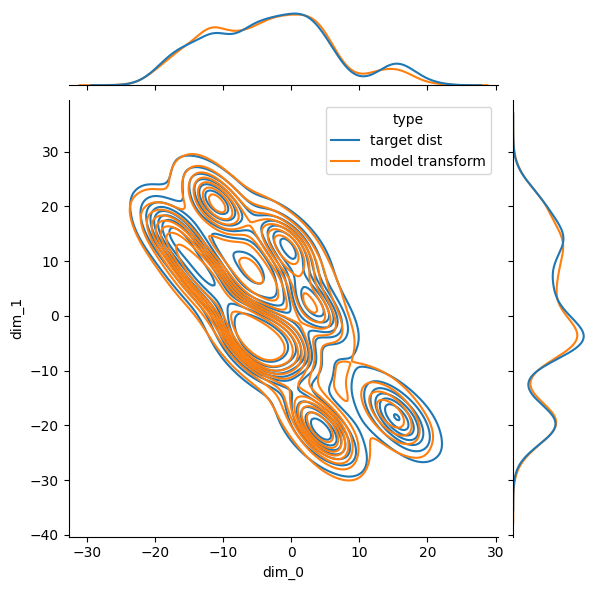

trail: 0 m step: 40 kl_test: 0.33153533935546875


  2%|▏         | 100/6000 [00:31<35:19,  2.78it/s]

trail: 0 m step: 41 Loss: 0.33461570739746094  L_n: 0.3172588348388672  kld: 0.0008678436279296875 KLD1: 0.3210439383983612 KLD2: 0.22860489785671234


  3%|▎         | 200/6000 [01:04<34:11,  2.83it/s]

trail: 0 m step: 41 Loss: 0.348236083984375  L_n: 0.3152008056640625  kld: 0.001651763916015625 KLD1: 0.31345677375793457 KLD2: 0.2271614372730255


  5%|▌         | 300/6000 [01:36<33:52,  2.80it/s]

trail: 0 m step: 41 Loss: 0.3020744323730469  L_n: 0.2929954528808594  kld: 0.000453948974609375 KLD1: 0.3164294958114624 KLD2: 0.22995243966579437


  7%|▋         | 400/6000 [02:08<33:16,  2.81it/s]

trail: 0 m step: 41 Loss: 0.34887123107910156  L_n: 0.3196125030517578  kld: 0.0014629364013671875 KLD1: 0.3153011202812195 KLD2: 0.22782857716083527


  8%|▊         | 500/6000 [02:40<32:37,  2.81it/s]

trail: 0 m step: 41 Loss: 0.35090065002441406  L_n: 0.3046283721923828  kld: 0.0023136138916015625 KLD1: 0.2941506505012512 KLD2: 0.23381510376930237


 10%|█         | 600/6000 [03:12<31:57,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3468647003173828  L_n: 0.3055133819580078  kld: 0.00206756591796875 KLD1: 0.29245322942733765 KLD2: 0.2350330799818039


 12%|█▏        | 700/6000 [03:45<31:25,  2.81it/s]

trail: 0 m step: 41 Loss: 0.3551445007324219  L_n: 0.3021583557128906  kld: 0.0026493072509765625 KLD1: 0.31874173879623413 KLD2: 0.24231283366680145


 13%|█▎        | 800/6000 [04:17<31:00,  2.80it/s]

trail: 0 m step: 41 Loss: 0.35872840881347656  L_n: 0.32599830627441406  kld: 0.001636505126953125 KLD1: 0.30631449818611145 KLD2: 0.24948827922344208


 15%|█▌        | 900/6000 [04:49<30:13,  2.81it/s]

trail: 0 m step: 41 Loss: 0.3670463562011719  L_n: 0.3087959289550781  kld: 0.0029125213623046875 KLD1: 0.31239262223243713 KLD2: 0.22338853776454926


 17%|█▋        | 1000/6000 [05:21<29:37,  2.81it/s]

trail: 0 m step: 41 Loss: 0.2966766357421875  L_n: 0.28076934814453125  kld: 0.0007953643798828125 KLD1: 0.30769282579421997 KLD2: 0.22917291522026062


 18%|█▊        | 1100/6000 [05:53<29:07,  2.80it/s]

trail: 0 m step: 41 Loss: 0.3349723815917969  L_n: 0.2931632995605469  kld: 0.0020904541015625 KLD1: 0.3188878893852234 KLD2: 0.21320539712905884


 20%|██        | 1200/6000 [06:25<28:27,  2.81it/s]

trail: 0 m step: 41 Loss: 0.34417152404785156  L_n: 0.3159809112548828  kld: 0.0014095306396484375 KLD1: 0.31237176060676575 KLD2: 0.2315976470708847


 22%|██▏       | 1300/6000 [06:58<27:43,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3371410369873047  L_n: 0.3124217987060547  kld: 0.0012359619140625 KLD1: 0.3049750328063965 KLD2: 0.22883901000022888


 23%|██▎       | 1400/6000 [07:30<27:22,  2.80it/s]

trail: 0 m step: 41 Loss: 0.35698699951171875  L_n: 0.324676513671875  kld: 0.0016155242919921875 KLD1: 0.28005075454711914 KLD2: 0.2186564952135086


 25%|██▌       | 1500/6000 [08:02<26:31,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3486461639404297  L_n: 0.32259178161621094  kld: 0.0013027191162109375 KLD1: 0.3060445785522461 KLD2: 0.21829630434513092


 27%|██▋       | 1600/6000 [08:34<26:01,  2.82it/s]

trail: 0 m step: 41 Loss: 0.34002685546875  L_n: 0.3173675537109375  kld: 0.001132965087890625 KLD1: 0.31454306840896606 KLD2: 0.23359142243862152


 28%|██▊       | 1700/6000 [09:06<25:17,  2.83it/s]

trail: 0 m step: 41 Loss: 0.35768699645996094  L_n: 0.3283519744873047  kld: 0.0014667510986328125 KLD1: 0.3004036545753479 KLD2: 0.23454901576042175


 30%|███       | 1800/6000 [09:39<24:50,  2.82it/s]

trail: 0 m step: 41 Loss: 0.35353660583496094  L_n: 0.3036022186279297  kld: 0.0024967193603515625 KLD1: 0.31967151165008545 KLD2: 0.22693517804145813


 32%|███▏      | 1900/6000 [10:11<24:23,  2.80it/s]

trail: 0 m step: 41 Loss: 0.33452796936035156  L_n: 0.30187416076660156  kld: 0.0016326904296875 KLD1: 0.3011838495731354 KLD2: 0.24220606684684753


 33%|███▎      | 2000/6000 [10:43<23:36,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3496875762939453  L_n: 0.30394935607910156  kld: 0.0022869110107421875 KLD1: 0.318726122379303 KLD2: 0.23464569449424744


 35%|███▌      | 2100/6000 [11:15<22:59,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3322334289550781  L_n: 0.3041191101074219  kld: 0.0014057159423828125 KLD1: 0.3137831389904022 KLD2: 0.23734696209430695


 37%|███▋      | 2200/6000 [11:47<22:35,  2.80it/s]

trail: 0 m step: 41 Loss: 0.33318328857421875  L_n: 0.31342315673828125  kld: 0.000988006591796875 KLD1: 0.3103398084640503 KLD2: 0.23405373096466064


 38%|███▊      | 2300/6000 [12:19<21:50,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3284187316894531  L_n: 0.3109092712402344  kld: 0.0008754730224609375 KLD1: 0.31309884786605835 KLD2: 0.22098690271377563


 40%|████      | 2400/6000 [12:51<21:28,  2.79it/s]

trail: 0 m step: 41 Loss: 0.32376670837402344  L_n: 0.30263328552246094  kld: 0.001056671142578125 KLD1: 0.30473196506500244 KLD2: 0.2351890355348587


 42%|████▏     | 2500/6000 [13:23<20:42,  2.82it/s]

trail: 0 m step: 41 Loss: 0.34188270568847656  L_n: 0.31395912170410156  kld: 0.00139617919921875 KLD1: 0.30247944593429565 KLD2: 0.22661833465099335


 43%|████▎     | 2600/6000 [13:55<20:04,  2.82it/s]

trail: 0 m step: 41 Loss: 0.32808876037597656  L_n: 0.2995929718017578  kld: 0.0014247894287109375 KLD1: 0.28765687346458435 KLD2: 0.23030629754066467


 45%|████▌     | 2700/6000 [14:27<19:25,  2.83it/s]

trail: 0 m step: 41 Loss: 0.34012413024902344  L_n: 0.3085002899169922  kld: 0.0015811920166015625 KLD1: 0.29937034845352173 KLD2: 0.22458817064762115


 47%|████▋     | 2800/6000 [14:59<18:53,  2.82it/s]

trail: 0 m step: 41 Loss: 0.347930908203125  L_n: 0.3237457275390625  kld: 0.001209259033203125 KLD1: 0.3125581443309784 KLD2: 0.22380436956882477


 48%|████▊     | 2900/6000 [15:31<18:24,  2.81it/s]

trail: 0 m step: 41 Loss: 0.3497467041015625  L_n: 0.31728363037109375  kld: 0.0016231536865234375 KLD1: 0.30307021737098694 KLD2: 0.22903719544410706


 50%|█████     | 3000/6000 [16:04<17:45,  2.82it/s]

trail: 0 m step: 41 Loss: 0.30892181396484375  L_n: 0.2965240478515625  kld: 0.0006198883056640625 KLD1: 0.3300600051879883 KLD2: 0.22608515620231628


 52%|█████▏    | 3100/6000 [16:36<17:04,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3363170623779297  L_n: 0.30225181579589844  kld: 0.0017032623291015625 KLD1: 0.29768452048301697 KLD2: 0.23800495266914368


 53%|█████▎    | 3200/6000 [17:08<15:51,  2.94it/s]

trail: 0 m step: 41 Loss: 0.3122730255126953  L_n: 0.3022785186767578  kld: 0.000499725341796875 KLD1: 0.2940566837787628 KLD2: 0.22242018580436707


 55%|█████▌    | 3300/6000 [17:40<16:03,  2.80it/s]

trail: 0 m step: 41 Loss: 0.33115386962890625  L_n: 0.3265380859375  kld: 0.0002307891845703125 KLD1: 0.3125385046005249 KLD2: 0.22968773543834686


 57%|█████▋    | 3400/6000 [18:12<15:20,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3425941467285156  L_n: 0.3140220642089844  kld: 0.0014286041259765625 KLD1: 0.3000517785549164 KLD2: 0.23068422079086304


 58%|█████▊    | 3500/6000 [18:44<14:46,  2.82it/s]

trail: 0 m step: 41 Loss: 0.358184814453125  L_n: 0.31359100341796875  kld: 0.0022296905517578125 KLD1: 0.29961201548576355 KLD2: 0.21925468742847443


 60%|██████    | 3600/6000 [19:16<14:10,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3184833526611328  L_n: 0.3036060333251953  kld: 0.000743865966796875 KLD1: 0.3057864308357239 KLD2: 0.2389175295829773


 62%|██████▏   | 3700/6000 [19:48<13:40,  2.80it/s]

trail: 0 m step: 41 Loss: 0.3439178466796875  L_n: 0.30970001220703125  kld: 0.0017108917236328125 KLD1: 0.2980072796344757 KLD2: 0.2346973568201065


 63%|██████▎   | 3800/6000 [20:21<13:00,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3329620361328125  L_n: 0.30393218994140625  kld: 0.0014514923095703125 KLD1: 0.31178852915763855 KLD2: 0.2181209921836853


 65%|██████▌   | 3900/6000 [20:53<12:24,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3568401336669922  L_n: 0.31697654724121094  kld: 0.0019931793212890625 KLD1: 0.3017001152038574 KLD2: 0.226411372423172


 67%|██████▋   | 4000/6000 [21:25<11:46,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3223991394042969  L_n: 0.3022575378417969  kld: 0.001007080078125 KLD1: 0.31907567381858826 KLD2: 0.22603175044059753


 68%|██████▊   | 4100/6000 [21:57<10:49,  2.92it/s]

trail: 0 m step: 41 Loss: 0.3367633819580078  L_n: 0.3119678497314453  kld: 0.001239776611328125 KLD1: 0.3015926778316498 KLD2: 0.22748810052871704


 70%|███████   | 4200/6000 [22:29<10:36,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3240680694580078  L_n: 0.2958393096923828  kld: 0.00141143798828125 KLD1: 0.323440283536911 KLD2: 0.2278532236814499


 72%|███████▏  | 4300/6000 [23:01<10:02,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3458404541015625  L_n: 0.31826019287109375  kld: 0.0013790130615234375 KLD1: 0.3150745928287506 KLD2: 0.23497529327869415


 73%|███████▎  | 4400/6000 [23:33<09:28,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3247642517089844  L_n: 0.2987480163574219  kld: 0.001300811767578125 KLD1: 0.2898574769496918 KLD2: 0.22235482931137085


 75%|███████▌  | 4500/6000 [24:05<08:52,  2.82it/s]

trail: 0 m step: 41 Loss: 0.35339927673339844  L_n: 0.32394981384277344  kld: 0.00147247314453125 KLD1: 0.30856117606163025 KLD2: 0.22957934439182281


 77%|███████▋  | 4600/6000 [24:37<08:17,  2.81it/s]

trail: 0 m step: 41 Loss: 0.31838417053222656  L_n: 0.30106544494628906  kld: 0.000865936279296875 KLD1: 0.3133780062198639 KLD2: 0.23592403531074524


 78%|███████▊  | 4700/6000 [25:09<07:41,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3320274353027344  L_n: 0.3147850036621094  kld: 0.00086212158203125 KLD1: 0.3113592565059662 KLD2: 0.2250862717628479


 80%|████████  | 4800/6000 [25:41<07:04,  2.83it/s]

trail: 0 m step: 41 Loss: 0.3144245147705078  L_n: 0.3031330108642578  kld: 0.0005645751953125 KLD1: 0.2951944172382355 KLD2: 0.2322235256433487


 82%|████████▏ | 4900/6000 [26:13<06:29,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3170490264892578  L_n: 0.30190467834472656  kld: 0.0007572174072265625 KLD1: 0.3136274516582489 KLD2: 0.22448280453681946


 83%|████████▎ | 5000/6000 [26:45<05:56,  2.81it/s]

trail: 0 m step: 41 Loss: 0.3385162353515625  L_n: 0.31635284423828125  kld: 0.0011081695556640625 KLD1: 0.3293401896953583 KLD2: 0.2297259420156479


 85%|████████▌ | 5100/6000 [27:17<05:03,  2.97it/s]

trail: 0 m step: 41 Loss: 0.3193645477294922  L_n: 0.29651451110839844  kld: 0.0011425018310546875 KLD1: 0.3186786472797394 KLD2: 0.244524747133255


 87%|████████▋ | 5200/6000 [27:49<04:45,  2.80it/s]

trail: 0 m step: 41 Loss: 0.32102012634277344  L_n: 0.29767417907714844  kld: 0.00116729736328125 KLD1: 0.298890084028244 KLD2: 0.23355521261692047


 88%|████████▊ | 5300/6000 [28:22<04:10,  2.80it/s]

trail: 0 m step: 41 Loss: 0.33266258239746094  L_n: 0.31480979919433594  kld: 0.00089263916015625 KLD1: 0.3151145279407501 KLD2: 0.22610622644424438


 90%|█████████ | 5400/6000 [28:54<03:35,  2.78it/s]

trail: 0 m step: 41 Loss: 0.34126853942871094  L_n: 0.3077373504638672  kld: 0.0016765594482421875 KLD1: 0.3108108937740326 KLD2: 0.22266708314418793


 92%|█████████▏| 5500/6000 [29:26<02:57,  2.81it/s]

trail: 0 m step: 41 Loss: 0.324554443359375  L_n: 0.29628753662109375  kld: 0.0014133453369140625 KLD1: 0.2963671088218689 KLD2: 0.23377040028572083


 93%|█████████▎| 5600/6000 [29:58<02:22,  2.81it/s]

trail: 0 m step: 41 Loss: 0.33282470703125  L_n: 0.3167266845703125  kld: 0.000804901123046875 KLD1: 0.28742995858192444 KLD2: 0.2243625670671463


 95%|█████████▌| 5700/6000 [30:30<01:46,  2.82it/s]

trail: 0 m step: 41 Loss: 0.3216381072998047  L_n: 0.3070659637451172  kld: 0.000728607177734375 KLD1: 0.2860141396522522 KLD2: 0.2273472547531128


 97%|█████████▋| 5800/6000 [31:02<01:11,  2.81it/s]

trail: 0 m step: 41 Loss: 0.33232688903808594  L_n: 0.3113842010498047  kld: 0.0010471343994140625 KLD1: 0.3079899847507477 KLD2: 0.2224249243736267


 98%|█████████▊| 5900/6000 [31:34<00:35,  2.82it/s]

trail: 0 m step: 41 Loss: 0.32871055603027344  L_n: 0.3166942596435547  kld: 0.0006008148193359375 KLD1: 0.3044668138027191 KLD2: 0.23652420938014984


100%|██████████| 6000/6000 [32:06<00:00,  3.11it/s]

trail: 0 m step: 41 Loss: 0.33266448974609375  L_n: 0.32884979248046875  kld: 0.00019073486328125 KLD1: 0.2983277142047882 KLD2: 0.22754552960395813



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


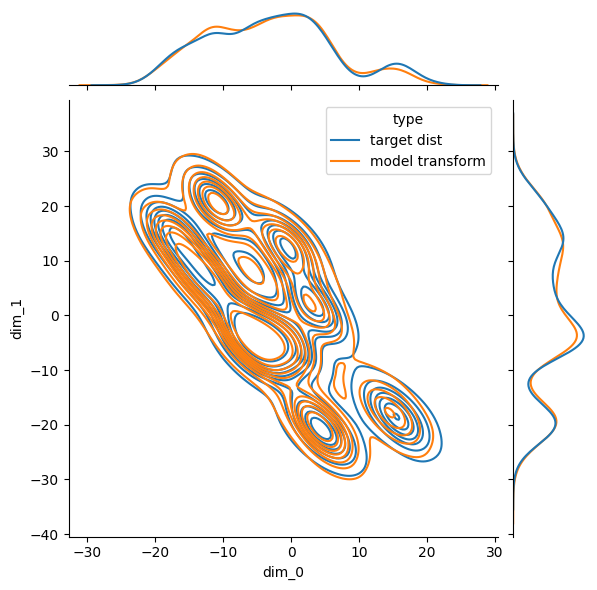

trail: 0 m step: 41 kl_test: 0.33843231201171875


  2%|▏         | 100/6000 [00:32<35:17,  2.79it/s]

trail: 0 m step: 42 Loss: 0.3132190704345703  L_n: 0.2982654571533203  kld: 0.0007476806640625 KLD1: 0.3159106373786926 KLD2: 0.22271166741847992


  3%|▎         | 200/6000 [01:04<34:24,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3506298065185547  L_n: 0.30405235290527344  kld: 0.0023288726806640625 KLD1: 0.3140426278114319 KLD2: 0.22273412346839905


  5%|▌         | 300/6000 [01:36<33:49,  2.81it/s]

trail: 0 m step: 42 Loss: 0.30058860778808594  L_n: 0.2804088592529297  kld: 0.0010089874267578125 KLD1: 0.3103652596473694 KLD2: 0.227937713265419


  7%|▋         | 400/6000 [02:09<33:18,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3464794158935547  L_n: 0.31027793884277344  kld: 0.0018100738525390625 KLD1: 0.3187026381492615 KLD2: 0.22043685615062714


  8%|▊         | 500/6000 [02:41<32:38,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3391094207763672  L_n: 0.29367637634277344  kld: 0.0022716522216796875 KLD1: 0.2899070382118225 KLD2: 0.22706669569015503


 10%|█         | 600/6000 [03:13<32:11,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3325786590576172  L_n: 0.29004478454589844  kld: 0.0021266937255859375 KLD1: 0.28742092847824097 KLD2: 0.22786428034305573


 12%|█▏        | 700/6000 [03:46<31:33,  2.80it/s]

trail: 0 m step: 42 Loss: 0.35718536376953125  L_n: 0.30706024169921875  kld: 0.002506256103515625 KLD1: 0.3155861496925354 KLD2: 0.23929190635681152


 13%|█▎        | 800/6000 [04:18<30:52,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3289470672607422  L_n: 0.30510520935058594  kld: 0.0011920928955078125 KLD1: 0.2920077443122864 KLD2: 0.2455938458442688


 15%|█▌        | 900/6000 [04:50<30:22,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3438549041748047  L_n: 0.3020458221435547  kld: 0.0020904541015625 KLD1: 0.3024987578392029 KLD2: 0.21802543103694916


 17%|█▋        | 1000/6000 [05:22<29:46,  2.80it/s]

trail: 0 m step: 42 Loss: 0.28859710693359375  L_n: 0.2758941650390625  kld: 0.0006351470947265625 KLD1: 0.30242571234703064 KLD2: 0.22475497424602509


 18%|█▊        | 1100/6000 [05:54<29:04,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3347663879394531  L_n: 0.2934150695800781  kld: 0.00206756591796875 KLD1: 0.3067318797111511 KLD2: 0.2087833434343338


 20%|██        | 1200/6000 [06:27<28:30,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3319854736328125  L_n: 0.3028411865234375  kld: 0.00145721435546875 KLD1: 0.31484830379486084 KLD2: 0.226283460855484


 22%|██▏       | 1300/6000 [06:59<28:02,  2.79it/s]

trail: 0 m step: 42 Loss: 0.3332061767578125  L_n: 0.3057403564453125  kld: 0.001373291015625 KLD1: 0.30135664343833923 KLD2: 0.2268897145986557


 23%|██▎       | 1400/6000 [07:31<27:20,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3543357849121094  L_n: 0.3110389709472656  kld: 0.0021648406982421875 KLD1: 0.27471309900283813 KLD2: 0.21199946105480194


 25%|██▌       | 1500/6000 [08:03<26:46,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3519783020019531  L_n: 0.3222618103027344  kld: 0.0014858245849609375 KLD1: 0.31302326917648315 KLD2: 0.21698446571826935


 27%|██▋       | 1600/6000 [08:36<26:04,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3254222869873047  L_n: 0.30600547790527344  kld: 0.0009708404541015625 KLD1: 0.3006982207298279 KLD2: 0.22966498136520386


 28%|██▊       | 1700/6000 [09:08<25:38,  2.79it/s]

trail: 0 m step: 42 Loss: 0.34572601318359375  L_n: 0.3116607666015625  kld: 0.0017032623291015625 KLD1: 0.28811824321746826 KLD2: 0.22845658659934998


 30%|███       | 1800/6000 [09:40<24:54,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3379650115966797  L_n: 0.29352378845214844  kld: 0.0022220611572265625 KLD1: 0.2938586473464966 KLD2: 0.22176264226436615


 32%|███▏      | 1900/6000 [10:12<24:17,  2.81it/s]

trail: 0 m step: 42 Loss: 0.33754730224609375  L_n: 0.283111572265625  kld: 0.0027217864990234375 KLD1: 0.29866746068000793 KLD2: 0.2356618046760559


 33%|███▎      | 2000/6000 [10:45<23:35,  2.83it/s]

trail: 0 m step: 42 Loss: 0.35301780700683594  L_n: 0.29030418395996094  kld: 0.00313568115234375 KLD1: 0.2975940704345703 KLD2: 0.22892694175243378


 35%|███▌      | 2100/6000 [11:17<23:07,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3310737609863281  L_n: 0.2912101745605469  kld: 0.0019931793212890625 KLD1: 0.29358619451522827 KLD2: 0.23182779550552368


 37%|███▋      | 2200/6000 [11:49<22:25,  2.82it/s]

trail: 0 m step: 42 Loss: 0.3462390899658203  L_n: 0.30370521545410156  kld: 0.0021266937255859375 KLD1: 0.3001517951488495 KLD2: 0.22775126993656158


 38%|███▊      | 2300/6000 [12:21<22:16,  2.77it/s]

trail: 0 m step: 42 Loss: 0.3462181091308594  L_n: 0.3080329895019531  kld: 0.0019092559814453125 KLD1: 0.30260801315307617 KLD2: 0.21383649110794067


 40%|████      | 2400/6000 [12:54<21:26,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3295745849609375  L_n: 0.29657745361328125  kld: 0.0016498565673828125 KLD1: 0.2996326982975006 KLD2: 0.22814540565013885


 42%|████▏     | 2500/6000 [13:26<20:49,  2.80it/s]

trail: 0 m step: 42 Loss: 0.34000587463378906  L_n: 0.30681800842285156  kld: 0.001659393310546875 KLD1: 0.28835806250572205 KLD2: 0.2214430570602417


 43%|████▎     | 2600/6000 [13:58<20:14,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3032398223876953  L_n: 0.2746295928955078  kld: 0.001430511474609375 KLD1: 0.2878466844558716 KLD2: 0.22260858118534088


 45%|████▌     | 2700/6000 [14:30<19:33,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3291645050048828  L_n: 0.29044532775878906  kld: 0.0019359588623046875 KLD1: 0.292968213558197 KLD2: 0.216667041182518


 47%|████▋     | 2800/6000 [15:02<18:59,  2.81it/s]

trail: 0 m step: 42 Loss: 0.31920433044433594  L_n: 0.30188560485839844  kld: 0.000865936279296875 KLD1: 0.30581581592559814 KLD2: 0.21629860997200012


 48%|████▊     | 2900/6000 [15:34<18:24,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3352336883544922  L_n: 0.3041820526123047  kld: 0.001552581787109375 KLD1: 0.2951644957065582 KLD2: 0.22280000150203705


 50%|█████     | 3000/6000 [16:07<17:46,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3121147155761719  L_n: 0.2846107482910156  kld: 0.0013751983642578125 KLD1: 0.3106320798397064 KLD2: 0.22093190252780914


 52%|█████▏    | 3100/6000 [16:39<17:11,  2.81it/s]

trail: 0 m step: 42 Loss: 0.31279563903808594  L_n: 0.28693199157714844  kld: 0.001293182373046875 KLD1: 0.2940441071987152 KLD2: 0.23351122438907623


 53%|█████▎    | 3200/6000 [17:11<16:38,  2.80it/s]

trail: 0 m step: 42 Loss: 0.32724761962890625  L_n: 0.30428314208984375  kld: 0.001148223876953125 KLD1: 0.29764434695243835 KLD2: 0.21663905680179596


 55%|█████▌    | 3300/6000 [17:43<16:02,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3102893829345703  L_n: 0.29964637756347656  kld: 0.0005321502685546875 KLD1: 0.30123281478881836 KLD2: 0.22388070821762085


 57%|█████▋    | 3400/6000 [18:15<15:23,  2.82it/s]

trail: 0 m step: 42 Loss: 0.3228034973144531  L_n: 0.3030052185058594  kld: 0.0009899139404296875 KLD1: 0.30336993932724 KLD2: 0.22384090721607208


 58%|█████▊    | 3500/6000 [18:48<14:47,  2.82it/s]

trail: 0 m step: 42 Loss: 0.34790802001953125  L_n: 0.306976318359375  kld: 0.0020465850830078125 KLD1: 0.2857826054096222 KLD2: 0.21382829546928406


 60%|██████    | 3600/6000 [19:20<14:16,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3279075622558594  L_n: 0.2920112609863281  kld: 0.0017948150634765625 KLD1: 0.3057399392127991 KLD2: 0.23301713168621063


 62%|██████▏   | 3700/6000 [19:52<13:39,  2.81it/s]

trail: 0 m step: 42 Loss: 0.37182044982910156  L_n: 0.3177661895751953  kld: 0.0027027130126953125 KLD1: 0.28962641954421997 KLD2: 0.22988379001617432


 63%|██████▎   | 3800/6000 [20:24<13:04,  2.80it/s]

trail: 0 m step: 42 Loss: 0.33307838439941406  L_n: 0.29943275451660156  kld: 0.001682281494140625 KLD1: 0.2962951064109802 KLD2: 0.21465805172920227


 65%|██████▌   | 3900/6000 [20:56<12:23,  2.82it/s]

trail: 0 m step: 42 Loss: 0.3336315155029297  L_n: 0.3089122772216797  kld: 0.0012359619140625 KLD1: 0.29720747470855713 KLD2: 0.2222171127796173


 67%|██████▋   | 4000/6000 [21:28<11:52,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3163738250732422  L_n: 0.2915782928466797  kld: 0.001239776611328125 KLD1: 0.3121289014816284 KLD2: 0.22031369805335999


 68%|██████▊   | 4100/6000 [22:00<11:17,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3422050476074219  L_n: 0.3047065734863281  kld: 0.0018749237060546875 KLD1: 0.27814731001853943 KLD2: 0.2228407859802246


 70%|███████   | 4200/6000 [22:33<10:40,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3155403137207031  L_n: 0.2951698303222656  kld: 0.001018524169921875 KLD1: 0.29751551151275635 KLD2: 0.22400687634944916


 72%|███████▏  | 4300/6000 [23:05<10:06,  2.80it/s]

trail: 0 m step: 42 Loss: 0.33522796630859375  L_n: 0.30585479736328125  kld: 0.001468658447265625 KLD1: 0.30892881751060486 KLD2: 0.22958090901374817


 73%|███████▎  | 4400/6000 [23:37<09:27,  2.82it/s]

trail: 0 m step: 42 Loss: 0.30933570861816406  L_n: 0.2841205596923828  kld: 0.0012607574462890625 KLD1: 0.2846449613571167 KLD2: 0.21804572641849518


 75%|███████▌  | 4500/6000 [24:09<08:53,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3649559020996094  L_n: 0.3222694396972656  kld: 0.0021343231201171875 KLD1: 0.30511274933815 KLD2: 0.2253466695547104


 77%|███████▋  | 4600/6000 [24:41<08:18,  2.81it/s]

trail: 0 m step: 42 Loss: 0.30968284606933594  L_n: 0.2827129364013672  kld: 0.0013484954833984375 KLD1: 0.30650684237480164 KLD2: 0.2313281148672104


 78%|███████▊  | 4700/6000 [25:13<07:41,  2.82it/s]

trail: 0 m step: 42 Loss: 0.3313140869140625  L_n: 0.30991363525390625  kld: 0.0010700225830078125 KLD1: 0.3070128262042999 KLD2: 0.22105267643928528


 80%|████████  | 4800/6000 [25:46<07:07,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3302497863769531  L_n: 0.2949638366699219  kld: 0.0017642974853515625 KLD1: 0.2858681082725525 KLD2: 0.22830858826637268


 82%|████████▏ | 4900/6000 [26:18<06:30,  2.82it/s]

trail: 0 m step: 42 Loss: 0.31754112243652344  L_n: 0.2940044403076172  kld: 0.0011768341064453125 KLD1: 0.3073261082172394 KLD2: 0.21908605098724365


 83%|████████▎ | 5000/6000 [26:50<05:56,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3152961730957031  L_n: 0.2964134216308594  kld: 0.0009441375732421875 KLD1: 0.318392276763916 KLD2: 0.22451713681221008


 85%|████████▌ | 5100/6000 [27:22<05:20,  2.81it/s]

trail: 0 m step: 42 Loss: 0.32159996032714844  L_n: 0.29398155212402344  kld: 0.00138092041015625 KLD1: 0.31145116686820984 KLD2: 0.23876266181468964


 87%|████████▋ | 5200/6000 [27:54<04:45,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3336601257324219  L_n: 0.2989082336425781  kld: 0.0017375946044921875 KLD1: 0.28211289644241333 KLD2: 0.229341059923172


 88%|████████▊ | 5300/6000 [28:27<04:09,  2.81it/s]

trail: 0 m step: 42 Loss: 0.31790733337402344  L_n: 0.2968883514404297  kld: 0.0010509490966796875 KLD1: 0.2866191864013672 KLD2: 0.22237537801265717


 90%|█████████ | 5400/6000 [28:59<03:34,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3454170227050781  L_n: 0.3041038513183594  kld: 0.0020656585693359375 KLD1: 0.30813801288604736 KLD2: 0.2196168452501297


 92%|█████████▏| 5500/6000 [29:31<02:58,  2.80it/s]

trail: 0 m step: 42 Loss: 0.3200359344482422  L_n: 0.29657554626464844  kld: 0.0011730194091796875 KLD1: 0.2883557677268982 KLD2: 0.22981293499469757


 93%|█████████▎| 5600/6000 [30:03<02:22,  2.81it/s]

trail: 0 m step: 42 Loss: 0.3390045166015625  L_n: 0.319244384765625  kld: 0.000988006591796875 KLD1: 0.29438525438308716 KLD2: 0.22097079455852509


 95%|█████████▌| 5700/6000 [30:35<01:46,  2.82it/s]

trail: 0 m step: 42 Loss: 0.2958698272705078  L_n: 0.28110694885253906  kld: 0.0007381439208984375 KLD1: 0.2731100618839264 KLD2: 0.22372545301914215


 97%|█████████▋| 5800/6000 [31:07<01:11,  2.80it/s]

trail: 0 m step: 42 Loss: 0.32893943786621094  L_n: 0.30986595153808594  kld: 0.00095367431640625 KLD1: 0.2958616018295288 KLD2: 0.21766237914562225


 98%|█████████▊| 5900/6000 [31:39<00:35,  2.82it/s]

trail: 0 m step: 42 Loss: 0.32077789306640625  L_n: 0.31284332275390625  kld: 0.000396728515625 KLD1: 0.2921636998653412 KLD2: 0.23319809138774872


100%|██████████| 6000/6000 [32:11<00:00,  3.11it/s]

trail: 0 m step: 42 Loss: 0.33849334716796875  L_n: 0.32529449462890625  kld: 0.000659942626953125 KLD1: 0.29848021268844604 KLD2: 0.223567932844162



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


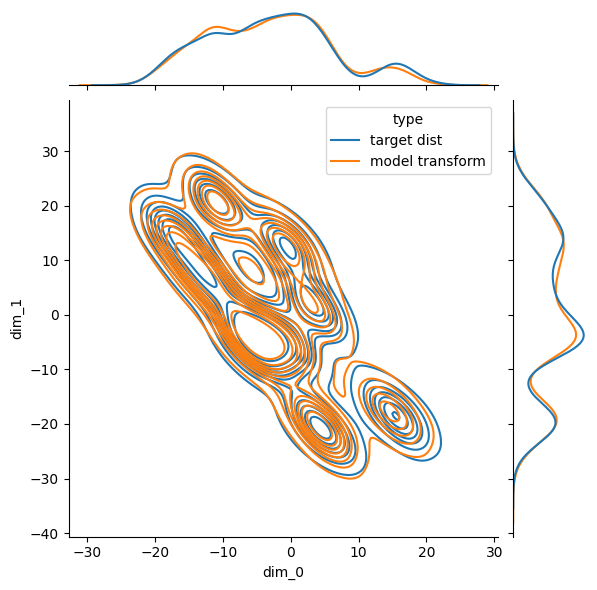

trail: 0 m step: 42 kl_test: 0.3160362243652344


  2%|▏         | 100/6000 [00:32<35:08,  2.80it/s]

trail: 0 m step: 43 Loss: 0.30818748474121094  L_n: 0.2976970672607422  kld: 0.0005245208740234375 KLD1: 0.3014322519302368 KLD2: 0.22193051874637604


  3%|▎         | 200/6000 [01:04<34:23,  2.81it/s]

trail: 0 m step: 43 Loss: 0.34432029724121094  L_n: 0.30693626403808594  kld: 0.00186920166015625 KLD1: 0.3046340048313141 KLD2: 0.22055497765541077


  5%|▌         | 300/6000 [01:36<33:54,  2.80it/s]

trail: 0 m step: 43 Loss: 0.2969188690185547  L_n: 0.2868480682373047  kld: 0.0005035400390625 KLD1: 0.3118843138217926 KLD2: 0.22424860298633575


  7%|▋         | 400/6000 [02:08<33:23,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3256969451904297  L_n: 0.2964763641357422  kld: 0.001461029052734375 KLD1: 0.299043744802475 KLD2: 0.21822489798069


  8%|▊         | 500/6000 [02:41<32:42,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3308696746826172  L_n: 0.28940391540527344  kld: 0.0020732879638671875 KLD1: 0.2898191213607788 KLD2: 0.22662293910980225


 10%|█         | 600/6000 [03:13<31:57,  2.82it/s]

trail: 0 m step: 43 Loss: 0.33470916748046875  L_n: 0.2978973388671875  kld: 0.0018405914306640625 KLD1: 0.28867512941360474 KLD2: 0.22889213263988495


 12%|█▏        | 700/6000 [03:45<31:32,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3165149688720703  L_n: 0.28695106506347656  kld: 0.0014781951904296875 KLD1: 0.2855847179889679 KLD2: 0.23568524420261383


 13%|█▎        | 800/6000 [04:17<30:49,  2.81it/s]

trail: 0 m step: 43 Loss: 0.3001384735107422  L_n: 0.2834300994873047  kld: 0.000835418701171875 KLD1: 0.2990873456001282 KLD2: 0.24204376339912415


 15%|█▌        | 900/6000 [04:49<30:29,  2.79it/s]

trail: 0 m step: 43 Loss: 0.32315635681152344  L_n: 0.2828350067138672  kld: 0.0020160675048828125 KLD1: 0.2906951606273651 KLD2: 0.21563813090324402


 17%|█▋        | 1000/6000 [05:22<29:34,  2.82it/s]

trail: 0 m step: 43 Loss: 0.3158721923828125  L_n: 0.2874908447265625  kld: 0.0014190673828125 KLD1: 0.2925519049167633 KLD2: 0.2176576554775238


 18%|█▊        | 1100/6000 [05:54<29:10,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3355998992919922  L_n: 0.2808971405029297  kld: 0.002735137939453125 KLD1: 0.3031948506832123 KLD2: 0.2038504183292389


 20%|██        | 1200/6000 [06:26<28:30,  2.81it/s]

trail: 0 m step: 43 Loss: 0.3519153594970703  L_n: 0.3065204620361328  kld: 0.002269744873046875 KLD1: 0.30297908186912537 KLD2: 0.22110426425933838


 22%|██▏       | 1300/6000 [06:58<30:46,  2.54it/s]

trail: 0 m step: 43 Loss: 0.3203144073486328  L_n: 0.2893390655517578  kld: 0.00154876708984375 KLD1: 0.2989071011543274 KLD2: 0.22376605868339539


 23%|██▎       | 1400/6000 [07:31<27:24,  2.80it/s]

trail: 0 m step: 43 Loss: 0.35690879821777344  L_n: 0.31715965270996094  kld: 0.001987457275390625 KLD1: 0.2850356996059418 KLD2: 0.20996154844760895


 25%|██▌       | 1500/6000 [08:03<26:43,  2.81it/s]

trail: 0 m step: 43 Loss: 0.33082008361816406  L_n: 0.29801368713378906  kld: 0.00164031982421875 KLD1: 0.29507720470428467 KLD2: 0.21405526995658875


 27%|██▋       | 1600/6000 [08:35<26:13,  2.80it/s]

trail: 0 m step: 43 Loss: 0.31786346435546875  L_n: 0.300506591796875  kld: 0.0008678436279296875 KLD1: 0.29156532883644104 KLD2: 0.22812490165233612


 28%|██▊       | 1700/6000 [09:07<24:32,  2.92it/s]

trail: 0 m step: 43 Loss: 0.34557151794433594  L_n: 0.3111248016357422  kld: 0.0017223358154296875 KLD1: 0.276611328125 KLD2: 0.22388087213039398


 30%|███       | 1800/6000 [09:39<25:07,  2.79it/s]

trail: 0 m step: 43 Loss: 0.35125160217285156  L_n: 0.2977313995361328  kld: 0.0026760101318359375 KLD1: 0.3055196702480316 KLD2: 0.2210596650838852


 32%|███▏      | 1900/6000 [10:12<24:24,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3508338928222656  L_n: 0.2962074279785156  kld: 0.0027313232421875 KLD1: 0.29933980107307434 KLD2: 0.23156440258026123


 33%|███▎      | 2000/6000 [10:44<23:51,  2.79it/s]

trail: 0 m step: 43 Loss: 0.31841278076171875  L_n: 0.27400970458984375  kld: 0.00222015380859375 KLD1: 0.29577895998954773 KLD2: 0.2270781248807907


 35%|███▌      | 2100/6000 [11:16<23:12,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3119659423828125  L_n: 0.29369354248046875  kld: 0.0009136199951171875 KLD1: 0.28884533047676086 KLD2: 0.22828924655914307


 37%|███▋      | 2200/6000 [11:48<22:35,  2.80it/s]

trail: 0 m step: 43 Loss: 0.359649658203125  L_n: 0.30239105224609375  kld: 0.0028629302978515625 KLD1: 0.285905659198761 KLD2: 0.22550104558467865


 38%|███▊      | 2300/6000 [12:20<21:53,  2.82it/s]

trail: 0 m step: 43 Loss: 0.30872154235839844  L_n: 0.29094505310058594  kld: 0.000888824462890625 KLD1: 0.29785871505737305 KLD2: 0.21140606701374054


 40%|████      | 2400/6000 [12:52<21:19,  2.81it/s]

trail: 0 m step: 43 Loss: 0.3132896423339844  L_n: 0.2865104675292969  kld: 0.001338958740234375 KLD1: 0.2823246419429779 KLD2: 0.22737020254135132


 42%|████▏     | 2500/6000 [13:25<20:50,  2.80it/s]

trail: 0 m step: 43 Loss: 0.32980918884277344  L_n: 0.29395103454589844  kld: 0.00179290771484375 KLD1: 0.291029155254364 KLD2: 0.21771767735481262


 43%|████▎     | 2600/6000 [13:57<20:11,  2.81it/s]

trail: 0 m step: 43 Loss: 0.295257568359375  L_n: 0.27675628662109375  kld: 0.0009250640869140625 KLD1: 0.2850686013698578 KLD2: 0.22127562761306763


 45%|████▌     | 2700/6000 [14:29<19:35,  2.81it/s]

trail: 0 m step: 43 Loss: 0.33568572998046875  L_n: 0.29532623291015625  kld: 0.002017974853515625 KLD1: 0.29287707805633545 KLD2: 0.2154790759086609


 47%|████▋     | 2800/6000 [15:02<18:54,  2.82it/s]

trail: 0 m step: 43 Loss: 0.34576416015625  L_n: 0.31826019287109375  kld: 0.0013751983642578125 KLD1: 0.2964676320552826 KLD2: 0.21516984701156616


 48%|████▊     | 2900/6000 [15:34<18:23,  2.81it/s]

trail: 0 m step: 43 Loss: 0.3349456787109375  L_n: 0.3067169189453125  kld: 0.00141143798828125 KLD1: 0.2930818200111389 KLD2: 0.22050511837005615


 50%|█████     | 3000/6000 [16:06<17:11,  2.91it/s]

trail: 0 m step: 43 Loss: 0.2908306121826172  L_n: 0.2742748260498047  kld: 0.000827789306640625 KLD1: 0.30936309695243835 KLD2: 0.21792250871658325


 52%|█████▏    | 3100/6000 [16:38<17:20,  2.79it/s]

trail: 0 m step: 43 Loss: 0.3194732666015625  L_n: 0.28784942626953125  kld: 0.0015811920166015625 KLD1: 0.27939271926879883 KLD2: 0.23186728358268738


 53%|█████▎    | 3200/6000 [17:11<16:42,  2.79it/s]

trail: 0 m step: 43 Loss: 0.3158740997314453  L_n: 0.2971057891845703  kld: 0.00093841552734375 KLD1: 0.28985804319381714 KLD2: 0.21662402153015137


 55%|█████▌    | 3300/6000 [17:43<16:05,  2.80it/s]

trail: 0 m step: 43 Loss: 0.2962226867675781  L_n: 0.2886314392089844  kld: 0.0003795623779296875 KLD1: 0.2937999665737152 KLD2: 0.22312644124031067


 57%|█████▋    | 3400/6000 [18:16<15:28,  2.80it/s]

trail: 0 m step: 43 Loss: 0.32991790771484375  L_n: 0.30382537841796875  kld: 0.00130462646484375 KLD1: 0.2954224646091461 KLD2: 0.22318048775196075


 58%|█████▊    | 3500/6000 [18:48<14:56,  2.79it/s]

trail: 0 m step: 43 Loss: 0.33766746520996094  L_n: 0.3057384490966797  kld: 0.0015964508056640625 KLD1: 0.281035453081131 KLD2: 0.21229411661624908


 60%|██████    | 3600/6000 [19:20<14:15,  2.80it/s]

trail: 0 m step: 43 Loss: 0.30329322814941406  L_n: 0.2881488800048828  kld: 0.0007572174072265625 KLD1: 0.30926433205604553 KLD2: 0.23028317093849182


 62%|██████▏   | 3700/6000 [19:52<13:54,  2.75it/s]

trail: 0 m step: 43 Loss: 0.3518943786621094  L_n: 0.3121452331542969  kld: 0.001987457275390625 KLD1: 0.27855971455574036 KLD2: 0.22723734378814697


 63%|██████▎   | 3801/6000 [20:25<11:08,  3.29it/s]

trail: 0 m step: 43 Loss: 0.3168163299560547  L_n: 0.2969036102294922  kld: 0.000995635986328125 KLD1: 0.29423391819000244 KLD2: 0.2132304161787033


 65%|██████▌   | 3900/6000 [20:57<12:30,  2.80it/s]

trail: 0 m step: 43 Loss: 0.34802818298339844  L_n: 0.31285667419433594  kld: 0.001758575439453125 KLD1: 0.2900388240814209 KLD2: 0.22136342525482178


 67%|██████▋   | 4000/6000 [21:29<11:47,  2.83it/s]

trail: 0 m step: 43 Loss: 0.31467247009277344  L_n: 0.29117393493652344  kld: 0.0011749267578125 KLD1: 0.3026535212993622 KLD2: 0.21904343366622925


 68%|██████▊   | 4100/6000 [22:01<11:06,  2.85it/s]

trail: 0 m step: 43 Loss: 0.3366832733154297  L_n: 0.3079967498779297  kld: 0.001434326171875 KLD1: 0.28085950016975403 KLD2: 0.22135424613952637


 70%|███████   | 4200/6000 [22:33<10:46,  2.78it/s]

trail: 0 m step: 43 Loss: 0.3135833740234375  L_n: 0.284515380859375  kld: 0.001453399658203125 KLD1: 0.29292479157447815 KLD2: 0.22262318432331085


 72%|███████▏  | 4300/6000 [23:05<10:08,  2.79it/s]

trail: 0 m step: 43 Loss: 0.3465461730957031  L_n: 0.3116035461425781  kld: 0.00174713134765625 KLD1: 0.30042868852615356 KLD2: 0.228640615940094


 73%|███████▎  | 4400/6000 [23:38<09:34,  2.79it/s]

trail: 0 m step: 43 Loss: 0.3184680938720703  L_n: 0.2919178009033203  kld: 0.0013275146484375 KLD1: 0.2789788842201233 KLD2: 0.21684789657592773


 75%|███████▌  | 4500/6000 [24:10<08:57,  2.79it/s]

trail: 0 m step: 43 Loss: 0.324493408203125  L_n: 0.306182861328125  kld: 0.00091552734375 KLD1: 0.29825639724731445 KLD2: 0.22484588623046875


 77%|███████▋  | 4600/6000 [24:42<08:18,  2.81it/s]

trail: 0 m step: 43 Loss: 0.30019187927246094  L_n: 0.2793254852294922  kld: 0.0010433197021484375 KLD1: 0.2957608997821808 KLD2: 0.230348140001297


 78%|███████▊  | 4700/6000 [25:14<07:45,  2.80it/s]

trail: 0 m step: 43 Loss: 0.303558349609375  L_n: 0.293182373046875  kld: 0.000518798828125 KLD1: 0.30072322487831116 KLD2: 0.21971368789672852


 80%|████████  | 4800/6000 [25:46<07:09,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3087177276611328  L_n: 0.2948322296142578  kld: 0.00069427490234375 KLD1: 0.2858181297779083 KLD2: 0.2279333472251892


 82%|████████▏ | 4900/6000 [26:18<06:31,  2.81it/s]

trail: 0 m step: 43 Loss: 0.3173389434814453  L_n: 0.29639625549316406  kld: 0.0010471343994140625 KLD1: 0.29555588960647583 KLD2: 0.21926501393318176


 83%|████████▎ | 5000/6000 [26:51<06:00,  2.77it/s]

trail: 0 m step: 43 Loss: 0.32714271545410156  L_n: 0.30700111389160156  kld: 0.001007080078125 KLD1: 0.31718137860298157 KLD2: 0.22358080744743347


 85%|████████▌ | 5100/6000 [27:23<05:21,  2.80it/s]

trail: 0 m step: 43 Loss: 0.30724143981933594  L_n: 0.28580284118652344  kld: 0.001071929931640625 KLD1: 0.2926933765411377 KLD2: 0.23809383809566498


 87%|████████▋ | 5200/6000 [27:55<04:44,  2.82it/s]

trail: 0 m step: 43 Loss: 0.3128948211669922  L_n: 0.29797935485839844  kld: 0.0007457733154296875 KLD1: 0.2780514657497406 KLD2: 0.2272080034017563


 88%|████████▊ | 5300/6000 [28:27<04:09,  2.80it/s]

trail: 0 m step: 43 Loss: 0.32042503356933594  L_n: 0.2969646453857422  kld: 0.0011730194091796875 KLD1: 0.3063591718673706 KLD2: 0.22003331780433655


 90%|█████████ | 5400/6000 [28:59<03:33,  2.81it/s]

trail: 0 m step: 43 Loss: 0.31084442138671875  L_n: 0.2896728515625  kld: 0.0010585784912109375 KLD1: 0.30113065242767334 KLD2: 0.21755316853523254


 92%|█████████▏| 5500/6000 [29:32<02:58,  2.80it/s]

trail: 0 m step: 43 Loss: 0.30013084411621094  L_n: 0.2882671356201172  kld: 0.0005931854248046875 KLD1: 0.286230206489563 KLD2: 0.22754789888858795


 93%|█████████▎| 5600/6000 [30:04<02:22,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3208198547363281  L_n: 0.3038825988769531  kld: 0.00084686279296875 KLD1: 0.28788042068481445 KLD2: 0.21872305870056152


 95%|█████████▌| 5700/6000 [30:36<01:46,  2.81it/s]

trail: 0 m step: 43 Loss: 0.2987060546875  L_n: 0.28142547607421875  kld: 0.0008640289306640625 KLD1: 0.27847549319267273 KLD2: 0.22077006101608276


 97%|█████████▋| 5800/6000 [31:08<01:11,  2.81it/s]

trail: 0 m step: 43 Loss: 0.3219947814941406  L_n: 0.3007850646972656  kld: 0.00106048583984375 KLD1: 0.2877448797225952 KLD2: 0.21465209126472473


 98%|█████████▊| 5900/6000 [31:40<00:35,  2.80it/s]

trail: 0 m step: 43 Loss: 0.3187904357910156  L_n: 0.2928504943847656  kld: 0.0012969970703125 KLD1: 0.2824470102787018 KLD2: 0.23040670156478882


100%|██████████| 6000/6000 [32:12<00:00,  3.10it/s]

trail: 0 m step: 43 Loss: 0.3323631286621094  L_n: 0.3201942443847656  kld: 0.0006084442138671875 KLD1: 0.2903156578540802 KLD2: 0.22025719285011292



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


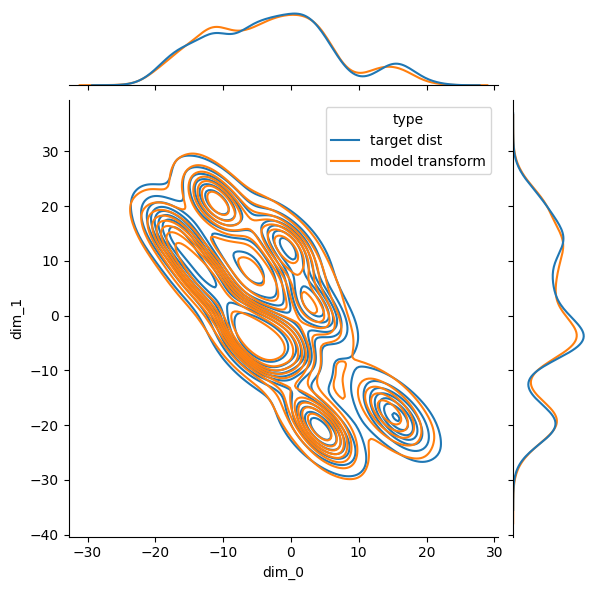

trail: 0 m step: 43 kl_test: 0.30743980407714844


  2%|▏         | 100/6000 [00:31<34:48,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3200054168701172  L_n: 0.30386924743652344  kld: 0.0008068084716796875 KLD1: 0.295282781124115 KLD2: 0.2188587337732315


  3%|▎         | 200/6000 [01:03<34:07,  2.83it/s]

trail: 0 m step: 44 Loss: 0.32375144958496094  L_n: 0.28995323181152344  kld: 0.001689910888671875 KLD1: 0.2987430989742279 KLD2: 0.21803143620491028


  5%|▌         | 300/6000 [01:35<33:43,  2.82it/s]

trail: 0 m step: 44 Loss: 0.2853202819824219  L_n: 0.2779579162597656  kld: 0.0003681182861328125 KLD1: 0.2928837835788727 KLD2: 0.22103974223136902


  7%|▋         | 400/6000 [02:07<33:04,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3188648223876953  L_n: 0.29181861877441406  kld: 0.0013523101806640625 KLD1: 0.2839646339416504 KLD2: 0.21683695912361145


  8%|▊         | 500/6000 [02:40<32:21,  2.83it/s]

trail: 0 m step: 44 Loss: 0.3091278076171875  L_n: 0.28509521484375  kld: 0.001201629638671875 KLD1: 0.2866632342338562 KLD2: 0.221963569521904


 10%|█         | 600/6000 [03:12<31:58,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3175201416015625  L_n: 0.28284454345703125  kld: 0.0017337799072265625 KLD1: 0.27758580446243286 KLD2: 0.22332201898097992


 12%|█▏        | 700/6000 [03:44<31:21,  2.82it/s]

trail: 0 m step: 44 Loss: 0.31573486328125  L_n: 0.29242706298828125  kld: 0.0011653900146484375 KLD1: 0.28866440057754517 KLD2: 0.23148322105407715


 13%|█▎        | 800/6000 [04:16<30:49,  2.81it/s]

trail: 0 m step: 44 Loss: 0.3154735565185547  L_n: 0.2791576385498047  kld: 0.0018157958984375 KLD1: 0.28541404008865356 KLD2: 0.23641957342624664


 15%|█▌        | 900/6000 [04:48<30:11,  2.82it/s]

trail: 0 m step: 44 Loss: 0.32624053955078125  L_n: 0.28923797607421875  kld: 0.001850128173828125 KLD1: 0.2855808436870575 KLD2: 0.21248626708984375


 17%|█▋        | 1000/6000 [05:20<29:39,  2.81it/s]

trail: 0 m step: 44 Loss: 0.2757301330566406  L_n: 0.2658119201660156  kld: 0.00049591064453125 KLD1: 0.29115819931030273 KLD2: 0.2171529233455658


 18%|█▊        | 1100/6000 [05:52<28:57,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3246326446533203  L_n: 0.28400611877441406  kld: 0.0020313262939453125 KLD1: 0.29436194896698 KLD2: 0.20174835622310638


 20%|██        | 1200/6000 [06:25<28:19,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3270893096923828  L_n: 0.29859352111816406  kld: 0.0014247894287109375 KLD1: 0.2799845039844513 KLD2: 0.22237996757030487


 22%|██▏       | 1300/6000 [06:57<27:47,  2.82it/s]

trail: 0 m step: 44 Loss: 0.31942176818847656  L_n: 0.2946643829345703  kld: 0.0012378692626953125 KLD1: 0.2879728078842163 KLD2: 0.2224336862564087


 23%|██▎       | 1400/6000 [07:29<27:11,  2.82it/s]

trail: 0 m step: 44 Loss: 0.33389854431152344  L_n: 0.2895336151123047  kld: 0.0022182464599609375 KLD1: 0.2653694748878479 KLD2: 0.20775189995765686


 25%|██▌       | 1500/6000 [08:01<26:36,  2.82it/s]

trail: 0 m step: 44 Loss: 0.31261444091796875  L_n: 0.28942108154296875  kld: 0.00115966796875 KLD1: 0.28936752676963806 KLD2: 0.21124623715877533


 27%|██▋       | 1600/6000 [08:33<25:56,  2.83it/s]

trail: 0 m step: 44 Loss: 0.3068580627441406  L_n: 0.2908744812011719  kld: 0.0007991790771484375 KLD1: 0.2908726930618286 KLD2: 0.22572587430477142


 28%|██▊       | 1700/6000 [09:05<25:26,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3327751159667969  L_n: 0.2980995178222656  kld: 0.0017337799072265625 KLD1: 0.2699294984340668 KLD2: 0.22155316174030304


 30%|███       | 1800/6000 [09:37<24:51,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3361091613769531  L_n: 0.2900276184082031  kld: 0.0023040771484375 KLD1: 0.29147225618362427 KLD2: 0.2171153724193573


 32%|███▏      | 1900/6000 [10:09<24:11,  2.83it/s]

trail: 0 m step: 44 Loss: 0.3567924499511719  L_n: 0.2913322448730469  kld: 0.00327301025390625 KLD1: 0.2786262035369873 KLD2: 0.23131392896175385


 33%|███▎      | 2000/6000 [10:41<23:44,  2.81it/s]

trail: 0 m step: 44 Loss: 0.34801292419433594  L_n: 0.2910594940185547  kld: 0.0028476715087890625 KLD1: 0.2840651273727417 KLD2: 0.22552211582660675


 35%|███▌      | 2100/6000 [11:14<23:08,  2.81it/s]

trail: 0 m step: 44 Loss: 0.3137226104736328  L_n: 0.2788562774658203  kld: 0.001743316650390625 KLD1: 0.28386765718460083 KLD2: 0.2269945740699768


 37%|███▋      | 2200/6000 [11:46<22:31,  2.81it/s]

trail: 0 m step: 44 Loss: 0.34086036682128906  L_n: 0.29981422424316406  kld: 0.00205230712890625 KLD1: 0.27523982524871826 KLD2: 0.2234167903661728


 38%|███▊      | 2300/6000 [12:18<22:01,  2.80it/s]

trail: 0 m step: 44 Loss: 0.3277244567871094  L_n: 0.2900733947753906  kld: 0.0018825531005859375 KLD1: 0.2935660183429718 KLD2: 0.2097686231136322


 40%|████      | 2400/6000 [12:50<21:15,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3063697814941406  L_n: 0.2801246643066406  kld: 0.001312255859375 KLD1: 0.2802013158798218 KLD2: 0.22520726919174194


 42%|████▏     | 2500/6000 [13:22<20:46,  2.81it/s]

trail: 0 m step: 44 Loss: 0.3304462432861328  L_n: 0.29844093322753906  kld: 0.0016002655029296875 KLD1: 0.27625200152397156 KLD2: 0.2163853943347931


 43%|████▎     | 2600/6000 [13:54<20:03,  2.83it/s]

trail: 0 m step: 44 Loss: 0.2990379333496094  L_n: 0.2604331970214844  kld: 0.00193023681640625 KLD1: 0.286545068025589 KLD2: 0.22061575949192047


 45%|████▌     | 2700/6000 [14:26<19:33,  2.81it/s]

trail: 0 m step: 44 Loss: 0.2996807098388672  L_n: 0.2723674774169922  kld: 0.00136566162109375 KLD1: 0.281768262386322 KLD2: 0.2133997678756714


 47%|████▋     | 2800/6000 [14:58<18:45,  2.84it/s]

trail: 0 m step: 44 Loss: 0.3230552673339844  L_n: 0.3057365417480469  kld: 0.000865936279296875 KLD1: 0.288454532623291 KLD2: 0.2143455445766449


 48%|████▊     | 2900/6000 [15:30<18:12,  2.84it/s]

trail: 0 m step: 44 Loss: 0.3089008331298828  L_n: 0.2853260040283203  kld: 0.001178741455078125 KLD1: 0.286550909280777 KLD2: 0.21874691545963287


 50%|█████     | 3000/6000 [16:02<17:40,  2.83it/s]

trail: 0 m step: 44 Loss: 0.2812919616699219  L_n: 0.2658805847167969  kld: 0.00077056884765625 KLD1: 0.3020748496055603 KLD2: 0.21851488947868347


 52%|█████▏    | 3100/6000 [16:34<17:09,  2.82it/s]

trail: 0 m step: 44 Loss: 0.3047046661376953  L_n: 0.27613258361816406  kld: 0.0014286041259765625 KLD1: 0.26886969804763794 KLD2: 0.22911186516284943


 53%|█████▎    | 3200/6000 [17:06<16:35,  2.81it/s]

trail: 0 m step: 44 Loss: 0.3073387145996094  L_n: 0.2933006286621094  kld: 0.000701904296875 KLD1: 0.2844839096069336 KLD2: 0.2137015014886856


 55%|█████▌    | 3300/6000 [17:38<15:55,  2.83it/s]

trail: 0 m step: 44 Loss: 0.3198394775390625  L_n: 0.3022918701171875  kld: 0.00087738037109375 KLD1: 0.28055688738822937 KLD2: 0.21970799565315247


 57%|█████▋    | 3400/6000 [18:10<15:24,  2.81it/s]

trail: 0 m step: 44 Loss: 0.3128013610839844  L_n: 0.2991447448730469  kld: 0.000682830810546875 KLD1: 0.291612833738327 KLD2: 0.21981002390384674


 58%|█████▊    | 3500/6000 [18:42<14:44,  2.83it/s]

trail: 0 m step: 44 Loss: 0.3405437469482422  L_n: 0.30174827575683594  kld: 0.0019397735595703125 KLD1: 0.27896541357040405 KLD2: 0.2091584950685501


 60%|██████    | 3600/6000 [19:14<14:11,  2.82it/s]

trail: 0 m step: 44 Loss: 0.31450653076171875  L_n: 0.29047393798828125  kld: 0.001201629638671875 KLD1: 0.29040056467056274 KLD2: 0.22720688581466675


 62%|██████▏   | 3700/6000 [19:46<13:38,  2.81it/s]

trail: 0 m step: 44 Loss: 0.3379402160644531  L_n: 0.3012809753417969  kld: 0.0018329620361328125 KLD1: 0.2759503424167633 KLD2: 0.22524815797805786


 63%|██████▎   | 3800/6000 [20:18<13:02,  2.81it/s]

trail: 0 m step: 44 Loss: 0.31223106384277344  L_n: 0.2899150848388672  kld: 0.0011157989501953125 KLD1: 0.27657049894332886 KLD2: 0.21021437644958496


 65%|██████▌   | 3900/6000 [20:50<12:25,  2.82it/s]

trail: 0 m step: 44 Loss: 0.31671142578125  L_n: 0.29798126220703125  kld: 0.0009365081787109375 KLD1: 0.2904442846775055 KLD2: 0.21761727333068848


 66%|██████▌   | 3962/6000 [21:10<10:51,  3.13it/s]

In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  lr_decay_factor = math.floor(mirror_itr/30) # decay the lr by 1/4 for every 30 mirror steps
  optimizer_lr_input = optimizer_lr * ((1/4 )** lr_decay_factor)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())